# KeyWord  뽑기

## 1 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

path = 'C:/Users/queenSSH/Desktop/학교/CUAI/cuai하계/최종데이터/'

naver = pd.read_csv(path + '네이버_추천시스템.csv' , encoding='cp949')
daum = pd.read_csv(path + 'daum_final.csv', encoding = 'cp949')
lezhin = pd.read_csv(path + '레진코믹스_웹툰.csv', encoding='UTF8')
kakao = pd.read_csv(path + 'kakao_page_완결_인코딩.csv', encoding = 'cp949')


#web_combined = pd.concat([naver, daum], axis=0, ignore_index=True)

### 데이터 합병

In [2]:
web_combined = pd.concat([naver, daum, lezhin, kakao], axis=0, ignore_index=True)

## 2 Model 적용

문장 단위 분리 ( 텍스트 크롤링 > 문장 단위 분리 > 명사 추출 )

1. 문장 단위 분리

문장 단위로 분리하기 위해 함수 중 문장을 추출하는 sentences()라는 함수를 이용하여 문장을 분리한다. 

2. 명사 추출(POS -Tagging)

TF-IDF 모델을 만들기 위한 전처리 과정으로 문장으로 분리 한 뒤 문장을 형태소 단위로 나눈 후 품사 태깅을 통해 명사들만 추출
KoNLPy 중 Twitter를 이용하여 명사를 추출

### SentenceTokenizer Class

<텍스트 크롤링, 문장 단위 분리, 명사 추출> 과정을 SentenceTokenizer 클래스로 만든다.

아래의 코드에서 stopwords는 불용어로써 문장 내에서 내용을 나타내는데 의미를 가지지 않는 단어들의 집합을 의미한다.(stopwords는 사용 목적에 맞게 적절히 추가, 삭제)

text2sentences(text) : text(str)를 입력받아 Kkma.sentences()를 이용하여 문장단위로 나누어 준 후 senteces를 return 해 준다.

get_nouns(sentences) : sentences를 받아 Twitter.nouns()를 이용하여 명사를 추출한 뒤 nouns를 return해 준다.

In [3]:
from konlpy.tag import Kkma
from konlpy.tag import Twitter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np

class SentenceTokenizer(object):
    def __init__(self) -> None:
        self.kkma = Kkma()
        self.twitter = Twitter()
#         self.stopwords = ['중인', '만큼', '마찬가지', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가']
        self.stopwords = ['을', '를', '에', '의', '가','우리','저희','그녀', '때문', '때문에','갑자기','계속','전혀','그때','얼떨결']

    def text2sentences(self, text):
        sentences = self.kkma.sentences(text)
        for i in range(0, len(sentences)):
            if len(sentences[i]) <= 10:
                sentences[i - 1] += (' ' + sentences[i])
                sentences[i] = ''

        return sentences
    
    def get_nouns(self, sentences):
        nouns = []
        for sentence in sentences:
            if sentence != '':
                nouns.append(' '.join([noun for noun in self.twitter.nouns(str(sentence)) if noun not in self.stopwords and len(noun) > 1]))

        return nouns

In [4]:
class GraphMatrix(object):
    def __init__(self):
        self.tfidf = TfidfVectorizer()
        self.cnt_vec = CountVectorizer()
        self.graph_sentence = []
    
    def build_sent_graph(self, sentence):
        tfidf_mat = self.tfidf.fit_transform(sentence).toarray()
        self.graph_sentence = np.dot(tfidf_mat, tfidf_mat.T)
        return self.graph_sentence
    
    def build_words_graph(self, sentence):
        cnt_vec_mat = normalize(self.cnt_vec.fit_transform(sentence).toarray().astype(float), axis=0)
        vocab = self.cnt_vec.vocabulary_
        return np.dot(cnt_vec_mat.T, cnt_vec_mat), {vocab[word] : word for word in vocab}

class Rank(object):
    def get_ranks(self, graph, d=0.85): # d = damping factor
        A = graph
        matrix_size = A.shape[0]

        for id in range(matrix_size):
            A[id, id] = 0 # diagonal 부분을 0으로
            link_sum = np.sum(A[:,id]) # A[:, id] = A[:][id]
            
            if link_sum != 0:
                A[:, id] /= link_sum
            
            A[:, id] *= -d
            A[id, id] = 1
            
        B = (1-d) * np.ones((matrix_size, 1))
        ranks = np.linalg.solve(A, B) # 연립방정식 Ax = b
        return {idx: r[0] for idx, r in enumerate(ranks)}

class TextRank(object):
    def __init__(self, text):
        self.sent_tokenize = SentenceTokenizer()
        self.sentences = self.sent_tokenize.text2sentences(text)
        self.nouns = self.sent_tokenize.get_nouns(self.sentences)
        self.graph_matrix = GraphMatrix()
        self.sent_graph = self.graph_matrix.build_sent_graph(self.nouns)
        self.words_graph, self.idx2word = self.graph_matrix.build_words_graph(self.nouns)
        self.rank = Rank()
        self.sent_rank_idx = self.rank.get_ranks(self.sent_graph)
        self.sorted_sent_rank_idx = sorted(self.sent_rank_idx, key=lambda k: self.sent_rank_idx[k], reverse=True)
        self.word_rank_idx = self.rank.get_ranks(self.words_graph)
        self.sorted_word_rank_idx = sorted(self.word_rank_idx, key=lambda k: self.word_rank_idx[k], reverse=True)

    def keywords(self, word_num):
        rank = Rank()
        rank_idx = rank.get_ranks(self.words_graph)
        sorted_rank_idx = sorted(rank_idx, key=lambda k: rank_idx[k], reverse=True)
        keywords = []
        index=[]
        for idx in sorted_rank_idx[:word_num]:
            index.append(idx)
        #index.sort()
        for idx in index:
            keywords.append(self.idx2word[idx])
        return keywords


## 3 키워드 추출하기

### word_num = 3 일때

In [5]:
key_wordlist = []
import warnings
warnings.filterwarnings('ignore')

for i in range(0, len(web_combined['story'])):
    try :
        text = web_combined['story'][i]
        textrank = TextRank(text)
        print('keywords :', textrank.keywords(word_num=3))

        key_wordlist.append(textrank.keywords(word_num=3))
        
        if web_combined['platform'][i] == '네이버 웹툰':

            key_wordlist[i].append(web_combined['genre'][i].split(',')[1].strip())
            
        else:
            if web_combined['genre'][i] not in key_wordlist[i]:
                key_wordlist[i].append(web_combined['genre'][i])


    except:
        key_wordlist.append(web_combined['genre'][i])

keywords : ['부대', '마물', '전담']
keywords : ['게임', '고백', '마스터']
keywords : ['경주로', '대결', '운명']
keywords : ['사이']
keywords : ['권한', '모든', '암호']
keywords : ['가지', '능력', '반복']
keywords : ['성찬', '가족', '사건']
keywords : ['외면', '창궐', '극한']
keywords : ['뒷바라지', '목숨', '아들']
keywords : ['마약', '사냥', '코미디']
keywords : ['아빠', '대한', '동안']
keywords : ['사화', '인간', '신선']
keywords : ['정호', '자신', '아내']
keywords : ['용수', '비디오', '모금']
keywords : ['교생', '구원', '살인마']
keywords : ['순이', '고등학교', '과연']
keywords : ['귀신', '마피아게임', '시즌']
keywords : ['당신', '손님', '조향사']
keywords : ['문제', '정말', '기분']
keywords : ['전우치', '진의', '신입']
keywords : ['건물', '누명', '약품']
keywords : ['기억', '감방', '남자']
keywords : ['단편', '데드', '실험']
keywords : ['인생', '혼인', '금지']
keywords : ['황후', '결심', '나비']
keywords : ['당신', '무죄', '살인']
keywords : ['늑대', '대안', '뭉치']
keywords : ['다시', '동화', '복수']
keywords : ['거짓', '거짓말', '고교생']
keywords : ['소녀', '짐승', '떠돌이']
keywords : ['능력', '마음', '생활']
keywords : ['동안', '사랑', '재동']
keywords : ['아이', '기숙사', '대학교']
key

keywords : ['모든', '지금', '흉터']
keywords : ['미스터리', '불명', '야크']
keywords : ['약육강식', '언니', '여고']
keywords : ['만화', '작가']
keywords : ['취업', '함정', '관문']
keywords : ['사이코', '소시', '개월']
keywords : ['스스로', '절망', '고립']
keywords : ['누나', '마찬가지', '오빠']
keywords : ['사기꾼', '냉소', '사람']
keywords : ['선비', '방랑', '수험']
keywords : ['사춘기', '오직', '소개']
keywords : ['은진', '이상', '전생']
keywords : ['인간', '방정', '모습']
keywords : ['데이', '무엇', '여정']
keywords : ['일대기', '풀기', '물의']
keywords : ['등장', '신토', '어로']
keywords : ['마지막', '세상', '좀비']
keywords : ['저승사자', '정신']
keywords : ['무인도', '가족', '불명']
keywords : ['어시', '직장인', '출근']
keywords : ['시마', '인류', '정착']
keywords : ['시작', '위해', '엄마']
keywords : ['양궁', '격리', '구역']
keywords : ['강아지', '낯선', '목표']
keywords : ['화재', '과거', '기억']
keywords : ['이승', '미스터리', '저승']
keywords : ['경호원', '구슬', '루시퍼']
keywords : ['나기', '냄새', '누나']
keywords : ['시한', '검찰', '금붕어']
keywords : ['가요', '냄새', '보신']
keywords : ['동거', '라이프', '럭키']
keywords : ['사랑', '웃음', '인생']
keywords : ['동물', '사랑']
keywo

keywords : ['일곱', '가장', '누굴']
keywords : ['이야기']
keywords : ['대한민국', '이야기', '장애인']
keywords : ['모험', '사의', '시작']
keywords : ['미래', '게임', '생각']
keywords : ['유부', '이야기']
keywords : ['시작', '허니문', '결혼']
keywords : ['사건', '개그', '라면']
keywords : ['공존', '능력', '비밀']
keywords : ['격투', '도로', '랜드']
keywords : ['가의', '기자', '로맨스']
keywords : ['기억', '당신']
keywords : ['사람']
keywords : ['가슴', '대학', '바로']
keywords : ['남자', '로맨스', '아슬아슬']
keywords : ['사랑', '금세', '남자에게']
keywords : ['고구마', '네이버', '독자']
keywords : ['동거', '아슬아슬', '유령']
keywords : ['소년', '남자', '스무']
keywords : ['세상', '소년', '장애인']
keywords : ['과거', '수상한', '싸움']
keywords : ['마법사', '대미', '문의']
keywords : ['그릇']
keywords : ['이야기', '제인', '동화']
keywords : ['신인', '이야기', '작가']
keywords : ['신작', '작가', '아이']
keywords : ['사람', '얘기', '여자친구']
keywords : ['이두', '단편', '듀싱']
keywords : ['남자', '마을', '시골']
keywords : ['시궁']
keywords : ['생존', '대한민국', '인간']
keywords : ['사랑', '소녀', '코앞']
keywords : ['만화', '잡지', '시대']
keywords : ['다른']
keywords : ['모험', '도대체', '

keywords : ['사람', '무엇', '선의']
keywords : ['작가', '전설', '단편']
keywords : ['관계', '빵점', '시작']
keywords : ['인기', '출동', '네이버']
keywords : ['리메이크', '명작', '만화']
keywords : ['이의', '화랑', '꼭대기']
keywords : ['고등학교', '이야기', '친구']
keywords : ['불량', '건의', '먹잇감']
keywords : ['사랑', '열정', '커피']
keywords : ['러브', '레인저', '사연']
keywords : ['네이버', '단편', '멸망']
keywords : ['들판', '서로', '신화']
keywords : ['오늘', '지금', '당신']
keywords : ['평화', '만화', '본격']
keywords : ['이야기', '황당', '독립']
keywords : ['고등학생', '남매', '생명']
keywords : ['과연', '관리', '길이']
keywords : ['내일', '단편', '신작']
keywords : ['당선', '대가', '마법']
keywords : ['누군가', '달빛', '보고']
keywords : ['동화', '시각', '다시']
keywords : ['당선', '도시', '서울']
keywords : ['만화', '제공', '모두']
keywords : ['스토리', '코끼리', '대한']
keywords : ['기획', '광고', '오늘']
keywords : ['대선', '대한민국', '만화']
keywords : ['세상', '다른', '눈물']
keywords : ['동화', '미지', '오묘']
keywords : ['바이', '알콩', '전학생']
keywords : ['네이버', '예측', '부활']
keywords : ['꽃님', '냄새', '마을']
keywords : ['공부', '그로', '대학입학']
keywords : ['세상', 

keywords : ['사람', '성장', '순간']
keywords : ['지용', '위해', '지혜']
keywords : ['물건', '경계', '세상']
keywords : ['과연', '마음껏', '럭셔리']
keywords : ['돌변', '비밀', '둥이']
keywords : ['마을', '요괴', '일지']
keywords : ['삼촌', '가족', '그것']
keywords : ['연쇄', '할머니', '노인']
keywords : ['민호', '게임', '러너']
keywords : ['광고', '냉혈', '시장']
keywords : ['사랑', '여주', '역할']
keywords : ['대표', '데뷔', '만취']
keywords : ['고등학생', '다른', '자신']
keywords : ['기생', '위기', '필터']
keywords : ['경호', '가족', '고백']
keywords : ['왕자', '시작', '마녀']
keywords : ['하우스', '셰어', '스무']
keywords : ['유림', '언제', '흡혈']
keywords : ['감수성', '다른', '비밀']
keywords : ['동아리', '게임', '우마']
keywords : ['하나', '사배', '세인']
keywords : ['대장', '로스', '만화']
keywords : ['과연', '대학', '생활']
keywords : ['세계', '독자', '소설']
keywords : ['순이', '취향', '비밀']
keywords : ['능력', '레벨', '세상']
keywords : ['만화', '신작', '작가']
keywords : ['권력', '목숨', '복수']
keywords : ['검존', '매화', '십만']
keywords : ['리플', '귀족', '백작']
keywords : ['학교', '거대', '재벌']
keywords : ['복귀', '배우', '스토리']
keywords : ['노곤', '이야기', '일상']


keywords : ['가족', '고향', '비행기']
keywords : ['인터넷', '시작', '수희']
keywords : ['신들', '인류', '이번']
keywords : ['가을', '그룹', '동경']
keywords : ['만인', '반쪽', '신수']
keywords : ['가공', '교육', '마령']
keywords : ['서울', '연우', '불명']
keywords : ['부활', '시작', '파괴']
keywords : ['기고', '내기', '여주']
keywords : ['몰래', '실명', '익명']
keywords : ['남자', '화장', '세상']
keywords : ['계약', '관리', '독점']
keywords : ['조석', '행성', '개념']
keywords : ['마음', '나니', '발신']
keywords : ['마법사', '지오']
keywords : ['야식', '셰프', '시작']
keywords : ['시작', '무인도', '다섯']
keywords : ['아카데미', '명령', '복학']
keywords : ['로맨스', '아래', '연꽃']
keywords : ['영은', '정의', '사법부']
keywords : ['고등학생', '미수', '범인']
keywords : ['다이스', '굴리', '신체']
keywords : ['세상', '그린', '발전']
keywords : ['제안', '병호', '주저']
keywords : ['공모전', '도깨비', '수상작']
keywords : ['동생', '친구', '본인']
keywords : ['학교', '마파람', '밑바닥']
keywords : ['황제', '소설', '주인공']
keywords : ['만날', '매일', '그룹']
keywords : ['고등학생', '대륙', '마법사']
keywords : ['다른', '다시', '세계']
keywords : ['문제', '마음대로', '죽지']
keywords : ['아연', '우울증',

keywords : ['세계', '승은', '후궁']
keywords : ['남녀', '사고', '안개']
keywords : ['가장', '다른', '자신']
keywords : ['궁합', '다른', '성격']
keywords : ['남자', '십년', '외출']
keywords : ['공인', '데뷔', '사건']
keywords : ['액션', '코믹', '간의']
keywords : ['껍데기', '도하', '성형']
keywords : ['매몰', '발신', '전화']
keywords : ['등골', '기어', '벌레']
keywords : ['남자', '라이프', '서울']
keywords : ['대판', '대하', '심층']
keywords : ['규칙', '노인', '매우']
keywords : ['소녀', '이야기', '태생']
keywords : ['악연', '유기한', '남자']
keywords : ['다시', '스무', '오기']
keywords : ['내게로', '가가', '여신']
keywords : ['아이', '유치원', '일상']
keywords : ['기억', '기회', '윤회']
keywords : ['개성', '일상', '자매']
keywords : ['무스', '인맥', '취업']
keywords : ['강사', '강남', '스승']
keywords : ['가출', '세상', '적응']
keywords : ['고양이', '인간', '임무']
keywords : ['범죄', '조직', '구성원']
keywords : ['귀신', '도깨비', '소녀']
keywords : ['기억', '분투', '정은']
keywords : ['번의', '연애', '이야기']
keywords : ['명문', '고등학교', '순정']
keywords : ['별거', '시작', '한마디']
keywords : ['손가락', '거짓말', '단지']
keywords : ['과학', '발상', '사람']
keywords : ['단지']
keyword

keywords : ['가게', '강풀', '미스']
keywords : ['사람', '이야기', '커피']
keywords : ['기억', '시간']
keywords : ['이후', '고뇌', '일상']
keywords : ['기회', '솔로', '탈출기']
keywords : ['계란', '괴담', '만화']
keywords : ['사람', '이유', '지구']
keywords : ['감각', '드비', '복귀']
keywords : ['레이어', '감성', '시공']
keywords : ['당신', '보고', '사랑']
keywords : ['대망', '뒤엉킨', '분노']
keywords : ['동거', '거울', '모습']
keywords : ['다시', '감동', '시리즈']
keywords : ['속옷', '위해', '현실']
keywords : ['사람', '사랑', '이야기']
keywords : ['남자', '가득', '바다']
keywords : ['소녀', '이야기', '기네스']
keywords : ['그것', '종말']
keywords : ['이야기', '인생', '커피']
keywords : ['섭취', '발휘', '음식']
keywords : ['결합', '가족', '비만']
keywords : ['이야기', '커피', '하루']
keywords : ['가족', '경제', '시크']
keywords : ['만화', '당신', '모든']
keywords : ['모독', '된장', '사상']
keywords : ['집단', '풍경', '데뷔']
keywords : ['대작', '만화', '시아']
keywords : ['보물', '소녀', '소동']
keywords : ['만화', '신화', '최신']
keywords : ['공개', '대한민국', '도시']
keywords : ['린다', '마을', '살인']
keywords : ['세상', '도전', '영웅']
keywords : ['감동', '소년', '시작']
keywords :

keywords : ['낯선', '만난', '세계']
keywords : ['단편', '괴기', '만화']
keywords : ['복통', '스포츠', '실버']
keywords : ['이야기', '선생님', '좌충우돌']
keywords : ['만화', '명랑', '모든']
keywords : ['게임', '동화', '미래']
keywords : ['간의', '기다림', '시작']
keywords : ['강철', '만화', '본격']
keywords : ['동화', '바위', '위해']
keywords : ['무한', '개그', '본능']
keywords : ['목숨', '모두', '발발']
keywords : ['기억', '노숙자', '만난']
keywords : ['보험', '이제', '사랑']
keywords : ['망상', '낯선', '소녀']
keywords : ['위기', '최대', '강팀']
keywords : ['공포', '금요일', '대표']
keywords : ['모레', '공주', '식솔']
keywords : ['가슴', '사랑', '이야기']
keywords : ['만화', '작가', '최종']
keywords : ['대가', '당신', '스스로']
keywords : ['주인공', '천사', '표류']
keywords : ['대한민국', '리얼', '만화']
keywords : ['고리', '자화상', '코드']
keywords : ['희원', '드라마', '로맨스']
keywords : ['지호', '친구', '비난']
keywords : ['대신', '설상', '제일']
keywords : ['독자', '로맨스', '린지']
keywords : ['사고', '전학', '남매']
keywords : ['자신', '계약', '복수']
keywords : ['전학', '미인', '방식']
keywords : ['너희', '라운드', '메리']
keywords : ['게임', '관계', '나라']
keywords : ['모두', '연인'

keywords : ['카를', '폭발사고', '무도회']
keywords : ['동생', '자신', '친척']
keywords : ['겉모습', '모습', '미소녀']
keywords : ['거짓말', '실제', '남자친구']
keywords : ['굼떠', '사무직', '지적']
keywords : ['콜레트', '약사', '처방전']
keywords : ['외모', '소녀', '소년']
keywords : ['으리', '인생', '건물']
keywords : ['글자', '불명', '수상한']
keywords : ['작가', '고등학교', '무대']
keywords : ['남자', '사람', '사랑']
keywords : ['기대', '상위', '의욕']
keywords : ['근거', '마중', '배우']
keywords : ['목란', '명문', '선희']
keywords : ['경험', '남자', '바로']
keywords : ['놀이', '사라', '미남']
keywords : ['전리품', '절대', '군주']
keywords : ['경험', '마음', '매니저']
keywords : ['서로', '제국', '잠시']
keywords : ['고백', '상대', '선배']
keywords : ['가게', '다나', '관리']
keywords : ['비밀', '대학생', '대한']
keywords : ['서자', '가슴', '건의']
keywords : ['배구', '무늬', '순정']
keywords : ['아침', '겨루기', '궁도']
keywords : ['스토리', '학원', '엮이면']
keywords : ['미남', '등록금', '수저']
keywords : ['연기', '배우', '상처']
keywords : ['약혼', '동생', '계략']
keywords : ['멀리', '몸매', '우마']
keywords : ['미쿠', '발견', '상태']
keywords : ['동안', '사회인', '생각']
keywords : ['선배', 

keywords : ['백합', '소녀', '처음']
keywords : ['미도', '선배', '사람']
keywords : ['남자친구', '사람', '일단']
keywords : ['공주', '왕실', '맞이']
keywords : ['고자', '대학', '구내']
keywords : ['미팅', '바람둥이', '깜짝']
keywords : ['가장', '운명', '자신']
keywords : ['경영', '고모', '그것']
keywords : ['고은님', '생일', '고수']
keywords : ['남매', '쌍둥이', '반대']
keywords : ['다른', '단편', '수록']
keywords : ['사랑', '와중', '이유']
keywords : ['슈퍼스타', '누가', '맞닥뜨린']
keywords : ['원인', '등교', '보건']
keywords : ['경험', '사실', '이기']
keywords : ['아스카', '산산조각', '남자']
keywords : ['매일', '만끽', '속수']
keywords : ['접근', '프롬', '동생']
keywords : ['백수', '셰어', '이중']
keywords : ['만난', '선생님', '양호']
keywords : ['간다', '남녀', '남자친구']
keywords : ['리코', '센터', '심부름']
keywords : ['녀석', '비밀']
keywords : ['나즈나', '사이', '남학생']
keywords : ['남자친구', '남친', '다음']
keywords : ['자신', '간의', '관련']
keywords : ['도련님', '과연', '비밀']
keywords : ['강운', '기업', '운영']
keywords : ['약속', '교내', '과제']
keywords : ['그림', '키라', '생각']
keywords : ['불명', '삼촌', '야심']
keywords : ['사람', '서로', '단골']
keywords : ['능력', '바로', 

keywords : ['골목길', '분발', '사랑']
keywords : ['스타일', '가게', '고향']
keywords : ['상태', '스무', '연애']
keywords : ['누구', '보통', '불문']
keywords : ['문득', '사랑', '서른']
keywords : ['무부', '기업', '꽃병']
keywords : ['사랑', '사우나', '송이']
keywords : ['사장', '레이', '누구']
keywords : ['가장', '고등학생', '모토']
keywords : ['미나미', '친구', '사쿠라']
keywords : ['미노', '인호', '관찰']
keywords : ['레하', '사람', '왕국']
keywords : ['독립', '근처', '대학교']
keywords : ['다리', '도망', '부상']
keywords : ['기준', '만남', '반한']
keywords : ['희영', '남자', '간의']
keywords : ['몰래', '스가', '스가와라']
keywords : ['담배', '선배', '연애경험']
keywords : ['소꿉친구', '사건', '계기']
keywords : ['방과', '고교생', '극히']
keywords : ['매일', '여자아이', '목격']
keywords : ['학교', '도련님', '비밀']
keywords : ['고교생', '남동생', '소설가']
keywords : ['여고생', '연애', '가까이']
keywords : ['거리', '다른', '모범생']
keywords : ['미술', '남자', '교사']
keywords : ['소리', '가까이', '그대로']
keywords : ['비밀', '방과', '천사']
keywords : ['고등학교', '심장', '아쿠츠']
keywords : ['메이드', '미남', '사죄']
keywords : ['미남', '입술', '차이']
keywords : ['그린', '메일', '로맨스']
keywords 

keywords : ['과거', '대결', '마법사']
keywords : ['데뷔', '미소년', '사랑']
keywords : ['가장', '재능', '아버지']
keywords : ['결말', '도라지', '여자']
keywords : ['남자', '대로', '부의']
keywords : ['사랑', '생생', '스토리']
keywords : ['과연', '노력', '레인']
keywords : ['남자친구', '수도', '꽁꽁']
keywords : ['가지', '그림자', '눈길']
keywords : ['학교', '반경', '양은']
keywords : ['에이', '가수', '가장']
keywords : ['안해', '사나이', '인간']
keywords : ['트루', '디아', '노인']
keywords : ['대표', '십장생', '오방']
keywords : ['갖은', '고생', '돌연변이']
keywords : ['강의', '능력', '보유']
keywords : ['리메이크', '고지라', '백수']
keywords : ['모험', '시작', '이야기']
keywords : ['교회', '노량진', '밀도']
keywords : ['괄량', '신의', '배후']
keywords : ['공작', '아버지', '암살자']
keywords : ['정윤', '호진', '반복']
keywords : ['동시', '버추', '에스']
keywords : ['생일', '땅속', '부모님']
keywords : ['경호', '현장', '생사']
keywords : ['가게', '때로는', '수수께끼']
keywords : ['화제', '네티즌', '매력']
keywords : ['방송', '세계', '인기']
keywords : ['친구', '남녀', '등교']
keywords : ['개시', '고추', '만화']
keywords : ['고수', '동료', '등장']
keywords : ['우정', '다른', '다크']
keywords : ['다시'

keywords : ['광견', '불리', '리얼']
keywords : ['인류', '혼수', '버들']
keywords : ['경지', '남친', '유리']
keywords : ['구세주', '구원', '무시']
keywords : ['사람', '상대', '대하']
keywords : ['신의', '요구', '동물']
keywords : ['상위', '영사', '주간']
keywords : ['소환', '우뚝', '기록']
keywords : ['사랑', '생각', '사실']
keywords : ['고등학교', '민지', '이상형']
keywords : ['공모전', '다시금', '무림']
keywords : ['손자', '부모', '사랑']
keywords : ['크로노스', '신의', '유일신']
keywords : ['미래', '세상', '과연']
keywords : ['아들', '무제', '사랑']
keywords : ['누구', '시작', '여름']
keywords : ['위기', '절망', '강력']
keywords : ['마왕', '사제', '쑥대밭']
keywords : ['사고', '세계', '시작']
keywords : ['모임', '소녀', '이야기']
keywords : ['라이', '오니', '슈르트']
keywords : ['바리데기', '요괴', '가치']
keywords : ['무엇', '성격', '건달']
keywords : ['대도시', '동물', '미국']
keywords : ['명령', '무시', '무인']
keywords : ['다시', '컬러', '프리']
keywords : ['절도', '병단', '조사']
keywords : ['구사', '암흑', '명작']
keywords : ['영은', '오빠', '학교']
keywords : ['교도소', '레이첼', '수감']
keywords : ['몬스터', '사람', '생계']
keywords : ['요괴', '이누야샤', '과거']
keywords : ['까닭', '사

keywords : ['사랑', '저주', '남녀']
keywords : ['어스', '드벤', '스크']
keywords : ['노바', '여행', '소문']
keywords : ['도의', '명령', '자해']
keywords : ['경계', '주술사', '기계']
keywords : ['대한민국', '좀비', '통칭']
keywords : ['화신', '구해', '매력']
keywords : ['나라', '신의', '대국']
keywords : ['장기', '기사', '모든']
keywords : ['주인공', '캐스팅', '신작']
keywords : ['범죄', '유수', '사고']
keywords : ['개그', '런던', '뱀파이어']
keywords : ['나라', '생활', '게다가']
keywords : ['각하', '개막', '개성']
keywords : ['마음', '개막', '괴물']
keywords : ['개혁', '시작', '만장']
keywords : ['상치', '사건', '인격']
keywords : ['축구', '코미디', '공격']
keywords : ['느낌', '아르바이트', '이야기']
keywords : ['로맨스', '소녀', '신력']
keywords : ['격투게임', '오타쿠', '개발']
keywords : ['베일', '감시', '교황']
keywords : ['고등학교', '사립', '도시']
keywords : ['여학생', '햇빛', '극도']
keywords : ['아츠시', '마을', '요괴']
keywords : ['마스', '명석', '수려']
keywords : ['개그', '남자', '라디오']
keywords : ['부활동', '우사', '일상']
keywords : ['대한', '대박', '선사']
keywords : ['상대역', '이로', '일상']
keywords : ['오직', '이름', '정신']
keywords : ['괴물', '구체', '도시']
keywords : ['무언가

keywords : ['시간', '능력', '감지']
keywords : ['바로', '이자', '인간']
keywords : ['가능', '친구']
keywords : ['만난', '베일', '사람']
keywords : ['친구', '학생', '사람']
keywords : ['고독', '사랑', '누나']
keywords : ['공유', '생각', '여러분']
keywords : ['역적', '오랑캐', '임금']
keywords : ['아내', '근처', '까탈']
keywords : ['고로', '만화', '본격']
keywords : ['까마귀', '거리', '다람쥐']
keywords : ['미국', '국제', '뉴욕']
keywords : ['고성', '비밀리', '가람']
keywords : ['다른', '복점', '맞이']
keywords : ['아버지', '남아', '매일']
keywords : ['계기', '윤지', '사회']
keywords : ['정체', '지구', '변신']
keywords : ['맹세', '복수', '스노']
keywords : ['바지', '타임', '스무']
keywords : ['대남', '길이', '선거']
keywords : ['살인', '살해', '상황']
keywords : ['여러', '과거', '대륙']
keywords : ['하나요', '희생', '눈초리']
keywords : ['현이', '다섯', '동현']
keywords : ['살해', '진술', '세상']
keywords : ['게임', '모종', '알바']
keywords : ['만화가', '식탁', '자꾸만']
keywords : ['나이', '비밀', '사람']
keywords : ['블록버스터', '악마', '일상']
keywords : ['결핍', '관계', '대한']
keywords : ['김철수', '사의', '쓰레기']
keywords : ['요시노', '시마', '키리']
keywords : ['명장', '거스', '그날']


keywords : ['개성', '만끽', '만화가']
keywords : ['과거', '국수', '급제']
keywords : ['뽕규', '그대로', '글쎄']
keywords : ['부활', '요리', '경천']
keywords : ['도쿄', '시간', '미스터리']
keywords : ['이름', '모어', '사냥꾼']
keywords : ['만난', '모노', '소년']
keywords : ['근무', '나이', '서른']
keywords : ['그것', '메이드', '보고']
keywords : ['현실', '낱낱', '로맨틱']
keywords : ['감독', '선수', '농구']
keywords : ['가족', '불명', '사투']
keywords : ['남자', '남친', '대해']
keywords : ['편지', '선우', '시절']
keywords : ['물리', '미트', '선사']
keywords : ['천만원', '개발', '대체']
keywords : ['결혼', '국내', '대표']
keywords : ['사실', '미남', '스핀']
keywords : ['가지', '갓난아이', '구출']
keywords : ['커피', '매력', '불구']
keywords : ['오빠', '호전', '그냥']
keywords : ['구성', '양성', '배우']
keywords : ['아이', '쌍둥이', '여고생']
keywords : ['마물', '시즌', '심화']
keywords : ['소녀', '시간', '아케']
keywords : ['가지', '고집', '고풍']
keywords : ['늦둥이', '막내', '가사']
keywords : ['고양이', '매일', '명의']
keywords : ['섥힌', '연애', '결혼']
keywords : ['이야기', '카인', '박동하']
keywords : ['치유', '모델', '지금']
keywords : ['대학', '대한민국', '위해']
keywords : ['만화', '완전체

keywords : ['남자', '여자', '글쓰기']
keywords : ['결혼', '아버지', '준비']
keywords : ['로제타', '귀족', '본성']
keywords : ['의료', '모순', '사이토']
keywords : ['천안', '도심', '상권']
keywords : ['사업', '아스', '커서']
keywords : ['사랑', '슬픔', '그리움']
keywords : ['공원', '근무', '드라마']
keywords : ['번의', '사람', '일생']
keywords : ['아르바이트', '유우', '키라']
keywords : ['독서', '목적', '이종']
keywords : ['지우', '오디션', '결심']
keywords : ['고등학생', '식객', '미남']
keywords : ['가슴', '눈물', '반응']
keywords : ['이야기', '시작', '불청객']
keywords : ['미래', '사고', '구심']
keywords : ['나날', '나카노', '마리']
keywords : ['베스트셀러', '일본', '상반기']
keywords : ['런던', '도일', '숙적']
keywords : ['매번', '밴드', '가수']
keywords : ['권해', '문자', '마스터']
keywords : ['먹보', '야마', '타로']
keywords : ['인간', '고아', '구가']
keywords : ['당황', '사람', '졸음']
keywords : ['마음', '멀리', '여주']
keywords : ['결혼', '친구', '맞닥뜨린']
keywords : ['계승', '공주', '관습']
keywords : ['마감', '사람', '데스크']
keywords : ['소년', '이국', '산간']
keywords : ['문제', '돌파', '구라']
keywords : ['출신', '행사', '근무']
keywords : ['결혼', '과연', '백만']
keywords : ['신입생'

keywords : ['방사선', '근무', '부모']
keywords : ['디자이너', '미용', '스토리']
keywords : ['고등학교', '동경', '라이']
keywords : ['청년', '취업', '눈물']
keywords : ['여러분', '조금', '그린']
keywords : ['그린', '나이', '로맨스']
keywords : ['당신', '인간', '콜라보']
keywords : ['히로', '댄스', '갑작스레']
keywords : ['수록', '기담', '단편']
keywords : ['공모전', '레진', '응원']
keywords : ['마을', '모든', '사람']
keywords : ['고양이', '가지', '시골']
keywords : ['오란씨', '재활', '관계']
keywords : ['결혼', '부부', '드라마']
keywords : ['선망', '사랑', '아들']
keywords : ['고백', '사쿠라', '동급생']
keywords : ['나날', '메리', '모두']
keywords : ['감성', '그림', '모두']
keywords : ['등하교', '멀리', '용기']
keywords : ['실력', '활약', '사람']
keywords : ['대판', '불합리', '사무라이']
keywords : ['소년', '지니', '명성']
keywords : ['걱정', '스마트', '땡볕']
keywords : ['샤라', '이름', '확인']
keywords : ['소년', '미모', '미즈']
keywords : ['입사', '참상', '책임자']
keywords : ['랜드', '안경', '여자']
keywords : ['국내', '나나', '다섯']
keywords : ['여성', '회사', '기혼']
keywords : ['사실', '토막', '에렉']
keywords : ['약국', '누구', '마음']
keywords : ['소식', '아틀리에', '예술가']
keywords : ['건

keywords : ['거지', '삽질', '각성']
keywords : ['마스코트', '시작', '건영']
keywords : ['과묵', '보이', '불끈불끈']
keywords : ['쌍둥이', '시절', '청춘']
keywords : ['남색', '위해', '남자']
keywords : ['사실', '유력', '재미']
keywords : ['부탁', '이용', '참고']
keywords : ['묘약', '사랑', '최악']
keywords : ['슬럼프', '영준', '절망']
keywords : ['옆집', '남자', '다운']
keywords : ['사람', '연루', '발생']
keywords : ['거래', '부탁', '이용']
keywords : ['고전', '무용', '부탁']
keywords : ['옆집', '택배', '건만']
keywords : ['수화', '학대', '전의']
keywords : ['나날', '선정', '수학']
keywords : ['계기', '남자', '소개팅']
keywords : ['동정', '마법', '서른']
keywords : ['나날', '이따', '마사']
keywords : ['공작', '아들', '비밀']
keywords : ['라이프', '샐러리맨', '스스로']
keywords : ['새벽', '이제', '중학교']
keywords : ['헨리', '고비', '머리']
keywords : ['친구', '커플', '사랑']
keywords : ['부탁', '스펙', '실수']
keywords : ['강아지', '관리', '녀석']
keywords : ['게임', '명의', '목숨']
keywords : ['가족', '엘리트', '마사']
keywords : ['성장기', '아기', '가족']
keywords : ['대량', '미남', '등장인물']
keywords : ['매일', '불량', '일상']
keywords : ['동거', '사생활', '사토']
keywords : ['외모', '동물'

keywords : ['누구', '대상', '뒷담화']
keywords : ['그림', '어시', '기회']
keywords : ['그날', '선전', '단번']
keywords : ['귀신', '거짓말', '보기']
keywords : ['여자', '성인', '교사']
keywords : ['그것', '도착', '불알']
keywords : ['대학교', '학년', '아빠']
keywords : ['녀석', '교육', '담당']
keywords : ['낙관', '모토', '남성']
keywords : ['사랑', '각각', '격려']
keywords : ['리쿠', '사정', '학원']
keywords : ['상급', '호텔', '대학생']
keywords : ['이츠키', '경험', '다시금']
keywords : ['기분', '누군가', '라이']
keywords : ['소년', '하루', '부임']
keywords : ['그것', '동료', '마음']
keywords : ['고등학생', '꽃집', '내기']
keywords : ['사람', '이치', '주인공']
keywords : ['부탁', '상처', '서로']
keywords : ['천계', '천사', '과거']
keywords : ['수석', '학장', '타츠미']
keywords : ['전철', '중간', '학교']
keywords : ['세이', '고대', '그것']
keywords : ['여우', '고로', '데리']
keywords : ['은현', '대화', '동물']
keywords : ['시공간', '가보', '구미호']
keywords : ['가지', '대리', '마음대로']
keywords : ['서비스', '국내', '기준']
keywords : ['결투', '남자', '도중']
keywords : ['원우', '등장', '섹시']
keywords : ['구미호', '남자', '동안']
keywords : ['가의', '고양이', '남학생']
keywords : ['명령', '생일

keywords : ['신령', '여우', '올해']
keywords : ['배우', '직업', '연기']
keywords : ['사람', '사의', '신경']
keywords : ['만난', '비밀', '사이']
keywords : ['후치', '공부', '대부분']
keywords : ['고등학교', '나미', '서로']
keywords : ['요정', '천진난만', '고교']
keywords : ['과제', '기숙사', '기하학']
keywords : ['모양', '병원', '의식']
keywords : ['등등', '모음', '소년']
keywords : ['당신', '변태', '안경']
keywords : ['담당', '공원', '만난']
keywords : ['미나미', '거절', '고백']
keywords : ['남자', '계기', '노메']
keywords : ['사람', '야근', '연인']
keywords : ['가정부', '가족', '남자']
keywords : ['이자', '재능', '학생']
keywords : ['노키', '사이', '접점']
keywords : ['탐정', '레이', '노코']
keywords : ['공원', '만두', '먹이']
keywords : ['노부', '학교', '마음']
keywords : ['사쿠라', '등장', '케이']
keywords : ['리얼', '엄친', '전이']
keywords : ['시대', '영주', '가슴']
keywords : ['거리', '사람', '질적']
keywords : ['각자', '남자', '마음속']
keywords : ['호우', '마사', '기숙사']
keywords : ['보충', '선생', '세계']
keywords : ['친구', '더욱', '동경']
keywords : ['케이', '마사', '갓길']
keywords : ['간류', '낯선', '당신']
keywords : ['건가', '현실', '곳도']
keywords : ['러브', '두바이', '사랑

keywords : ['무릉원', '용이', '발현']
keywords : ['스칼렛', '약혼자', '자신']
keywords : ['비사', '작품', '컬렉션']
keywords : ['초록', '신우', '선배']
keywords : ['소원', '로또', '일등']
keywords : ['개정판', '건곤', '구성']
keywords : ['연극', '매체', '영상']
keywords : ['믿음', '다른', '배신']
keywords : ['원우', '담당', '사랑']
keywords : ['메이저리그', '승리', '인생']
keywords : ['상대', '자신', '소연']
keywords : ['스칼렛', '약혼자', '자신']
keywords : ['카시', '토모', '무부']
keywords : ['무사', '도웅', '다시']
keywords : ['대형', '반려', '신한']
keywords : ['싸움', '이름', '주지']
keywords : ['사람', '상처', '부인']
keywords : ['카르', '완전', '등장']
keywords : ['거부', '드래곤', '라이']
keywords : ['리다', '메이크업', '고급']
keywords : ['다시', '번의', '사랑']
keywords : ['호수', '가수', '등장']
keywords : ['라면', '하루', '한번']
keywords : ['불행', '이언', '교사']
keywords : ['이드', '펠릭스', '공작']
keywords : ['채린', '강우', '반대']
keywords : ['나날', '도망', '러드']
keywords : ['붕도', '희진', '가상']
keywords : ['내시', '게임', '거세']
keywords : ['하성', '미션', '위기']
keywords : ['랭크', '마법', '에어']
keywords : ['짝사랑', '마음', '고백']
keywords : ['최고', '할아버지',

keywords : ['사랑', '세포', '국어']
keywords : ['인생', '전설', '방향']
keywords : ['자신', '다른', '서사시']
keywords : ['친구', '소녀', '콤플렉스']
keywords : ['가람', '인생', '모두']
keywords : ['에이', '결정', '고심']
keywords : ['천사', '왕가', '가문']
keywords : ['작가', '이야기', '심혈']
keywords : ['가지', '목적', '손님']
keywords : ['결심', '스쿠버', '사람']
keywords : ['인기', '아이', '작가']
keywords : ['사기', '강호', '개정판']
keywords : ['동료', '동지', '근무']
keywords : ['귀신', '마사', '근무']
keywords : ['사람', '소녀', '소년']
keywords : ['그림', '시작', '마음']
keywords : ['제국', '국립', '반드시']
keywords : ['작품', '전화위복', '개정판']
keywords : ['중전', '자리', '하나']
keywords : ['마음', '여자', '무열']
keywords : ['황제', '온수', '사약']
keywords : ['공간', '술사', '레나']
keywords : ['이제', '인생', '지고']
keywords : ['이제', '차야', '차지']
keywords : ['과거', '그룹', '매니저']
keywords : ['글자', '불명', '수상한']
keywords : ['개정판', '작품', '도시']
keywords : ['사건', '조사', '발견']
keywords : ['출산', '목숨', '위험']
keywords : ['박동하', '발랄', '뱀파이어']
keywords : ['왕자', '공주', '장가']
keywords : ['개정판', '결혼', '기억']
keywords : ['강호', '개정판'

keywords : ['사람', '복수심', '작가']
keywords : ['연서', '자신', '무영']
keywords : ['여자', '선택', '자리']
keywords : ['과부', '타임', '강진']
keywords : ['작품', '컬렉션', '개정판']
keywords : ['김원봉', '부의', '상해']
keywords : ['거기', '위해', '혼인']
keywords : ['재력', '집안', '비서']
keywords : ['사랑', '유주', '채원']
keywords : ['한준', '매번', '사고']
keywords : ['최강', '희망', '거듭']
keywords : ['개정판', '구성', '방일']
keywords : ['가해자', '학생', '용진']
keywords : ['등장', '수록', '기념']
keywords : ['연애', '언니네', '하늘']
keywords : ['절영', '다시', '시작']
keywords : ['각자', '거기', '목적']
keywords : ['정도', '화보', '고스']
keywords : ['살인', '은밀', '인터뷰']
keywords : ['동생', '교황', '진실']
keywords : ['결혼', '가슴', '개정판']
keywords : ['마코토', '언니', '고민']
keywords : ['마리아', '엑소', '메리']
keywords : ['우경', '스트리머', '거지']
keywords : ['결말', '상황', '여자']
keywords : ['사람', '일이', '하룻밤']
keywords : ['로맨스', '무당', '사기']
keywords : ['로맨스', '아악', '마치']
keywords : ['태극', '근원', '도구']
keywords : ['기회', '개정판', '교육']
keywords : ['비밀', '공주', '누가']
keywords : ['명작', '베스트', '개정판']
keywords : ['수족', '인간

In [6]:
web_combined['keywords'] = key_wordlist
web_combined['keywords2'] = pd.Series(web_combined['keywords']).astype(str)

web_combined.to_csv('전체웹툰_최종본.csv')

## 4 TfIdf, Cosine 유사도

In [7]:
tfidf = TfidfVectorizer()

#keywords에 대해서 tf-idf 수행
tfidf_matrix = tfidf.fit_transform(web_combined['keywords2'])
print(tfidf_matrix.shape)

(6633, 5556)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_matrix.shape

(6633, 6633)

In [9]:
np.round(cosine_matrix,4)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
#web title와 id를 매핑할 dictionary 생성

web2id = {}
for i, c in enumerate(web_combined['title']): 
    web2id[i] = c

#id와 web 매핑할 dictionary 생성
id2web = {}
for i,c in web2id.items() : 
    id2web[c] = i
    
#print(web2id[1])
#print(id2web['불릿'])

In [11]:
title_list = web_combined['title']

### 상위 10개의 인덱스와 유사도 추출

In [12]:
for j in range(len(title_list)):
    #예시_ idx = id2web['마물전담부대'] #마물전담부대 :  0번 인덱스
    idx = id2web[title_list[j]]
    print(web2id[j])
    sim_scores = [(i,c) for i,c in enumerate(cosine_matrix[idx]) if i != idx]
    #자기 자신을 제외한 영화들의 유사도 및 인덱스 추출

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True) #유사도가 높은 순서대로 정렬
    sim_scores[0:10] #상위 10개의 인덱스와 유사도 추출
    
    sim_scores = [(web2id[i], score) for i, score in sim_scores[0:10]]
    print(sim_scores)

마물전담부대
[('던전 속 사정[개정판]', 0.36248193442010374), ('김무녀는 무녓무녓해!!', 0.33273596828238416), ('괴기목욕탕', 0.31622551566699286), ('괴기목욕탕 시즌2', 0.2921771992033204), ('보석의 나라', 0.18833839867163477), ('게딱지', 0.18833839867163477), ('도깨비 언덕에 있어', 0.18833839867163477), ('레코닝', 0.09240483466861119), ('인챈트-나람이야기', 0.06153026858078363), ('난약', 0.059434867256891497)]
불릿
[('아오라', 0.47136699021660944), ('집사의 환상카페', 0.4403816241850823), ('잘 먹겠습니다와 다녀왔습니다와', 0.3597460801679756), ('어덕행덕', 0.3592202252021345), ('인피니티', 0.35366114372506746), ('고백', 0.34418893978384474), ('퍼펙트 게임', 0.34274702852259886), ('레이드', 0.32951913662656734), ('50픽셀 데이즈', 0.3249626212263255), ('MLB카툰', 0.3247720718160915)]
더
[('서울 불시착', 0.34453422073270734), ('시월드 판타지', 0.3299147184631359), ('꼬리', 0.31840304093782357), ('정령사: 나타르 전기', 0.30988662553877344), ('소녀생리학', 0.302083282805091), ('천적', 0.2853660598256271), ('도박묵시록 카이지 카즈야 편', 0.2843839958568912), ('맛있는 스캔들', 0.2774277033756602), ('먹짱!', 0.27405514782474566), ('프롬, 스타', 0.266655283618

[('잠깐만 회사 좀 관두고 올게', 0.549075640504738), ('크로싱 코드', 0.43568896298701154), ('키드갱', 0.37837434669009745), ('박인권 액션 특집 시즌3', 0.34314739873495725), ('크레이터', 0.33230992184787944), ('상중하', 0.32269417442521015), ('인생존망', 0.2952370458610798), ('오로지 오로라', 0.29116284061661607), ('4와 2분의 1 정거장', 0.2823424647384106), ('스파이 패밀리 [연재]', 0.28021952323236354)]
틴맘
[('사랑하는 나의 엄마에게', 0.36469339566263254), ('엄마들', 0.3630284144851698), ('나는 엄마다', 0.3596461433350968), ('대디보이', 0.3190377440627742), ('카사네', 0.30774088397747007), ('닥터앤닥터 육아일기', 0.30715257225162135), ('축제를 위하여', 0.29816613648879664), ('강철의 연금술사', 0.29784008603854967), ('얼굴미화부', 0.2850647316855738), ('바이바이, 사랑해', 0.279360125428983)]
냐한남자
[('그런 공 캐릭터는 유행이 지났습니다!', 0.4501896560136876), ('4와 2분의 1 정거장', 0.43622830848924843), ('쇼보냥', 0.42202259501723305), ('오피스 누나 이야기', 0.4181383233438728), ('우리집 아이돌', 0.40682930919267213), ('애플 다이너마이트', 0.4044500230786585), ('[드라마원작]', 0.3963574363179519), ('×××HOLiCㆍ戾 (×××홀릭ㆍ려)', 0.38549213148988665), ('나의 계절', 0.3

[('표류감옥', 0.5151914823807815), ('전설의 용사', 0.3978447281892875), ('고홈런', 0.34331866160700986), ('롤플레잉겜만화', 0.3386777646103244), ('표류감옥', 0.33271568924731065), ('스톤 오션(Stone Ocean)', 0.3303447303117998), ('용사 쾌남식', 0.32945239713160557), ('30일의 당신에게', 0.3277892115938333), ('우주교도소 바다붐', 0.29259902698970264), ('킬링타임', 0.2838030175994515)]
반중력소녀
[('35cm휴재', 0.9610261376601608), ('나를 깨우러 온', 0.7881794124280092), ('소녀생리학', 0.7480994606603705), ('사랑은 앵초색', 0.7024012014584528), ('신의 탑', 0.6929716844817921), ('M구역의 주민', 0.6528752738244341), ('점핑오버', 0.6229369288551005), ('싸귀2', 0.6150742829195839), ('환상적인', 0.5603620058944163), ('징벌 소녀', 0.5401137340504913)]
물고기가
[('인어공주의 미안한 식사', 0.5213302327902641), ('폐어', 0.465966370292967), ('기프트', 0.3557374076475289), ('얼굴천재', 0.3268306353807381), ('레벨 업', 0.30842772977356225), ('폐쇄인간', 0.29861100975635063), ('겟백', 0.2909400800628086), ('나의 하늘', 0.28618509584904367), ('거절 못하는 여자[개정판]', 0.2792959553470707), ('천둥소리', 0.27803063304689696)]
결백한
[('네가 없는 시간', 0.41

[('블랙수트', 0.27018083633581913), ('도냐츠', 0.24008975186198434), ('마음의소리', 0.22011801086499097), ('용사해주세요!', 0.2191453505837337), ('사장님을', 0.2188964455528677), ('CITY(시티)', 0.21584046256606595), ('이도바타는 홀리기 쉬워', 0.20622845248574706), ('탈격소년', 0.19975934892109748), ('우리들은', 0.19862256107145232), ('가슴털 로망스', 0.18593368739017366)]
머리카락을
[('오드아이', 0.5961439809016525), ('주근깨 가쵸', 0.3815192174288278), ('동경 카운슬러', 0.3640594921675897), ('유루유리 [GL]', 0.3608323715738585), ('메트로놈', 0.3278019832323866), ('그녀들의 크리스마스', 0.2704372311084418), ('마주쳤다', 0.2624511023169215), ('컨트롤제트', 0.2590691445631883), ('메모리스트', 0.2575802963666864), ('난약', 0.2425664203945254)]
그
[('라서드', 0.5607926329336954), ('마왕의 성', 0.422824234113414), ('란덴과 사가 [개정판]', 0.40926398172490697), ('살롱H', 0.405792413488438), ('너와 연주하는 불협화음', 0.3855606858988235), ('심심한', 0.3722220317400189), ('쿨내나는 연애', 0.35940022734287275), ('마왕님과 슈운', 0.33479163133275447), ('마계인섬', 0.33204487617282535), ('아는 귀신', 0.31886378838202667)]
어쩐지
[('원피스', 0.36754089

[('MODERN', 0.36419631361457716), ('면사포를 쓰고픈 남자', 0.3560139063014022), ('가타부타타', 0.3530138731881411), ('코바토', 0.3522486840408362), ('연놈', 0.3311217576343118), ('바람이', 0.33108098338171377), ('데빌샷', 0.32701122851891834), ('애정 결핍의 처방전 [개정판]', 0.31533176069210017), ('소년의 기록', 0.3149324945322885), ('청년시장', 0.3114520663241421)]
어서와
[('파수꾼의 왈츠', 0.5040354983431997), ('공부하는 고양이', 0.35691947083107256), ('하필 너야?!', 0.3365394644907119), ('상상고양이', 0.32820831229859554), ('고양이 장례식', 0.3185475164842345), ('사랑스러운 그대에게', 0.30941725088018657), ('냥냐라냥냥', 0.30796123947811216), ('야생천사 보호구역', 0.3051866142548003), ('네가 나에게 들려주는 이야기', 0.30072657006474285), ('두 번째인 당신', 0.297494986633761)]
다함께
[('구석구석캠페인', 0.45125936669657674), ('내손으로, 교토', 0.34807259857840533), ('해피', 0.2813368710940281), ('영수의', 0.2813368710940281), ('뱀피르', 0.27901524334329986), ('지새는', 0.27901524334329986), ('김스타 관찰일기', 0.27039522086604006), ('2020', 0.2697896846832888), ('일사부재리', 0.2696863153313495), ('2012', 0.2646635769340917)]
동토의
[('여탕

[('계약우정', 0.4487123850898331), ('친구엄마', 0.3724676703092831), ('매지컬 메디컬', 0.32774802746143067), ('영원의 안식처 (Eternal Sabbath)', 0.2783239433620203), ('코드 브레이커 [개정판]', 0.27534839321633653), ('주간소년열애사', 0.2727477173530761), ('연애혁명', 0.2699091296629326), ('그놈은 여고생', 0.2676358865777208), ('몇 번이고 사랑을 한다', 0.2631622223521373), ('소년 가라사대', 0.25247272776378643)]
[드라마원작]
[('우리 집에 사는 남자', 0.5869563991597775), ('우리집 아이돌', 0.45328803271903706), ('취향저격 그녀', 0.4199597493122491), ('아이덴티티', 0.3981888221985725), ('냐한남자', 0.3963574363179519), ('술', 0.39426587076162395), ('무능력자', 0.3892722714034399), ('유니크한 그녀', 0.3808078820558333), ('에피소드칵테일', 0.37973335596481816), ('원하는 건 너 하나', 0.37671763550877757)]
오직
[('해피!', 0.5871455751920638), ('네가 정말 좋아서 미치겠어', 0.41142352296367657), ('우리', 0.39468899127369966), ('그 개, 만두', 0.3897788174583895), ('보통남남', 0.38458681471889056), ('포근한 그 남자', 0.37937916704962127), ('토니와', 0.3747106212965379), ('불합격인간', 0.3727294277215977), ('보통남남', 0.3720991726785211), ('불러줘 내 이름만', 0.36

[('새와', 0.5307544683755884), ('미스테리', 0.5266486299819446), ('하루의 하루', 0.40979252291093204), ('2016', 0.39159181280390953), ('너와 함께 있으면', 0.3595348410693576), ('바퀴멘터리', 0.35865247355004465), ('독일 만화', 0.35865247355004465), ('수줍어서 그래', 0.35865247355004465), ('진짜 사랑 하트 체인지', 0.3579277987986901), ('학교 선생님', 0.34845072405204425)]
환생동물학교
[('위 아 애니멀스', 0.436510533470686), ('징글정글', 0.3998960379396507), ('도를', 0.32778099903066105), ('견원지간', 0.3049951521686392), ('안녕! 바북아', 0.29357850837893484), ('해치지않아', 0.2664105818656587), ('아띠아띠', 0.23633232504180712), ('볕내', 0.23419870154285571), ('볕내 [제2회 세계만화공모전 수상작]', 0.23419870154285571), ('나비소리', 0.22723759490506998)]
감염자
[('오키테네무루', 0.5241540182541717), ('어느날 갑자기 서울은', 0.46308997615003183), ('괴물아기', 0.430458498959389), ('지금', 0.4175640763880325), ('바이러스X', 0.4112251280926618), ('포식동물', 0.3859258976426787), ('츠바키 이야기', 0.3760345769750727), ('신락도', 0.365774909741819), ('피와', 0.36370623299927884), ('오버더문', 0.3569076486475939)]
지금
[('감염자', 0.4175640763880

[('반드시 해피엔딩', 0.6029141929388271), ('투명한', 0.5897778288679535), ('고3여교생', 0.46735714393661715), ('허브캔디 1부', 0.46735714393661715), ('숨은 사랑 찾기', 0.46735714393661715), ('유니크한 그녀', 0.4305555107713452), ('2D남친', 0.4104488572853458), ('좋아하는', 0.3911497691350541), ('사라사(컬러판) [연재]', 0.3760281763393637), ('안녕, 이바다씨', 0.3712142149738621)]
참치와
[('3인칭', 0.2563114074632639), ('보지 못하고 듣지 못하고 사랑해', 0.21180076733671127), ('유니크한 그녀', 0.2057745878650165), ('어떤 거짓말', 0.20444644087962557), ('됐다, 연애', 0.1936608007018334), ('인사의 눈', 0.18230785074584718), ('바다가 소년에게', 0.18230785074584718), ('볍신을 부탁해', 0.18230785074584718), ('청년사업가 김대중', 0.18230785074584718), ('일코해제', 0.18230785074584718)]
2017
[('러브 팬텀', 0.39645118728795825), ('그그그', 0.39221821013687796), ('2014', 0.34142547570597914), ('전지적 독자 시점', 0.33709191907396235), ('고(故)노무현', 0.32328219531125046), ('판도라의 상자', 0.32250536022366355), ('구석구석캠페인', 0.3195944584734197), ('힘내요', 0.31542411581241553), ('LOVE WINS', 0.3147439285367915), ('살인자o난감', 0.29174444724

[('마술사', 0.623497659716108), ('귀전구담', 0.5675974044964708), ('먼 트리트먼트', 0.547368034176365), ('우리반 숙경이', 0.5310201736536939), ('흔해빠진 세계관 만화', 0.4423045397170929), ('딥(DEEP)', 0.43076309333263874), ('귀신이면 어때', 0.41624159184627796), ('빌린 몸', 0.39351669281688256), ('식야묘은: 밤을 그리는 퇴마사', 0.3929167062345029), ('신을', 0.38461026881886407)]
데드데이즈(DEAD
[('의도적', 0.43636700314918175), ('여자만화 구두', 0.38059865082900857), ('홀로', 0.35807341146569777), ('연애 말고 결혼 먼저 합시다!', 0.35494395919329524), ('신락도', 0.34974425645427143), ('스킵과 로퍼', 0.34536984068935744), ('조의', 0.33114334662579364), ('심야의 유감천만 사랑도감', 0.32433614503363833), ('바이러스 L', 0.3238317664019021), ('랜덤채팅의 그녀!', 0.317551515946701)]
아이소포스
[('아이소포스', 0.5582521960750298), ('묵회', 0.3651675667533293), ('소녀생리학', 0.3115367966993998), ('맛있는 스캔들', 0.286109635802289), ('블랙수트', 0.2807022419092582), ('여혜', 0.27875485824031837), ('프롬, 스타', 0.2750000996747034), ('고딩한테는 아직 일러', 0.2715648500800898), ('독희', 0.2690626807885874), ('사랑은 계속될 거야, 언제까지나', 0.25791835272326

열무가
[('서하', 0.3006760387600301), ('파도를', 0.2750242564552298), ('라이벌은 나의 것', 0.2747305765844238), ('알게뭐야', 0.25832204817340443), ('스윗로드', 0.257290822311502), ('지금은 연애를 쉽니다', 0.2502053847836755), ('썸머드림', 0.2500893580031788), ('고3여교생', 0.16355410935064416), ('허브캔디 1부', 0.16355410935064416), ('숨은 사랑 찾기', 0.16355410935064416)]
아이들은
[('공백기', 0.4175767320137676), ('3인칭', 0.36359699319373073), ('환상주사위', 0.36173804149444294), ('잡다한컷컷툰', 0.3182727806487139), ('꿈을 안고 내일로', 0.30054968575567936), ('하나(HANA)', 0.2906797955993574), ('다욤이의', 0.28106973804858804), ('청춘, 실격', 0.27855836993865946), ('힌놈의 낭떠러지', 0.2668916271826776), ('노수', 0.26457627044412213)]
너와
[('올레', 0.7070483891075174), ('바닐라 소다 스카이 [일반판]', 0.6697966675308729), ('드래곤레시피', 0.5916990791683067), ('행복을 부르는 고양이', 0.377903616451052), ('식극의 소마', 0.3659122067421809), ('고수의 손맛', 0.3324734387448525), ('바보의 껍질', 0.323521706893183), ('오라존미', 0.3223167330280752), ('보고 있다.  「스토커」', 0.31195820810314373), ('도우미 여우 센코 씨', 0.30370504075101507)]
와라!


[('붉은', 0.46269387596434947), ('나비날개', 0.46090002811476266), ('못 잡아먹어 안달', 0.4385593378618942), ('우리 남매의 일상은', 0.43033906485268125), ('계약우정', 0.4038549053643633), ('흑백무상 [연재]', 0.3958680889627713), ('킬링 미 텐더', 0.3777073593250799), ('온실 속 화초', 0.3725424155278562), ('가형의 앨리스', 0.3699297431769353), ('네가보고 내가느끼는', 0.355299217083963)]
한섬세대
[('단편.zip', 0.37998744340451207), ('마인정전', 0.32600017925913516), ('조국과 민족', 0.3117469054496015), ('사라사(컬러판) [연재]', 0.3044104349293282), ('보통남남', 0.2972404111731264), ('목욕의', 0.293489352911335), ('염라대왕이 유쾌할 리 없잖아', 0.2914487615348671), ('보통남남', 0.28758893142238307), ('내일', 0.2859647463027671), ('인간 불신 모험가들이 세계를 구하는 듯합니다', 0.27959102050867607)]
초록인간
[('조조코믹스', 0.7368081001388109), ('하루 한 번, 당신을 좋아하게 해줘', 0.6948752547668553), ('단편', 0.6944047582318049), ('내일은', 0.4469159354033482), ('소악마군의 달콤한 속삭임', 0.3824728356645058), ('지금은 가난중', 0.3502604842728337), ('스크립토리움', 0.3387658068779892), ('아이덴티티', 0.3322604965835398), ('도깨비 고개', 0.32037086956926975), ('2012', 0.

[('헬로 브리', 0.5290323845655429), ('블랙수트', 0.4493697529738458), ('안녕, 엄마', 0.4301819230316018), ('애휴', 0.42308640764784133), ('Breaker.Drawing', 0.4216711571595895), ('그그그', 0.41793607742713174), ('그녀의 수염', 0.4176410585017959), ('호접몽', 0.3943472054429871), ('이별만화', 0.38649589246401267), ('또 만나고 싶어서', 0.3844789409970821)]
동경소녀
[('중독', 0.3998276370173272), ("What's Home 왓츠홈", 0.38183281305694994), ('밍글라바 버마기행', 0.37719117387732404), ('소소한가', 0.3616276880629892), ('찡한 일상단편', 0.3469962786282124), ('제게도 주세요', 0.34293622849613403), ('Love호!', 0.3383669124486914), ('사랑하는 가족에게', 0.313844394416068), ('바퀴멘터리', 0.3116476084753157), ('독일 만화', 0.3116476084753157)]
심부름센터
[('후유증', 0.6483653524749642), ('11번가의 기묘한 이야기', 0.40080502170044324), ('안개무덤', 0.374572872335659), ('SM', 0.35991909892368257), ('선술집 탐정', 0.3572194898846704), ('죽은', 0.3523004481628118), ('나의', 0.34123762803993024), ('아이덴티티', 0.33475007357347497), ('낚시신공컷툰', 0.3262029295231386), ('결백한', 0.3205394077629787)]
거상
[('순정 히포크라테스', 0.244219

[('국가의', 0.402123180381203), ('레코닝', 0.377132095720006), ('DAYS(데이즈)', 0.32105101377179607), ('나의 하늘', 0.3144453330233638), ('아이덴티티', 0.29612673725534594), ('언더페인팅', 0.29027124538574456), ('뱀파이어', 0.27762982997636604), ('꿈을 안고 내일로', 0.2772466546927956), ('방백남녀', 0.270644010997872), ('네가', 0.2703813636574915)]
침범
[('나쁜 남자의 부드러운 손끝', 0.3778607986839023), ('결혼 할 생각 없습니다!', 0.35159358139539476), ('신선비', 0.33260678158668755), ('네 살 차이', 0.324176891193416), ('주선청운지', 0.3052323117625907), ('먹이', 0.2950664830505707), ('우스 메이트', 0.2849713145212066), ('라스트', 0.262283383292205), ('방탈출', 0.23935998746733597), ('감히', 0.23670235087193756)]
착한건 돈이된다
[('섹스리스', 0.3666377009899964), ('내일은', 0.35941494170424665), ('쿠니미츠의 정치', 0.3431310458594502), ('안티스캔들', 0.3267415578733179), ('조선 스트리머', 0.32032861444947663), ('심펭져스', 0.3198298448238929), ('특별직', 0.29581073203188996), ('어비스 : 스핀오프', 0.29579556467534895), ('현세이의 보이는 라디오', 0.294186216644275), ('스타의 학교생활', 0.28415045946511097)]
와이키키 뱀파이어
[('평범해지고 싶어', 0.39

[('절대령역', 0.37485578206944625), ('우리반 숙경이', 0.3747688053361096), ('귀신이면 어때', 0.3237505949946813), ('먼 트리트먼트', 0.28906481162038034), ('귀전구담', 0.2889395023727629), ('싸우자귀신아', 0.28807723412255154), ('먹이', 0.275677591987515), ('식야묘은: 밤을 그리는 퇴마사', 0.27453963657593805), ('악령주의보', 0.2724287144336093), ('라크리모사', 0.27066836052274684)]
사상최강
[('사노라면', 0.2825812997387838), ('신주쿠 로맨스', 0.27764933999801106), ('새벽을 얽매는 뱀 - 흔세만 스핀오프 2', 0.27506404145955526), ('비하인드 스토리', 0.2593814022391698), ('네가보고 내가느끼는', 0.2523443643848532), ('바니타스의 수기', 0.24537071480504047), ('너와 함께 있으면', 0.24214056135959958), ('블로섬 데이즈', 0.24196557897719587), ('단다단 [연재]', 0.23717414097509493), ('애정 결핍의 처방전 [개정판]', 0.23585063723582783)]
오징어도 사랑이 되나요?
[('부탁이야, 멈추지 말아줘', 0.3719005261761152), ('사랑은 계속될 거야, 언제까지나', 0.36948134557183643), ('그녀와 나의 생태계', 0.3448060000885408), ('프린스 메이커', 0.34260764280136957), ('밀색오피스', 0.34149371535714057), ('옆반의', 0.3347929193419111), ('망상을 너무 해서 현실이 되었나 봅니다.', 0.32486458872907786), ('비밀 연애 수업 컬렉션 [할리퀸]',

[('여의주', 0.4579331031083454), ('기네스 세계기록 세우기', 0.4337366665910707), ('31세, 첫 그이.', 0.4150232800978084), ('러브 시그널', 0.4109654540133148), ('테제', 0.3998585127346118), ('포근한 그 남자', 0.369954508272343), ('요리대마왕', 0.34261625803422857), ('최전방 샐러리걸', 0.33822110685084666), ('카루나', 0.332921265862908), ('단짠남녀', 0.33253763021030647)]
감자마을
[('새벽녘의 교실', 0.2512588717254813), ('모락모락 왕세자님', 0.24777432396357085), ('폭군의 눈물 [연재]', 0.23621203662196522), ('소나기야', 0.2279543483603439), ('고진감래', 0.22443870222256704), ('행복을 부르는 고양이', 0.22330652850519878), ('악의는', 0.2194381321477337), ('현계지문', 0.2155130679872503), ('쓰르라미 울적에 3. 타타리고로시편', 0.21393368933934823), ('너와 만난 겨울 -CHAIN THE END-', 0.21198202177619732)]
피와 나비
[('나비날개', 0.4368733582781814), ('괴물아기', 0.3969819300333014), ('재혼', 0.35494402627484467), ('잿빛설원', 0.3404796661895856), ('저승사자 출입금지', 0.32629666311368666), ('보물과 괴물의 도시', 0.3116966450636586), ('데블즈라인', 0.30484626715403623), ('글레이프니르', 0.29978580524145987), ('나와 마녀의 시간', 0.29738942125832163), ('류마의 아호',

[('동전 하나 [연재]', 0.6853472863050707), ('연애소설 읽는 교수', 0.4232956383080366), ('연애소설 읽는 교수', 0.4232956383080366), ('닥터', 0.4094415522578643), ('스마일브러시', 0.36646316943519164), ('러브판타지페이퍼', 0.36395012077885713), ('깊은 잠의 종말', 0.3409197602448195), ('안식의 밤', 0.3338561067506618), ('세로토닌', 0.3331475793695009), ('대표님 꼭 안아주세요 [연재]', 0.3330932661624043)]
좋은데 어떡해
[('레이디악숀', 0.4127969582068765), ('인디고', 0.40854621277157993), ('피장파장의 오류', 0.353751722866613), ('지나가는 N [개정판]', 0.3468750285432397), ('식스틴', 0.34293626629013424), ('도깨비의 강', 0.3199852532125271), ('침묵의 밤에 [개정판]', 0.3154072941863067), ('우연의 접점', 0.2598099262928077), ('신선비', 0.2543982056911627), ('운빨로맨스', 0.2426000393338593)]
모두 너였다
[('성진변 [연재]', 0.3510871472354339), ('망자의 서', 0.3330817074480495), ('아저씨 후작은 사랑을 하는 나이', 0.3157940328109), ('데스티니', 0.31505942470633264), ('대표님, 저 결혼했어요', 0.31330026327123955), ('마녀는 300살부터', 0.31269428058916554), ('단장', 0.30809658676355817), ('당신은 남편한테 속고 있다', 0.3014717884707835), ('프로미스 신데렐라', 0.2912761394592881), (

[('신장개업', 0.5931607639920559), ('천공기사', 0.3307031050931833), ('OH,', 0.3167273245370431), ('고기건달', 0.312826799092343), ('보글보글', 0.2989996662116445), ('투신전생기', 0.29859948082291987), ('조개소년[개정판]', 0.2778671276973243), ('아시야 씨네 고양이', 0.2572278941785186), ('하데스쿨!', 0.2557741256045156), ('구제불능일수록 귀여워', 0.247425258469574)]
닥터 파인의 하루
[('서울역 드루이드', 0.5374753889736003), ('유니크한 그녀', 0.46439588241021523), ('Breaker.Drawing', 0.42845318260356047), ('태릉좀비촌', 0.41739902322905426), ('순정 히포크라테스', 0.40118587869584343), ('너도 좋고 너도 좋고 너도 좋고', 0.3830773197708298), ('마녀', 0.37757339194883327), ('십이야', 0.36637823542174996), ('순정큐피트', 0.3574972306056112), ('여자만화 구두', 0.3481714919151562)]
블랙 베히모스
[('엘피스 전기: 용왕전설', 0.353662125572681), ('죽어도! 치우', 0.33463339575688206), ('테제', 0.32885419177312136), ('여의주', 0.3184385021551222), ('오버 스팀', 0.3075809268992799), ('기네스 세계기록 세우기', 0.3016127322997609), ('스타의 매니저', 0.29574470844605677), ('아홉수 우리들', 0.2928535262311249), ('카루나', 0.27380323370055454), ('노력의', 0.271683558029

[('나의 선생님', 0.43722445478685834), ('선생님 따위 진짜 싫어!', 0.42146604925377973), ('우리학교 김선생님', 0.3797120973545225), ('여자친구', 0.28238679569518416), ('사랑을 사랑하는 유카리짱', 0.28238679569518416), ('바보들의 천국', 0.28238679569518416), ('지옥급식', 0.2792512921509178), ('방주', 0.2554144509199936), ('두근두근 BL 패키지 3 [소프트BL 편]', 0.2446040213225701), ('달콤달콤&짜릿짜릿[완결]', 0.23444958679031724)]
수린당 -비늘 고치는 집-
[('주선', 0.4939499885169225), ('독희', 0.4496426558684093), ('고딩한테는 아직 일러', 0.3975205790502687), ('충사', 0.3714942816340712), ('해피 슈가 라이프', 0.36879479295914463), ('달이 뜨면 만나요', 0.35102863788028693), ('사도', 0.3422514017533664), ('먹어도 괜찮아, 요리 남자 [개정판]', 0.338687255946447), ('임술년 화요일', 0.3379885132115878), ('노력의 卍(만)', 0.33263164290719127)]
21’ LCK 서머 : Summer is Coming
[('향연상자', 0.31129541610331773), ('조만국의 영화캠프', 0.2808703751578553), ('불릿', 0.27893161495463487), ('치하야후루', 0.2775978822389812), ('어벤져스 : 일렉트릭 레인', 0.2585117408814069), ('너와 오물오물 하고 싶어!', 0.24844736718431007), ('인피니티', 0.2451796287800002), ('땁', 0.2446440150263

[('호아전', 0.6065645974721235), ('투랑 ~ 별이 져도 울지 않는다 ~', 0.30954912733704), ('철혈단', 0.2991218142388238), ('무슈 보바리', 0.29755502495532465), ('혈투', 0.2969129688841063), ('귀신', 0.29553707537810936), ('키스앤코리아', 0.2638447553006745), ('어둠이 걷힌 자리엔', 0.2565468485144023), ('의 새벽', 0.2378251598373111), ('블랙윈터', 0.23287869814658607)]
괴물아기
[('괴물아기', 0.41177363388014676), ('사노라면', 0.36711587887269514), ('블로섬 데이즈', 0.3143499101506967), ('신주쿠 로맨스', 0.31153623890173754), ('지금', 0.3016851112746443), ('잿빛설원', 0.2997512778176368), ('압구정 몬스터', 0.2966526468363451), ('비하인드 스토리', 0.29103871269864556), ('별이 가득한 밤에(런던 로망스 시리즈 5)', 0.2883142501247653), ('보물과 괴물의 도시', 0.2744112994908707)]
카페 보문
[('쉴라 건', 0.327138011707692), ('카페알파', 0.31310939466586024), ('동토의', 0.30137582670915536), ('여우크림타르트', 0.2976533644083131), ('정순애', 0.2757792023937251), ('증거', 0.27513393210141057), ('딜리셔스 블러드 [연재]', 0.2738580478345859), ('움비처럼', 0.27337679837230505), ('망자카페', 0.2720573454042875), ('계절다방', 0.2704438893412495)]
묘씨맥주점
[('열무와 알타

[('도깨비훈장', 0.7706892829961075), ('요괴백정', 0.7213474874908478), ('도깨비 카페 - 기다리는 자의 성역', 0.5257757873002907), ('강남도깨비', 0.4958011412422074), ('도깨비', 0.49514922974070325), ('귀왕', 0.46890053032777296), ('이매망량', 0.4520089391947954), ('금빛도깨비 쿠비', 0.4519907127994772), ('우렁집사', 0.4469537726327174), ('신의 태궁', 0.43169326660542395)]
카운터
[('주말 도미 시식회', 0.36822206695142967), ('메트로놈', 0.34195729842087724), ('격투기특성화사립고교', 0.3113094736120626), ('51번째 남자', 0.29941615797863286), ('여자친구', 0.29928923604175195), ('사랑을 사랑하는 유카리짱', 0.29928923604175195), ('바보들의 천국', 0.29928923604175195), ('양과 늑대의 요람', 0.2970433884099582), ('토끼의 왕', 0.28972380755369875), ('모던패밀리', 0.2797307270449927)]
N번째 연애
[('가슴도 리콜이 되나요', 0.7748613860382956), ('12월', 0.5718447202360329), ('저녁 같이 드실래요?', 0.5475689670331313), ('너를 만나다', 0.5424208176734139), ('다이아몬드 더스트', 0.5414910635747593), ('달콩분식', 0.5374487608234498), ('오늘도 꽐랄라라', 0.5228048116643708), ('찮은 관계', 0.5117042676906429), ('너에게 가는 거리 2091km', 0.47483035491747144), ('51번째 남자', 0.47

[('일진의 크기', 0.5804040105623214), ('ONE', 0.47205815341644086), ('개목걸이', 0.4505011097534133), ('일진녀 길들이기[완전판]', 0.44572790124293404), ('액괴', 0.4442910488012539), ('크라우드', 0.44311127920319915), ('여자친구', 0.4093292728907911), ('사랑을 사랑하는 유카리짱', 0.4093292728907911), ('바보들의 천국', 0.4093292728907911), ('셔틀맨', 0.3968001635273386)]
미생
[('블랙수트', 0.30328127928109616), ('영웅신화', 0.3016754469667485), ('법대로', 0.27748383141310284), ('게임회사 여직원들', 0.2429638642664153), ('무차별! 강팀장', 0.23529254637081237), ('슬프게도 이게 내 인생', 0.22005938541085732), ('잠깐만 회사 좀 관두고 올게', 0.21603865412136197), ('한스와', 0.19482341910648432), ('오늘부터', 0.19239843868526096), ('라비린토스', 0.18926311913119875)]
연애싫어
[('그는 한창 먹고 싶을 때', 0.3714063251288683), ('찡한 일상단편', 0.3467216610287558), ('클리셰 레시피', 0.32640185824082263), ('여자친구', 0.3027251117101487), ('사랑을 사랑하는 유카리짱', 0.3027251117101487), ('바보들의 천국', 0.3027251117101487), ('꽃처럼 산다', 0.3024489282576369), ('열무와 알타리', 0.30111619510764287), ('어쿠스틱 라이프', 0.28780121128545383), ('로미오가 줄리엣', 0.28290382

[('아카이 씨는 오늘도 막혀있어', 0.3297406789862005), ('미스테리', 0.3127830576917812), ('심연의', 0.278649429039574), ('딥(DEEP)', 0.278368980266642), ('괴기목욕탕', 0.274699971248066), ('메모리스트', 0.23401429453145167), ('죽어 마땅한 자', 0.22820867041367646), ('러브판타지페이퍼', 0.22687788742844706), ('파라노이드 안드로이드', 0.20826849425616287), ('압구정 몬스터', 0.20371269242293868)]
스타캣의 힐링툰
[('보고 있으면 기분 좋아져라', 0.3989245892532436), ('아띠아띠', 0.34259499392337056), ('볕내', 0.30478040078087276), ('볕내 [제2회 세계만화공모전 수상작]', 0.30478040078087276), ('움비처럼', 0.2906762705366932), ('2016', 0.2533597678471464), ('풍뎅이뎅이', 0.2524185199164454), ('오늘도 항해', 0.23352130808489077), ('바퀴멘터리', 0.23204802670873648), ('독일 만화', 0.23204802670873648)]
달세즈
[('wish-마녀의', 0.541775774642203), ('마기', 0.43255014935226965), ('뱀피르', 0.3571535263712664), ('지새는', 0.3571535263712664), ('징벌 소녀', 0.34366716385966245), ('당신도 보정해 드릴까요?', 0.3300007907037258), ('레인보우', 0.3204728763901637), ('샬롯에게는 다섯 명의 제자가 있다', 0.3170782105136045), ('란과 잿빛의 세계', 0.3153963710631454), ('해피', 0.31002

[('3인칭', 0.4192435040210501), ('악마와 함께 춤을 [개정판]', 0.4169574355976504), ('악마와 함께 춤을', 0.39801700134172624), ('앞으로 나란히', 0.3959082669630485), ('유니크한 그녀', 0.3861370705867251), ('어떤 거짓말', 0.35540235104585427), ('그대를 사랑합니다', 0.32563306867325287), ('너도 좋고 너도 좋고 너도 좋고', 0.3185221050988126), ('됐다, 연애', 0.316767144628144), ('연애혁명', 0.3166090366651903)]
트레져헌터2
[('환상의 용', 0.34839108918099976), ('애프터눈 히어로즈', 0.3023199024212289), ('크라이시스', 0.2915545060254661), ('트레이스', 0.28544464964927013), ('항해1', 0.2828780030183072), ('흩날리는', 0.2773112914477702), ('수퍼우먼2', 0.2762118025013583), ('트레져헌터1', 0.2728093815247447), ('이세계 전담반', 0.26796109622574193), ('신의 탑', 0.26471760393073673)]
거울아씨전
[('평행도시', 0.31143845264358705), ('이상형은 아닙니다', 0.3044799068269382), ('도플', 0.2797649066964912), ('두근두근 아따끄', 0.26634544902279333), ('거울 죽이기', 0.26508436060583784), ('너와 나의 cm', 0.2509822595231854), ('미 앤 아이', 0.23769792788099767), ('우리집 아이돌', 0.22633170403945874), ('마이셀프', 0.22485387672796334), ('[드라마원작]', 0.220505877879285

[('소원큐브', 0.43796161893259994), ('야옹! 도와주세요 점장님!', 0.4320934203806109), ('지박소년 하나코군', 0.40761176059421805), ('나의 위험한 수호신', 0.40063002508827583), ('백년게임', 0.3997230043829643), ('×××HOLiC (×××홀릭)', 0.39398454342489636), ('소녀생리학', 0.38870375614803526), ('환생하여 배우님 유혹하기 [연재]', 0.3688812505836998), ('맛있는 스캔들', 0.3569783450453972), ('악역의 구원자', 0.3490986696980938)]
51번째 남자
[('아스팔트 정원', 0.5810853524214978), ('키스해주세요', 0.5070112159333081), ('가슴도 리콜이 되나요', 0.4735932050631798), ('N번째 연애', 0.4727463264713449), ('신랑이 사라졌다', 0.45757379339224763), ('됐다, 연애!', 0.45150866256790667), ('너에게 가는 거리 2091km', 0.44676457661808827), ('마녀', 0.44656431422844123), ('오만상과 편견', 0.4287438721016525), ('야옹! 도와주세요 점장님!', 0.42562154675018177)]
의 새벽
[('반중력소녀', 0.46143191354161733), ('미래소녀', 0.43090014992136505), ('나의 하늘', 0.42895884424427105), ('사랑은 앵초색', 0.41387753177820746), ('나를 깨우러 온', 0.4118328097281954), ('회색 방, 소녀', 0.41143054189229955), ('빙의', 0.405462851297445), ('35cm휴재', 0.39703612956249323), ('폐하의 무릎 위 [연재]', 

[('나의 행복한 결혼', 0.37999276844636487), ('혈계전선 Back 2 back', 0.36897767845717105), ('허식당', 0.3336078558072616), ('바람의 검심 완전판', 0.3058021702236521), ('어른스러운', 0.3019959171822268), ('히어로즈 플랜비', 0.2885454952865717), ('수퍼우먼1', 0.2877259555741045), ('플루타크', 0.2865275753557211), ('아스란영웅전', 0.2588788483376373), ('3단합체김창남', 0.24836681191931048)]
팬더댄스
[('빈둥빈둥 환타스틱 유럽 여행기', 0.368597951526866), ('더 쉐프', 0.3684237839725692), ('논논비요리', 0.3202981650269043), ('우리의', 0.2915659080615793), ('코알랄라', 0.28405174461210714), ('오무라이스 잼잼', 0.27749034142098555), ('미소식가', 0.27517023014717834), ('여행해도 똑같네', 0.2567591838294266), ('대선비쇼에 어서오세요!', 0.25502406987322424), ('팬더댄스와 차봉클럽', 0.2481562485667353)]
은밀하게 위대하게2
[('은밀하게 위대하게', 0.5454288482366515), ('은밀하게 위대하게 : 슬럼버', 0.31402548984982126), ('정보전사', 0.3028423024625776), ('스틸레인2 : 강철비', 0.28879293682487006), ('대학만화 최강자들', 0.2832393348247642), ('헬로', 0.26229455404763), ('피에는', 0.2606456403625229), ('스틸레인3 : 정상회담', 0.25916022952491397), ('은밀한 화원 [GL]', 0.2570883881095968

[('가론피', 0.6645987516154728), ('광해이야기', 0.6630946617054343), ('금요일', 0.6119231533063229), ('컷 : 죽음의 소리', 0.5994673416308611), ('아파트', 0.565656355852795), ('아메리칸 유령잭', 0.5466432081521859), ('2019', 0.533483850988248), ('식야묘은: 밤을 그리는 퇴마사', 0.529469256100802), ('헌티드 스쿨', 0.4796867076724315), ('광해이야기2', 0.4754473030441594)]
염라공주 모모레
[('고교생을', 0.30287857754306313), ('고인의', 0.2834771960992448), ('백의사자', 0.27456510812198354), ('집사야, 이리 와 봐', 0.26083263572855214), ('히어로메이커', 0.23812567333436885), ('신과 나~신님의 젓가락 건너기~', 0.23214041015838346), ('무효와 로지의 마법률 상담사무소', 0.23180645011406653), ('합법해적 파르페', 0.22193412084565634), ('나에게 온 달', 0.22118440225794836), ('님과 함께', 0.21770236343917218)]
12월
[('가슴도 리콜이 되나요', 0.80000611557415), ('순정큐피트', 0.6655627468449453), ('아코르', 0.617163552381882), ('십이야', 0.5858058101931747), ('다이아몬드 더스트', 0.581336766652939), ('N번째 연애', 0.5718447202360329), ('바보', 0.5604238647560871), ('3인칭', 0.5247416629285444), ('너를 만나다', 0.4909612835205356), ('이토록 보통의', 0.4792409125375639)]
항

[('후계자의 화려한 우울', 0.4337574171027985), ('생쥐와 소녀', 0.39012014637676845), ('대표님이', 0.3567331442783527), ('행운을 빌어요, 용사님!', 0.35224146355978947), ('귀여운 그녀 [연재]', 0.3471171665552446), ('하루만 네가 되고 싶어', 0.3413410451242385), ('블랙수트', 0.3178210690321346), ('식샤를 합시다 2', 0.3113936737607294), ('힙한남자', 0.311073801243965), ('사장님은 이웃사촌', 0.3066831885779721)]
상냥한 도깨비의 새 [개정판]
[('밀크티', 0.4299805275229264), ('러브 캘린더', 0.40091761778946655), ('잘 자 내 꿈 꿔', 0.3749815765293956), ('쇼와 팡파르', 0.3662701489156866), ('꽃', 0.36137449821306883), ('월하노인', 0.35853431703420274), ('구름의', 0.3480963040998093), ('오타쿠에게 사랑은 어려워', 0.347560842165574), ('루시드 드림', 0.335246920253032), ('사마달 사자후 컬렉션', 0.3290421489367721)]
마왕
[('어쩐지 기분 좋은 날 [개정판]', 0.35593064260150975), ('어린이 스타', 0.3430987965605884), ('폭군의 행방', 0.18839773959644732), ('악당에게 사랑을 강요받고 있습니다', 0.17470403452978528), ('바보여왕 기사단', 0.17311673816636267), ('오! 순정', 0.1723628136215838), ('Mr 뱀파이어 길들이기', 0.16689293255017915), ('황자, 네 무엇이 되고 싶으냐?', 0.1658957561133601), ('그림자 황비

[('미성년이지만 어린애는 아냐', 0.47521930553586383), ('사랑을 모르는 우리는', 0.45743545083145515), ('네코비타시', 0.39254231425735847), ('뮤지션', 0.3846228902624603), ('뮤지션', 0.3846228902624603), ('35cm휴재', 0.38078103834220034), ('반중력소녀', 0.36919489572984976), ('마티네와 소와레', 0.3649905140688715), ('여고생', 0.36283647511373446), ('야설록 재림천마 컬렉션', 0.35494672744778083)]
연화
[('엄마는 마담', 0.49429400478871627), ('무신', 0.4926287657459949), ('무신', 0.48339326493820695), ('유니크한 그녀', 0.4028751551882044), ('생부', 0.38973312675186617), ('방', 0.3370457774304222), ('너도 좋고 너도 좋고 너도 좋고', 0.3323292485944739), ('무지개빛 데이즈', 0.2908402883209571), ('3인칭', 0.2793691862858842), ('사랑에 빠진 여인들', 0.27731487620965617)]
병아리 왈츠
[('아름다운 그대에게', 0.4048187363535952), ('키스중독증', 0.37815620713465464), ('맛있게 먹는 방법, 가르쳐줘', 0.3656901146040139), ('애교당번', 0.3583118776365228), ('좀먹는 괴물', 0.3553849570338106), ('남자 화장실에서 썸탄 이야기', 0.3394998526603411), ('군주는 꽃을 달콤하게 사랑한다 [개정판]', 0.33606176793728204), ('사에키 씨는 잠들어 있어', 0.3336089104201036), ('그녀, 비밀의 군주 [연재]', 0.3297084

[('파워!!', 0.3765310856925491), ('미안합니다', 0.3327604355475651), ('월식(Lunar Eclipse)', 0.32070301760902997), ('연목구애', 0.3137058846797052), ('이계', 0.3041718900506797), ('플레이, 플리', 0.3010944635382874), ('디어 (dire)', 0.29549642666457976), ('소녀 해미', 0.29166113823676115), ('여동생은 로봇', 0.29050467856805334), ('마이 스위트 보디가드', 0.2898816434505552)]
대공비 후보지만 견실하게 할 생각입니다
[('돌아온 여기사', 0.43602269064907695), ('우리들은 미쳤다', 0.4221692459351227), ('월급쟁이, 아직 살아있다', 0.4070279942192121), ('창위의일루젼', 0.36691820846199974), ('내세를 기약하고 전생했더니 곤란해졌습니다', 0.35926750291423204), ('소년이여', 0.3589257462702173), ('전학생 [GL]', 0.3587906743357457), ('JOKER', 0.35182356036684886), ('악한 기사', 0.3492236548533296), ('당신의 숲', 0.34021804921237053)]
해피 슈가 라이프
[('우물 밑에서', 0.4027467031855388), ('후루마푸라', 0.3887842872349271), ('수린당 -비늘 고치는 집-', 0.36879479295914463), ('먹어도 괜찮아, 요리 남자 [개정판]', 0.3526534966234362), ('하나와 히나는 방과후', 0.3303831062544997), ('사도', 0.31348440589512744), ('설령 닿지 않을 실이라 해도', 0.31067679267270576), ('나만 빼고 인류 전원 백합', 0.301

[('천일야화', 0.412194689200963), ('낭만두더지 나두', 0.3559757802277897), ('아사의 강', 0.34402169010448336), ('최강의 냄새', 0.33397690487672393), ('13월의 동화', 0.3215335984208303), ('십이야', 0.3207747278817688), ('너와 함께 있으면', 0.3149710010468881), ('최강의 냄새', 0.31479484254114465), ('70', 0.31438469358627763), ('닥터', 0.2987375257157035)]
Dandy Butch (댄디 부치)
[('하루달콤', 0.38560894504309595), ('장밋빛 성전[완결]', 0.35438672334587973), ('니편내편', 0.31876366083566215), ('스마일', 0.31192079138993406), ('절대영역', 0.30055226221903075), ('다시피는 꽃', 0.2875208647323494), ('시니컬한 대표님의 여름 [연재]', 0.2843650078190845), ('클라우드', 0.2744348069362301), ('이상한 날', 0.27306060587859055), ('당신을 좀 더 찍고 싶어 -요코하마 미나와 미라이의 눈물-', 0.25608044780459793)]
101번째 여주인공
[('101번째 여주인공', 0.9159456055752103), ('폭군의 행방', 0.1917686186423132), ('악당에게 사랑을 강요받고 있습니다', 0.17782990095730258), ('바보여왕 기사단', 0.17621420412547467), ('오! 순정', 0.1754467900958665), ('Mr 뱀파이어 길들이기', 0.1698790399761045), ('황자, 네 무엇이 되고 싶으냐?', 0.16886402170549752), ('그림자 황비', 0.16770125211219775), (

[('독신 하즈키 씨와', 0.42756257830785205), ('원한 빛', 0.4201178552546885), ('데블즈라인', 0.41913443448882937), ('NG 라이프', 0.4161225498751685), ('행운을 빌어요, 용사님!', 0.4006192348771059), ('남편을 만렙으로 키우려 합니다', 0.3891153377759721), ('극주부도', 0.3628185821041123), ('메트로놈', 0.36053090175303876), ('열화광비', 0.32887453435903125), ('유가미 군은 친구가 없다 [연재]', 0.3278608131318577)]
내가 너무 귀여운 걸 어쩌겠어! [연재]
[('벌건 대낮', 0.43586207693542384), ('이름을 말하지 않는 악마', 0.39295875337520564), ('난쿠루', 0.38537349765260753), ('교정 뒤에는 천사가 묻혀 있다', 0.3579947615780438), ('블랙하운드', 0.3568187647553183), ('싸나운 그대', 0.256819644458762), ('우리는 우연히 그리고', 0.2434147584014153), ('컨트롤제트', 0.23915030247926064), ('당신만', 0.23836544813526095), ('다욤이의', 0.22875297128103392)]
집사들의 침묵 [연재]
[('방정사', 0.4226151838003626), ('사쿠라 카나에는 비밀이 있다', 0.4071594826463745), ('완전 귀여운 남자가 집에서 기다리고 있습니다 [연재]', 0.29610145192556325), ('귀여운 사람', 0.2887438776016991), ('내', 0.28744983384704104), ('내 눈엔 너만 보여', 0.2865872705235235), ('아포카토', 0.2842248408379887), ('꽃가족', 0.2801297626327670

[('장난을 잘 치는 전 타카기 양', 0.4478149100268893), ('일탈 18', 0.43689509786632563), ('남자일까요?', 0.38876445575545515), ('이상한 제과점의 일상', 0.385672406230979), ('듣자하니 반한 상대는 어둠 속성', 0.37065487597114094), ('ㄹㅇ', 0.3535933433520753), ('안녕! 나의 단팥크림', 0.33326802819770796), ('시큼새큼', 0.2841639496502185), ('하나밖에 안 보여!', 0.2679639516070421), ('너에게 닿기를', 0.24839491140343492)]
시간을 멈춰서 너에게 나쁜 짓을
[('SS대작전', 0.4253458515269773), ('님과 함께', 0.3688051385916771), ('모브코의 사랑', 0.3504404820620063), ('소년,', 0.3321496298438598), ('P와 여고생', 0.3316315927098336), ('나에게 온 달', 0.33022016653275), ('공주님을 프로듀스', 0.32990541147647234), ('노을을 거닐다', 0.32500112404851317), ('신과함께', 0.3241594848341443), ('서는 여자[개정판]', 0.32200479595782705)]
그 고양이가 통치하는 세상
[('그 남자, 운명이니까', 0.34590292809219914), ('공부하는 고양이', 0.34068359078729055), ('하필 너야?!', 0.32123064885578145), ('상상고양이', 0.31327847175096624), ('맛있는 스캔들', 0.30910282867644506), ('고양이 장례식', 0.3040571350717547), ('가정부입니다만!', 0.298962790220677), ('사랑스러운 그대에게', 0.2953421953583622), ('냥냐라냥냥', 0.

[('나만 빼고 인류 전원 백합', 0.38396921547521395), ('너의 그 말', 0.38377674484365154), ('N센스', 0.38226890296683996), ('원수를 사랑하라', 0.36861149325353665), ('파이어 펀치', 0.35705311870316175), ('연애는 전쟁!', 0.34118674846299246), ('오!주예수여', 0.32861465971678266), ('피아체볼레 ~piacevole~', 0.3195643326624454), ('라라파루자', 0.31208819460901965), ('위황후, 궐을 쓰다 [연재]', 0.29922837390084384)]
내 눈엔 너만 보여
[('사고치는 여자, 사연있는 남자 [연재]', 0.48617589953607265), ('제멋대로 연예인의 전속 메이드', 0.4073364891864804), ('그 남자, 운명이니까', 0.35538339416595305), ('단지 그것 뿐', 0.3471579961795386), ('완전 귀여운 남자가 집에서 기다리고 있습니다 [연재]', 0.34467226570203646), ('귀여운 사람', 0.33610779634268023), ('커넥트', 0.33475101802552804), ('내', 0.33460148494185765), ('아포카토', 0.3308474822509735), ('꽃가족', 0.3260806704908758)]
뭐랄까, 사랑이잖아?
[('사라사(컬러판) [연재]', 0.4094011048263846), ('그녀는', 0.3977888466685369), ('타인의', 0.3386664745571526), ('먹어도 괜찮아, 요리 남자 [개정판]', 0.31060467983580153), ('꽃을 든 여자 [개정판]', 0.3095474000002214), ('까마귀 우는 밤', 0.3001041598632949), ('그들이 사귀는 세상', 0.2987604006722739)

[('건널목에서 만나요+횡단보도에선 일단 멈춤', 0.38567673224550225), ('사랑을 담아 당신에게', 0.383373637200335), ('하나와 히나는 방과후', 0.3761311230787372), ('네게 물든 소녀', 0.329022768449329), ('새장의 소녀', 0.3139263416895689), ('빨간 입술 하얀 입김 핑크색 꽃잎', 0.29636384894141865), ('좋아해요 선생님!(순정 모음)', 0.28715290724984516), ('우리들의 학교 파라다이스', 0.27167706505914346), ('졸업식까지만 기다려줘!', 0.2701286747981588), ('이 연애에 의리 없음!', 0.266480029731384)]
모든 순간이 너였다
[('꽃가족', 0.5147350663714111), ('야옹이와 흰둥이', 0.4778093401526832), ('사랑in', 0.3793292693059343), ('기적!', 0.3715535351542504), ('삼봉이발소', 0.3701453073545563), ('사랑예감', 0.3665913636800156), ('클로즈업', 0.3505481465095347), ('누에화가', 0.34747511575267104), ('두 번째인 당신', 0.34106688938390534), ('침대 위의 악마', 0.33912219088303075)]
하고 싶다면 나를 봐
[('10년째 차이는 소꿉친구', 0.3871795238565658), ('2019', 0.36752859817235783), ('서열 1위 상속자의 여자가 되었다', 0.3650731887686185), ('카페알파', 0.36087726750239224), ('아웃', 0.3147941699526617), ('잠겨진 양호실에서 선생님과', 0.30787963142212743), ('심장은 없지만 너를 사랑해', 0.30308610161403077), ('실버 다이아몬드', 0.

[('30금', 0.3932112685647338), ('피아체볼레 ~piacevole~', 0.377150317582704), ('하나군과 사랑하는 나', 0.3606762752059962), ('나나호시와 타치바나', 0.35723532568186295), ('동거인에게는 비밀이 있다', 0.3157609934835513), ('밤의 제왕', 0.29551453357041396), ('마토메★그로기 헤븐', 0.2920071375209197), ('옆집의 인기 배우와 키스해버렸다 [개정판]', 0.2862643633941598), ('학원 베이비시터즈', 0.28191140346537874), ('사랑밖에 모르는 바보', 0.28002668902771605)]
고저스 캐럿~푸른 칼랑크~
[('로렌스를 구해줘', 0.3425394847604246), ('삶이', 0.31200094458967736), ('세상은 돈과 권력', 0.29245213734465086), ('도장을 찍어주세요', 0.28731561831057734), ('노답소녀', 0.27858970973051483), ('시집 안 갈 거야!', 0.2603777285884965), ('나를 지켜줘', 0.22031507322285843), ('징크스의 연인', 0.2132220107875379), ('재벌과의 인터뷰', 0.21112412843713832), ('고3여교생', 0.16463618151107517)]
그녀는 거짓말을 너무 사랑해
[('더와일드', 0.6043878933346851), ('각설탕 소리', 0.5930096484278564), ('각설탕 소리', 0.574340100155357), ('도로시밴드', 0.3901518510429627), ('8군 플레이 그라운드 쑈', 0.34713985277538467), ('아침까지 못 기다려요!', 0.33035800649206554), ('MONDAY MAN (먼데이 맨)', 0.3069521095395682), ('선생님, 다시

[('또한번', 0.5327617012096405), ('네가 나에게 들려주는 이야기', 0.36912683345255387), ('망상보다 더 굉장한 거, 할래?', 0.3665162549254628), ('첫날밤이 떨리는 이유 컬렉션 [할리퀸]', 0.3637179984793712), ('퓨어러브(Pure Love)', 0.36224137581619975), ('내 여친은 최고 입니다', 0.35685742579234775), ('후아유', 0.3547676930570543), ('결혼을 못 하는 데는 이유가 있다', 0.35272257122224443), ('난 오늘 밤, 여동생과', 0.35113798126586815), ('미성년이지만 어린애는 아냐', 0.3492828503876033)]
CUTE ♡ 여왕 히미코 [베리즈]
[('오늘부터', 0.4091583652985678), ('원피스', 0.38694242673227686), ('러브 루트 제로', 0.3656543671373231), ('기다리셨던 첫사랑입니다.', 0.36262417200981245), ('콩깍지 컴퍼니', 0.3424946597083801), ('최고의 왕자님', 0.3387125717643319), ('어쩐지', 0.3386839313376469), ('트레져헌터1', 0.3220012673837228), ('아름다운 그이', 0.31853906115151753), ('사몬 군은 소환사', 0.3173200528449355)]
진심으로 심쿵
[('나의 하늘', 0.4834086707083898), ('사랑보험', 0.41412742149666937), ('심펭져스', 0.39825692074891134), ('그 남자와 계약하지 않을 수 없어', 0.3934904037269695), ('누나 팬 닷컴', 0.35885838601932907), ('에다 선생님의 비밀 연인', 0.358052668850657), ('로맨틱 코미디 오브 더 데드', 0.3339564488245

집사의 환상카페
[('매지컬', 0.4547980714900128), ('불릿', 0.4403816241850823), ('잘 먹겠습니다와 다녀왔습니다와', 0.40936005920721535), ('어덕행덕', 0.40876168154080517), ('매지컬 메디컬', 0.4059883018751865), ('당신도 보정해 드릴까요?', 0.39433099972656416), ('레이드', 0.37496440049152785), ('마기', 0.36930676061855794), ('란과 잿빛의 세계', 0.34354584490305634), ('유니크한 그녀', 0.335249130857426)]
너의 찬란
[('지저스님! -사랑과 열반 사이-', 0.4297834549512068), ('미스터', 0.39809479448055507), ('국가의', 0.3848956038272916), ('마지막 부탁', 0.37542810527424947), ('나의 남편은 어느 날 갑자기 살해당했다', 0.3737369508570244), ('2020', 0.3569900527187646), ('아름다운 것', 0.3545745857843464), ('온 더 힐', 0.3491213883506537), ('히어로메이커', 0.3488161989809164), ('연공', 0.34499655165967374)]
모바일 걸 메루메루
[('멍멍이와 주인님', 0.5437262182864158), ('하우스키퍼', 0.40598645978191766), ('플뢰르', 0.3885050662427424), ('에노시마 와이키키 식당', 0.38473893204033205), ('그들이 사귀는 세상', 0.37971017141530666), ('숨겨진 세계 [연재]', 0.3658664131179981), ('마시멜로 아저씨', 0.361508044311234), ('사류무사', 0.34631057947302957), ('트라이버(TRYVOR)', 0.3364609449233

[('나와 그녀와 그녀와 그녀의 건전하지 못한 관계', 0.5204281697459529), ('셈하는', 0.4966711371352671), ('어느 날 갑자기 호모가 되어버렸다☆', 0.38386864445835256), ('스퍼맨', 0.38007885464678), ('A와 B의 초상', 0.31691717895711463), ('사자님은 지금', 0.3155253549253655), ('100일의 경국지색', 0.26148567155000285), ('법대로', 0.2578277154558097), ('돌아온 여기사', 0.25362697468580997), ('님과 함께', 0.2466181953657352)]
짧은 여행
[('내가 원하는 건', 0.4265155125416189), ('공방의', 0.3807435627125177), ('나의 K군', 0.37005242518921627), ('팬텀 인 더 트와일라잇', 0.31954716038583886), ('고3여교생', 0.16325463981156868), ('허브캔디 1부', 0.16325463981156868), ('숨은 사랑 찾기', 0.16325463981156868), ('또한번', 0.1030286276705413), ('35cm휴재', 0.09605457557952428), ('2015', 0.08635833939038724)]
따라오지마!
[('마이 스위트 보디가드', 0.3822964946234851), ('엉덩이가 잘못했네 [연재]', 0.3697172739243285), ('서는 여자[개정판]', 0.3673201606028956), ('완벽한 가족', 0.3564900359489458), ('단금지교', 0.3422479755869679), ('불티', 0.32319864679998617), ('소쩍이 운다', 0.3005792108349603), ('데드엔드 [개정판]', 0.2898052462593942), ('제 3 경호팀', 0.27779692656844335)

[('마도', 0.2898285808891732), ('꽃가족', 0.26913282349434503), ('칼란기행', 0.2548209076043968), ('완전 귀여운 남자가 집에서 기다리고 있습니다 [연재]', 0.24911733390210045), ('카사네', 0.24786577543838628), ('귀여운 사람', 0.24292722815412743), ('내', 0.24183851775430765), ('내 눈엔 너만 보여', 0.24111282230742945), ('축제를 위하여', 0.24015392324561585), ('아포카토', 0.23912525290861555)]
킹덤
[('엘피스 전기: 절세당문', 0.3438283613755996), ('엽사:요괴사냥꾼', 0.31096823345141056), ('킬, 마이 달링', 0.2770938098238805), ('우가우가', 0.27239033803386214), ('청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.2718167830769065), ('꽃이여 피어라', 0.2656153514312918), ('SAVAGE', 0.26168773593310607), ('먼데이 블루스 [연재]', 0.25368887416476504), ('누에화가', 0.23512975373048486), ('안티 레이디', 0.23415449163734053)]
TYPE-MOON 학교 치비츄키!
[('전설의 읍내최강', 0.3245964260416505), ('약혼자는 동거중', 0.3077375640202991), ('무색무취[BL]', 0.3064000713180996), ('갓핑크', 0.3005613587430696), ('하이브', 0.29498691466766463), ('세상은 돈과 권력', 0.28712163257783063), ('파리대왕', 0.26810268208839194), ('캉타우휴재', 0.2587460844208762), ('CLAMP 학원탐정단', 0.2582

[('선택은 하나', 0.5297120597461893), ('미래의 사진', 0.3637702597327082), ('빌더', 0.3618336911502742), ('미래의 너에게', 0.31375109868332274), ('키스 식스 센스', 0.30637703117490533), ('원피스', 0.299375956818858), ('나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.29428767161704594), ('미래에서 왔습니다', 0.29416125468917953), ('여중생A', 0.290361673432746), ('미래소녀', 0.2882000681198445)]
엘피스 전기: 더 라스트 [연재]
[('처음부터 끝까지', 0.5479274614143587), ('레코닝', 0.5348075385849179), ('디멘션 W', 0.46291408071399653), ('메트로놈', 0.4516812931198985), ('EIGHTH', 0.42147001726836714), ('샤먼', 0.3830684744019362), ('난약', 0.3756368705501816), ('어른스러운', 0.3593192768732765), ('22XX', 0.32619222533333025), ('츠바사', 0.32227844987908105)]
블러디 발렌타인: 인류종말 [연재]
[('흡혈마법소녀 G쨩', 0.37312259857203395), ('신인왕좌', 0.35754552989673677), ('아르마', 0.3460083057682343), ('감염자', 0.3455996110022103), ('오키테네무루', 0.32098293385912163), ('츠바키 이야기', 0.3104812429985034), ('모기전쟁', 0.29792340961523917), ('트롤트랩', 0.2965593581459336), ('어느날 갑자기 서울은', 0.2913444388236081), ('만약에 네가.', 0.28313577387469

[('레코닝', 0.5925306572711185), ('마녀 마리는 마녀가 아니야', 0.47000714970720825), ('아이덴티티', 0.46956651644715924), ('향밀침침', 0.4059782984109314), ('키스 프렌드 -키스로 물드는 첫사랑-', 0.401572516303497), ('사랑을 주세요 [BL]', 0.3918714512213737), ('슐르스의 마녀', 0.3883420351036875), ('궁서의 약속 -위장 Ω(오메가)- [연재]', 0.3851008118156123), ('WISH (위시)', 0.3832647142973058), ('오!주예수여', 0.37758283532783354)]
누설
[('노발리스 -당신은 나의 키메라-', 0.3350579382361746), ('현세이의 보이는 라디오', 0.2663334965391399), ('보석의 나라', 0.18576271538395947), ('게딱지', 0.18576271538395947), ('도깨비 언덕에 있어', 0.18576271538395947), ('레코닝', 0.09114112217007125), ('인챈트-나람이야기', 0.06068879129528324), ('난약', 0.05862204631661326), ('신의 탑', 0.05845938270159913), ('호접몽', 0.0563915865325125)]
용사가 죽었다!
[('푸른사막', 0.5292640771083743), ('용련', 0.40765198223153026), ('노멀 모드', 0.38961314723863616), ('도냐츠', 0.3747878486276537), ('오컬트 짱은 말할 수 없어', 0.37171505043420056), ('파워 오브 러브 [제3회 세계만화공모전 수상작]', 0.34054467822479384), ('BJ 엘프의 요리 채널', 0.3287778469834952), ('이세계에서 느긋하게 치유사 시작합니다', 0.32266

[('X (엑스)', 0.35690634398597354), ('어느 날 갑자기 호모가 되어버렸다☆', 0.34087170786800236), ('스퍼맨', 0.33750641053470676), ('백의사자', 0.3358482061843119), ('패자부활전', 0.3155253549253655), ('나와 그녀와 그녀와 그녀의 건전하지 못한 관계', 0.31072815490796535), ('천년검제 [개정판]', 0.286958649300398), ('A와 B의 초상', 0.2814194428311568), ('보석의 나라', 0.19600729525437924), ('게딱지', 0.19600729525437924)]
꼴데툰 2017
[('꼴데툰 2015', 0.49623403255084536), ('꼴데툰 2013', 0.4712194110092151), ('꼴데툰 2018', 0.45190993626026854), ('꼴데툰 2019', 0.40785032047586306), ('꼴데툰 2016', 0.4078114433166034), ('로딩', 0.38621638765721156), ('아만자', 0.35246438809913994), ('아만자', 0.34314784086689276), ('봄, 가을', 0.3155370860045877), ('표준규격전사', 0.30914667960148523)]
삼생삼세 십리도화
[('보석의 나라', 0.20952779999509138), ('게딱지', 0.20952779999509138), ('도깨비 언덕에 있어', 0.20952779999509138), ('유니크한 그녀', 0.2046363437384156), ('고류', 0.1959738217107564), ('세상에서 제일 나쁜 마녀', 0.1901256085807238), ('3인칭', 0.18946909281504412), ('성진변 [연재]', 0.18430119875510312), ('십이야', 0.18158112345216093), ('보

[('메트로놈', 0.4660625841152716), ('엄마는 코코넛 크래시', 0.41553116358868875), ('난약', 0.3875969477689197), ('뮤즈에게 축복받은 자 ~liebeslieder~', 0.36602814944451834), ('원하는 건 너의 마음', 0.3596885554354017), ('카드캡터 사쿠라(애장판)', 0.3519762137642445), ('전남친과 이런 일이 벌어지다니', 0.34935489678652765), ('내 사랑을 부탁해', 0.34909751376521986), ('고기건달', 0.3473234554824333), ('사랑이라 생각하지 않아', 0.34728298594916096)]
사신 짱 드롭킥
[('탈격소년', 0.4252449438771177), ('크리스마스는 쨈과 함께', 0.40927681072704214), ('볼래?!', 0.38549016636003514), ('다이돌~Die DoL~', 0.3684650633078147), ('천사의 한숨', 0.36337014424801556), ('지옥사원', 0.3558129974561238), ('주님, 악마가 되게 해주세요!', 0.3507233440366331), ('왕게임 - 기원', 0.3465817900869825), ('공주님의 우울', 0.32390689547381085), ('엘리베이터에서', 0.3179859090345926)]
저희 사역마가 죄송합니다
[('크리스마스는 쨈과 함께', 0.41214246088461404), ('지옥사원', 0.3583043078492414), ('캡틴', 0.3344782202604072), ('사화', 0.279413199595538), ('블랙시저스휴재', 0.26907562816815067), ('악녀의 탄생', 0.2669362825143402), ('디펜스 데빌', 0.2639353086529004), ('대표님의 삐뚤어진 사랑 [연재]', 0.25271310022

[('군주의 여인', 0.39839556181905467), ('그런데 치기라 군이 너무 달콤해.', 0.3864935645789251), ('스파이스 걸즈', 0.32767791024348125), ('이안에나', 0.321843048308322), ('비스트사인', 0.30272092764764913), ('연하어택', 0.27944608914917407), ('유리구두 [연재]', 0.27356842081655675), ('전혀 연애자각 없음!', 0.2676473182108547), ('완전 귀여운 남자가 집에서 기다리고 있습니다 [연재]', 0.2669125594564801), ('듀엣', 0.26105969935681367)]
풍운 2부
[('이도바타는 홀리기 쉬워', 0.3613186138092932), ('검은머리 황녀님 [연재]', 0.3076020710238941), ('용사 IN 마왕의 집', 0.30410253460549264), ('체인지', 0.18406214713004268), ('숨:킬더바디', 0.15070468188036595), ('인형의', 0.1499774253099311), ('킬러분식', 0.14398997516784695), ('MZ-퓨어', 0.1369039590698066), ('내추럴 리드미칼 2', 0.12135397690114041), ('소녀K', 0.12040427063107885)]
마왕님과 슈운
[('파워 오브 러브 [제3회 세계만화공모전 수상작]', 0.47461270241276554), ('유미의', 0.44969482763851576), ('라이어(LIAR)', 0.44451754175013153), ('마왕의 성', 0.4193650000720761), ('심심한', 0.3691767873589088), ('쿨내나는 연애', 0.3564598814483288), ('그', 0.33479163133275447), ('마계인섬', 0.32932833145698776), ('아는 귀신', 0.3162

[('해안 놀이', 0.3718913519327968), ('사랑 이야기를 들려주세요', 0.3693161898409749), ('천년만년 그녀석', 0.36646728887169655), ('히든 로맨스', 0.343160772780971), ('스마트폰에 발가벗겨진 여자', 0.33729585917054716), ('미앙 가문의 돼지', 0.3029413128923842), ('최강의 냄새', 0.29710490324767563), ('최강의 냄새', 0.2800405952339021), ('알파', 0.27326762528627296), ('낭만두더지 나두', 0.2712942052255845)]
토성토이샵
[('우리', 0.4059819134349769), ('고백', 0.34769151692563355), ('낢에게와요', 0.33346963563747056), ('아오라', 0.3199595045996836), ('러브 루트 제로', 0.30457146024710213), ('마지막 부탁', 0.29927108024869703), ('후기', 0.2976938420150069), ('seven (세븐)', 0.29426529264673157), ('공심연인', 0.2877696955693992), ('물거품 연인', 0.2877188250964903)]
마음대로 LOVE 레슨
[('도박마 -거짓말 사냥꾼 바쿠- [화별 연재]', 0.39502521550007647), ('바보개와 아가씨 [개정판]', 0.3939194196207695), ('맛집남녀컷툰', 0.39352663872751553), ('폭군 바델의 신부 초야편', 0.3585741518928005), ('부랄친구', 0.3501128307673589), ('쿨내나는 연애', 0.3393241079626663), ('두 번째인 당신', 0.330662211786391), ('괴짜 하우스는 지금 만실', 0.3258132939706686), ('좋아한다는 걸 잊지마', 0.311584696

[('무지개빛 데이즈', 0.293702244501965), ('데스티니', 0.27471837367052876), ('블루윙 [연재]', 0.2743128330912149), ('시간의', 0.27052442444179103), ('저 너머의 아스트라', 0.260489665682608), ('용을 키우는 10가지 방법', 0.2543789304576496), ('가형의 앨리스', 0.25398140797337865), ('MY', 0.2492724079313183), ('형을 땡땡하다', 0.2362658630083202), ('당신의 철벽은 안녕하십니까?!', 0.2330480716273946)]
지존중생 [연재]
[('눈 먼 정원', 0.3463643000727336), ('회장님! 이번 한 번만이에요. [연재]', 0.3020077858975605), ('우리 포치가 말하길', 0.30007687932162774), ('공방의', 0.2945698341705751), ('선생님은 내가 지킨다', 0.2886243754581574), ('내일의 마법 대륙', 0.28171163262062465), ('18세 새댁, 불륜합니다', 0.2815234040899922), ('도쿄바빌론 (TOKYO BABYLON)', 0.28065335900000943), ('그녀의 레시피', 0.2750372407720406), ('용비불패', 0.2728955646450737)]
윙즈: 영광을 위한 날개
[('어둠이 스러지는 꽃', 0.4097816767402881), ('아가사', 0.36789609178357857), ('별을 삼킨 너에게', 0.3338453866210906), ('폭주검찰 1부 [개정판]', 0.30059520462183), ('그림자정원', 0.2875019393319689), ('이세계에서 느긋하게 치유사 시작합니다', 0.26896114117382947), ('집행자여', 0.26799518974780606), ('테제', 0.263225451

[('나X너X그', 0.3718475131548526), ('비산', 0.32592659146633285), ('바퀴멘터리', 0.29133577864606325), ('독일 만화', 0.29133577864606325), ('수줍어서 그래', 0.29133577864606325), ('견원지간', 0.29050820287287793), ('낢에게와요', 0.24554028832487493), ('Love, Hate, Love', 0.2411312191581047), ('결벽 씨와 불능 군', 0.23001682991988762), ('아띠아띠', 0.22510678789642666)]
유쾌한 왕따
[('죄의', 0.3032423459287528), ('한 걸음 더', 0.28780514414593905), ('러브루저', 0.2768614776432336), ('생존로그', 0.2699207370132691), ('아이들의', 0.26577593665558696), ('단군할배요', 0.26352518738845776), ('플라잉 위치(flying witch)', 0.2627238865686867), ('저승에서', 0.26045404836220387), ('백령담', 0.25204672212637796), ('하렘의 남자들', 0.24960088274022632)]
불편한 진실
[('방과후에 3', 0.4431078178153316), ('황제의 보물', 0.34888229445946956), ('왕으로', 0.3150118916518159), ('파륜아이', 0.26905000518515837), ('이쇼핑', 0.26238115220982494), ('트릭코드', 0.21621184453775935), ('남성복 매장의 공주님', 0.2004241169267713), ('블라인드', 0.1991807809677589), ('한림체육관', 0.1970579933966764), ('네가', 0.1873516519070142)]
러브러브 원더랜드[개정판]


[('각자의', 0.4079728267104126), ('홀로', 0.36389882884086167), ('데드데이즈(DEAD', 0.34536984068935744), ('의도적', 0.306547350183941), ('바이러스 L', 0.2966036968439272), ('이것은 사랑 이야기', 0.2965595125769123), ('GONE', 0.2903334654064262), ('태시트', 0.284028444692666), ('2015', 0.28138274477529246), ('수수, 한', 0.2722868434066044)]
기레기
[('아이무드(iMood)', 0.5756119828256865), ('방과후에 2', 0.545057361104197), ('월령관 살인사건', 0.5360850186730259), ('루갈 시즌 1', 0.42810461405939754), ('썸머', 0.3905028128608538), ('팀', 0.3891429130486336), ('스윗솔티', 0.38061487244132924), ('당신의', 0.35088957817484984), ('시효완성', 0.34564563841969104), ('사장님을', 0.3361220269820287)]
독일 만화
[('바퀴멘터리', 1.0), ('수줍어서 그래', 1.0), ('잡다한컷컷툰', 0.6297458873438713), ('노곤하개', 0.6089001813673012), ('웰캄투실버라이프', 0.6038116807832512), ('돼지만화컷툰휴재', 0.5935379308490365), ('찡한 일상단편', 0.5812961278824811), ('공백기', 0.5525684763571796), ('뽀짜툰', 0.5344665961419552), ('루드비코의 만화일기', 0.5151409527846799)]
나와 그녀와 그녀와 그녀의 건전하지 못한 관계
[('패자부활전', 0.5204281697459529), ('어느 날 갑자기 호모가

[('됐다, 연애!', 0.3653776000747223), ('용의 귀로 [연재]', 0.35754346808045695), ('라쿤아 도와줘', 0.3399925281078551), ('방과 후 불순한 관계', 0.3389407459981773), ('유랑선생의 사생활', 0.3204771416467286), ('고독한 깡패, 긴지로', 0.30999914348279994), ('여신과 만난 아침', 0.2931223575544464), ('거절 못하는 여자[개정판]', 0.2917148986320946), ('용의주도 대표님의 연애 게임 [연재]', 0.2889854096901067), ('더와일드', 0.28362292370916353)]
지금은 가난중
[('조조코믹스', 0.3791975092400395), ('내일은', 0.37411016335340075), ('하루 한 번, 당신을 좋아하게 해줘', 0.35761681473166257), ('단편', 0.3573746741876545), ('한국만화', 0.35188370724293094), ('초록인간', 0.3502604842728337), ('미쳐', 0.3300106004196965), ('소악마군의 달콤한 속삭임', 0.3201653011086941), ('차린 건 없지만', 0.3027034366863542), ('창작의 고통', 0.2816200385828535)]
안쌤의 베트남 일기
[('쇼보냥', 0.4282869596994546), ('그런 공 캐릭터는 유행이 지났습니다!', 0.3512231277895854), ('4와 2분의 1 정거장', 0.34033094472809405), ('냐한남자', 0.33165548357301244), ('공작의 교실', 0.3271395917156066), ('마이 리틀 도기', 0.3220144988918047), ('인수방열전', 0.3220144988918047), ("don't like this", 0.31716215447978174), 

[('여자친구', 0.33495690104704995), ('사랑을 사랑하는 유카리짱', 0.33495690104704995), ('바보들의 천국', 0.33495690104704995), ('우연의 접점', 0.33334846312198896), ('마나마나', 0.33124241463312554), ('파우스트', 0.33113126426480605), ('동천 만물수리점', 0.29879325786794103), ('넘어가면 안 돼요! 이 녀석은 남자예요', 0.2949837382939874), ('너에게 돌아가는 길', 0.2893373945642342), ('그 남자와 계약하지 않을 수 없어', 0.27984129350427844)]
광고회사, 남자기숙사의 오카즈
[('페퍼민트 그래피티', 0.5280227875670173), ('아름다운 그대에게', 0.5167716310350428), ('귀차니스트 남자가 아침에 일어나니 여자가 되어 있었던 이야기', 0.484519882352522), ('에로만화부!', 0.3964443435079003), ('은빛 하모니', 0.3936625452079985), ('펫다이어리', 0.37944878913132507), ('줄라이', 0.3700035566924766), ('내일도 너를 좋아할 거야', 0.35281040800714997), ('좋아하는 것만으로는 부족해', 0.33853268079179083), ('바퀴멘터리', 0.3368073564845191)]
엘리베이터에서
[('낮에', 0.41314526159845566), ('볼래?!', 0.35234391328265635), ('Frail (프레일)', 0.35152159893759716), ('2020', 0.32864698882487375), ('사신 짱 드롭킥', 0.3179859090345926), ('트럼프', 0.3002197075372633), ('옆집화랑', 0.2891494177865279), ('후레자식', 0.28836956793

[('행복을 부르는 고양이', 0.30492995298322245), ('식극의 소마', 0.2952540995657089), ('너와', 0.2788878818466167), ('고수의 손맛', 0.2682723997106007), ('바보의 껍질', 0.26104925853433314), ('보고 있다.  「스토커」', 0.2517186858992207), ('도우미 여우 센코 씨', 0.24505921553934062), ('사랑은 계속될 거야, 언제까지나', 0.24420059700492028), ('아름다운 나날', 0.23640561616225914), ('컨트리 다이어리', 0.22912140258313438)]
목소리의 형태
[('햇빛이 들린다', 0.6540068656753213), ('소년의 기록', 0.4111943742030345), ('청년시장', 0.4066501225813251), ('호접몽', 0.3786395338533413), ('뷰티풀 군바리', 0.3709675549246297), ('또 만나고 싶어서', 0.36916434296022566), ('이별의', 0.36763152629009443), ('몸으로 느끼는 거짓 사랑', 0.36700482216854685), ('박배우 X 김남팬', 0.36529055014665623), ('헬로 브리', 0.3632177720659105)]
리라이프 -Relife-
[('삼국지 가후전 R', 0.4716519575892939), ('선택은 하나', 0.4041126629538983), ('보스 따님과 돌보미', 0.3935636732719989), ('미래의 사진', 0.3864015619615539), ('클로버 트레플', 0.38163938917541856), ('고(故)길창덕화백', 0.3754827807394406), ('막차로 못 가게하는 단 한 가지 방법', 0.36926487963296156), ('잠깐만 회사 좀 관두고 올게', 0.36575367636254547),

[('모두에게', 0.44798517844269276), ('너와 헤어진 세 번의 가을', 0.44534288783281), ('인간 더비~돈의 욕망에 사로잡힌 엄마들~', 0.3734444691062451), ('우동 나라의 황금색 털뭉치', 0.35230182015779044), ('눈이 나려 꽃 [연재]', 0.34165241667458063), ('두번째 첫사랑', 0.3114191979606851), ('피노키오', 0.2883855999899829), ('바퀴멘터리', 0.2776988313509976), ('독일 만화', 0.2776988313509976), ('수줍어서 그래', 0.2776988313509976)]
골동묘점
[('서툰 남자와의 사랑은 힘들어 [개정판]', 0.4904191336144964), ('별종', 0.41104916874946656), ('최강의 냄새', 0.311219030168915), ('GB파크', 0.30951716264608026), ('바퀴멘터리', 0.3071929223572858), ('독일 만화', 0.3071929223572858), ('수줍어서 그래', 0.3071929223572858), ('타투', 0.30555665224657547), ('최강의 냄새', 0.2933440730998859), ('낭만두더지 나두', 0.28418218116840704)]
포로가 된 공주는 백작의 품속에
[('사랑에 있어 쓸데없는 것들', 0.34871062238204426), ('달콤한 키스를 하자!', 0.34119787713230165), ('불완전 결혼 컬렉션 [할리퀸]', 0.32925228099340365), ('플리츠 백작은 언제나 심기불편!', 0.32797090657408), ('나비는 세 번 변태한다', 0.32610304753065844), ('펫숍 오브 호러즈 파사쥬 편', 0.3244382548174794), ('초상화', 0.3111439837623488), ('키스보다 가까이, 그대보다 깊

[('몬스터 푸치 패닉', 0.42805056277423376), ('여자친구', 0.34768667661754454), ('사랑을 사랑하는 유카리짱', 0.34768667661754454), ('바보들의 천국', 0.34768667661754454), ('갓핑크', 0.32550996638450436), ('하이브', 0.31947280608157763), ('세상은 돈과 권력', 0.3109546528519901), ('파리대왕', 0.29035700197505915), ('캉타우휴재', 0.2802237439775468), ('란과 잿빛의 세계', 0.2783640908854941)]
언성 신데렐라 병원 약사 아오이 미도리
[('우리들은 미쳤다', 0.36076220131717407), ('백억년을 자는 남자', 0.30921025441297), ('복학왕', 0.3077375130639503), ('다욤이의', 0.30217531655838425), ('일등당첨', 0.30062524264390145), ('안나라수마나라', 0.29688401860596897), ('공주는', 0.296375485202709), ('여자의 집', 0.2894565534468228), ('8억버는 아저씨', 0.28437383530616994), ('우리집 걔는 물어요', 0.28337744305039897)]
네가 없는 시간
[('옴', 0.46834178853161684), ('결백한', 0.4130082681470131), ('사랑하는 가족에게', 0.375068333251064), ('친구엄마', 0.3677908892232127), ('너를 기다리는 날', 0.3636337696962931), ('도박묵시록 카이지', 0.36128022870248994), ('그래도 되는가', 0.34515301149080524), ('레사', 0.3283012031621527), ('백작가의 불청객들', 0.323905078497006), ('입술이 닿기까지', 0.32210

[('이것은 사랑 이야기', 0.3959484465541356), ('결혼을 못 하는 데는 이유가 있다', 0.3612344237401852), ('행복을 부르는 고양이', 0.3320644955377008), ('나쁜 쪽으로', 0.3300131308508906), ('말하지 말까', 0.324693631000244), ('식극의 소마', 0.32152762517600114), ('남자 셋 친칠라 하나', 0.31005367527667055), ('이가라시와 나카하라', 0.30688263319105363), ('너와', 0.30370504075101507), ('속삭이듯 사랑을 노래하다', 0.2962051786226184)]
너의 췌장을 먹고 싶어 (코믹스)
[('윈터우즈', 0.41255388048160613), ('금지구역', 0.3702327376412616), ('황혼의 제국', 0.3219881851541244), ('은아전설 위드', 0.32062976985538394), ('동인녀 츠즈이 씨', 0.2984005997872075), ('일부다처제로 민법개정', 0.2966777734586248), ('적화소', 0.28129215948756536), ('꽃과 유전자-15세에 시집가다?!-', 0.27370326315942595), ('즐겁게 놀아보세', 0.2666306612703289), ('아사나는 스트레이트가 아냐!', 0.2595747134357694)]
우국의 모리아티
[('응석쟁이 허니 [개정판]', 0.3507961227091063), ('별이 가득한 밤에(런던 로망스 시리즈 5)', 0.3319584406261046), ('번 더 위치', 0.2948603830873295), ('나의 플랏메이트', 0.27075648385819784), ('파이팅 스타', 0.24203064331247667), ('트릭코드', 0.19204675132217428), ('메모리스트', 0.16266179395812766), ('딥(DEEP)', 

아저씨 후작은 사랑을 하는 나이
[('대표님, 저 결혼했어요', 0.6457003470883367), ('당신은 남편한테 속고 있다', 0.6213222945312348), ('내 남편은 염라대왕', 0.5790719813612896), ('미성년이지만 어린애는 아냐', 0.4849048044025147), ('30금', 0.4802651735193184), ('또한번', 0.47926835047526456), ('망자의 서', 0.45335355189139814), ('오렌지 블로섬', 0.443752408615796), ('FULL MOON (만월)', 0.4321004024761998), ('오늘 밤, 남편을 바꾸지 않을래요?', 0.42697171935325207)]
약속은 할 수 없어요
[('인싸라이프', 0.2927775601028863), ('누드를 입은 유성', 0.28525574883349397), ('CITY(시티)', 0.2816855908502474), ('군주', 0.2798780344357795), ('궁서의 약속 -위장 Ω(오메가)- [연재]', 0.2720904215432463), ('흰선의 저편', 0.2699660254270009), ('원테이크', 0.2646014245389882), ('앞집의 시간표', 0.2640924720629994), ('중증외상센터 : 골든 아워', 0.25451247683691935), ('보건실은 출입금지', 0.24882141760989482)]
천년만년 그녀석
[('히든 로맨스', 0.37560984820859267), ('오늘의 케르베로스', 0.36646728887169655), ('스마트폰에 발가벗겨진 여자', 0.337344748362036), ('레코닝', 0.3326813141673661), ('DAYS(데이즈)', 0.2832102448677915), ('나의 하늘', 0.27738314455652535), ('아이덴티티', 0.26122367528046164), ('언더페인팅',

[('두번째 첫사랑', 0.3556538589785617), ('피노키오', 0.3293485185946487), ('저무는 해, 시린 눈', 0.3135978913429892), ('지원', 0.31261988840526195), ('브라혼 ~삼형제를 휘두르는 나~', 0.3124334644429478), ('산신과 소녀', 0.3099282647729942), ('우동 나라의 황금색 털뭉치', 0.2991340771281921), ('첫사랑의 세계', 0.297774783082515), ('재와 먼지의 시', 0.2934157020086475), ('고향의꽃', 0.284013523379668)]
올레
[('너와', 0.7070483891075174), ('드래곤레시피', 0.5978149208034194), ('바닐라 소다 스카이 [일반판]', 0.4168101121429669), ('낭만두더지 나두', 0.3333573745935503), ('오라존미', 0.32564822054419124), ('키스중독증', 0.32117779152200643), ('29세, 7살 연하와 사랑할 수 있을까', 0.3173257770986752), ('뜨거운', 0.3124985776209959), ('하나 둘 셋!', 0.3121349717223528), ('카페 OK', 0.31166596769237365)]
여고생 괴식가 키리타니
[('사랑일까?', 0.3880620061812537), ('자취로운', 0.38074592611174696), ('아저씨와 고양이와 소녀', 0.3685911382119156), ('철벽선생', 0.33671070649887974), ('모브코의 사랑', 0.33652056255704926), ('용의주도 대표님의 연애 게임 [연재]', 0.33215875264036576), ('산카레아', 0.3308794425017401), ('맨발의 니나', 0.3261537043029569), ('하나와 히나는 방과후', 0.3250167696

[('귀연', 0.38018353701414503), ('미스터리', 0.3720592721186256), ('산신과 소녀', 0.3695218003226595), ('불행 군은 키스할 수밖에 없어', 0.36877507595240877), ('엔도군 실험노트', 0.36003275818207364), ('미스터', 0.3565780334430797), ('지저스님! -사랑과 열반 사이-', 0.3479545507815832), ('너의 찬란', 0.34348625624956974), ('신부의 바람', 0.34334502648681314), ('복학생', 0.33885798981654935)]
샐러리맨 김태랑
[('말하는대로', 0.3903831854649925), ('엔젤파이브', 0.38964482745437856), ('여기', 0.3724814296022961), ('구름의', 0.36759744156399277), ('보상밥', 0.34436548870824063), ('토니와', 0.3387510263674705), ('2gether 4ever (투게더 포에버)', 0.33871816970428614), ('끼니 때! ~그대와 한지붕 아래~', 0.33828298466521645), ('러프(ROUGH)', 0.3161376580194084), ('고양이에게 돈은 필요 없어요', 0.30858636658085087)]
생존 게임 ~소년 S의 기억~
[('클로에의 방식', 0.38076516057366505), ('이프 시즌1', 0.3797244728817594), ('이프 시즌2', 0.3797244728817594), ('50픽셀 데이즈', 0.37871926608096224), ('로어 올림푸스', 0.36852439624794464), ('신도림', 0.35146290271038305), ('리즌', 0.34889881018542807), ('심연의', 0.34008075632650203), ('생존주의', 0.3286391332916323

[('사랑 이야기', 0.4784620217753327), ('사장님의 고뇌', 0.41858635618445084), ('공심연인', 0.41776436978721626), ('나의 수하[개정판]', 0.4152074996313434), ('뇌신과 샐러리맨', 0.4104191499093126), ('어느 날 갑자기 호모가 되어버렸다☆', 0.40455675466032726), ('사랑에 있어 쓸데없는 것들', 0.39677736310423944), ('너라서 다행이야', 0.3966713700556231), ('이루지 못한 그 사랑을 다시', 0.37564846550131936), ('우연한 친구 [연재]', 0.37559892721800325)]
Escape, ray (이스케이프, 레이) [연재]
[('여우를 구해줘!', 0.3862280903610911), ('오전 2시의 아름다움', 0.2884195033197002), ('선배', 0.2884195033197002), ('악마와 함께 춤을 [개정판]', 0.2550622642201018), ('귀애-눈꽃에 새기는 약속 [연재]', 0.23801988932697565), ('행복이라는 이름으로 [연재]', 0.22656341975394692), ('그림동화 메르헨의 진실', 0.22656341975394692), ('쓰담쓰담', 0.22656341975394692), ('컨트롤제트', 0.2235673410848848), ('다욤이의', 0.21384749684355023)]
그림자 왕관 [연재]
[('프로방스', 0.372243024697432), ('기다리지 않는다', 0.32777647561134654), ('16세, 선생님에게 더럽혀지다', 0.3262942181034557), ('또 하나를 위한 선택', 0.317530026643161), ('헬크', 0.3172869635975856), ('우메가타니 남자고교~흑왕자들의 사랑~', 0.317110956812994), ('프린스 메이커', 0.

[('됐다, 연애!', 0.4988973808069834), ('이성연애박사', 0.4863191765963817), ('이성연애박사', 0.47467551268601865), ('기로', 0.4735074978885896), ('저, 남학교 출신입니다', 0.4593135950566053), ('오전 2시의 아름다움', 0.4569602040499893), ('선배', 0.4569602040499893), ('가슴도 리콜이 되나요', 0.4365415514043342), ('키스 블루', 0.4319026157879594), ('신주쿠 로맨스', 0.4250211614857824)]
입술이 닿기까지
[('은하수를 건너!', 0.4284197159721911), ('다녀왔어, 어서 와 -빛나는 나날-', 0.38548903840240417), ('레사', 0.3648431950931466), ('49일', 0.35796923953828147), ('햇살 스타라이트', 0.3557213796022985), ('토르소 멜트', 0.3531974619563797), ('이가라시와 나카하라', 0.35081874132378876), ('그의 동생을 사랑하다', 0.34859230198759983), ('그 남자, 운명이니까', 0.34543044870440914), ('완벽한 결혼의 정석', 0.3423267338783928)]
가로지나 세로지나 꽃은 핀다 [개정판] [연재]
[('나비의 지문', 0.4114753775046075), ('남주를 공략하는 방법 [연재]', 0.3862550045391366), ('야옹야옹 허니', 0.3792553770032198), ('이기자,', 0.3497485493353546), ('언브레이커블 마스터 [연재]', 0.34958511493661804), ('왕따협상', 0.3433832266138622), ('프린스 챠밍의 약혼자', 0.34011625745651086), ('미미&쇼', 0.3247839185154405), (

[('시작부터 끝까지', 0.4700161500520867), ('숨겨진 남자 [연재]', 0.41404480917426983), ('시작부터 끝까지', 0.3948390645171838), ('독립만화 특별전', 0.2963120617254613), ('뮤즈에게 축복받은 자 ~liebeslieder~', 0.2962242846344773), ('킬, 마이 달링', 0.2900006580485398), ('탈(TAL)', 0.2882820938619343), ('탐정 사용설명서', 0.2877978355084486), ('거짓말, 뱀파이어가 어디 있어?', 0.2826420090706229), ('밤하늘에 구름운', 0.2806616406020213)]
노을을 거닐다
[('나에게 온 달', 0.5142266362289027), ('신과함께', 0.504788799661102), ('나쁜사람', 0.4973358197695775), ('죽는남자', 0.46563842611189643), ('구미호도 사랑을 하나요', 0.4152113731547119), ('미호이야기', 0.38034216543506194), ('요괴주의보', 0.37367471895684434), ('공주님을 프로듀스', 0.3731030118380174), ('님과 함께', 0.3675797294913008), ('유성이 내리는 거리', 0.365119877156267)]
야옹야옹 허니
[('미미&쇼', 0.5871069783661416), ('이기자,', 0.39572572252618277), ('언브레이커블 마스터 [연재]', 0.3955408034017187), ('무용과 남학생', 0.38751012031095056), ('가로지나 세로지나 꽃은 핀다 [개정판] [연재]', 0.3792553770032198), ('오렌지', 0.3706525586276696), ('위치 크래프트 워크스', 0.35655140790077416), ('공부하는 고양이', 0.3467231986144196

[('천둥소리', 0.3363852182001419), ('오로치의 사랑', 0.33563437129224083), ('방주', 0.3266149254182338), ('블랙수트', 0.321730747059293), ('크리미 크리피 보이 [개정판]', 0.29072595836963355), ('마음의 강', 0.285691372713564), ('사랑은 앵초색', 0.2784921427718667), ('듣자하니 반한 상대는 어둠 속성', 0.27731952391446457), ('[웹툰판] B급 미식가 클럽', 0.2751672879913209), ('금단의 사제관계 따윈 개나 줘버려', 0.2747274167538452)]
해피 라이프
[('검은 고양이의 우울', 0.4223279047811611), ('서툰 남자와의 사랑은 힘들어 [개정판]', 0.41886057764594453), ('찰나는 가냘프게 울린다', 0.3655796203723445), ('절벽 위의 란', 0.33658795856269974), ('애정보이스', 0.31942600822067435), ('리얼터', 0.3101247358239595), ('슈가베이브', 0.3089913637751611), ('잔상만이 남은 그곳에', 0.3071586724579077), ('빈둥빈둥 환타스틱 유럽 여행기', 0.2889296276468813), ('네가 나에게 들려주는 이야기', 0.28604237258563087)]
콤플렉스 실험실
[('공포클럽', 0.7606553435743978), ('이 소설이 끝나기 전에, [연재]', 0.3770000291102669), ('소녀들의 비밀스런 하룻밤', 0.3506499910103895), ('학원 베이비시터즈', 0.34448798293578403), ('어서 와! 오컬트 연구부', 0.3376933410790107), ('아싸클럽', 0.32179226361621194), ('섹시 스위치', 0.30499873549149564), ('천둥

[('다테바시라', 0.31366195500950045), ('아바르트', 0.31149760399725285), ('쩔해주세요', 0.2961343880011095), ('우리 집 살인마', 0.28593885643224176), ('행복이라는 이름으로 [연재]', 0.20455744356945996), ('그림동화 메르헨의 진실', 0.20455744356945996), ('쓰담쓰담', 0.20455744356945996), ('해피 허니 라이프', 0.07216720152469695), ('최강의 냄새', 0.07091488180889997), ('오전 2시의 아름다움', 0.07063421585762342)]
금지된 그 여름에
[('집사랑', 0.47315191374111343), ('HELLO', 0.39585576972308867), ('유리 체온 증후군', 0.38476050639871184), ('상냥하고 훌륭한 변호의 기술 [로제]', 0.3605007584193298), ('사랑에 있어 쓸데없는 것들', 0.352567559954751), ('너의 사랑에 대하여', 0.3493933303036116), ('처음 사랑에 빠진 날 읽는 이야기', 0.33387111089928306), ('순결 상실까지 일주일?!', 0.33103416959161447), ('일상환상지남', 0.3176153686143157), ('시모키타자와의 악녀들', 0.30744205804699126)]
그냥 같이 잘까
[('폭군 바델의 신부', 0.4116659979031492), ('조선홍보대행사 조대박', 0.3613517684644626), ('햇빛이 들린다', 0.3562795705123285), ('박배우 X 김남팬', 0.35325018250222706), ('호접몽', 0.34044028463516257), ('천의 얼굴', 0.3267653421607266), ('그 남자, 아이돌 매니저', 0.318647269845659), ('기억의 실', 0.3128

[('구제불능일수록 귀여워', 0.42922055408610765), ('마음의 강', 0.41333351940196195), ('시모츠키 선생님의 달콤하지 않은 연애 강좌', 0.3999968149326144), ('바라카몬', 0.3633121956275385), ('흰선의 저편', 0.3565071049683384), ('가정교사 히트맨 리본!', 0.35421332478308104), ('원테이크', 0.34942281231013816), ('왕실교사 하이네', 0.33878852863701603), ('나루사와는 맛있게 먹는 얼굴을 사랑한다', 0.32039666313240556), ('사랑이 무럭무럭', 0.31626944789507144)]
한번뿐인 사람
[('그녀의 은밀한 비밀', 0.47784013370658823), ('푸른 하늘의 맑은 빛이', 0.36040136190409666), ('my★bud', 0.35512760104314517), ('당신을 무너뜨리고[BL]', 0.33875217526298124), ('결혼반지 이야기', 0.3383223178477005), ('허니 스위트 키친', 0.32058606129036765), ('양호실에서 니멋대로해', 0.31175716637022727), ('승직 고교 남자 기숙사', 0.30353582459553213), ('반하다', 0.29517261997858457), ('블루 피리어드', 0.2830832305021082)]
아사나는 스트레이트가 아냐!
[('고요새 [개정판]', 0.3347238721737716), ('양산소년', 0.3236162500429077), ('내일이 바뀌는 사랑을 한다', 0.31516237299159483), ('망상 연애', 0.31133524729575085), ('엉터리 댄스', 0.29837402273793484), ('황혼의 제국', 0.2937815159685251), ('은아전설 위드', 0.2925420999769483), ('꽃과 유전자-

[('타인은', 0.4864364388891613), ('너란 남자', 0.39669552313700956), ('미래의', 0.3849962332377208), ('후레자식', 0.37201775817865024), ('덴마', 0.33442310581971096), ('사라사(컬러판) [연재]', 0.3196436395761737), ('도쿄 후회망상 아가씨', 0.3069745826507053), ('타투', 0.2901810210519661), ('Ho!', 0.27543667798081695), ('복학왕', 0.2707194556401896)]
그 남자와 계약하지 않을 수 없어
[('안나라수마나라', 0.5658983589976729), ('그 남자와 계약하지 않을 수 없어', 0.44223799088043586), ('겨울 지나 벚꽃', 0.3569168843390745), ('폭식의 베르세르크 (코믹스)', 0.33477729890013214), ('그녀는', 0.23095320819914636), ('허식당', 0.2213711308413983), ('유니크한 그녀', 0.20657022225449695), ('세월이 흘러 다리로 간다', 0.19968632719572948), ('도쿄 후회망상 아가씨', 0.19716262470479023), ('시타를', 0.19564223541726142)]
연아
[('내겐 너무 완벽한 그녀 컬렉션 [할리퀸]', 0.359712153417632), ('바리스타', 0.35396098044109986), ('빈둥빈둥 환타스틱 유럽 여행기', 0.3453696983890341), ('우리의', 0.34013529882731586), ('기타맨', 0.33561052751254533), ('마음이 만든 것', 0.2999619872001459), ('3P', 0.29632775105231896), ('풋프린트', 0.2952256853315355), ('너의 고양이가 되고싶어', 0.291823454631485

[('청춘극장', 0.37235373959837087), ('인생이 마음대로 되지 않는 26살 이야기', 0.3085021676392755), ('3단합체김창남', 0.2908681628317049), ('이것도', 0.27828584312652715), ('샌드보이', 0.2713755865611513), ('그녀는 로쿠로쿠비', 0.2662886621590672), ('너와 나', 0.26114562654492124), ('해동고 짱짱맨 시즌1', 0.23857566813673522), ('컬러풀 다희', 0.2234138950651006), ('그녀의 앵무새', 0.21774568650585036)]
야행성 파트너 [BL]
[('GLEN(글렌)', 0.33463331509261895), ('당신을 바라보는 건 너무 힘들어!', 0.3111852412338926), ('오컬트', 0.309833577393117), ('10th', 0.29626799858295505), ('짝사랑 캔디', 0.29465060212404054), ('하늘아래', 0.2908261049652692), ('겁쟁이 페달', 0.28128451315587316), ('introduction', 0.2741787222252626), ('학생이면 안 되나요?', 0.27192870529687535), ('리얼터', 0.2588055394163591)]
씹어 삼키다
[('에이틴', 0.37457578633489985), ('2018', 0.3288048833580614), ('그렇게 내가 싫다면[개정판]', 0.31819624160417964), ('최강의 냄새', 0.13394368423922903), ('그와 만나다', 0.12392350381146384), ('원테이크', 0.12292566038844664), ('아이엠', 0.11952326840147355), ('악마와 함께 춤을', 0.11948690136468615), ('사랑하게 될 거야 [BL]', 0.1184132430

[('염라', 0.41057400975936), ('청루 오페라', 0.31704629196454354), ('제국의 칼', 0.314498464920815), ('장씨세가 호위무사', 0.29681007153176264), ('뫼신', 0.2880875894636929), ('혼돈검신', 0.2832127292223135), ('명검', 0.2765962606312805), ('더 타임', 0.2737072888503598), ('셰이크와 금빛☆보석', 0.2230174438770796), ('세월이 흘러 다리로 간다', 0.22034303630994678)]
극한견주
[('외모지상주의', 0.4243110996285183), ('스위트 펫 라이프', 0.3567708256351594), ('너의 팬이 되어줄게', 0.32200480209218096), ('황성 강호무정 컬렉션', 0.31580367468233705), ('눈은 입만큼 사랑을 말한다', 0.3048781601501655), ('프리펙트의 모형 정원', 0.3048781601501655), ('악한 기사', 0.2998535538445067), ('꼴데툰 2018', 0.28122361585633343), ('견신', 0.2659071428819905), ('인사의 눈', 0.1712437646962618)]
쿠니미츠의 정치
[('야뇌 백동수', 0.35168797511030747), ('안티스캔들', 0.34797437813036214), ('착한건 돈이된다', 0.3431310458594502), ('심펭져스', 0.3406135175595692), ('새벽녘의 교실', 0.3303145948021481), ('특별직', 0.31503355799935684), ('스타의 학교생활', 0.30261555974512633), ('소나기야', 0.2996775703677512), ('행복을 부르는 고양이', 0.29356736728667154), ('닥터 레진의 무책임 하스스톤 연구소', 0.2

[('미스테이크 러버', 0.4365652800421043), ('샤랄라! 역변의 아이돌', 0.3773490645230602), ('롯카 씨와 니노 군', 0.3158977361347408), ('러브러브 원더랜드[개정판]', 0.3107275867321228), ('최강의 냄새', 0.29583024662658197), ('가정부를 부탁해', 0.29052332603810654), ('트롤트랩', 0.2863607322799434), ('러브 미 베이비', 0.28581549690523306), ('그그그', 0.2857132516217162), ('그대로 좋아!', 0.2829377055868062)]
향유경
[('엘피스 전기: SOUL LAND [연재]', 0.32087175512426097), ('5등분의 신부', 0.2858785714532844), ('스승의 날', 0.274382285670173), ('화산귀환', 0.23678807869467908), ('논현동 장사꾼', 0.17158872844051223), ('박인권 액션 특집 시즌2', 0.13625310066698512), ('최강왕따', 0.12754478400851502), ('일사월마', 0.12571783262137562), ('야설록 절대패왕 컬렉션', 0.12535995713843015), ('야설록 대륙지존 컬렉션', 0.12535995713843015)]
샬롯의 편지
[('악역 영애? 아니, 극악 영애인걸요', 0.37117477231988155), ('관계의 우로보로스', 0.3529329590110446), ('짝사랑의 유서', 0.32499412836573777), ('병아리, 노란 오리를 사랑하다', 0.2734646647557002), ('망자의 서', 0.22649293264566447), ('인사의 눈', 0.16625541937942254), ('바다가 소년에게', 0.16625541937942254), ('볍신을 부탁해', 0.1662554193794225

[('깁스맨', 0.39617099628116187), ('코끼리를', 0.3633551648847123), ('판사 이한영', 0.3191980284884602), ('엔젤파이브', 0.26941418977461834), ('잠깐만 회사 좀 관두고 올게', 0.21042367982959365), ('100일의 경국지색', 0.20096224516049052), ('법대로', 0.19815095892430765), ('돌아온 여기사', 0.19492252085551307), ('홍심왕자', 0.19030717511134082), ('크레이터', 0.18997991073363388)]
무한마력의 초보검사
[('만고검신', 0.2781505710705152), ('사랑하는 가족에게', 0.2716822497038934), ('갱스쿨', 0.2701212903678555), ('그래도 되는가', 0.25001296654688915), ('소소한가', 0.2458930765234354), ('친구엄마', 0.24241889314816345), ('백작가의 불청객들', 0.2346219411641922), ('기억흔적', 0.21653137247320897), ('좀비의 시간2', 0.21262185992436042), ('반중력소녀', 0.2029290840185173)]
옹주의 호위무사
[('고3여교생', 0.15528357655162767), ('허브캔디 1부', 0.15528357655162767), ('숨은 사랑 찾기', 0.15528357655162767), ('또한번', 0.09799815680799986), ('35cm휴재', 0.09136461945187664), ('2015', 0.08214181122862255), ('첫사랑입니다만', 0.08042345412110202), ('2D남친', 0.08024331529253988), ('방', 0.07975189501009501), ('모락모락 왕세자님', 0.07913606234201724)]
도시정벌

[('입덕학개론', 0.5681303796859003), ('꿈 같은 거짓말', 0.410171941220986), ('각설탕 소리', 0.4080978455068274), ('김스타 관찰일기', 0.40605126926869156), ('멜팅 포인트', 0.35608472031786587), ('잠든 고양이는 입맞춤으로 눈뜨지 않는다', 0.3355850377956413), ('결국 좋아한다고 말하고 싶은데', 0.33389737320225915), ('누구나 사랑은 필요해', 0.33222425261677957), ('두근두근! 스테이지', 0.3270282528918861), ('어덕행덕', 0.3200848020532926)]
수상한 메신저의 초대
[('수상한 메신저의 초대', 1.0), ('블레스', 0.42646299816917854), ('미스테리 컬렉션', 0.4168118969499349), ('1 더하기 1은', 0.38687498199412285), ('치즈인더트랩', 0.37705263469024), ('없다 있으니까', 0.32712161428134623), ('신시의', 0.32180478264736534), ('×××HOLiCㆍ戾 (×××홀릭ㆍ려)', 0.3188044661834046), ('MZ', 0.31620940653556995), ('소음', 0.31284011497709097)]
신형빈 도시액션 시즌6
[('박인권 액션 특집 시즌2', 0.7210784100113385), ('야설록 절대패왕 컬렉션', 0.6634297357635974), ('야설록 대륙지존 컬렉션', 0.6634297357635974), ('황성 전화위복 컬렉션', 0.5781690782252367), ('야설록 제왕군림 컬렉션', 0.5781690782252367), ('황재 무협 시즌4', 0.5662456623710358), ('신형빈 도시액션 시즌4', 0.5662456623710358), ('사마달 천상천하 컬렉션', 0.5662456623710

[('사랑을 주세요 [BL]', 0.4012390621092883), ('이세계의 황비', 0.36294024071531944), ('대귀갑사 [연재]', 0.34151031785938135), ('세 가지 소원', 0.2999497869911881), ('테오 -THEO-', 0.29827682592258675), ('내 여친은 양데레', 0.2982017380729188), ('처녀귀신과 동거중입니다.', 0.29818507551674467), ('선생님의 전부를 보여줘', 0.2971921818608611), ('저기요, 황태자님!', 0.2893412261350823), ('키스 프렌드 -키스로 물드는 첫사랑-', 0.2874877422165753)]
미래에서 왔습니다
[('선택은 하나', 0.5042020849736525), ('칼바니아 이야기', 0.4758555537690592), ('후궁 데이즈', 0.4673247671475187), ('미래의 사진', 0.4462908669247029), ('남장여자가 구혼을 시작했습니다', 0.4460966862565164), ('칼란 기행 [제1회 레진만화왕전 수상작]', 0.4429340917511997), ('키스 식스 센스', 0.43620423761808164), ('비밀의 화원', 0.4270438282747374), ('미래의 너에게', 0.3659035348216727), ('빌더', 0.3636197673726031)]
계절다방
[('여우크림타르트', 0.33363061017657913), ('카페알파', 0.3172489080188175), ('딜리셔스 블러드 [연재]', 0.30695916299297815), ('망자카페', 0.30494081036403625), ('겟 레디 위드 미', 0.2916093930242702), ('카페 보문', 0.2704438893412495), ('몇 번이고 사랑을 한다', 0.25295670448019725), ('낮은 곳으로', 0.231358669

[('사랑은 반짝', 0.9300250663927441), ('병의', 0.3585915791232021), ('203호', 0.31585305713728834), ('ONE', 0.29928049239067034), ('후궁비의 관리인', 0.2951870968031121), ('트라우마', 0.2682738017899181), ('명령불복종 [연재]', 0.2601248303123546), ('서구여상', 0.25318546044112916), ('최강의 냄새', 0.14183195770130744), ('그와 만나다', 0.13122166416890038)]
입술이 닿기까지 [BL]
[('젤리장수 다로', 0.3788185902139407), ('Love호!', 0.32778683449539114), ('사랑을 잘 잊는 방법', 0.2903231039344322), ('젤로(Zelo)', 0.2805286296745533), ('그 남자, 운명이니까', 0.2796369870120852), ('이건 좀 아닌 것 같아! [연재]', 0.27451181330413493), ('한림체육관', 0.27281160580046204), ("What's Home 왓츠홈", 0.2687392931401834), ('밍글라바 버마기행', 0.26547244233666595), ('떨어지면 끝장', 0.26127029529389745)]
너의 팬이 되어줄게
[('날 버려줘서 고마워', 0.5103066818073411), ('악한 기사', 0.3859020089673178), ('스위트 펫 라이프', 0.3762502883464861), ('황성 강호무정 컬렉션', 0.3684306427706061), ('꼴데툰 2018', 0.32808800485442213), ('극한견주', 0.32200480209218096), ('견신', 0.3102191248023073), ('유니크한 그녀', 0.2870872116992455), ('사라사(컬러판) [연재]', 0.250729

[('금사 - 거문고의 기억', 0.471794508567435), ('오늘의', 0.41931473355493565), ('붉은 여우', 0.4150142536320888), ('아사의 강', 0.3788724364118158), ('여혜', 0.373089721525765), ('까칠남의 첫사랑 [베리즈]', 0.36067839957395686), ('13월의 동화', 0.3388747459634606), ('우연일까?', 0.3375435218368895), ('사랑이랑 밥이랑 무지개랑', 0.32578050975329276), ('수업시간그녀', 0.32337210277765854)]
슈가 솔저
[('미아상점', 0.38746137214174425), ('중졸 노동자부터 시작하는 고교생활', 0.36411028566425474), ('세상에서 가장 아찔한 프로포즈', 0.3520574612049703), ('최후의 금빛아이', 0.34248319950596817), ('16세, 선생님에게 더럽혀지다', 0.32805118192504024), ('플라잉 위치(flying witch)', 0.3266606836819824), ('아디오스 에이프릴 [연재]', 0.32457147008894094), ('언니의 취향', 0.32178966905342943), ('서투른 그녀', 0.315737498710911), ('장밋빛 성전[완결]', 0.3043820359689985)]
블러디+메리
[('고수의 손맛', 0.3793426346603739), ('메리의 양', 0.34143099607104327), ('에녹', 0.33248128848678665), ('그라티아', 0.293750343362752), ('메리 고 라운드', 0.2800260583299633), ('인사의 눈', 0.1662554193794225), ('바다가 소년에게', 0.1662554193794225), ('볍신을 부탁해', 0.1662554193794225), ('청년사업가 김대중',

## 유사도별 막대그래프 & 시각화

In [13]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

### 유사도별 막대그래프

0.7이상: 698 , 0.4이상: 11426 , 0.2이상 : 50516 , 0.2이하: 3690


<AxesSubplot:title={'center':'Cosine 유사도'}>

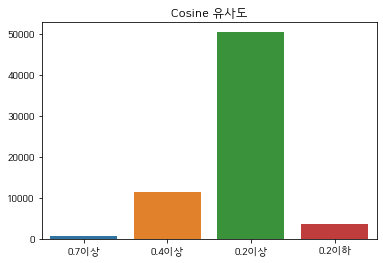

In [14]:
score_list3 = []

for j in range(len(title_list)):
    #idx = id2web['마물전담부대'] #마물전담부대 :  0번 인덱스
    idx = id2web[title_list[j]]
    sim_scores = [(i,c) for i,c in enumerate(cosine_matrix[idx]) if i != idx]
    #자기 자신을 제외한 영화들의 유사도 및 인덱스 추출

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True) #유사도가 높은 순서대로 정렬
    sim_scores[0:10] #상위 10개의 인덱스와 유사도 추출
    
#     sim_scores = [(web2id[i], score) for i, score in sim_scores[0:10]]
    sim_scores = [(score) for i, score in sim_scores[0:10]]
    
    score_list3.extend(sim_scores[0:10])

score3_high = []
score3_mid = []
score3_low = []
score3_2low = []

for i in range(len(score_list3)):
    if score_list3[i] > 0.7:
        score3_high.append(score_list3[i])
    elif score_list3[i] > 0.4:
        score3_mid.append(score_list3[i])
    elif score_list3[i] > 0.2:
        score3_2low.append(score_list3[i])
    elif score_list3[i] <=0.2:
        score3_low.append(score_list3[i])

        
print('0.7이상:',len(score3_high),', 0.4이상:',len(score3_mid),', 0.2이상 :', len(score3_2low),', 0.2이하:',len(score3_low))
        
import matplotlib.pyplot as plt

x = ['0.7이상','0.4이상','0.2이상','0.2이하']
y = [len(score3_high),len(score3_mid),len(score3_2low),len(score3_low)]

#한글 쓰기
plt.rcParams['font.family'] = 'HCR Dotum'
plt.title('Cosine 유사도')

sns.barplot(
    x= x,
    y= y
)

# plt.bar(x, y, width=0.4)
# plt.legend()
# plt.bar(x,y)

### 1순위의 유사도가 0.2 보다 낮은 웹툰

In [15]:
score_list4 = []
for j in range(len(title_list)):
    #idx = id2web['마물전담부대'] #마물전담부대 :  0번 인덱스
    idx = id2web[title_list[j]]
    print(web2id[j])
    sim_scores = [(i,c) for i,c in enumerate(cosine_matrix[idx]) if i != idx]
    #자기 자신을 제외한 영화들의 유사도 및 인덱스 추출

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True) #유사도가 높은 순서대로 정렬
    sim_scores[0:10] #상위 10개의 인덱스와 유사도 추출
    
    sim_scores = [(score) for i, score in sim_scores[0:1]]
    print(sim_scores)

    score_list4.extend(sim_scores[0:1])

마물전담부대
[0.36248193442010374]
불릿
[0.47136699021660944]
더
[0.34453422073270734]
각자의
[0.7911359892636686]
노선도
[0.39611638475901373]
말하는대로
[0.602720516944709]
연주동
[0.40924909028145084]
의도적
[0.43636700314918175]
맘마미안
[0.34373982550266535]
로맨스는
[0.4949752657970523]
대디고라운드
[0.6783567123325933]
도리내리
[0.3611080388407434]
아내를
[0.39085931082466263]
오늘또오늘
[0.30758624931606726]
토끼대왕
[0.43686879019996216]
복학생
[0.41337422390765605]
살人스타그램
[0.37571835853190305]
당신의
[0.35088957817484984]
스몰
[0.40183337028202626]
도를
[0.3796698688006366]
불티
[0.35832847300441595]
제7원
[0.464324863418744]
DEY
[0.5381770618359576]
금혼령-조선혼인금지령
[0.3591733549448159]
재혼
[0.39452610155397166]
당신의
[0.35088957817484984]
늑대가
[0.3908028042884322]
흥부놀부전
[0.638910411999913]
죽여주는
[0.6829975540228808]
뫼신
[0.3864120841110355]
셈하는
[0.4966711371352671]
소년,
[0.37566476560990913]
줄라이
[0.42643183288925485]
하슬라
[0.4384191571904919]
합격시켜주세용휴재
[0.38014977123990984]
감히
[0.4333526549662278]
인터셉트
[0.4339593105824819]
별종
[0.41104916874946656]
지금은
[0.

[0.4729419043624754]
서북의
[0.5585334993897115]
진눈깨비
[0.30468716806039897]
야채호빵의
[0.268015832684384]
죽음에
[0.4466345123057739]
모태솔로수용소
[0.3372599126566841]
2018
[0.39182256799493304]
스피릿
[0.4797716150252721]
ㄹㅇ
[0.39561469731372145]
이말년씨리즈
[0.5776248302737392]
퍼스트
[0.340712922923808]
하루
[0.5307544683755884]
환생동물학교
[0.436510533470686]
감염자
[0.5241540182541717]
지금
[0.4175640763880325]
고류
[0.6156824334906068]
연애학
[0.5359705810588775]
공대생
[0.19212431564497365]
내
[0.4278948058844648]
아기낳는만화
[0.3250937008759026]
심연의
[0.6391307082770898]
쌉니다
[0.391383278046827]
팀
[0.7234536779037777]
뱀이
[0.47039478586042727]
금수저
[0.6382330636617972]
여중생A-우리들의
[0.5681863186645035]
마스크걸
[0.47574286944940486]
10월
[0.3489328932787747]
Penguin
[0.4383856133908445]
한국만화
[0.44452078565903685]
첩보의
[1.0000000000000002]
우리집에
[0.45251438043887643]
미스터리
[0.42397060059646374]
오!주예수여
[0.41073084933715975]
기로
[0.4735074978885896]
탈(TAL)
[0.5731342812848208]
이별만화
[0.38649589246401267]
갸오오와
[0.34250738814690806]
한번
[0.36196440634

[0.5785463158946493]
고삼이
[0.47120992914031845]
길에서
[0.29452311094631306]
스마트폰
[0.5807221594662111]
스쿨홀릭
[0.4335354250766088]
이말년씨리즈
[0.5776248302737392]
후유증
[0.6483653524749642]
MLB카툰
[0.5138031228042826]
웨스트우드
[0.4131024923117772]
한
[0.40276582373922243]
삼봉이발소
[0.43838127682347894]
S라인
[0.49672766728460443]
2012
[0.537463713109693]
오란씨100
[0.27679632895719575]
네이버
[0.3481504250262907]
진진돌이
[1.0000000000000002]
옆집화랑
[0.3505320644673916]
방울토마토
[0.5707832499312699]
아부쟁이
[0.3571649702582461]
크레이지
[0.4114614375633782]
악당의
[0.3292305443812516]
2012
[0.537463713109693]
비바
[0.3486465806385257]
연
[1.0]
아스란영웅전
[0.48937013347608094]
봉봉오쇼콜라
[0.35883116420091304]
리버스
[0.46269387596434947]
한섬세대
[0.37998744340451207]
초록인간
[0.7368081001388109]
wish-마녀의
[0.541775774642203]
투명살인
[0.41961884904892377]
실질객관동화
[0.3863189193049647]
플라스틱
[0.5957737606445666]
자율공상축구탐구만화
[0.3403646059150853]
MODERN
[0.546863666508751]
질풍기획
[0.42524531324809517]
슈퍼트리오
[0.5547543651198658]
국가의
[0.4160924557935555]
별의
[0.3948144

[0.6781801728841712]
모죠의 일지
[0.37028527918655235]
튜토리얼 탑의 고인물
[0.6925716363452581]
급식아빠
[0.3703701351913813]
캐슬
[0.4587927978757895]
화산귀환
[0.30799454637281165]
남주의 첫날밤을 가져버렸다
[0.4238246932309674]
세상은 돈과 권력
[0.43864647768799714]
여주실격!
[0.44283980288236774]
노곤하개
[0.6751753055600864]
일렉시드
[0.40567769054298797]
나쁜사람
[0.6783567123325933]
블랙홀과 3만원
[0.19212431564497365]
연놈
[0.458063593220617]
고삼무쌍
[0.5386691757725663]
닥터앤닥터 육아일기
[0.3874106966660239]
66666년 만에 환생한 흑마법사
[0.38511610877918]
엔딩 후 서브남을 주웠다
[0.4674098387738257]
마른 가지에 바람처럼
[0.34083189347336207]
관종교장
[0.8127074124467374]
빌드업
[0.4853048498303792]
원수를 사랑하라
[0.42644452654536247]
하렘의 남자들
[0.4403499380791992]
판타지 여동생!
[0.4536344615190542]
격기3반
[0.4197444097788964]
언덕 위의 제임스
[0.4117147603506143]
괴물공작의 딸
[0.4459674602866339]
귀곡의 문
[0.37485578206944625]
사상최강
[0.2825812997387838]
오징어도 사랑이 되나요?
[0.3719005261761152]
조조코믹스
[0.8476856959577779]
방탈출
[0.4135369611743098]
무용과 남학생
[0.6609381699974733]
마녀와 용의 신혼일기
[0.4144834468466461]
새벽 두 시의 신데렐라
[0.

[0.3378157258930401]
구원
[0.3152202532413184]
나 홀로 버그로 꿀빠는 플레이어
[0.3533148365264264]
개목걸이
[0.4505011097534133]
논현동 장사꾼
[0.2231885695853264]
악한 기사
[0.3991267887258877]
환상의 아이들
[0.390827213868188]
그 책에 마음을 주지 마세요
[0.35178502296138175]
봄날의 팔광
[0.4254248048560309]
해피하우스
[0.3603256886853035]
크레센도
[0.6263957353819404]
무지개다리 파수꾼
[0.3873853494934452]
신의 태궁
[0.43169326660542395]
불러줘 내 이름만
[0.4816498648422328]
파륜아이
[0.49433623647720565]
주간소년열애사
[0.46014626360988187]
너에게 가는 거리 2091km
[0.5245712120153639]
플러스 마이너스 제로
[0.33318229266029803]
슬프게도 이게 내 인생
[0.3275831787376621]
정의는 죽지 않는다
[0.384384001715309]
이세계 전담반
[0.39775405070385017]
이상징후
[0.3547266984823496]
선택은 하나
[0.6604163522601054]
사랑하는 존재
[0.36525647947345763]
뱀파이어님의 대리식사
[0.6779859075660515]
쓰레기 머학생
[0.4112087785260098]
불합격인간
[0.3727294277215977]
감방에서 남자주인공을 만났습니다
[0.4483676641276365]
유부녀 킬러
[0.25604904394072364]
액괴
[0.4442910488012539]
바리공주
[0.7145160709221149]
내일도 출근!
[0.6036706733145001]
현세이의 보이는 라디오
[0.544679249390827]
집행자여
[0.354227164230

[0.451984390799862]
친구엄마
[0.6733994630758068]
조난! 에로로
[0.2884056251699381]
귀신
[0.4721112803713905]
셜록 : 여왕폐하의 탐정 2
[0.3791133844166689]
묘진전
[0.44537592830835143]
무빙
[0.589511022687736]
들숨날숨
[0.632512763444665]
지하철도의 밤
[0.47328079929355094]
파인
[0.22234058691246958]
윤의 죄
[0.37400206260612817]
연애가 제일 쉬웠어요
[0.4828964996894714]
하숙집 도로시
[0.638910411999913]
왈퐈
[0.5060855229231539]
데미지 오버 타임
[0.31855764225542565]
관찰인간
[0.3773761518871929]
PT맨 강코치
[0.33387786181963747]
나의 빛나는 세계
[0.5516946105342889]
오늘은 자체 휴강
[0.43923551153909995]
에스탄시아 3
[0.6311589952428898]
브레이커2
[0.8389866584544273]
늑대처럼 울어라
[0.46776114297840815]
괴담콜렉터
[0.3836759734619217]
안녕! 바북아
[0.7305822884317812]
에이스 하이
[0.37582493106362463]
상상고양이
[0.6229399825858934]
그녀와 32분의 1
[0.4067235844766304]
지킬박사는 하이드씨
[0.42831739623545656]
호구의 사랑
[0.6028695261372066]
순간
[0.5222288572388673]
괴물 같은 아이돌
[0.384009879032186]
이장본색
[0.3487089658802042]
연무
[0.3418706459384837]
PEAK
[0.2808182069876132]
개와 토끼의 주인
[0.4331710104223758]
로봇이 상냥해
[0.37659802

[0.5453802473394805]
모르모트 인 더 시티
[0.2791085178583584]
장난감의 사정
[0.6284969346122941]
한성 1905
[0.37999276844636487]
팬더댄스
[0.368597951526866]
은밀하게 위대하게2
[0.5454288482366515]
꽃처럼 산다
[0.3552300457381002]
공긔 엇더하니잇고
[0.27961036393922034]
지구 전세냈냐
[0.46200197238498764]
카산드라
[0.3279243658233409]
빌어먹을 것들
[0.51895703913869]
동거
[0.34718426214057413]
삼풍
[0.3254300509596383]
CCTV
[0.3399298939603758]
미 앤 아이
[0.47339174239006965]
설국열차 : 프리퀄
[0.35478483489255624]
라임 오딧세이
[0.36971138917816876]
우스 메이트
[0.4805677083912885]
짐승수컷고등학교
[0.34056131252696775]
벼랑 끝의 디저트
[0.6284969346122941]
오!솔로
[0.5359705810588775]
제 0시 : 대통령을 죽여라
[0.4634356231539873]
파수꾼의 왈츠
[0.5040354983431997]
0.1초의 설렘
[0.6097433205530227]
그루밍 선데이
[0.6480962847105302]
파이팅 스타
[0.34683583403912993]
올망동은 평화롭습니다
[0.4054958749542392]
트릭코드
[0.6013594364391589]
웨이크 업 데드맨
[0.5626078898678885]
노루
[0.3159492721728572]
굿모닝 사회인 야구
[0.31266492618272446]
고.흔.연
[0.4740847560303982]
용사에게 소중한 것
[0.39849609672945735]
미세스 선녀
[0.2936465018133274]
모든걸 걸었어
[0.3466

[0.5142831123802872]
너의 그 말
[0.4158680401505908]
검은머리 황녀님 [연재]
[0.3076020710238941]
바보개와 아가씨 [개정판]
[0.3939194196207695]
18세 새댁, 불륜합니다
[0.6239685695543158]
685일
[0.5232462111579176]
난 오늘 밤, 여동생과
[0.4397293081382865]
일단 뜨겁게 청소하라?!
[0.4662435649432137]
엘리베이터에서 하룻밤
[0.4351569097960909]
밝은 기억상실
[0.46933052044929735]
강의실 201호
[0.4498390959546261]
이세계의 황비
[0.36294024071531944]
다섯번째 혼인은 사양합니다 [연재]
[0.3933055862331924]
내 생애 최고의 늑대
[0.25717403642159575]
저 아이에게 키스와 흰 백합꽃을
[0.4528739747493583]
비밀스러운 짝사랑
[0.4645394339017779]
하나군과 사랑하는 나
[0.44519134412916217]
못난이에게 꽃다발을
[0.46147162191583074]
하나노이 군과 상사병
[0.5244494456723781]
다정한 공작님의 비밀 [연재]
[0.4644563901881538]
아디오스 에이프릴 [연재]
[0.5281650490403353]
깊은 곡선
[0.39716013075365897]
네가 쏟아지다
[0.450787489118248]
러브 인 디 오션
[0.5494603868654817]
러브 팬텀
[0.592899076546492]
하나와 히나는 방과후
[0.562318013122886]
사신의 연인
[0.41539808382924787]
압구정 몬스터
[0.5918741914588161]
딜리셔스 블러드 [연재]
[0.39917535550714844]
스파이스와 커스터드
[0.4056494211670938]
사랑은 개싸움!
[0.4815823441487579]
보스 오빠, 

[0.36781675482608084]
월하의 두 사람 ~더이상 없는 당신은 이 사랑을 용서하지 않겠죠~
[0.4162055026093578]
짝사랑 서점
[0.39175731837888683]
그녀와 썸남들 ~아홉수에 시작한 연애~
[1.0]
봉사감과 러브레터
[0.3944007070784866]
사랑이랑 밥이랑 무지개랑
[0.48435565894739135]
사랑은 키스 후에
[0.43401456400800603]
아름다운 그녀
[0.41323744777491017]
우타카타 다이얼로그
[0.5693856141009777]
절벽 위의 하나씨
[0.39292106092072354]
반했습니다, 선배
[0.4501474076171486]
웰컴 투 미미살롱
[0.3805135375726688]
망상보다 더 굉장한 거, 할래?
[0.5647086478692664]
키스보다 맛있어
[0.5316385213523606]
별과 달의 사랑
[0.3924976008642993]
날살(이요) 단편집
[0.33790954240123916]
상아 [개정판]
[0.32972841418863247]
가슴이 떨리는 건 너 때문
[0.3962843516780455]
너는 내 최애가 아니야
[0.38396921547521395]
내 눈엔 너만 보여
[0.48617589953607265]
뭐랄까, 사랑이잖아?
[0.4094011048263846]
변덕쟁이 오렌지로드 애장판
[0.4300067753841995]
태주씨의 완벽한 결혼생활
[0.514405419978332]
나무 한 그루
[0.3999759892702107]
내 처음을 너에게 줄게
[0.422211928369362]
키스로 시작하는 위험한 방과 후
[0.4139255179664959]
환상게임
[0.35898936567678874]
두번째 첫사랑
[0.5869199048624626]
라스트 게임
[0.4168612289623201]
군청 리플렉션
[0.41509052088793047]
쇼트 케이크 케이크
[0.299395162

[0.4648825610296563]
더럽혀진 천사-교복 속의 비밀-
[0.4427257414098481]
너와 나의 거리, 80cm
[0.394103328203088]
늑대 왕자님의 분부대로
[0.3690123758029944]
구미호와 동거중
[0.3925544187676323]
처음 뵙겠습니다.
[0.31453310262552003]
우리 시작은 결혼?!
[0.4430693520615588]
선생님 따위 진짜 싫어!
[0.6218970081652588]
미드나잇 파트너
[0.3514633533031647]
아빠가 남자로 바뀔 때
[0.46670625916103825]
다이쇼 로맨티카
[0.4602798134044934]
키스 프렌드 -키스로 물드는 첫사랑-
[0.4439930608399046]
고백할 상대를 착각했습니다
[0.43845160627011154]
세상이 끝나버릴 것만 같은 키스를 해줄게
[0.6650446237279588]
연애레슨 시간입니다
[0.570120487076606]
짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~
[0.40227021073974834]
어린 양 플레이~짓궂은 사랑법~
[0.4048231505634691]
옆방의 늑대 군
[0.4072878275979835]
내일도 너를 좋아할 거야
[0.4262094555029369]
너를 한입
[0.41717031696054757]
어른이 사랑을 끝내는 법
[0.4413510906154583]
허니 스위트 키친
[0.5351908036045759]
바이바이, 사랑해
[0.44910297428458684]
아포카토
[0.3418310229951026]
지령과 키스
[0.37581222578993373]
밀크티
[0.4299805275229264]
선생님은 나의 것
[0.4346892555550687]
너의 죄를 달콤하게 녹이고
[0.239869999480219]
몰락 왕자의 달콤한 키스
[0.4661670967201792]
늑대 공작의 구혼
[0.346744646104812

[0.4550486501611069]
진격의 거인
[0.4465945661301874]
저승GO
[0.4124699167877455]
흔해빠진 세계관 만화 II
[0.37947688781738015]
무련전봉 [연재]
[0.4056371738718001]
나의 그녀는 구미호 (무삭제판)
[0.3886056497264806]
어바웃 제인
[0.3312051082994048]
펀칭머신
[0.3818599200171535]
새벽을 얽매는 뱀 - 흔세만 스핀오프 2
[0.4780853322143721]
단다단 [연재]
[0.3608790754989022]
왕비가 된 외과의사
[0.4166888352126493]
용의 아들 최창식
[0.3747220269943183]
도와줘요, 이비씨!
[0.5242961980122489]
흔해빠진 세계관 만화
[0.4423045397170929]
구원하소서
[0.40309829205288367]
달토끼와 안드로이드
[0.5153414546090868]
레드 후드 Red Hood
[0.42774797423122385]
죽은 장미의 전장 - 흔세만 스핀오프 3
[0.4137875775952793]
나의 히어로 아카데미아
[0.5431550918902117]
아스타드 왕립유랑극단 - 흔세만 스핀오프 1
[0.3710079546956372]
원피스
[0.39552482747552337]
마법사의 아이
[0.3984418672403141]
섀도 하우스 [연재]
[0.2898285808891732]
킹덤
[0.3438283613755996]
TYPE-MOON 학교 치비츄키!
[0.3245964260416505]
전설의 읍내최강
[0.43749909021303596]
어둠이 스러지는 꽃
[0.4771272921744657]
블랙 서바이벌 - Bottomless Pit
[0.3838245431891018]
달이 속삭이는 이야기
[0.5006098394091499]
백도사
[0.49557143837233525]
이렇게 귀여운 간첩은 어디에 신고하나요

독고 플라워
[0.2655883920097737]
버츄얼 패밀리
[0.7358760732104641]
싸움의 기술 2
[0.3613507813205267]
마오 [연재]
[0.38702553830549163]
리프루터
[0.42405525891405593]
인간 불신 모험가들이 세계를 구하는 듯합니다
[0.44447202133868174]
고깔모자의 아틀리에
[0.6445899262891732]
너의 기억 ~나를 돌려줘~
[0.3716581820940339]
남장여자지만 모두가 여잔 걸 아는 그런상황이랄까
[0.35024590613905066]
인어공주의 미안한 식사
[0.5213302327902641]
절세무신 [연재]
[0.4142506879800806]
메리지 블루
[0.40377254014730135]
미스터리 마스터
[0.3140747409002051]
밥수저 들고! [연재]
[0.40436493416679153]
9레벨의 열람요원 [연재]
[0.6925716363452581]
인간이 없는 나라
[0.3647497114314633]
도서관의 대마법사
[0.38909664149288303]
코스믹 콘키스타
[0.4358314999698929]
블루윙 [연재]
[0.5976799651452885]
찬! 평범한 그녀석
[0.4216643503871168]
소녀종말여행
[0.47796501784649437]
열혈전사의 부활 - 헌터학원 [연재]
[0.3878388984808029]
꼴데툰 2019
[0.40785032047586306]
모브사이코 100
[0.3968589553062443]
인헤일
[0.5382807412245558]
야수의 노래
[0.3065915251409426]
고바야시댁의 메이드래곤
[0.19212431564497365]
유가미 군은 친구가 없다 [연재]
[0.38062358033276655]
여동생은 로봇
[0.5108058797095969]
꼴데툰 2020
[0.3949785268365321]
원고를 주세요!
[0.430729109

[0.4513096152865851]
소원큐브
[0.4659322696696608]
류마의 아호
[0.4544353549049388]
데스캔들 -죽음의 집행자-
[0.36285968389701295]
다테인간
[0.3219558021383387]
용의 귀여운 일곱 아이
[0.3420146931061488]
왕자와 마녀와 공주와
[0.5270788497992904]
디멘션 W
[0.4702778228238864]
구팀장은 남신
[0.3704066819868294]
풀문 인게이지
[0.44274522467122723]
마나카의 숲
[0.3781486484718242]
내 신랑이 너무 어려
[0.39440922427429087]
DNA는 가르쳐주지 않아
[0.37954328417538424]
디펜스 데빌
[0.4668783647300359]
용랑전
[0.33729602075088416]
장미의 성흔
[0.4630471434709829]
풍운 4부
[0.3388652694604175]
꽃미남 어린이집
[0.28003058834165073]
괴짜 하우스는 지금 만실
[0.40892283590792056]
공주님을 프로듀스
[0.6566247229726458]
용의 학교는 산 위에
[0.32315166749584956]
서유기 플러스 어게인(PLUS AGAIN)
[0.351392187680351]
천상의 운명
[0.37812156256121104]
백기야행
[0.35248506632249077]
탑스타의 시크릿
[0.5081334244179592]
난쿠루
[0.39568197733785115]
이프 시즌1
[1.0000000000000002]
펫숍 오브 호러즈 파사쥬 편
[0.5635417171511141]
도깨비 언덕에 있어
[1.0]
누나는 항상 곁에 있고, 세상은 별일 없이 돌아간다.
[0.38944588033131233]
미아상점
[0.38746137214174425]
야미큔!
[0.3474666379609353]
단장
[0.4618300609963465]
전학생

[0.4181724987322213]
DAYS(데이즈)
[0.6938468689872945]
히어로 매니저[개정판]
[0.3115562829545031]
내가 하면 짝사랑
[0.41791290607525733]
아베가 저를 노리고 있습니다
[0.39818844085254196]
도시괴담
[0.40820933122779485]
봄을 기다리는 우리들
[0.4870837125444662]
야쿠자의 대두목이 유녀로 환생한 이야기
[0.3716119145193956]
약사의 혼잣말(코믹)
[0.31013557736540576]
술 한잔 인생 한입
[0.5239470074772016]
요시노즈이카라
[0.5784467969512401]
생존주의
[0.4384970168058302]
34세 무직씨
[0.3378546130225742]
초년의 맛
[0.3126658850860877]
매분구
[0.423551617708563]
메꽃 ~오후 3시의 연인들~
[0.4398596842714197]
나의 아빠
[0.4463253478774084]
오늘도 항해
[0.4147458477557803]
날씨의 아이(코믹)
[0.5547395241613777]
고양이화가 주베의 기묘한 이야기
[0.3774757621829793]
동거인은 무릎, 때때로 머리 위
[0.28944305777449214]
이게 무슨 일이야?[개정판]
[0.434225940737354]
안쌤의 시카고 일기
[0.41174819114031974]
마당 씨의 가족 앨범
[0.4391786641314089]
재벌 라이프 [연재]
[0.40437581470321327]
언밸런스X3
[0.42702284535173]
신부간택 ~대부호와 108명의 후보~
[0.6239685695543158]
꼬르륵 배고픈 남자들의 밥
[0.658952138327226]
오만과 낭만
[0.40672692653643067]
미스터리라 하지 말지어다
[0.45251438043887643]
튄 공
[0.46644327344136266]
데명의 그림일

[0.43648514787931925]
여자고등학생
[0.43479388154841225]
7의 잔재
[0.37698255043635553]
메이지 비색기담(메이지 시리즈1부)
[0.4030209529221119]
H2 오리지널
[0.4399408796044241]
카페알파
[0.36087726750239224]
멍멍이와 주인님
[0.5437262182864158]
여기는 지금부터 윤리 시간입니다.
[0.38736833738200865]
사춘기 비터 체인지
[0.5140136216406725]
소년탐정 김전일 흡혈귀전설 살인사건
[0.3773467606413904]
선술집 탐정
[0.3671552242432982]
히카리맨
[0.32577047011938987]
우리는
[0.44325839059853533]
디어 (dire)
[0.4110429700355387]
29세, 7살 연하와 사랑할 수 있을까
[0.42497329809601303]
왕게임 - 기원
[0.6152790246486441]
우동 나라의 황금색 털뭉치
[0.5166235118487147]
복슬복슬 신령님 찾기
[0.47039478586042727]
7억 엔을 받으면~리벤지~
[0.38404186860153955]
시가렛 & 체리
[0.42617973162958195]
소년탐정 김전일 - 아케치 경시의 우아한 사건수첩
[0.40720432502722187]
보이지 않는 사람
[0.5316385213523606]
차를 마시자!!
[0.37892747230947915]
인간 더비~돈의 욕망에 사로잡힌 엄마들~
[0.42498764240001563]
내 부인은 16살
[0.3851782024940695]
너는 펫
[0.3759072011181174]
달이 뜨면 만나요
[0.37510621438173286]
고키챠
[0.39666932130202354]
어덕행덕
[0.40876168154080517]
칼데라
[0.3975131839696738]
아야카시코
[0.38625573060693774]
아저씨와

[0.4326924840215387]
기묘한 플로리스트
[0.38905033035009723]
허식당
[0.5560190698860744]
몽외몽
[0.41210504892733163]
코바토
[0.46152026875733265]
카코와 가짜탐정
[0.4326924840215387]
너와 나
[0.48156140567623185]
연공
[0.4788962908089427]
평범해지고 싶어
[0.41717031696054757]
인어가 사랑하는 방법, 사랑받는 방법
[0.4501499892354015]
하네츠쿠 소녀
[0.3788538546095432]
쇼보냥
[0.5858674160212786]
문센의 여왕
[0.5073531223102752]
신부의 바람
[0.3682873434883559]
레이디 앤 젠틀맨
[0.4549887357572211]
동네 한 바퀴
[0.590348095859382]
파이팅! 오줌싸개 고양이 쇼보냥
[0.3266856992051384]
그녀의 발칙한 망상 [베리즈]
[0.359235047204965]
아뢰옵기 황송하오나
[0.3464858351436664]
피아노 벌레~천재 조율사 히루타~
[0.43000568048152304]
도마 위의 전쟁
[0.2549598640913216]
별의 안내인
[0.3909786737460585]
사인(Sign)
[0.40129769268722687]
그그그
[0.41793607742713174]
두 얼굴의 아씨
[0.33270575983542616]
피앙세 대소동
[0.4154267645279214]
전하는 말
[0.4778241495831751]
연인계약 지침서
[0.3562932277322904]
하이누즈카 집안의 사남
[0.49998329370992356]
네코비타시
[0.5858674160212786]
폭신폭신파이널~이래서 고양이는 그만둘 수 없다~
[0.6624190371143972]
우렁이라도 좋아
[0.38719791551868643]
메이지 멜랑콜리아(메이지 시리즈 2부)
[0.

[0.3955408034017187]
하트 스테인 [연재]
[0.5242393394572482]
단금지교
[0.3422479755869679]
구룡특급
[0.39513000507892154]
브릴리 [개정판] [연재]
[0.39654703298389493]
우리 집 살인마
[0.41213939379946335]
좋아한다는 걸 잊지마
[0.4618973426320715]
죽여주는 복수선언
[0.44756823551582453]
너와의 거리
[0.45259745776968086]
체험! XX의 현장[개정판]
[0.5423863106912841]
어는 점
[0.2728827738200342]
단 하나의 여름
[0.38236917453047276]
캔디맨
[0.4184313080579202]
불가역 [연재]
[0.3559291639985233]
바람이 머무는 자리 [일반판] [연재]
[1.0000000000000002]
도깨비도 수풀이 있어야 모인다[개정판]
[0.39665590064754885]
용의 부군-망국의 신-
[0.33025250879266094]
인 마이 클로젯
[0.7106737797221566]
흉악범과의 면담
[0.38595719030065834]
귀애-눈꽃에 새기는 약속 [연재]
[0.5545558459062068]
저기요, 황태자님!
[0.3952349223545695]
자꾸 그러시면 저 녹아요. [연재]
[0.38421087026261735]
물거품 연인
[0.33645051287285427]
새빛남고 학생회 고문입니다 [개정판]
[0.39802132935617396]
기대지 마시오 [연재]
[0.37657200659112056]
여우크림타르트
[0.3731022548407987]
인아웃 [연재]
[0.3352111037222023]
다녀왔어, 어서 와 -쉬어 가기-
[0.37467251711572686]
원테이크
[0.4823108787999341]
최강의 냄새
[0.8292841500551162]
검은 깃털의 흉터
[0.43052732990

[0.44467778201424846]
베이스 투 베이스
[0.42398970668243485]
GLOW!
[0.4167196138309832]
몬스터 푸치 패닉
[0.42805056277423376]
소나기처럼, 다시
[0.33428587262392345]
아무런 말도 없이
[0.4184789965668655]
너라는 녀석은 이렇게나
[0.4235612001946872]
여름에 풀린 사랑의 비밀
[0.5163277609163368]
그늘 핀 들꽃
[0.3726224288111584]
너라서 다행이야
[0.46330243930820714]
유리 체온 증후군
[0.4378508015797433]
짝사랑의 동맹
[0.2799977447935339]
숨을 죽이고, 사랑을
[0.42908193885742685]
할부로 해주세요, 마왕님!
[0.3858350321384598]
비하인드 스토리
[0.669107147323033]
사랑은 반짝
[0.9300250663927441]
맞은편 방의 고양이
[0.508808847652218]
부장님은 언니
[0.3672514657247248]
짙은 어둠 속에서 너와,
[0.4456127267037857]
밀명
[0.3660709710413322]
마이 리틀 도기
[1.0]
공심연인
[0.4879385460849683]
내 세상은 너로 가득해
[0.4685602006634095]
햇빛이 들린다
[0.6540068656753213]
첫사랑은 귀엽지 않다
[0.38058730218617737]
담색의 나날
[0.42935336770451504]
너는 여름 안에
[0.3742690943614543]
코지카 군과 비둘기 교수님
[0.3267900179293534]
맑음 후 사계부
[0.39270920520744457]
실버 다이아몬드
[0.3432997524935359]
경화연
[0.35379468926492424]
악마의 신부 만들기 1부
[0.4688130677297983]
셋이서 할까요?
[0.4036696285276443]
이제 그

[0.39289354438050905]
남자의 본분!
[0.47378113245637576]
뮤즈에게 축복받은 자 ~liebeslieder~
[0.4202825317029052]
선배와 나의 기묘한 데이트
[0.33294800542444314]
우리는 여기서 사랑할거야
[0.3776857907152837]
스닙, 스네일&도그 테일
[0.5579080249477149]
커피남자에게 시럽을
[0.4435609715956947]
사실은 좋아해
[0.3290101983673646]
흔들리는 씨앗
[0.37362706316025296]
니와군의 사랑의 폭주
[0.43375042964317734]
달콤한 손바닥
[0.4558003676598102]
마법청년 니시다군
[0.36435974227225704]
야모리 선배랑 같이 사는 것도 괜찮을 듯
[0.3807788534735586]
양호실에서 날 안아줘
[0.41542752265081073]
벽 속의 천사
[0.4994063546224669]
너의 몸에 부드러운 키스를
[0.3441289506977461]
짙은 [개정판]
[1.0000000000000002]
보건실은 출입금지
[0.42922055408610765]
한번뿐인 사람
[0.47784013370658823]
아사나는 스트레이트가 아냐!
[0.3347238721737716]
선생님, 다시 한 번 들려주세요
[0.43746643212147246]
사랑을 지저귀는 카나리아
[0.40518413110488544]
소년은 내일을 죽인다
[0.503157534952806]
꽃이 될 수 있다면
[0.4404016134612393]
아름다운 것
[0.4037474378008354]
미남 카즈라의 정원
[0.4208176149203263]
검은 고양이의 우울
[0.7466791582924517]
MO`SOME STING (모 썸 스팅)
[0.49917578852250893]
Cheer Up!
[0.48957134859268026]
한정된 사랑
[0.4296159698653317

[0.3323060256704145]
충사
[0.3714942816340712]
남첩
[0.884071692860233]
인사하고, 키스
[0.48655614078456255]
메이저
[0.5952432704978773]
일하고 싸우고 사랑하라
[0.3952624480009114]
광한루 로맨스
[0.3873352275970829]
가깝다고 생각하면 가까운
[0.36671056543968295]
너와 사는 그 집
[0.42667689674528064]
묵검향 기행천하 컬렉션
[0.4655786553919329]
사랑 이야기를 들려주세요
[0.6692622154515964]
사랑 선고
[0.24236742609858]
너의 마법이 닿으면
[0.4239981959937586]
잔상만이 남은 그곳에
[0.3528629330941779]
고백을 못하고
[0.5227998668715659]
파운딩
[0.3952995514394483]
황성 마왕강림 컬렉션
[0.4044552737613426]
파라오의 연인
[0.20804209975357363]
폭군의 은밀한 시선 컬렉션 [할리퀸]
[0.317578772130974]
야설록 살수대협 컬렉션
[0.5925166191194513]
미스테이크 러버
[0.4365652800421043]
향유경
[0.32087175512426097]
샬롯의 편지
[0.37117477231988155]
귀혼식 [BL]
[0.5521705006240242]
청춘은 흐른다[완결]
[0.4463894904184741]
내 자기님이 로그인 하셨습니다
[0.4214199932292559]
인생이 마음대로 되지 않는 26살 이야기
[0.6163241965194652]
위장여친 [GL]
[0.2734052296744304]
극한고딩
[0.5075331068011324]
덫에 걸린 아가씨 컬렉션 [할리퀸]
[0.4162058626876485]
바로크 기사단
[0.5909017890666465]
교인비담
[0.3913884242211894]
공포의 외인구단
[0

[0.6054486993493804]
우리 집에 왜 왔니
[0.5715347227048219]
뜨거운 웬수
[0.4207498173829711]
여름 소나타
[0.4146652205859931]
마지막 좀비
[0.6022811703340213]
사랑하는 사람이 생겼습니다
[0.47373948225123963]
도장을 찍어주세요
[0.4239981959937586]
거짓말, 뱀파이어가 어디 있어? [BL]
[0.4071151148019978]
내겐 너무 완벽한 그녀 컬렉션 [할리퀸]
[0.3796511216778283]
황성 마도천하 컬렉션
[0.6964407801710684]
악녀의 정의
[0.31419868277791785]
엔젤 버디 [BL]
[0.6793555993800855]
서브미션
[0.44466086807705785]
사막의 신부
[0.6804258354712394]
꽃을 든 여자[개정판]
[0.5157579273102021]
2반 이희수
[0.591264307280928]
폭주검찰 1부 [개정판]
[0.3646009507242618]
히로이나
[0.4486486218603241]
우렁강도
[0.41992733373903895]
수명사
[0.31043300674815405]
애신록
[0.41463618913229394]
난 뭘로 보여?
[0.4039845663216047]
황성 무림막장 컬렉션
[0.36104154803666244]
어쩌다 발견한 신부 컬렉션 [할리퀸]
[0.4633666677160524]
그가 있는 집
[0.9244554979139443]
GLEN(글렌)
[0.3660568969894803]
디어 마이 유니버스
[0.3798461560364506]
내 취향 안경 거치대
[0.4015892514775103]
갓블레스유
[0.3691157389095721]
두근두근 사내 연애 [BL/완결]
[0.38856746555681715]
이성연애박사
[0.8421416155702934]
시간선
[0.37264926973515966]
절세요제


In [19]:
cnt = 0

for i in range(len(score_list4)):
    if score_list4[i] < 0.1:
        cnt +=1
        
print('1순위의 유사도가 0.3 보다 낮은 웹툰 :',cnt,'개')

1순위의 유사도가 0.3 보다 낮은 웹툰 : 0 개


### 장르별로 구분하기

In [18]:
for j in range(len(title_list)):
    #idx = id2web['마물전담부대'] #마물전담부대 :  0번 인덱스
    idx = id2web[title_list[j]]
    print(web2id[j])
    sim_scores = [(i,c) for i,c in enumerate(cosine_matrix[idx]) if i != idx]
    #자기 자신을 제외한 영화들의 유사도 및 인덱스 추출

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True) #유사도가 높은 순서대로 정렬
    sim_scores[0:10] #상위 10개의 인덱스와 유사도 추출
    
    sim_scores = [[web2id[i], score] for i, score in sim_scores[0:10]]

    
    for k in range(10):        
        title = sim_scores[k][0]

        series = web_combined['title'] == title
        index = series.tolist().index(True)
        
        sim_scores[k].append(web_combined['platform'][web_combined['title']== title][index])
        
    print(sim_scores)
                                       

마물전담부대
[['던전 속 사정[개정판]', 0.36248193442010374, '레진코믹스'], ['김무녀는 무녓무녓해!!', 0.33273596828238416, '레진코믹스'], ['괴기목욕탕', 0.31622551566699286, '레진코믹스'], ['괴기목욕탕 시즌2', 0.2921771992033204, '레진코믹스'], ['보석의 나라', 0.18833839867163477, '레진코믹스'], ['게딱지', 0.18833839867163477, '레진코믹스'], ['도깨비 언덕에 있어', 0.18833839867163477, '레진코믹스'], ['레코닝', 0.09240483466861119, '네이버 웹툰'], ['인챈트-나람이야기', 0.06153026858078363, '네이버 웹툰'], ['난약', 0.059434867256891497, '네이버 웹툰']]
불릿
[['아오라', 0.47136699021660944, '레진코믹스'], ['집사의 환상카페', 0.4403816241850823, '레진코믹스'], ['잘 먹겠습니다와 다녀왔습니다와', 0.3597460801679756, '레진코믹스'], ['어덕행덕', 0.3592202252021345, '레진코믹스'], ['인피니티', 0.35366114372506746, '네이버 웹툰'], ['고백', 0.34418893978384474, '다음 웹툰'], ['퍼펙트 게임', 0.34274702852259886, '다음 웹툰'], ['레이드', 0.32951913662656734, '카카오 페이지'], ['50픽셀 데이즈', 0.3249626212263255, '다음 웹툰'], ['MLB카툰', 0.3247720718160915, '네이버 웹툰']]
더
[['서울 불시착', 0.34453422073270734, '레진코믹스'], ['시월드 판타지', 0.3299147184631359, '네이버 웹툰'], ['꼬리', 0.31840304093782357, '네이버 웹툰'], ['정령사: 나타

[['님과 함께', 0.37566476560990913, '레진코믹스'], ['모브코의 사랑', 0.35695853386631227, '레진코믹스'], ['P와 여고생', 0.33779980674865784, '레진코믹스'], ['나에게 온 달', 0.3363621286132215, '레진코믹스'], ['공주님을 프로듀스', 0.3360415192396846, '레진코믹스'], ['시간을 멈춰서 너에게 나쁜 짓을', 0.3321496298438598, '레진코믹스'], ['노을을 거닐다', 0.33104601404107703, '레진코믹스'], ['신과함께', 0.3301887206763443, '네이버 웹툰'], ['서는 여자[개정판]', 0.3279939554548646, '레진코믹스'], ['나쁜사람', 0.3253136325260899, '네이버 웹툰']]
줄라이
[['아름다운 그대에게', 0.42643183288925485, '레진코믹스'], ['머리 위로 부는 바람', 0.4110179118398118, '다음 웹툰'], ['끼니 때! ~그대와 한지붕 아래~', 0.388323738997356, '레진코믹스'], ['달리는 여자', 0.38781297258750125, '다음 웹툰'], ['버텨내라 김숙희', 0.3753585518388987, '레진코믹스'], ['펫다이어리', 0.37228728068954137, '네이버 웹툰'], ['광고회사, 남자기숙사의 오카즈', 0.3700035566924766, '레진코믹스'], ['귀차니스트 남자가 아침에 일어나니 여자가 되어 있었던 이야기', 0.35779739472986877, '레진코믹스'], ['여름방학, 임시 아빠가 되었습니다 [로제]', 0.35152786025991634, '레진코믹스'], ['공백기', 0.34199030460945956, '레진코믹스']]
하슬라
[['황룡전 개정판', 0.4384191571904919, '카카오 페이지'], ['시선 끝, 30도', 0.402816011

[['한림체육관', 0.5120890798222933, '네이버 웹툰'], ['청년시장', 0.4680441270597362, '카카오 페이지'], ['걸어서 30분', 0.41401179703115765, '네이버 웹툰'], ['새와', 0.3325742597340724, '네이버 웹툰'], ['갓 오브 하이스쿨', 0.32782224132636206, '네이버 웹툰'], ['언더프린', 0.3065380846790532, '네이버 웹툰'], ['그 남자, 운명이니까', 0.2975866149897657, '레진코믹스'], ['9레벨의 열람요원 [연재]', 0.29663427645213003, '레진코믹스'], ['어바웃 제인', 0.28155396001014044, '레진코믹스'], ['빌더', 0.27666959796402185, '레진코믹스']]
용련
[['용사가 죽었다!', 0.40765198223153026, '레진코믹스'], ['푸른사막', 0.3381240785551515, '네이버 웹툰'], ['고3여교생', 0.15911956258113016, '레진코믹스'], ['허브캔디 1부', 0.15911956258113016, '레진코믹스'], ['숨은 사랑 찾기', 0.15911956258113016, '레진코믹스'], ['또한번', 0.10041901527082318, '네이버 웹툰'], ['35cm휴재', 0.0936216089648126, '네이버 웹툰'], ['2015', 0.08417096876935105, '네이버 웹툰'], ['첫사랑입니다만', 0.08241016291094183, '네이버 웹툰'], ['2D남친', 0.08222557409452469, '네이버 웹툰']]
상연
[['원', 0.36975517603982966, '네이버 웹툰'], ['모태솔로수용소', 0.3390053864978209, '네이버 웹툰'], ['팀', 0.3171840728249971, '네이버 웹툰'], ['코드네임 카마엘', 0.306704715159

[['보글보글', 0.4271844617724782, '네이버 웹툰'], ['요정을 아십니까?', 0.3799574326550075, '레진코믹스'], ['공부하는 고양이', 0.31717833824349706, '다음 웹툰'], ['하필 너야?!', 0.299067539946682, '다음 웹툰'], ['상상고양이', 0.2916640183573546, '다음 웹툰'], ['고양이 장례식', 0.2830789020694315, '다음 웹툰'], ['아사의 강', 0.2826705527648567, '레진코믹스'], ['냥냐라냥냥', 0.2736713521221874, '다음 웹툰'], ['네가 나에게 들려주는 이야기', 0.26724222563903294, '레진코믹스'], ['볕내', 0.2661672312134075, '레진코믹스']]
불발소년
[['찬란한 액션 유치원', 0.44432307524349834, '다음 웹툰'], ['사장님은 이제 제 겁니다-늑대 비서의 하극상-', 0.3913994659389861, '레진코믹스'], ['심야의 오피스 스캔들 컬렉션 [할리퀸]', 0.3770915632914072, '카카오 페이지'], ['찬란한 액션 유치원', 0.3749275072259056, '다음 웹툰'], ['최강의 냄새', 0.3648725916532183, '레진코믹스'], ['청춘, 실격', 0.36325355940418014, '레진코믹스'], ['1학년 A반의 몬스터', 0.35728053346748845, '레진코믹스'], ['사랑과 평강의 온달!', 0.3503801427757214, '네이버 웹툰'], ['블로섬 데이즈', 0.345344643559731, '카카오 페이지'], ['최강의 냄새', 0.34391602640742736, '레진코믹스']]
경비
[['잠깐만 회사 좀 관두고 올게', 0.549075640504738, '레진코믹스'], ['크로싱 코드', 0.43568896298701154, '레진코믹스'], ['키드갱', 

[['비스타', 0.41067480449422067, '네이버 웹툰'], ['환생하여 배우님 유혹하기 [연재]', 0.38717210231845567, '레진코믹스'], ['달빛천사', 0.36412376537925156, '레진코믹스'], ['B형 남자에게 휘둘리고 있습니다', 0.3532156523183271, '레진코믹스'], ['곱배기 연애', 0.345196032384169, '레진코믹스'], ['비애선언', 0.34472035513105603, '레진코믹스'], ['하필 너야?!', 0.34342911596901066, '다음 웹툰'], ['아는 귀신', 0.3345407158138585, '레진코믹스'], ['약사의 혼잣말 ~마오마오의 후궁 수수께끼 풀이수첩~', 0.32956903834231543, '레진코믹스'], ['왕자님 나의 왕자님', 0.32286640774004904, '레진코믹스']]
너에게만
[['내', 0.39862448520940613, '네이버 웹툰'], ['별안간 아씨', 0.3572764922025839, '레진코믹스'], ['별안간 아씨', 0.34778358273455223, '레진코믹스'], ['방울토마토', 0.32270106020429934, '네이버 웹툰'], ['꿈을 안고 내일로', 0.3196761054880338, '레진코믹스'], ['소년의 기록', 0.30488865842445817, '네이버 웹툰'], ['난 있잖아 넌 없잖아', 0.2985070657780788, '레진코믹스'], ['안녕! 바북아', 0.29081167022227256, '다음 웹툰'], ['키스 블루', 0.280499085284351, '레진코믹스'], ['라비린토스', 0.27841831786045285, '카카오 페이지']]
이것도
[['청춘극장', 0.5402334911666191, '다음 웹툰'], ['3단합체김창남', 0.4220092518616405, '네이버 웹툰'], ['미친녀석', 0.400740265776067

[['커피도둑', 0.4481020614917186, '네이버 웹툰'], ['특수', 0.370766674342539, '네이버 웹툰'], ['면사포를 쓰고픈 남자', 0.34106530296526405, '레진코믹스'], ['코바토', 0.33745817793924243, '레진코믹스'], ['야설록 강호외사 컬렉션', 0.3215717521992539, '카카오 페이지'], ['애정 결핍의 처방전 [개정판]', 0.3020913525888236, '레진코믹스'], ['달토끼와 안드로이드', 0.3016665577302734, '레진코믹스'], ['누군가의 로섬', 0.2927424315402981, '네이버 웹툰'], ['금혼령-조선혼인금지령', 0.2827639659179627, '네이버 웹툰'], ['오늘도 꽐랄라라', 0.28025004294151906, '다음 웹툰']]
인싸라이프
[['누드를 입은 유성', 0.32814297824112526, '레진코믹스'], ['CITY(시티)', 0.324036059175674, '레진코믹스'], ['군주', 0.321956742816204, '네이버 웹툰'], ['궁서의 약속 -위장 Ω(오메가)- [연재]', 0.3129982888730498, '레진코믹스'], ['흰선의 저편', 0.3105544970427384, '레진코믹스'], ['원테이크', 0.30438334669899897, '레진코믹스'], ['앞집의 시간표', 0.30379787495325106, '레진코믹스'], ['중증외상센터 : 골든 아워', 0.2927775601028863, '네이버 웹툰'], ['약속은 할 수 없어요', 0.2927775601028863, '레진코믹스'], ['보건실은 출입금지', 0.2862308695217527, '레진코믹스']]
에리타
[['연의', 0.43019398313655927, '네이버 웹툰'], ['데이빗', 0.4001275288625177, '네이버 웹툰'], ['HAPPY TOGETHER (해피 

[['프로의 탄생', 0.4241756622080662, '레진코믹스'], ['아홉수 우리들', 0.3378841450095758, '네이버 웹툰'], ['할부로 해주세요, 마왕님!', 0.30107760007290457, '레진코믹스'], ['사랑의 SOS[BL]', 0.290752285568732, '카카오 페이지'], ['블랙 베히모스', 0.27168355802977023, '다음 웹툰'], ['파워!!', 0.2693266968895305, '레진코믹스'], ['해바라기 -켄이치 전설-', 0.2632293346897885, '레진코믹스'], ['2018 다음웹툰 능력고사', 0.2554206017684799, '다음 웹툰'], ['빨간머리의 페니', 0.2543611608312713, '레진코믹스'], ['아버지의 복수는 끝이 없어라', 0.25390850340514337, '다음 웹툰']]
운수
[['환상적인', 0.4801830183061402, '네이버 웹툰'], ['타인은', 0.4003167824400533, '네이버 웹툰'], ['도무지 그애는', 0.34281480031346845, '네이버 웹툰'], ['알콩달콤 로맨스 시리즈', 0.31699256671350684, '레진코믹스'], ['탐정 메모리즈', 0.3028061360935627, '레진코믹스'], ['러브 인 디 오션', 0.2984214941699554, '레진코믹스'], ['아무것도 하고 싶지 않아', 0.2804268370065346, '레진코믹스'], ['이상한 너를 맞이하며 [개정판] [연재]', 0.2792415232796078, '레진코믹스'], ['고양이보다 사랑스러워', 0.2772399864465822, '레진코믹스'], ['토니와', 0.2763924999180452, '네이버 웹툰']]
그녀의
[['그 키스의 의미를 가르쳐줘', 0.3904859632144204, '레진코믹스'], ['GㆍDEFEND (지 디펜드) [개정판]', 0.34476577733

[['어른들의 크리스마스', 0.44027723160244925, '레진코믹스'], ['안녕', 0.4271844617724782, '네이버 웹툰'], ['12월', 0.4244182918284923, '다음 웹툰'], ['신장개업', 0.4186402406691562, '레진코믹스'], ['소녀', 0.3968360070095643, '네이버 웹툰'], ['오늘도', 0.3758438939451204, '네이버 웹툰'], ['고기건달', 0.37106621399366074, '레진코믹스'], ['조개소년[개정판]', 0.36343537469015874, '레진코믹스'], ['검둥이 이야기', 0.31641452980480755, '다음 웹툰'], ['안녕,', 0.3155926730007952, '네이버 웹툰']]
빨강
[['폭군의 눈물 [연재]', 0.44408334583530173, '레진코믹스'], ['딥(DEEP)', 0.41340694249378074, '네이버 웹툰'], ['라크리모사', 0.3738364851679787, '네이버 웹툰'], ['가슴도 리콜이 되나요', 0.3631769439513564, '다음 웹툰'], ['27-10', 0.3547681985766003, '네이버 웹툰'], ['황혼 저편', 0.3533373502308206, '레진코믹스'], ['흔해빠진 세계관 만화', 0.35308870101994844, '레진코믹스'], ['좀비딸', 0.3465861752072192, '네이버 웹툰'], ['동토의', 0.34264779231064924, '네이버 웹툰'], ['수상한 레시피', 0.342370598550297, '레진코믹스']]
만찢남녀
[['선녀야', 0.4093991665951027, '네이버 웹툰'], ['강변살다', 0.3877067228875436, '네이버 웹툰'], ['비밀 사이', 0.37442635272614094, '다음 웹툰'], ['고고루키루', 0.35517428577041465, '네이버 웹툰

[['유령이 들러붙었습니다', 0.41514670628534855, '레진코믹스'], ['네가 죽는 여름에', 0.4089030146062444, '레진코믹스'], ['내 귀여운 인형님', 0.39895057991406335, '레진코믹스'], ['투명한', 0.3755173660418086, '네이버 웹툰'], ['고스트 스팟', 0.33745967793827975, '카카오 페이지'], ['보석의 나라', 0.23506470834184526, '레진코믹스'], ['게딱지', 0.23506470834184526, '레진코믹스'], ['도깨비 언덕에 있어', 0.23506470834184526, '레진코믹스'], ['레코닝', 0.11533025481768042, '네이버 웹툰'], ['인챈트-나람이야기', 0.07679578216736553, '네이버 웹툰']]
하루
[['새와', 0.5307544683755884, '네이버 웹툰'], ['미스테리', 0.5266486299819446, '네이버 웹툰'], ['하루의 하루', 0.40979252291093204, '네이버 웹툰'], ['2016', 0.39159181280390953, '네이버 웹툰'], ['너와 함께 있으면', 0.3595348410693576, '레진코믹스'], ['바퀴멘터리', 0.35865247355004465, '레진코믹스'], ['독일 만화', 0.35865247355004465, '레진코믹스'], ['수줍어서 그래', 0.35865247355004465, '레진코믹스'], ['진짜 사랑 하트 체인지', 0.3579277987986901, '레진코믹스'], ['학교 선생님', 0.34845072405204425, '레진코믹스']]
김왕짱
[['메마른 땅에도 꽃은 핀다', 0.3565909417615602, '레진코믹스'], ['하악하악마', 0.3360072067795633, '카카오 페이지'], ['가비지타임휴재', 0.3259129865884512, '네이버 웹툰'], ['야마다

[['공주님을 프로듀스', 0.6566247229726458, '레진코믹스'], ['항해1', 0.5032675892258448, '다음 웹툰'], ['목숨', 0.49482651315050297, '레진코믹스'], ['네가', 0.49032784908592175, '네이버 웹툰'], ['하나(HANA)', 0.48334597493771775, '네이버 웹툰'], ['더 콩쿠르', 0.4499165312210522, '레진코믹스'], ['삼봉이발소', 0.43838127682347894, '네이버 웹툰'], ['2012', 0.4360788693984017, '네이버 웹툰'], ['단편', 0.42625419625895067, '네이버 웹툰'], ['다욤이의', 0.4217748455689028, '네이버 웹툰']]
열정호구
[['가깝다고 생각하면 가까운', 0.36671056543968295, '카카오 페이지'], ['그들에게', 0.3384871015705749, '네이버 웹툰'], ['위황후, 궐을 쓰다 [연재]', 0.32068361107617366, '레진코믹스'], ['마계왕자', 0.30378861977856597, '레진코믹스'], ['무지개다리 파수꾼', 0.28596572651098995, '다음 웹툰'], ['인사의 눈', 0.16697494205761287, '레진코믹스'], ['바다가 소년에게', 0.16697494205761287, '레진코믹스'], ['볍신을 부탁해', 0.16697494205761287, '레진코믹스'], ['청년사업가 김대중', 0.16697494205761287, '레진코믹스'], ['일코해제', 0.16697494205761287, '레진코믹스']]
사소한
[['굿모닝', 0.33108301217098113, '네이버 웹툰'], ['인간의', 0.3291348205604818, '네이버 웹툰'], ['마나마나', 0.3180949167131013, '레진코믹스'], ['파우스트', 0.31798817806614

[['블랙수트', 0.35461104522478054, '네이버 웹툰'], ['현계지문', 0.28601115507856395, '레진코믹스'], ['라라파루자', 0.2686588287379247, '네이버 웹툰'], ['체인지', 0.2653914425593537, '네이버 웹툰'], ['모브사이코 100', 0.24389636912782142, '레진코믹스'], ['너도 좋고 너도 좋고 너도 좋고', 0.230610366687384, '레진코믹스'], ['나를 깨우러 온', 0.22215300266653706, '카카오 페이지'], ['코드 브레이커 [개정판]', 0.21735345526661917, '카카오 페이지'], ['숨:킬더바디', 0.21729472109450743, '네이버 웹툰'], ['시큼새큼', 0.2169806865413394, '네이버 웹툰']]
같은도장
[['연하어택', 0.42761426164160704, '카카오 페이지'], ['호스트가 오늘부터 내 주인님?!', 0.4138551527513682, '레진코믹스'], ['위험한 신입사원', 0.3962284151420955, '네이버 웹툰'], ['만지는 건 아직 기다려줘', 0.38500446396248555, '레진코믹스'], ['일단 먹고보자', 0.37576259431381126, '레진코믹스'], ['크리스마스에 기적이 생길 확률', 0.37009026335981243, '카카오 페이지'], ['50픽셀 데이즈', 0.34752737356283964, '다음 웹툰'], ['내가 사랑하는 노말선배 part.1+2', 0.30891313041602825, '레진코믹스'], ['저승사자 온라인', 0.3019647837225137, '다음 웹툰'], ['후궁공략', 0.27758087962122796, '다음 웹툰']]
호곡
[['조선의 혁명가 옥균', 0.5324588762583685, '레진코믹스'], ['팔려 온 신부', 0.40517614078249997, '네이버 웹

[['마녀와 용의 신혼일기', 0.3889259769054717, '네이버 웹툰'], ['마왕의 성', 0.35348369023305937, '다음 웹툰'], ['심심한', 0.3111799342376782, '네이버 웹툰'], ['쿨내나는 연애', 0.3004608259934379, '카카오 페이지'], ['그', 0.28219660983226635, '네이버 웹툰'], ['마왕님과 슈운', 0.27988788663164654, '레진코믹스'], ['마계인섬', 0.2775915822295719, '네이버 웹툰'], ['아는 귀신', 0.2665721108330302, '레진코믹스'], ['옥탑방 마왕성', 0.260790133898403, '카카오 페이지'], ['마법소녀라면 1105호실에 있습니다', 0.2547489990350953, '레진코믹스']]
우리
[['방백남녀', 0.7083214389931609, '네이버 웹툰'], ['저녁 같이 드실래요?', 0.4243282438998379, '다음 웹툰'], ['쿨내나는 연애', 0.4071179864656344, '카카오 페이지'], ['좋아한다는 걸 잊지마', 0.3738364924860353, '레진코믹스'], ['오만상과 편견', 0.37246354475323523, '다음 웹툰'], ['우리 집에 사는 남자', 0.3665124266105373, '다음 웹툰'], ['무능력자', 0.3623572612807395, '다음 웹툰'], ['우리집 아이돌', 0.3612005446023506, '카카오 페이지'], ['새벽녘의 교실', 0.3573303065046582, '레진코믹스'], ['신의 접착제', 0.35709179795263685, '레진코믹스']]
소녀
[['방울토마토', 0.5267862999367486, '네이버 웹툰'], ['오늘도', 0.4028882622329758, '네이버 웹툰'], ['보글보글', 0.3968360070095643, '네이버 웹툰'], ['우리 집에 왜 

[['하고 싶다면 나를 봐', 0.36752859817235783, '레진코믹스'], ['TEN', 0.3313924984879062, '다음 웹툰'], ['아우의 남편', 0.3063510491721325, '레진코믹스'], ['2019', 0.2979013414048115, '네이버 웹툰'], ['플레이어', 0.2934554751153568, '네이버 웹툰'], ['러브 인 더 헬', 0.28808965464619146, '카카오 페이지'], ['2018', 0.28595017841979364, '네이버 웹툰'], ['황제에게 하트를 심어주세요', 0.2856889528672921, '네이버 웹툰'], ['관계의', 0.2855551770697294, '네이버 웹툰'], ['2017', 0.28222762786568545, '네이버 웹툰']]
늑대와
[['오모와 위르시스', 0.47707001224481355, '레진코믹스'], ['하나의', 0.4081255872994966, '네이버 웹툰'], ['추락 여고생과 폐인 교사', 0.4013142114110855, '레진코믹스'], ['Ho!', 0.393018765020275, '네이버 웹툰'], ['나는 인어로소이다', 0.3925612350953211, '레진코믹스'], ['오모와 위르시스 [제1회 레진만화왕전 수상작]', 0.3922088945607284, '레진코믹스'], ['연하의 곰신', 0.38100948015341307, '카카오 페이지'], ['ESCAPE', 0.3675360265996834, '레진코믹스'], ['Nice Family Plus (나이스 패밀리 플러스)', 0.35568677897764, '레진코믹스'], ['거짓말쟁이 키스', 0.35265843794180834, '레진코믹스']]
타인은
[['고시원', 0.4864364388891613, '카카오 페이지'], ['도무지 그애는', 0.4467791947233693, '네이버 웹툰'], ['너란 남자', 0.439151

[['얌전한', 0.4114854635921286, '네이버 웹툰'], ['첫사랑은 죽었다', 0.36527313225187774, '다음 웹툰'], ['월급쟁이, 아직 살아있다', 0.34939791505764306, '레진코믹스'], ['아내, 초등학생이 되다', 0.34527044240537524, '레진코믹스'], ['바보의 껍질', 0.33909081991368173, '레진코믹스'], ['가랑가랑', 0.3361999756464008, '다음 웹툰'], ['설령 닿지 않을 실이라 해도', 0.3312658641705485, '레진코믹스'], ['런던 연애 기담(런던 로망스 시리즈 1)', 0.30964237150610874, '레진코믹스'], ['나의 선생님', 0.3040338432874643, '레진코믹스'], ['아버지의 집밥', 0.29678181095012623, '레진코믹스']]
허니버니
[['거침없이 먹어 줘요 [독점연재]', 0.41475304522098416, '카카오 페이지'], ['쑥', 0.4064254706958171, '다음 웹툰'], ['호접몽', 0.3903422943503241, '레진코믹스'], ['얌얌숲 당근길 토요요', 0.3817075138499772, '다음 웹툰'], ['죽고 못사는 연애', 0.3375279143122436, '카카오 페이지'], ['유니크한 그녀', 0.33365513701743466, '카카오 페이지'], ['라스트', 0.326713356401343, '네이버 웹툰'], ['구두와 비치샌들', 0.32365118581492885, '레진코믹스'], ['우연의 접점', 0.30772967264645623, '카카오 페이지'], ['신선비', 0.30131980589132135, '네이버 웹툰']]
하늘쌤은
[['일단 뜨겁게 청소하라?!', 0.4662435649432137, '레진코믹스'], ['주인의 사정[개정판]', 0.40859008663158686, '레진코믹스'], ['마법선생 

[['간질간질', 0.5998884254429404, '네이버 웹툰'], ['안녕,', 0.5153862732314567, '네이버 웹툰'], ['의령수', 0.4279769767859034, '네이버 웹툰'], ['고3여교생', 0.4131272143255754, '레진코믹스'], ['허브캔디 1부', 0.4131272143255754, '레진코믹스'], ['숨은 사랑 찾기', 0.4131272143255754, '레진코믹스'], ['기찻길 여행자(支線上的觀光客) [제1회 세계만화공모전 수상작]', 0.36693631859026377, '레진코믹스'], ['Still sick(스틸시크)', 0.3571339445389526, '레진코믹스'], ['부암동 복수자 소셜클럽', 0.33079800515868324, '다음 웹툰'], ['멈춰있는 동안에', 0.320091392415622, '다음 웹툰']]
화양연화
[['오! 마이 레이스', 0.36788353416387554, '다음 웹툰'], ['꽃같은 인생', 0.3607282245944009, '다음 웹툰'], ['됐다, 연애!', 0.35297070442388523, '카카오 페이지'], ['십이야', 0.3521078002198793, '다음 웹툰'], ['순정큐피트', 0.3435727106124055, '다음 웹툰'], ['취향저격 그녀', 0.33712834634385935, '다음 웹툰'], ['네 살 차이', 0.3284539428956727, '다음 웹툰'], ['내일도 출근!', 0.3261938307291234, '다음 웹툰'], ['신사의 집', 0.3150337210929664, '다음 웹툰'], ['MY', 0.30149347609912946, '네이버 웹툰']]
캉타우휴재
[['갱스쿨', 0.4036666127974962, '카카오 페이지'], ['갓핑크', 0.37774488471169193, '네이버 웹툰'], ['하이브', 0.37073893509993344, '네이버 웹툰']

[['하이브', 0.7320268041013602, '네이버 웹툰'], ['개장수', 0.3993302142298368, '네이버 웹툰'], ['정글쥬스', 0.37443159591145836, '네이버 웹툰'], ['갓핑크', 0.35814549225695336, '네이버 웹툰'], ['캉타우휴재', 0.30831888757094156, '네이버 웹툰'], ['세상은 돈과 권력', 0.2954315023053431, '네이버 웹툰'], ['파리대왕', 0.27586210565306296, '네이버 웹툰'], ['CLAMP 학원탐정단', 0.2656842614970786, '레진코믹스'], ['꿈의 기업', 0.2625430434786406, '네이버 웹툰'], ['전설의 읍내최강', 0.2527431393031076, '레진코믹스']]
조선왕조실톡휴재
[['경운기를', 0.4205596956960711, '네이버 웹툰'], ['황성 일인무적 컬렉션', 0.31240136097752147, '카카오 페이지'], ['용사 쾌남식', 0.3017349333267665, '레진코믹스'], ['황성 불사무적 컬렉션', 0.2957068905401012, '카카오 페이지'], ['킬, 마이 달링', 0.2834122122365742, '레진코믹스'], ['하승남 무적공자 컬렉션', 0.2811251413458737, '카카오 페이지'], ['우가우가', 0.27860149002647255, '레진코믹스'], ['청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.2780148566430225, '레진코믹스'], ['꽃이여 피어라', 0.2716720175054948, '레진코믹스'], ['먼데이 블루스 [연재]', 0.2594735879972935, '레진코믹스']]
파우스트
[['어쩌다 발견한 신부 컬렉션 [할리퀸]', 0.4601709909137857, '카카오 페이지'], ['마나마나', 0.39123125022449284, '레진코믹스'], ['간극 [개정판]'

[['이계', 0.391383278046827, '네이버 웹툰'], ['셰프! 그건 안 돼요!', 0.34331089536293075, '레진코믹스'], ['지구방위연구소', 0.25365038236368953, '다음 웹툰'], ['까야제맛', 0.24230699944458378, '다음 웹툰'], ['평범한 8반', 0.2382172181349996, '네이버 웹툰'], ['슈퍼스타 마광길', 0.22407908019395045, '다음 웹툰'], ['하푸하푸', 0.22041380616198966, '다음 웹툰'], ['육갑 : 여섯개의 갑', 0.21663696048076422, '다음 웹툰'], ['마음의소리', 0.21468017032677594, '네이버 웹툰'], ['찬란한 액션 유치원', 0.2100514201153721, '다음 웹툰']]
팀
[['원', 0.7234536779037777, '네이버 웹툰'], ['모태솔로수용소', 0.545945663627738, '네이버 웹툰'], ['기레기', 0.3891429130486336, '레진코믹스'], ['썸머', 0.3807314923004624, '네이버 웹툰'], ['코드네임 카마엘', 0.378325846744607, '카카오 페이지'], ['루갈 시즌 1', 0.3761777202656884, '레진코믹스'], ['구독금지', 0.3577757001773981, '네이버 웹툰'], ['교화하라', 0.3374236808558012, '레진코믹스'], ['스윗솔티', 0.3344482407151295, '네이버 웹툰'], ['상연', 0.3171840728249971, '네이버 웹툰']]
뱀이
[['복슬복슬 신령님 찾기', 0.47039478586042727, '레진코믹스'], ['컨트롤제트', 0.40916680065196986, '네이버 웹툰'], ['연', 0.4077191993342987, '네이버 웹툰'], ['연', 0.4077191993342987, '네이버 웹툰'], ['오

[['러브 팬텀', 0.39645118728795825, '레진코믹스'], ['그그그', 0.39221821013687796, '레진코믹스'], ['2014', 0.34142547570597914, '네이버 웹툰'], ['전지적 독자 시점', 0.33709191907396235, '네이버 웹툰'], ['고(故)노무현', 0.32328219531125046, '네이버 웹툰'], ['판도라의 상자', 0.32250536022366355, '카카오 페이지'], ['구석구석캠페인', 0.3195944584734197, '네이버 웹툰'], ['힘내요', 0.31542411581241553, '네이버 웹툰'], ['LOVE WINS', 0.3147439285367915, '레진코믹스'], ['살인자o난감', 0.29174444724108833, '네이버 웹툰']]
동네변호사
[['한 걸음 더', 0.34097250575794485, '레진코믹스'], ['마들레느가 9번지', 0.3243207302905299, '레진코믹스'], ['동네몬스터', 0.3233478700380797, '네이버 웹툰'], ['도깨비 카페 - 기다리는 자의 성역', 0.3216292150163532, '레진코믹스'], ['돈게쓰', 0.3177093965456429, '레진코믹스'], ['너와 만난 겨울 -CHAIN THE END-', 0.3144580055306251, '레진코믹스'], ['바이바이, 사랑해', 0.3126745398752728, '레진코믹스'], ['오라존미', 0.3023366793531638, '네이버 웹툰'], ['묵시의 인플루언서', 0.29821085482628157, '네이버 웹툰'], ['다녀왔어, 어서 와 -내일 또 만나-', 0.29168160081930544, '레진코믹스']]
오늘부터
[['블랙수트', 0.6343894326129395, '네이버 웹툰'], ['인사의 눈', 0.5040600691997633, '레진코믹스'], ['바다가 소년에게', 0.5

[['종달새가 말했다', 0.4617346007816827, '다음 웹툰'], ['선택은 하나', 0.4607182403957565, '다음 웹툰'], ['50픽셀 데이즈', 0.4436322950921717, '다음 웹툰'], ['미래의 사진', 0.44052627901295927, '다음 웹툰'], ['나쁜 아이들 [제1회 세계만화공모전 수상작]', 0.41530354110138684, '레진코믹스'], ['목숨', 0.3898418452268787, '레진코믹스'], ['저승사자 온라인', 0.384381211381825, '다음 웹툰'], ['키스 식스 센스', 0.371023001214255, '네이버 웹툰'], ['네가 나에게 들려주는 이야기', 0.3642409125469024, '레진코믹스'], ['리라이프 -Relife-', 0.3594180705732592, '레진코믹스']]
부부생활컷툰
[['잡다한컷컷툰', 0.5865161725957055, '네이버 웹툰'], ['아빠 시집가?', 0.4770645837191249, '레진코믹스'], ['노곤하개', 0.3960012360482379, '네이버 웹툰'], ['바퀴멘터리', 0.3693561475528137, '레진코믹스'], ['독일 만화', 0.3693561475528137, '레진코믹스'], ['수줍어서 그래', 0.3693561475528137, '레진코믹스'], ['결혼생활 그림일기', 0.3629778995898739, '네이버 웹툰'], ['바람이 준 계절', 0.35956292780251314, '레진코믹스'], ['뽀짜툰', 0.3475929867904528, '다음 웹툰'], ['루드비코의 만화일기', 0.33502445931896563, '다음 웹툰']]
완벽한
[['또한번', 0.45846852514475567, '네이버 웹툰'], ['첫날밤이 떨리는 이유 컬렉션 [할리퀸]', 0.31299782614408084, '카카오 페이지'], ['내 여친은 최고 입니다', 0.

[['내겐 너무 완벽한 그녀 컬렉션 [할리퀸]', 0.35160308710379307, '카카오 페이지'], ['못생겨서 좋겠다', 0.33980415475860254, '레진코믹스'], ['닭은 의외로 위대하다', 0.3294494751799741, '다음 웹툰'], ['바리스타', 0.3127533001106731, '레진코믹스'], ['조선팔도', 0.3068011730263632, '네이버 웹툰'], ['힘내라! 나카무라군!!', 0.29719059666693726, '레진코믹스'], ['기타맨', 0.296539183219091, '네이버 웹툰'], ['연아', 0.29632775105231896, '레진코믹스'], ['왕게임', 0.29611513253793403, '레진코믹스'], ['학교생활!', 0.2884212599806941, '레진코믹스']]
폰령
[['딥(DEEP)', 0.49105408661945904, '네이버 웹툰'], ['왓치가이', 0.4694509137171467, '레진코믹스'], ['컷 : 죽음의 소리', 0.3900203623012373, '다음 웹툰'], ['2015', 0.3568262357366883, '네이버 웹툰'], ['피노키오', 0.34306209898458817, '네이버 웹툰'], ['심연의', 0.3410015092970382, '네이버 웹툰'], ['2019', 0.3353437296948132, '네이버 웹툰'], ['DEY', 0.3270899521959671, '네이버 웹툰'], ['원주민 공포만화', 0.3237582377998322, '네이버 웹툰'], ['금요일', 0.317592792198616, '네이버 웹툰']]
소녀더와일즈
[['쿠루네코', 0.3724227580638182, '레진코믹스'], ['고양이와 할아버지(컬러판)', 0.3665714268308153, '레진코믹스'], ['언제나 여름', 0.31929258133223204, '레진코믹스'], ['쓰레기 머학생', 0.31

[['드래곤레시피', 0.6320904642685934, '네이버 웹툰'], ['CHERISH FILM', 0.41350161462884466, '레진코믹스'], ['별의 아이, 센츄리온!', 0.3758650446998467, '레진코믹스'], ['휴먼 [개정판]', 0.3498933391592372, '카카오 페이지'], ['플라스틱', 0.34768793899416245, '네이버 웹툰'], ['홀로', 0.3276906266805028, '레진코믹스'], ['애제자', 0.31705405385538465, '레진코믹스'], ['어느날 갑자기 서울은', 0.31080110725756516, '네이버 웹툰'], ['내 여동생은 지상최강의 육병기!!', 0.2989643177427707, '레진코믹스'], ['풀 뜯어먹는 소리', 0.2939354262577226, '다음 웹툰']]
2016
[['밤을 걷는 고양이 ', 0.6414041699957107, '레진코믹스'], ['2015', 0.6125904091198953, '네이버 웹툰'], ['한국만화', 0.44452078565903685, '네이버 웹툰'], ['2014', 0.42339105409048206, '네이버 웹툰'], ['바퀴멘터리', 0.4023205673301074, '레진코믹스'], ['독일 만화', 0.4023205673301074, '레진코믹스'], ['수줍어서 그래', 0.4023205673301074, '레진코믹스'], ['터치!', 0.39865056702529944, '네이버 웹툰'], ['하루', 0.39159181280390953, '네이버 웹툰'], ['마사토끼 극장', 0.3853502069087022, '레진코믹스']]
프린스의
[['멈춰진 시간 속에서', 0.45030082336561744, '레진코믹스'], ['애완소녀들의 동향분석과 대응방안', 0.3522842616222538, '레진코믹스'], ['50픽셀 데이즈', 0.33387792160264457, '

[['내', 0.42553505667315716, '네이버 웹툰'], ['빈둥빈둥 환타스틱 유럽 여행기', 0.384812737158132, '다음 웹툰'], ['청춘의 시간', 0.3802240663754922, '레진코믹스'], ['우리의', 0.3253325166131546, '네이버 웹툰'], ['바퀴멘터리', 0.2706742861599786, '레진코믹스'], ['독일 만화', 0.2706742861599786, '레진코믹스'], ['수줍어서 그래', 0.2706742861599786, '레진코믹스'], ['여행해도 똑같네', 0.2556785389702137, '다음 웹툰'], ['마음이 만든 것', 0.2533073416987306, '다음 웹툰'], ['괴물과 짐승', 0.2509922019977219, '레진코믹스']]
늘
[['우리는', 0.5399568461863347, '네이버 웹툰'], ['소녀180', 0.4606221405310315, '네이버 웹툰'], ['너에게 가는 거리 2091km', 0.43352159403601803, '다음 웹툰'], ['카카오79%', 0.4265834100231339, '레진코믹스'], ['공백기', 0.4255816351536327, '레진코믹스'], ['당신만', 0.4115584876708665, '네이버 웹툰'], ['프린스의', 0.4035745116653149, '네이버 웹툰'], ['상아의 탑', 0.40329140560699844, '레진코믹스'], ['알콩달콤 로맨스 시리즈', 0.39419070158917074, '레진코믹스'], ['꽃밭에솔', 0.3894024762928908, '네이버 웹툰']]
미래소녀
[['컨트롤제트', 0.5231902264115706, '네이버 웹툰'], ['선택은 하나', 0.4572884110232489, '다음 웹툰'], ['미래의 사진', 0.4372467692418197, '다음 웹툰'], ['의 새벽', 0.43090014992136505, '

[['뱀피르', 1.0000000000000002, '네이버 웹툰'], ['해피', 0.9423712979667679, '네이버 웹툰'], ['영수의', 0.9423712979667679, '네이버 웹툰'], ['일사부재리', 0.9033463763010963, '네이버 웹툰'], ['레인보우', 0.5891270542704594, '네이버 웹툰'], ['wish-마녀의', 0.43295949935511846, '네이버 웹툰'], ['2012', 0.387818121280213, '네이버 웹툰'], ['까치우는', 0.3795915854432142, '네이버 웹툰'], ['플라스틱', 0.37458837943419143, '네이버 웹툰'], ['달세즈', 0.3571535263712664, '다음 웹툰']]
버닝헬
[['흥부놀부전', 0.2399044632850799, '네이버 웹툰'], ['반지의제왕', 0.2336928830899777, '네이버 웹툰'], ['셰이크와 금빛☆보석', 0.21784043513810922, '레진코믹스'], ['세월이 흘러 다리로 간다', 0.21522810985075647, '레진코믹스'], ['마도구사 달리아는 고개 숙이지 않아', 0.20772950468652857, '레진코믹스'], ['고수', 0.207308066008185, '네이버 웹툰'], ['두 번째인 당신', 0.20475731039388578, '레진코믹스'], ['보석의 나라', 0.20447748900390939, '레진코믹스'], ['게딱지', 0.20447748900390939, '레진코믹스'], ['도깨비 언덕에 있어', 0.20447748900390939, '레진코믹스']]
불만시대
[['클리셰 레시피', 0.41538423700932525, '레진코믹스'], ['솔로가 하는 연애', 0.3423775456076727, '레진코믹스'], ['나는 엄마다', 0.32086040423852746, '다음 웹툰'], ['102030', 0.318495

[['돈게쓰', 0.43267622438089387, '레진코믹스'], ['얼레디 씬', 0.3362204481486951, '레진코믹스'], ['빙의', 0.3336539172893904, '네이버 웹툰'], ['싸우자귀신아', 0.32151103230866207, '네이버 웹툰'], ['붉은 달 (외전합본)', 0.3042432383188712, '레진코믹스'], ['데모니악', 0.28838210651515883, '네이버 웹툰'], ['귀신을 보는 남자', 0.2883593551473988, '레진코믹스'], ['용비불패', 0.2751894516108613, '네이버 웹툰'], ['달콤한 손바닥', 0.2684316208464559, '레진코믹스'], ['마법에 걸린 신학기', 0.26830755751028257, '레진코믹스']]
2015
[['대다크', 0.4402929359540814, '레진코믹스'], ['나이트런', 0.37148133670307676, '네이버 웹툰'], ['뱀피르', 0.3517167451154592, '네이버 웹툰'], ['지새는', 0.3517167451154592, '네이버 웹툰'], ['넘버 콜', 0.3393508713346175, '레진코믹스'], ['2012', 0.3336255421548423, '네이버 웹툰'], ['선배, 그 립스틱 바르지 마요', 0.3144880638398945, '네이버 웹툰'], ['죽어도 숨은 쉰다', 0.29905271599512706, '레진코믹스'], ['해피', 0.2979094040223857, '네이버 웹툰'], ['영수의', 0.2979094040223857, '네이버 웹툰']]
모두에게
[['캉캉교를 건너', 0.44798517844269276, '레진코믹스'], ['인간 더비~돈의 욕망에 사로잡힌 엄마들~', 0.41239460497636843, '레진코믹스'], ['눈이 나려 꽃 [연재]', 0.3772866518841131, '레진코믹스'], ['옥탑방 마왕성'

[['건방진 천사', 0.37235057685815987, '카카오 페이지'], ['Green.(그린)', 0.36321464066585935, '레진코믹스'], ['신에게 맹세코', 0.3489937807893921, '레진코믹스'], ['MY', 0.3121777521593675, '네이버 웹툰'], ['은주의 방 2~3부', 0.30260789238375607, '네이버 웹툰'], ['이것도', 0.28426333280682353, '네이버 웹툰'], ['극한고딩', 0.28206456612658226, '카카오 페이지'], ['꽃같은 인생', 0.26292399546791456, '다음 웹툰'], ['언럭키', 0.2548305511040856, '네이버 웹툰'], ['폭신폭신파이널~이래서 고양이는 그만둘 수 없다~', 0.24690198738668986, '레진코믹스']]
드래곤레시피
[['레드돌', 0.6320904642685934, '네이버 웹툰'], ['올레', 0.5978149208034194, '레진코믹스'], ['너와', 0.5916990791683067, '네이버 웹툰'], ['CHERISH FILM', 0.39669310665240204, '레진코믹스'], ['바닐라 소다 스카이 [일반판]', 0.3730349010294576, '레진코믹스'], ['오라존미', 0.23080783133501423, '네이버 웹툰'], ['반지의제왕', 0.22755580423120775, '네이버 웹툰'], ['보석의 나라', 0.22277297180005068, '레진코믹스'], ['게딱지', 0.22277297180005068, '레진코믹스'], ['도깨비 언덕에 있어', 0.22277297180005068, '레진코믹스']]
투엔티스
[['찌질의', 0.3893911551886671, '네이버 웹툰'], ['유미의', 0.38627743899688377, '네이버 웹툰'], ['연애부족', 0.35240252335443173, '레진코믹스'], [

[['흑표와 16세', 0.33812780426937067, '레진코믹스'], ['체인지', 0.33102616844442834, '네이버 웹툰'], ['어게인', 0.2952142017319006, '다음 웹툰'], ['한림체육관', 0.245132314534102, '네이버 웹툰'], ['나에게 온 달', 0.21611183438619902, '레진코믹스'], ['돈게쓰', 0.2105365611547283, '레진코믹스'], ['라스트', 0.20705402982761212, '네이버 웹툰'], ['킬러방 : 퍼스트 킬', 0.19796354683566458, '네이버 웹툰'], ['유니크한 그녀', 0.19531711894637246, '카카오 페이지'], ['숨:킬더바디', 0.17278501116795597, '네이버 웹툰']]
ENT.
[['레진 라이브 후기 만화', 0.42268957368587295, '레진코믹스'], ['미친녀석', 0.34143744173998997, '레진코믹스'], ['그 남자, 운명이니까', 0.3131665296520014, '레진코믹스'], ['에다 선생님의 비밀 연인', 0.2979695924877231, '레진코믹스'], ['코드 브레이커 [개정판]', 0.28420779424886844, '카카오 페이지'], ['숨겨진 세계 [연재]', 0.2809435393854584, '레진코믹스'], ['당신만', 0.2778938362473365, '네이버 웹툰'], ['매지컬 메디컬', 0.2754269586514378, '네이버 웹툰'], ['좋아해요 선생님!(순정 모음)', 0.27451063332694414, '카카오 페이지'], ['방과 후, 러브호텔에서 선생님과', 0.27406889115865346, '레진코믹스']]
내일은
[['섹스리스', 0.3705415308789937, '레진코믹스'], ['착한건 돈이된다', 0.35941494170424665, '네이버 웹툰'], ['심심한', 0.32622045

[['무기가게 사장님 [연재]', 0.3617091954403019, '레진코믹스'], ['나와 호랑이님', 0.3264999183928995, '레진코믹스'], ['퐁당 쇼콜라티에', 0.3214094225075321, '레진코믹스'], ['재워드립니다!', 0.3060581223203815, '카카오 페이지'], ['빛빛빛', 0.29401926037674325, '네이버 웹툰'], ['가랑가랑', 0.28601582481353244, '다음 웹툰'], ['악녀의 탄생', 0.2853828991680523, '다음 웹툰'], ['좌우', 0.2706154885449013, '레진코믹스'], ['괜찮아! 골드미스', 0.26844657775886355, '레진코믹스'], ['고고걸즈', 0.2646272897236411, '레진코믹스']]
우주전함
[['마음의소리', 0.6381593363439388, '네이버 웹툰'], ['KOBAN', 0.49344294036084346, '레진코믹스'], ['클리셰 레시피', 0.463304940269856, '레진코믹스'], ['우리들은', 0.42644673407761313, '네이버 웹툰'], ['공주님을 프로듀스', 0.4019381528137425, '레진코믹스'], ['가슴털 로망스', 0.39920346064827666, '네이버 웹툰'], ['웃지', 0.3980168737366152, '네이버 웹툰'], ['식스센스', 0.3958363053685435, '네이버 웹툰'], ['내일은', 0.3948359721540229, '네이버 웹툰'], ['키드갱', 0.3916714447692699, '네이버 웹툰']]
사랑을
[['키스해주세요', 0.4646718581500592, '다음 웹툰'], ['도망치는 건 부끄럽지만 도움이 된다', 0.3388544366836689, '레진코믹스'], ['대표님의 삐뚤어진 사랑 [연재]', 0.33074799325437987, '레진코믹스'], ['내일', 0.3205

[['구주', 0.27679632895719575, '네이버 웹툰'], ['사랑은 키스 후에', 0.26793177799439555, '레진코믹스'], ['침대 위의 악마', 0.26300176379370266, '레진코믹스'], ['당신이 해주지 않더라도', 0.2621522979568922, '레진코믹스'], ['몸으로 느끼는 거짓 사랑', 0.25894603773941965, '레진코믹스'], ['오란씨100', 0.2563831174699753, '네이버 웹툰'], ['오타쿠에게 사랑은 어려워', 0.24982006929824815, '레진코믹스'], ['사랑에 관한 낡은 환상', 0.24731399476784205, '레진코믹스'], ['리트머스 [컬러연재] ', 0.24061643390499335, '레진코믹스'], ['아이스 프린스', 0.23931303969603512, '레진코믹스']]
네이버
[['옆집남자와 소설가와 기묘한 이야기 [연재]', 0.3481504250262907, '레진코믹스'], ['바람을 기다리는 이', 0.32336756827115026, '레진코믹스'], ['레사', 0.32318794642217824, '네이버 웹툰'], ['황성 무림혈투 컬렉션', 0.3213924642125528, '카카오 페이지'], ['엄마는 마담', 0.2948248121794509, '레진코믹스'], ['빨간머리 제임스 [연재]', 0.2858559297808431, '레진코믹스'], ['미니멈', 0.27857200260062936, '레진코믹스'], ['해피', 0.27684534161365626, '네이버 웹툰'], ['영수의', 0.27684534161365626, '네이버 웹툰'], ['뱀피르', 0.27456077853718946, '네이버 웹툰']]
진진돌이
[['로봇빠찌', 1.0000000000000002, '네이버 웹툰'], ['번개기동대', 1.0000000000000002, '네이버 웹툰'], ['번데기스', 0.8634

[['신시', 0.5124816423243734, '다음 웹툰'], ['아테나', 0.5080882649340043, '네이버 웹툰'], ['전설의 용사', 0.4690657993351771, '레진코믹스'], ['스크립토리움', 0.41906861624416336, '네이버 웹툰'], ['태양의 시', 0.3914071315854005, '다음 웹툰'], ['바람의 나라 SE', 0.38507488770301423, '레진코믹스'], ['바리공주', 0.3576348152517872, '다음 웹툰'], ['징크스의 연인', 0.3574874562106219, '다음 웹툰'], ['블러드레인', 0.3393769512982144, '네이버 웹툰'], ['묘진전', 0.32735214640052385, '다음 웹툰']]
부토
[['원령도사', 0.4413713971930445, '레진코믹스'], ['스퍼맨', 0.3651931412497397, '네이버 웹툰'], ['귀도', 0.35279908052374004, '네이버 웹툰'], ['블랙보이', 0.34367212103961925, '레진코믹스'], ['룩앳미', 0.34362107143034837, '레진코믹스'], ['H2 오리지널', 0.335162076360057, '레진코믹스'], ['원존: 용의 비상 [연재]', 0.33420884604512746, '레진코믹스'], ['가짜인간', 0.31344054341550603, '네이버 웹툰'], ['킥', 0.3112122875773486, '네이버 웹툰'], ['Retry: 다시 한번 최강 신선으로 [연재]', 0.3103650800335098, '레진코믹스']]
그런지
[['아저씨 사랑해', 0.4172463819806618, '레진코믹스'], ['취준진담', 0.32384865436576515, '레진코믹스'], ['중립디자인구역', 0.3236432899540869, '네이버 웹툰'], ['중쇄를 찍자!', 0.3214221569526046, '레

[['2019', 0.4053679566640471, '네이버 웹툰'], ['일사부재리', 0.39034795083103596, '네이버 웹툰'], ['헌티드 스쿨', 0.36955330287676735, '다음 웹툰'], ['학원기이야담', 0.36569890684791817, '다음 웹툰'], ['2017', 0.3619404643595988, '네이버 웹툰'], ['장산범 : 거부할 수 없는 목소리', 0.3531057570505167, '다음 웹툰'], ['2013', 0.3438432325085158, '네이버 웹툰'], ['야자괴담', 0.33858399915022436, '네이버 웹툰'], ['그림형제 잔혹동화', 0.32235470428794555, '다음 웹툰'], ['에 사는 사람들', 0.2942029046622682, '다음 웹툰']]
까치우는
[['굿바이 미니스커트', 0.43589580812181156, '레진코믹스'], ['해피', 0.4290559110351957, '네이버 웹툰'], ['영수의', 0.4290559110351957, '네이버 웹툰'], ['뱀피르', 0.3795915854432142, '네이버 웹툰'], ['지새는', 0.3795915854432142, '네이버 웹툰'], ['레코닝', 0.37116526907497155, '네이버 웹툰'], ['복학생', 0.36841961661592604, '네이버 웹툰'], ['일사부재리', 0.3668998682018563, '네이버 웹툰'], ['아이러니 드레스에 작별을', 0.3588521337566387, '레진코믹스'], ['플라스틱', 0.35129255925743, '네이버 웹툰']]
잉잉잉
[['하루', 0.41455217709647085, '네이버 웹툰'], ['수업시간그녀', 0.4076587892615463, '네이버 웹툰'], ['낯선 농담', 0.3750532861314528, '레진코믹스'], ['도플갱어의', 0.3545124643432107, '네

[['미스테리', 0.38957931446902583, '네이버 웹툰'], ['동토의', 0.37386744440909947, '네이버 웹툰'], ['쉴라 건', 0.36377970464490944, '레진코믹스'], ['휴먼 [개정판]', 0.34587488259678745, '카카오 페이지'], ['감춰진 심장', 0.3344068292511212, '레진코믹스'], ['마왕', 0.3278050080458653, '레진코믹스'], ['여탕보고서', 0.3264766392786967, '네이버 웹툰'], ['빙속성 남자와 쿨한 동료 여자', 0.3237041027125671, '레진코믹스'], ['이상징후', 0.3229602052530353, '다음 웹툰'], ['오늘부터 너의 닌자', 0.3173888954882565, '레진코믹스']]
의령수
[['웨이크 업 데드맨', 0.5626078898678885, '다음 웹툰'], ['수학', 0.4279769767859034, '네이버 웹툰'], ['밤하늘에 구름운', 0.37425657949769875, '네이버 웹툰'], ['기찻길 여행자(支線上的觀光客) [제1회 세계만화공모전 수상작]', 0.36679357566472803, '레진코믹스'], ['Still sick(스틸시크)', 0.3569950148624151, '레진코믹스'], ['1호선', 0.3521523921663735, '다음 웹툰'], ['아귀', 0.3518361005626859, '다음 웹툰'], ['빌어먹을 것들', 0.3502038001821324, '다음 웹툰'], ['세계 만화 공모전 축전', 0.3385898396948355, '레진코믹스'], ['기억흔적', 0.31982600760395674, '네이버 웹툰']]
공부하기
[['17살,', 0.5141482865848495, '네이버 웹툰'], ['어빌리티', 0.41337893862281067, '네이버 웹툰'], ['모럴센스', 0.36818482802723573, '네이

[['수요웹툰의 나강림', 0.4001291749228551, '네이버 웹툰'], ['2014', 0.3524175034160211, '네이버 웹툰'], ['49일', 0.33138936613764663, '레진코믹스'], ['구석구석캠페인', 0.3298836471646026, '네이버 웹툰'], ['힘내요', 0.32557904234288726, '네이버 웹툰'], ['2017', 0.32328219531125046, '네이버 웹툰'], ['개편', 0.2980206934985154, '네이버 웹툰'], ['바퀴멘터리', 0.29552574658853686, '레진코믹스'], ['독일 만화', 0.29552574658853686, '레진코믹스'], ['수줍어서 그래', 0.29552574658853686, '레진코믹스']]
N의등대-눈의등대
[['N의등대-busted', 0.734363755323913, '네이버 웹툰'], ['후기', 0.36442448402565386, '네이버 웹툰'], ['N의등대-thecalling', 0.3632279373832122, '네이버 웹툰'], ['겟 레디 위드 미', 0.3328438186877023, '다음 웹툰'], ['N의등대-도망자', 0.3270949000830027, '네이버 웹툰'], ['미래의', 0.3163328975724589, '네이버 웹툰'], ['몇 번이고 사랑을 한다', 0.2887255263236258, '레진코믹스'], ['일사부재리', 0.2882488106675858, '네이버 웹툰'], ['아일랜드', 0.2687756127545088, '네이버 웹툰'], ['아일랜드', 0.2687756127545088, '네이버 웹툰']]
슈퍼트리오
[['슈퍼트리오', 0.5547543651198658, '네이버 웹툰'], ['용비불패', 0.534953669402331, '네이버 웹툰'], ['진진돌이', 0.34675412133977035, '네이버 웹툰'], ['로봇빠찌', 0.3467541

[['와탕카2', 0.42855087307441087, '네이버 웹툰'], ['가르쳐줘! 갸루코짱', 0.32142233308446877, '레진코믹스'], ['런웨이는 거짓말로 시작된다', 0.31269289982404425, '레진코믹스'], ['마음의소리', 0.19952413352186918, '네이버 웹툰'], ['우리들은', 0.18003976248896353, '네이버 웹툰'], ['가슴털 로망스', 0.16853803886045768, '네이버 웹툰'], ['웃지', 0.16803707869667514, '네이버 웹툰'], ['키드갱', 0.16535812858900822, '네이버 웹툰'], ['우주전함', 0.1651969459908171, '네이버 웹툰'], ['웃지', 0.15654988824185234, '네이버 웹툰']]
타투
[['블랙수트', 0.5198958865548498, '네이버 웹툰'], ['사라사(컬러판) [연재]', 0.43251326106137816, '레진코믹스'], ['도쿄 후회망상 아가씨', 0.4153706233018029, '레진코믹스'], ['사도', 0.40355302215831634, '레진코믹스'], ['시바토라', 0.38848894698709113, '레진코믹스'], ['Ho!', 0.3726963438639177, '네이버 웹툰'], ['황홀한 치킨', 0.37030311546739225, '카카오 페이지'], ['복학왕', 0.3663134193658687, '네이버 웹툰'], ['이 남자 진짜 재수 없어!', 0.3654956638496034, '레진코믹스'], ['원테이크', 0.3637629044518145, '레진코믹스']]
신의 탑
[['반중력소녀', 0.6929716844817921, '네이버 웹툰'], ['나를 깨우러 온', 0.61848447735611, '카카오 페이지'], ['35cm휴재', 0.5962630399603626, '네이버 웹툰'], ['하트 기어', 0.584206

[['꽃돌이 싫어', 0.37156965071270054, '레진코믹스'], ['그들에게', 0.3664129175505649, '네이버 웹툰'], ['대표님 꼭 안아주세요 [연재]', 0.35361540718596984, '레진코믹스'], ['대표님, 저 결혼했어요', 0.34958950958748075, '레진코믹스'], ['황자님 거기 있어줄래요', 0.3121059627110248, '카카오 페이지'], ['전생했더니 검이었습니다 (코믹스)', 0.2935587279117187, '레진코믹스'], ['처녀귀신과 동거중입니다.', 0.2893058513495364, '레진코믹스'], ['붉은', 0.2865561339688592, '네이버 웹툰'], ['가난을', 0.2832359343982708, '네이버 웹툰'], ['29세 독신은 이세계에서 자유롭게 살고…… 싶었다', 0.28299743512217596, '레진코믹스']]
평범한 8반
[['공백기', 0.39052436452087524, '레진코믹스'], ['슈퍼스타 마광길', 0.2925498253626101, '다음 웹툰'], ['꿈을 안고 내일로', 0.2810788198630178, '레진코믹스'], ['찬란한 액션 유치원', 0.2742358020156642, '다음 웹툰'], ['하나(HANA)', 0.27184834247841727, '네이버 웹툰'], ['청춘, 실격', 0.2605121934779624, '레진코믹스'], ['하푸하푸', 0.25185439986816127, '다음 웹툰'], ['힌놈의 낭떠러지', 0.2496012711216417, '레진코믹스'], ['육갑 : 여섯개의 갑', 0.2475388117523215, '다음 웹툰'], ['노수', 0.24743591287813285, '레진코믹스']]
아는 여자애
[['계약우정', 0.47255434078444913, '다음 웹툰'], ['황혼 저편', 0.38846972040891414, '레진코믹스'], ['래더토너

[['너의 HEART를 나에게 줄래?', 0.3588428473346904, '레진코믹스'], ['이토록 다채로운 핏빛', 0.3125124485675921, '레진코믹스'], ['물빛 펙톨라이트', 0.27679419117150766, '레진코믹스'], ['찐따들의 제국', 0.2522379669076668, '레진코믹스'], ['23:45', 0.25103038520175247, '레진코믹스'], ['적소신검', 0.23977950433598597, '레진코믹스'], ['여혜', 0.23421748800632816, '다음 웹툰'], ['도나스 학교괴담', 0.2326164531202575, '다음 웹툰'], ['선생님, 괴롭혀 드릴게요', 0.22816725807260824, '레진코믹스'], ['몽홀', 0.21359159163020666, '네이버 웹툰']]
기사님을 지켜줘
[['백의조각', 0.40272614426808717, '다음 웹툰'], ['페리테일', 0.3825580703964364, '레진코믹스'], ['리안소울의', 0.34643247951111494, '네이버 웹툰'], ['아짱은 주근깨 투성이', 0.29091053479912754, '레진코믹스'], ['레벨5로 살아남기', 0.28522557470444226, '카카오 페이지'], ['웃지', 0.264566279818924, '네이버 웹툰'], ['죽어 마땅한 자', 0.25527337943625533, '다음 웹툰'], ['식귀', 0.24670762356608492, '다음 웹툰'], ['보석의 나라', 0.19154647932630278, '레진코믹스'], ['게딱지', 0.19154647932630278, '레진코믹스']]
오로지 오로라
[['흡혈마법소녀 G쨩', 0.6269420248028319, '레진코믹스'], ['까칠한 마법 소녀', 0.5858783866543551, '레진코믹스'], ['마법소녀라면 1105호실에 있습니다', 0.5541743346665586,

[['강철의 연금술사', 0.5504313725804852, '레진코믹스'], ['미라클!', 0.514425445938001, '네이버 웹툰'], ['표준규격전사', 0.512166881830644, '레진코믹스'], ['트라이앵글', 0.5011135544600277, '다음 웹툰'], ['던전에서 만남을 추구하면 안 되는 걸까 (코믹스)', 0.4773771575286191, '레진코믹스'], ['데드퀸', 0.4264561116278376, '네이버 웹툰'], ['별신마을 각시', 0.42415940477105185, '다음 웹툰'], ['더 퀸 : 침묵의 교실', 0.36101594793242237, '다음 웹툰'], ['이세계는 스마트폰과 함께.', 0.32144356072735447, '레진코믹스'], ['카루나', 0.3188587588106511, '네이버 웹툰']]
견우와 선녀
[['나는 어디에나 있다', 0.4226657179702687, '네이버 웹툰'], ['블랙수트', 0.3897964250207807, '네이버 웹툰'], ['내 처음을 너에게 줄게', 0.3592335773131182, '레진코믹스'], ['도시정벌 7~9부 세트 [개정판]', 0.3530471223295935, '카카오 페이지'], ['꽃무늬 한 움큼 [개정판]', 0.3502634048455445, '레진코믹스'], ['아쿠아맨', 0.33385404190978507, '다음 웹툰'], ['오늘부터', 0.2472827329034852, '네이버 웹툰'], ['DAYS(데이즈)', 0.2302876288353311, '레진코믹스'], ['나의 하늘', 0.2255494206031623, '레진코믹스'], ['셰이크와 금빛☆보석', 0.2197611344517028, '레진코믹스']]
빌런투킬
[['홍심왕자', 0.48672322531072754, '레진코믹스'], ['샌드보이', 0.4768488274679908, '레진코믹스'], ['한여름밤의 꿈', 0.408

[['마이티 도미노', 0.46769889169067475, '레진코믹스'], ['죽거나 펀치', 0.3655340747738322, '레진코믹스'], ['저승사자 온라인', 0.331019583500482, '다음 웹툰'], ['후궁공략', 0.3042894804725059, '다음 웹툰'], ['50픽셀 데이즈', 0.30204486555866195, '다음 웹툰'], ['언더시티2', 0.29118897878502364, '다음 웹툰'], ['라그나로크', 0.2819394972323817, '다음 웹툰'], ['더스크 하울러', 0.26684837234771785, '다음 웹툰'], ['아오라', 0.25857264660187257, '레진코믹스'], ['G 혼자만 레벨업 [연재]', 0.25379080728776493, '레진코믹스']]
조선홍보대행사 조대박
[['질풍기획', 0.3935976929907957, '네이버 웹툰'], ['유물 읽는 감정사', 0.36355566069933987, '카카오 페이지'], ['폭군 바델의 신부', 0.36178552807610426, '레진코믹스'], ['그냥 같이 잘까', 0.3613517684644626, '레진코믹스'], ['주님과 나', 0.31113561205468443, '레진코믹스'], ['아방튀르 버진 [개정판]', 0.3018679158978746, '레진코믹스'], ['내 모든 것을 가져간 카피 캣', 0.29569683971930544, '레진코믹스'], ['손수 만드는 핸드메이드 생활, 시작했습니다', 0.29487322808278305, '레진코믹스'], ['마음의소리', 0.2098742015493825, '네이버 웹툰'], ['우리들은', 0.18937910283103732, '네이버 웹툰']]
NG불가
[['꽃같은 인생', 0.638884757720509, '다음 웹툰'], ['데우스 바드 마키나 2 : 선택받은 잡것', 0.4063979612718694, '레진코믹스'], ['스텔

[['헬로도사', 0.34083189347336207, '네이버 웹툰'], ['썸 인 썸머', 0.32960424483484513, '레진코믹스'], ['힘을 내요 모로보시 군', 0.28553906995775513, '레진코믹스'], ['고3여교생', 0.16034768726020546, '레진코믹스'], ['허브캔디 1부', 0.16034768726020546, '레진코믹스'], ['숨은 사랑 찾기', 0.16034768726020546, '레진코믹스'], ['또한번', 0.10119407440812855, '네이버 웹툰'], ['35cm휴재', 0.09434420401597608, '네이버 웹툰'], ['2015', 0.08482062140998478, '네이버 웹툰'], ['첫사랑입니다만', 0.0830462252104843, '네이버 웹툰']]
관종교장
[['BJ 엘프의 요리 채널', 0.8127074124467374, '레진코믹스'], ['BJ 알렉스[개정판]', 0.3682146801927685, '레진코믹스'], ['탐구생활3', 0.3663245261344336, '네이버 웹툰'], ['일진사냥', 0.34646554754994763, '카카오 페이지'], ['수희0(tngmlek0)', 0.33823940285682536, '네이버 웹툰'], ['블루홀 메리지', 0.3350011257473732, '카카오 페이지'], ['가정부입니다만!', 0.32637032681175715, '레진코믹스'], ['사랑하는 가족에게', 0.3245872539833449, '다음 웹툰'], ['고등매직', 0.31980848524601607, '네이버 웹툰'], ['후아유', 0.31884616531384136, '레진코믹스']]
빌드업
[['곱배기 연애', 0.4853048498303792, '레진코믹스'], ['마루한', 0.4054794512711965, '네이버 웹툰'], ['인피니티', 0.36445097527712184, '네이버 웹툰'], ['귀

[['냐한남자', 0.3650473419009586, '네이버 웹툰'], ['우리집에 놀러와', 0.35040641299024183, '레진코믹스'], ['그런 공 캐릭터는 유행이 지났습니다!', 0.3459550962163936, '레진코믹스'], ['마법사 프람 테일', 0.3357880790350593, '레진코믹스'], ['4와 2분의 1 정거장', 0.3352262861213411, '레진코믹스'], ['쇼보냥', 0.3243096892929053, '레진코믹스'], ['오피스 누나 이야기', 0.32132476157957934, '네이버 웹툰'], ['애플 다이너마이트', 0.3108057788085778, '레진코믹스'], ['×××HOLiCㆍ戾 (×××홀릭ㆍ려)', 0.29623729834474827, '레진코믹스'], ['스틸레인3 : 정상회담', 0.27657660089161906, '다음 웹툰']]
웰컴 온보드
[['원고를 주세요!', 0.28711632819494926, '레진코믹스'], ['판타스틱', 0.282003762200882, '네이버 웹툰'], ['나의 주인님', 0.28127637944044087, '레진코믹스'], ['중독연구소', 0.2793147571684515, '네이버 웹툰'], ['샐러리맨 김태랑 오십세', 0.2572405377988994, '레진코믹스'], ['황태자 약혼녀로 살아남기', 0.2560691929011493, '레진코믹스'], ['고3여교생', 0.1629156494907295, '레진코믹스'], ['허브캔디 1부', 0.1629156494907295, '레진코믹스'], ['숨은 사랑 찾기', 0.1629156494907295, '레진코믹스'], ['또한번', 0.10281469373524875, '네이버 웹툰']]
뱀은 꽃을 먹는가
[['폐하의 무릎 위 [연재]', 0.4098111465924642, '레진코믹스'], ['100일의 경국지색', 0.34593508323233796, '카카오 페이

[['타인의', 0.48293610395843783, '네이버 웹툰'], ['스탠드업 플리즈', 0.3998687086347782, '레진코믹스'], ['남자주인공의 여자사람친구입니다', 0.3958738774000733, '네이버 웹툰'], ['나는 편의주의적 해결 담당 왕녀로소이다', 0.37492796142170093, '레진코믹스'], ['다이쇼 로맨티카', 0.37437438823620056, '레진코믹스'], ['황제에게 하트를 심어주세요', 0.363402659427945, '네이버 웹툰'], ['왕자님과 나- -S한 학생회의 두근두근 특별 명령-', 0.36112923817961134, '레진코믹스'], ['도쿄 리벤저스', 0.35874482888284637, '레진코믹스'], ['전지적 독자 시점', 0.3381728511757414, '네이버 웹툰'], ['괴물공작의 딸', 0.33703417060415664, '네이버 웹툰']]
최강전설 강해효
[['우리 손만 잡고 자요', 0.37364024866815304, '레진코믹스'], ['ONE', 0.3187888740384459, '다음 웹툰'], ['순애 특공대장!', 0.29362602860735265, '레진코믹스'], ['크로우즈', 0.2873186228102042, '레진코믹스'], ['버퍼링', 0.2871315760944232, '네이버 웹툰'], ['introduction', 0.2834347056872758, '레진코믹스'], ['당신의 하우스헬퍼', 0.28024799128116973, '레진코믹스'], ['스몰', 0.27361934253799897, '네이버 웹툰'], ['무협 4대천왕 컬렉션', 0.2707121866776734, '카카오 페이지'], ['1학년 A반의 몬스터', 0.2684129027984977, '레진코믹스']]
선의의 경쟁
[['비밀', 0.41355139753017905, '레진코믹스'], ['내일 할 말이 있어!', 0.387802517666

[['그', 0.6284945864658298, '네이버 웹툰'], ['우리는', 0.6034617652216532, '네이버 웹툰'], ['늘', 0.4606221405310315, '네이버 웹툰'], ['가우시안 블러', 0.4573734689876909, '다음 웹툰'], ['상아의 탑', 0.45072295174184285, '레진코믹스'], ['꽃밭에솔', 0.4352005301629195, '네이버 웹툰'], ['청춘 블라썸', 0.4153755076334911, '네이버 웹툰'], ['풋프린트', 0.41137777701253136, '다음 웹툰'], ['치비의 성장일기', 0.4043958738846067, '레진코믹스'], ['숲속의 담', 0.3978937576533902, '네이버 웹툰']]
바른탕진 프로젝트
[['절벽 위의 하나씨', 0.39292106092072354, '레진코믹스'], ['청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.36984934665894764, '레진코믹스'], ['꽃이여 피어라', 0.36141132669374265, '레진코믹스'], ['먼데이 블루스 [연재]', 0.34518348463396936, '레진코믹스'], ['킬, 마이 달링', 0.32745657579935833, '레진코믹스'], ['우가우가', 0.32189823161365744, '레진코믹스'], ['누에화가', 0.31993089173119355, '레진코믹스'], ['야수라 불리운 사나이', 0.3117534887244132, '레진코믹스'], ['더 뮤지션', 0.3096539420536345, '레진코믹스'], ['새벽녘의 교실', 0.30898971326519664, '레진코믹스']]
카루나
[['트라이앵글', 0.4813855729593517, '다음 웹툰'], ['테제', 0.4307765199810868, '네이버 웹툰'], ['여의주', 0.41713267830568457, '다음 웹툰'], ['뷰티풀 군바리', 0.4

[['세상과', 0.34134660782471166, '네이버 웹툰'], ['왕녀님은 파혼하고 싶어', 0.32249461616194447, '레진코믹스'], ['한밤의 공생', 0.3172877211911663, '카카오 페이지'], ['더러워진 것은 너의 탓', 0.30323440816487923, '레진코믹스'], ['헬프탑', 0.29858742428492485, '네이버 웹툰'], ['보건실의 사신', 0.29659640531668463, '레진코믹스'], ['가정교사 히트맨 리본!', 0.28776214769392344, '레진코믹스'], ['쎈놈', 0.25927853391727407, '네이버 웹툰'], ['인사의 눈', 0.16979341544777643, '레진코믹스'], ['바다가 소년에게', 0.16979341544777643, '레진코믹스']]
버그: 스티그마
[['가족의', 0.38445184457942194, '네이버 웹툰'], ['카스텔라 레시피', 0.3520528009371943, '레진코믹스'], ['고시생툰', 0.3290776078551412, '네이버 웹툰'], ['김전일 37세의 사건부', 0.3241908961586537, '레진코믹스'], ['암흑여자', 0.3147194895654944, '레진코믹스'], ['보석의 나라', 0.22424679345305407, '레진코믹스'], ['게딱지', 0.22424679345305407, '레진코믹스'], ['도깨비 언덕에 있어', 0.22424679345305407, '레진코믹스'], ['체인지', 0.22194295652199358, '네이버 웹툰'], ['내추럴 리드미칼 2', 0.18724367662260089, '다음 웹툰']]
엽사:요괴사냥꾼
[['아빠를', 0.4055190520407618, '네이버 웹툰'], ['고류', 0.3767438734403947, '네이버 웹툰'], ['무빙', 0.37627522719140116, '다음 웹툰'], ['네가 쏟아지

[['소원큐브', 0.45691480147634433, '레진코믹스'], ['지박소년 하나코군', 0.42525152575068986, '레진코믹스'], ['×××HOLiC (×××홀릭)', 0.4110345785150603, '레진코믹스'], ['프롬, 스타', 0.3997230043829643, '다음 웹툰'], ['발렌타인 키스 [연재]', 0.3943136087966219, '레진코믹스'], ['복수를 꿈꾸는 신데렐라 [연재]', 0.36376527468440534, '레진코믹스'], ['나의 위험한 수호신', 0.3609168954264149, '레진코믹스'], ['꽃미남 카페에 어서오세요', 0.3521380488764337, '레진코믹스'], ['극주부도', 0.35113853869059053, '레진코믹스'], ['야옹! 도와주세요 점장님!', 0.34806801482848304, '카카오 페이지']]
구주의 시간
[['시바토라', 0.43285760619153607, '레진코믹스'], ['27-10', 0.41918375428890475, '네이버 웹툰'], ['친구의 비밀계정', 0.41142289920839825, '네이버 웹툰'], ['표범왕 이야기', 0.38146299551736884, '레진코믹스'], ['눈 먼 정원', 0.3691886953408951, '레진코믹스'], ['나만 보여!', 0.3374952254150766, '네이버 웹툰'], ['연우의 순정', 0.3297734790170554, '네이버 웹툰'], ['2018', 0.32471756287553727, '네이버 웹툰'], ['네가 없는 시간', 0.31626417114517025, '레진코믹스'], ['레사', 0.30981027530157185, '네이버 웹툰']]
진짜 정말 맹세코 좋아해
[['잠못드는 밤은 당신의 탓', 0.4117181145566058, '레진코믹스'], ['같은 학교 친구', 0.38457671434695856, '네이버 웹툰'], ['

[['너의 돈이 보여', 0.4916727486589682, '레진코믹스'], ['내 여친은 최고 입니다', 0.37061571639632396, '레진코믹스'], ['꽃을 든 여자 [개정판]', 0.3671349928023535, '레진코믹스'], ['메트로놈', 0.3478972623347617, '다음 웹툰'], ['철벽!', 0.33730678104018297, '네이버 웹툰'], ['내일도 출근!', 0.33005285401667134, '다음 웹툰'], ['보랏빛 콘파냐', 0.31642090429971115, '레진코믹스'], ['근사한 남친', 0.306953001449204, '레진코믹스'], ['국제결혼 절대로 하지 마라', 0.30605034308980944, '레진코믹스'], ['그녀만의 EX', 0.3015078220204345, '레진코믹스']]
공유몽
[['레코닝', 0.49089029380402893, '네이버 웹툰'], ['5月 하늘의 돋보기', 0.4036011453333682, '레진코믹스'], ['이세계에서 느긋하게 치유사 시작합니다', 0.29778367523438776, '레진코믹스'], ['뱀파이어', 0.2920510722112594, '네이버 웹툰'], ['테제', 0.2914333348639968, '네이버 웹툰'], ['대귀갑사 [연재]', 0.2908675484357137, '레진코믹스'], ['탈(TAL)', 0.2813460557290667, '네이버 웹툰'], ['라서드', 0.27901651337487693, '네이버 웹툰'], ['코드 브레이커 [개정판]', 0.27666674633502303, '카카오 페이지'], ['나는 편의주의적 해결 담당 왕녀로소이다', 0.27626885919668515, '레진코믹스']]
같은 학교 친구
[['잠못드는 밤은 당신의 탓', 0.4386930590707147, '레진코믹스'], ['우리는 매일매일', 0.40179722628972364, '카카오 페이지'], [

[['고교생을', 0.6449672023145718, '네이버 웹툰'], ['시작은 i로부터', 0.48818600929082545, '카카오 페이지'], ['고3여교생', 0.46735714393661715, '레진코믹스'], ['허브캔디 1부', 0.46735714393661715, '레진코믹스'], ['숨은 사랑 찾기', 0.46735714393661715, '레진코믹스'], ['유니크한 그녀', 0.4305555107713452, '카카오 페이지'], ['2D남친', 0.4104488572853458, '네이버 웹툰'], ['좋아하는', 0.3911497691350541, '네이버 웹툰'], ['사라사(컬러판) [연재]', 0.3760281763393637, '레진코믹스'], ['언터처블', 0.3712142149738621, '네이버 웹툰']]
친구의 비밀계정
[['아가씨가 너무해!', 0.5187265097352244, '레진코믹스'], ['27-10', 0.4614563287613897, '네이버 웹툰'], ['구주의 시간', 0.41142289920839825, '네이버 웹툰'], ['눈 먼 정원', 0.4064195194329981, '레진코믹스'], ['연애혁명', 0.3829885614734553, '네이버 웹툰'], ['2018', 0.35746369680543055, '네이버 웹툰'], ['은산몽담', 0.3529822949708683, '레진코믹스'], ['나에게 온 달', 0.3389016750206285, '레진코믹스'], ['앰버', 0.33878767915049224, '레진코믹스'], ['님과 함께', 0.33356644895530274, '레진코믹스']]
아침을 지나 밤으로
[['wish-마녀의', 0.374089976032769, '네이버 웹툰'], ['×××HOLiC (×××홀릭)', 0.3735384110709622, '레진코믹스'], ['사신 영웅전 : 바보 마법사 영웅이 되다 [연재]', 0.3513389349669

[['고3여교생', 0.3835786943290979, '레진코믹스'], ['허브캔디 1부', 0.3835786943290979, '레진코믹스'], ['숨은 사랑 찾기', 0.3835786943290979, '레진코믹스'], ['신기록', 0.3718215764115999, '레진코믹스'], ['미스터 요리왕', 0.3446200560686226, '레진코믹스'], ['히든 로맨스', 0.319127751023506, '레진코믹스'], ['트러블 메이커!', 0.3149800809302869, '레진코믹스'], ['꽃중년 러브 스토리', 0.31272939270201455, '레진코믹스'], ['작약만가 : 서리꽃', 0.28955926313812935, '다음 웹툰'], ['또한번', 0.24207328211926588, '네이버 웹툰']]
판사 이한영
[['깁스맨', 0.4179175290282015, '네이버 웹툰'], ['코끼리를', 0.3833003781036113, '네이버 웹툰'], ['호수의 인어', 0.3449053336913549, '네이버 웹툰'], ['수요전', 0.33062519102837745, '레진코믹스'], ['일검진천 [개정판]', 0.3191980284884602, '카카오 페이지'], ['마황의 귀환 [연재]', 0.2934810222019046, '레진코믹스'], ['귀신이 곡할 놈들', 0.2839580667208222, '레진코믹스'], ['비의도적 연애담 [일반판] [연재]', 0.2752334281667363, '레진코믹스'], ['인사의 눈', 0.1704251267363815, '레진코믹스'], ['바다가 소년에게', 0.1704251267363815, '레진코믹스']]
벚꽃이 흩날릴 무렵
[['계약우정', 0.4124250857005283, '다음 웹툰'], ['피리부는', 0.38447666786653634, '네이버 웹툰'], ['킬러방 : 퍼스트 킬', 0.34668737591502363, '네이버 웹툰'

[['글레이프니르', 0.48738225298863436, '레진코믹스'], ['악마님의 사랑 고백', 0.41714670451094465, '레진코믹스'], ['나 이혼 시켜줘!', 0.3780791147969551, '레진코믹스'], ['달콤살벌한 키스', 0.3646698141183692, '레진코믹스'], ['우리들은 미쳤다', 0.36418816763630457, '레진코믹스'], ['피그말리온 컴플렉스', 0.3319955116661369, '다음 웹툰'], ['꽃가족', 0.3279218441602351, '네이버 웹툰'], ['마운틴스쿨', 0.31617686574935666, '레진코믹스'], ['칼란기행', 0.3104836521509404, '레진코믹스'], ['완전 귀여운 남자가 집에서 기다리고 있습니다 [연재]', 0.3035341972963559, '레진코믹스']]
푸른불꽃
[['민트 러브', 0.3899677839113602, '카카오 페이지'], ['오늘의 순정망화', 0.37433324692339154, '네이버 웹툰'], ['사랑스러운 너는 가깝고도 먼', 0.3646776969398092, '레진코믹스'], ['마음에 불을 지펴줘', 0.35152156711297394, '레진코믹스'], ['1미터 사이', 0.3513304380272164, '레진코믹스'], ['아웃사이더 커뮤니케이션 [개정판]', 0.3264565308336413, '레진코믹스'], ['폐쇄인간', 0.3249220163379478, '카카오 페이지'], ['우리 집에 왜 왔니', 0.323390812288522, '다음 웹툰'], ['물의 봄', 0.3196296405510695, '레진코믹스'], ['미성년', 0.31199545950771007, '레진코믹스']]
데이즈
[['위험한 신입사원', 0.3331925618480454, '네이버 웹툰'], ['블루! 블루! 블루!', 0.3225933267985046, '레진코믹스'], ['러브 포엠', 0

[['남궁세가 소공자', 0.4758304590604432, '다음 웹툰'], ['브레이커2', 0.4729151396377748, '다음 웹툰'], ['오랑캐', 0.45115318374238655, '다음 웹툰'], ['트리니티 원더', 0.3925631801134769, '다음 웹툰'], ['허약선생', 0.37739095323876687, '다음 웹툰'], ['브레이커1', 0.37018682265162545, '다음 웹툰'], ['무(武)림수사대2', 0.34217278389681144, '다음 웹툰'], ['무림수사대', 0.33757023037933814, '다음 웹툰'], ['밤에 사는 소녀', 0.31830274595504626, '다음 웹툰'], ['강호표사', 0.3135912360237352, '다음 웹툰']]
노력의 卍(만)
[['허구의 왕', 0.4247665586616289, '레진코믹스'], ['주선', 0.33886622251705684, '다음 웹툰'], ['수린당 -비늘 고치는 집-', 0.33263164290719127, '다음 웹툰'], ['취미학배틀', 0.32663540041475764, '다음 웹툰'], ['서뱀프 (SERVAMP)', 0.31212318117285753, '레진코믹스'], ['파이팅 스타', 0.30188101967545966, '다음 웹툰'], ['늑대처럼 울어라', 0.2953551328714723, '다음 웹툰'], ['임술년 화요일', 0.29249618482952316, '레진코믹스'], ['충사', 0.29155992875818887, '카카오 페이지'], ['한림체육관', 0.27568238555814806, '네이버 웹툰']]
소쩍이 운다
[['이프 시즌1', 0.4382314971260588, '레진코믹스'], ['이프 시즌2', 0.4382314971260588, '레진코믹스'], ['마이 스위트 보디가드', 0.3127707008331657, '레진코믹스'], ['따라오지마!', 

[['이쇼핑', 0.49433623647720565, '다음 웹툰'], ['민간인', 0.37077893743574786, '네이버 웹툰'], ['아빠를', 0.3437603868542552, '네이버 웹툰'], ['헬로 마이 안드로이드', 0.33653056493335565, '다음 웹툰'], ['황제의 보물', 0.32415826887534416, '레진코믹스'], ['하나하나둘', 0.31748095631296913, '다음 웹툰'], ['네가 쏟아지다', 0.28279667831381905, '레진코믹스'], ['방과후에 3', 0.27492078442889284, '레진코믹스'], ['황제의 반려', 0.2743212862044446, '카카오 페이지'], ['불편한 진실', 0.26905000518515837, '레진코믹스']]
주간소년열애사
[['계약우정', 0.46014626360988187, '다음 웹툰'], ['N번째 연애', 0.44957654015414333, '다음 웹툰'], ['금요일', 0.43288707768624596, '네이버 웹툰'], ['가슴도 리콜이 되나요', 0.41629897480941597, '다음 웹툰'], ['친구엄마', 0.40932270319202946, '다음 웹툰'], ['뽕짝스타', 0.40411826025017344, '레진코믹스'], ['밤의 베란다', 0.3940360613940467, '다음 웹툰'], ['너에게 가는 거리 2091km', 0.3939773020652814, '다음 웹툰'], ['51번째 남자', 0.39224813733069974, '다음 웹툰'], ['이토록 보통의', 0.3894258990321078, '다음 웹툰']]
너에게 가는 거리 2091km
[['발자국이 녹기 전에', 0.5245712120153639, '다음 웹툰'], ['카카오79%', 0.4939213558403426, '레진코믹스'], ['시큼새큼', 0.478199740147849, '네이버 웹툰'], ['당

[['주선', 0.4939499885169225, '다음 웹툰'], ['독희', 0.4496426558684093, '레진코믹스'], ['고딩한테는 아직 일러', 0.3975205790502687, '레진코믹스'], ['충사', 0.3714942816340712, '카카오 페이지'], ['해피 슈가 라이프', 0.36879479295914463, '레진코믹스'], ['달이 뜨면 만나요', 0.35102863788028693, '레진코믹스'], ['사도', 0.3422514017533664, '레진코믹스'], ['먹어도 괜찮아, 요리 남자 [개정판]', 0.338687255946447, '레진코믹스'], ['임술년 화요일', 0.3379885132115878, '레진코믹스'], ['노력의 卍(만)', 0.33263164290719127, '다음 웹툰']]
21’ LCK 서머 : Summer is Coming
[['향연상자', 0.31129541610331773, '다음 웹툰'], ['조만국의 영화캠프', 0.2808703751578553, '레진코믹스'], ['불릿', 0.27893161495463487, '네이버 웹툰'], ['치하야후루', 0.2775978822389812, '레진코믹스'], ['어벤져스 : 일렉트릭 레인', 0.2585117408814069, '다음 웹툰'], ['너와 오물오물 하고 싶어!', 0.24844736718431007, '레진코믹스'], ['인피니티', 0.2451796287800002, '네이버 웹툰'], ['땁', 0.24464401502634428, '레진코믹스'], ['퍼펙트 게임', 0.23761329371243156, '다음 웹툰'], ['구룡특급', 0.23529342414988563, '레진코믹스']]
쑥
[['유니크한 그녀', 0.6092954734292035, '카카오 페이지'], ['나만 아는 사랑', 0.603200221804415, '다음 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.50260410

[['[드라마원작]', 0.5381850335944103, '네이버 웹툰'], ['수학', 0.297566110971311, '네이버 웹툰'], ['의령수', 0.2974503539446326, '네이버 웹툰'], ['주근깨 가쵸', 0.2955906459027711, '레진코믹스'], ['타원을 그리는 법', 0.2889563945928814, '다음 웹툰'], ['여자친구', 0.27848232742059464, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.27848232742059464, '레진코믹스'], ['바보들의 천국', 0.27848232742059464, '레진코믹스'], ['노을을 거닐다', 0.26646444915712697, '레진코믹스'], ['기찻길 여행자(支線上的觀光客) [제1회 세계만화공모전 수상작]', 0.2550261900990405, '레진코믹스']]
우리가 헤어진 사이에
[['장난감의 사정', 0.5603674579790672, '다음 웹툰'], ['미드나잇 블루', 0.4653553226472518, '다음 웹툰'], ['지금은 연애를 쉽니다', 0.4022025182506721, '다음 웹툰'], ['말하지 말까', 0.3911945565726763, '다음 웹툰'], ['벼랑 끝의 디저트', 0.3835323227230971, '다음 웹툰'], ['가랑가랑', 0.3724773597502079, '다음 웹툰'], ['첫사랑은 죽었다', 0.3640755809725597, '다음 웹툰'], ['퍼펙트 마인', 0.34360256102285314, '다음 웹툰'], ['어쩌다 발견한 7월', 0.3403926555105861, '다음 웹툰'], ['포 더 프린세스', 0.32708023587535523, '다음 웹툰']]
이대로 멈출 순 없다
[['오늘은 자체 휴강', 0.4031298530037152, '다음 웹툰'], ['삼백이론', 0.39257062744322, '다음 웹툰'], ['1학년 A반의 몬스터', 

[['테제', 0.4943345338070816, '네이버 웹툰'], ['프리마돈나', 0.4464274751982114, '레진코믹스'], ['돌고도는 세포고백!', 0.41352293355737546, '레진코믹스'], ['여의주', 0.4021817725278905, '다음 웹툰'], ['스바루와 스우 씨', 0.3727027266346443, '레진코믹스'], ['연, 분홍', 0.3621782545593962, '레진코믹스'], ['기네스 세계기록 세우기', 0.3565459380135021, '다음 웹툰'], ['여중생A-우리들의', 0.3058372461161344, '네이버 웹툰'], ['당신이 달아오르게 하잖아요', 0.3047383010417488, '레진코믹스'], ['31세, 첫 그이.', 0.3011719125174883, '레진코믹스']]
악역의 구원자
[['퍼펙트 마인', 0.38303228048740634, '다음 웹툰'], ['프롬, 스타', 0.3490986696980938, '다음 웹툰'], ['내 최애는 악역영애 (코믹스)', 0.32488510212048394, '레진코믹스'], ['악녀의 탄생', 0.29326477921243377, '다음 웹툰'], ['독희', 0.2801843040585699, '레진코믹스'], ['소녀생리학', 0.2693546320471801, '레진코믹스'], ['신의 탑', 0.2660504221391487, '네이버 웹툰'], ['창백한 말', 0.2587133547491904, '다음 웹툰'], ['맛있는 스캔들', 0.24737031545919697, '레진코믹스'], ['버진 리퍼', 0.24443911001178922, '레진코믹스']]
나비는 세 번 변태한다
[['귀여운 그녀 [연재]', 0.6645842071430988, '레진코믹스'], ['달콤한 키스를 하자!', 0.42230780422876396, '레진코믹스'], ['불완전 결혼 컬렉션 [할리퀸]', 0.4075224881

[['인터셉트', 0.4198714859108485, '네이버 웹툰'], ['새벽 두 시의 신데렐라', 0.37141556810564547, '네이버 웹툰'], ['최애에게 들켜버렸다 [연재]', 0.3520974192247261, '레진코믹스'], ['그대 마음 한 스푼 [연재]', 0.3501449314960029, '레진코믹스'], ['보스 사용 설명서 컬렉션 [할리퀸]', 0.33796227067128265, '카카오 페이지'], ['오늘의 포도알', 0.3313831795255794, '카카오 페이지'], ['살맛 : 전생에 나라를 구했습니다[개정판]', 0.323206015850616, '레진코믹스'], ['감 비서가 고장났다', 0.32120874913881575, '네이버 웹툰'], ['마음의 목소리 [연재]', 0.32103265565787487, '레진코믹스'], ['엔딩을 위한 계약 연애 [연재]', 0.31177281957243735, '레진코믹스']]
레드스톰
[['단두 (斷頭)', 0.3892053418847204, '다음 웹툰'], ['아비무쌍', 0.3705102925620599, '다음 웹툰'], ['무장', 0.35189040790673476, '다음 웹툰'], ['외발로 살다', 0.34811402363876875, '다음 웹툰'], ['꽃드림', 0.33303094276113415, '다음 웹툰'], ['브레이커2', 0.3215779930802293, '다음 웹툰'], ['강림전기 개정기', 0.28979278685455084, '네이버 웹툰'], ['동궁왕후', 0.288874161459018, '레진코믹스'], ['용비불패', 0.2749638688051238, '네이버 웹툰'], ['마루한', 0.25680771815713965, '네이버 웹툰']]
방탕일기
[['호구의 사랑', 0.3231661968609198, '다음 웹툰'], ['헤븐 투 헬', 0.25665507476356586, '다음 웹툰'], ['도사랜드

[['친구엄마', 0.6733994630758068, '다음 웹툰'], ['그놈은 여고생', 0.5297816003157236, '다음 웹툰'], ['몇 번이고 사랑을 한다', 0.5209260427781639, '레진코믹스'], ['나홀로 주부', 0.5188343986878771, '다음 웹툰'], ['어쩌면, 사랑', 0.4977929680124863, '다음 웹툰'], ['넘어가면 안 돼요! 이 녀석은 남자예요', 0.49338375569582854, '레진코믹스'], ['B형 남자에게 휘둘리고 있습니다', 0.4931436338875227, '레진코믹스'], ['지원이들', 0.48828218658483463, '네이버 웹툰'], ['연애혁명', 0.48797970262319224, '네이버 웹툰'], ['카메라ON', 0.473585458154024, '다음 웹툰']]
스틸레인3 : 정상회담
[['스틸레인3 : 정상회담', 0.5461794371585558, '다음 웹툰'], ['신림과 봉천 사이', 0.31823264402495116, '레진코믹스'], ['신림과 봉천 사이 [완결]', 0.2842545983434226, '카카오 페이지'], ['홀로', 0.27920342616650234, '레진코믹스'], ['그림자 신부', 0.27537952835196783, '네이버 웹툰'], ['피아노 마주보기', 0.27308807037910526, '레진코믹스'], ['언메이크', 0.2727514954511819, '네이버 웹툰'], ['파도를', 0.2625758284856072, '네이버 웹툰'], ['귀신잡는 공무원', 0.2616213647698617, '레진코믹스'], ['같은 방에서', 0.25958535868251703, '다음 웹툰']]
헤븐즈 소울
[['반중력소녀', 0.4913203795767519, '네이버 웹툰'], ['나를 깨우러 온', 0.43850857831827805, '카카오 페이지'], ['35cm휴재', 0.4227

[['황제의 시녀님은 청혼 당하는 중', 0.4201178552546885, '레진코믹스'], ['메트로놈', 0.31107525141539055, '다음 웹툰'], ['헤븐 투 헬', 0.3045872368751247, '다음 웹툰'], ['한줌물망초', 0.2843938567367775, '네이버 웹툰'], ['NG 라이프', 0.281505053490845, '레진코믹스'], ['행운을 빌어요, 용사님!', 0.2710171298752556, '네이버 웹툰'], ['에이머휴재', 0.266207299315799, '네이버 웹툰'], ['아는 여자애', 0.2646511817303743, '네이버 웹툰'], ['남편을 만렙으로 키우려 합니다', 0.26323479467188987, '네이버 웹툰'], ['고양이 마마님', 0.26018508552952346, '다음 웹툰']]
과격자매단
[['과격자매단', 0.5118147886804928, '다음 웹툰'], ['반지하셋방', 0.4906567876631578, '다음 웹툰'], ['3인칭', 0.32020596545715063, '네이버 웹툰'], ['잡다한컷컷툰', 0.28029066497822347, '네이버 웹툰'], ['다욤이의', 0.24752736826039404, '네이버 웹툰'], ['멍멍이와 주인님', 0.23283335798347646, '레진코믹스'], ['패션왕', 0.22628712503202747, '네이버 웹툰'], ['무한동력', 0.22625970201139858, '네이버 웹툰'], ['방울토마토', 0.22592306143799745, '네이버 웹툰'], ['그녀들의 크리스마스', 0.2229351680222239, '레진코믹스']]
취준생물
[['판다독', 0.46451430683477357, '네이버 웹툰'], ['취준진담', 0.4278218255237046, '레진코믹스'], ['사장님은 곰인중', 0.4232553242989669, '카카오 페이지'], ['취준진

[['조류공포증', 0.5440987974126567, '다음 웹툰'], ['1호선', 0.5316826856491504, '다음 웹툰'], ['집사레인저', 0.4734302771840848, '네이버 웹툰'], ['이웃사람', 0.46909525994213414, '다음 웹툰'], ['도깨비', 0.4199399758690241, '다음 웹툰'], ['의령수', 0.3518361005626859, '네이버 웹툰'], ['네번의 이야기', 0.3469878577956491, '레진코믹스'], ['아파트', 0.32638748014435615, '다음 웹툰'], ['지옥철', 0.3173912917254091, '다음 웹툰'], ['불멸의 날들', 0.3096369123514432, '레진코믹스']]
환상숲
[['파도의', 0.4508681896234199, '네이버 웹툰'], ['트릭코드', 0.4217711526531573, '다음 웹툰'], ['스퍼맨', 0.38741717134738785, '네이버 웹툰'], ['두근두근! 스테이지', 0.37784921954796846, '레진코믹스'], ['러브판타지페이퍼', 0.3467925175242538, '네이버 웹툰'], ['11번가의 기묘한 이야기', 0.3455475906110208, '레진코믹스'], ['은하의 예스터데이 보이', 0.3442414802382502, '레진코믹스'], ['이말년씨리즈', 0.32582231447871307, '네이버 웹툰'], ['방과후에 2', 0.3241526496895296, '레진코믹스'], ['망상 연애', 0.30633333350917474, '레진코믹스']]
아쿠아맨
[['도시정벌 7~9부 세트 [개정판]', 0.5172885050182314, '카카오 페이지'], ['오!솔로', 0.37684221786449706, '다음 웹툰'], ['나는 어디에나 있다', 0.35377456113095934, '네이버 웹툰'], ['바라카몬', 0.35111483184

[['2019', 0.3839581285824455, '네이버 웹툰'], ['2D남친', 0.3678763583932039, '네이버 웹툰'], ['헌티드 스쿨', 0.35003505395869405, '다음 웹툰'], ['학원기이야담', 0.34638423089356696, '다음 웹툰'], ['뱀이', 0.3416340894715243, '네이버 웹툰'], ['엽총소년', 0.34027202833689685, '네이버 웹툰'], ['장산범 : 거부할 수 없는 목소리', 0.33445619822675227, '다음 웹툰'], ['하숙집 도로시', 0.33033340761719676, '다음 웹툰'], ['2011', 0.32235470428794555, '네이버 웹툰'], ['야자괴담', 0.3207014184138413, '네이버 웹툰']]
은밀하게 위대하게
[['피에는', 0.6864669072646883, '네이버 웹툰'], ['은밀하게 위대하게2', 0.5454288482366515, '다음 웹툰'], ['은밀하게 위대하게 : 슬럼버', 0.47043666223960645, '다음 웹툰'], ['정보전사', 0.45368330457373357, '네이버 웹툰'], ['동네몬스터', 0.2551457492031088, '네이버 웹툰'], ['돈게쓰', 0.25069657023242237, '레진코믹스'], ['스틸레인2 : 강철비', 0.23913685822800912, '다음 웹툰'], ['스틸레인3 : 정상회담', 0.21459930338885125, '다음 웹툰'], ['귀신', 0.20235446950295172, '다음 웹툰'], ['도깨비 카페 - 기다리는 자의 성역', 0.1899547422575207, '레진코믹스']]
단지 그것 뿐
[['기적!', 0.7468580305490631, '네이버 웹툰'], ['패밀리맨', 0.3845722408009814, '네이버 웹툰'], ['사고치는 여자, 사연있는 남자 [연재]', 0.35605088

[['도깨비훈장', 0.5221349942325401, '다음 웹툰'], ['양말도깨비', 0.460471089031086, '다음 웹툰'], ['뿔', 0.4519907127994772, '다음 웹툰'], ['인간을 먹는 성', 0.42798468084760033, '다음 웹툰'], ['단 한가지의 룰', 0.42446080656876467, '레진코믹스'], ['트라이앵글', 0.42297210313777167, '다음 웹툰'], ['요괴백정', 0.4128056139226891, '다음 웹툰'], ['크라이시스', 0.38554730138257626, '다음 웹툰'], ['하숙집 도로시', 0.3696021772016549, '다음 웹툰'], ['별신마을 각시', 0.35801784626439986, '다음 웹툰']]
옥탑의 전설
[['좋아하는', 0.3741130064255794, '네이버 웹툰'], ['마이너스 1억 소녀', 0.35939736629908625, '카카오 페이지'], ['극한고딩', 0.3573189942541064, '카카오 페이지'], ['가슴도 리콜이 되나요', 0.34083945179154407, '다음 웹툰'], ['N번째 연애', 0.3402299632433786, '다음 웹툰'], ['풍뎅이뎅이', 0.33344868181490656, '다음 웹툰'], ['러브 스트리밍', 0.3284357126690057, '다음 웹툰'], ['우리집이거든요!', 0.3227182194135869, '다음 웹툰'], ['망치를 부수는 변호사', 0.3034912040764509, '다음 웹툰'], ['날 좋아해줘', 0.29834634723548076, '다음 웹툰']]
대새녀의 메이크업 이야기
[['겟 레디 위드 미', 0.6641176044492015, '다음 웹툰'], ['화장', 0.49092183732211203, '네이버 웹툰'], ['익명의 독서중독자들', 0.18795436400113846, '다음 웹툰'], ['창작의 고

[['모든걸 걸었어', 0.3312773056339071, '다음 웹툰'], ['학교대표', 0.29856492096903486, '다음 웹툰'], ['얼티미터', 0.26799868113962116, '카카오 페이지'], ['실버볼1', 0.26516335513842715, '다음 웹툰'], ['찐따들의 제국', 0.24922504559391817, '레진코믹스'], ['인피니티', 0.24177417084693087, '네이버 웹툰'], ['영웅재림:영웅같은 소리하고 있네 [연재]', 0.2327180345603804, '레진코믹스'], ['MLB카툰', 0.2220246690109028, '네이버 웹툰'], ['귓속말', 0.22162881878047816, '레진코믹스'], ['킥오프 (KICK OFF)', 0.22154194249693726, '레진코믹스']]
아스팔트 정원
[['51번째 남자', 0.5810853524214978, '다음 웹툰'], ['나의 빛나는 세계', 0.5516946105342889, '다음 웹툰'], ['왕자와 마녀와 공주와', 0.5270788497992904, '레진코믹스'], ['가슴도 리콜이 되나요', 0.35689236467636165, '다음 웹툰'], ['N번째 연애', 0.32708717889202976, '다음 웹툰'], ['신랑이 사라졌다', 0.31769350876374713, '다음 웹툰'], ['날라리 소꿉친구의 진실', 0.3166107562277833, '레진코믹스'], ['도대체 무슨 일이야', 0.3094061068997897, '다음 웹툰'], ['화양연화', 0.3019203071807326, '네이버 웹툰'], ['저녁 같이 드실래요?', 0.301464211044789, '다음 웹툰']]
조상님이 돌아왔다
[['당신의 철벽은 안녕하십니까?!', 0.3408733737897515, '레진코믹스'], ['박살소녀', 0.3321665239730783, '다음 웹툰'], ['요즘 요괴', 0.

[['마녀', 0.451984390799862, '다음 웹툰'], ['창백한 말', 0.4060306360694159, '다음 웹툰'], ['형제가 사랑한 마녀', 0.36402045732367067, '다음 웹툰'], ['옆집남자', 0.3389451346801151, '다음 웹툰'], ['신랑이 사라졌다', 0.3225572692862696, '다음 웹툰'], ['가슴도 리콜이 되나요', 0.32182478936054837, '다음 웹툰'], ['씨방것들', 0.3194325910339322, '다음 웹툰'], ['생존 게임 ~소년 S의 기억~', 0.3130239008893709, '레진코믹스'], ['N번째 연애', 0.29494820530811866, '다음 웹툰'], ['세상에서 제일 나쁜 마녀', 0.2805663798673727, '레진코믹스']]
친구엄마
[['계약우정', 0.6733994630758068, '다음 웹툰'], ['모모세 헬프!!', 0.660293828417047, '레진코믹스'], ['요자쿠라 일가의 대작전 [연재]', 0.6101540264150528, '레진코믹스'], ['사랑하는 가족에게', 0.548551034251706, '다음 웹툰'], ['그래도 되는가', 0.5047987916954733, '다음 웹툰'], ['백작가의 불청객들', 0.47372291941793415, '다음 웹툰'], ['소소한가', 0.4473442876311096, '다음 웹툰'], ['사람의 사이로', 0.4326570704072603, '레진코믹스'], ['두번째 집', 0.42250369823821354, '다음 웹툰'], ['아빠를', 0.42026173757988705, '네이버 웹툰']]
조난! 에로로
[['오민혁', 0.2884056251699381, '네이버 웹툰'], ['오늘부터', 0.2789876335605148, '네이버 웹툰'], ['천사의 섬', 0.2745772660687359, '다음 웹툰'], ['기다리셨던 첫

[['잡초 이야기 : LIVE', 0.3487089658802042, '다음 웹툰'], ['염라대왕이 유쾌할 리 없잖아', 0.34497596418228277, '레진코믹스'], ['포젯션', 0.3395494839428811, '레진코믹스'], ['풀 뜯어먹는 소리', 0.3380867275962861, '다음 웹툰'], ['요즘 요괴', 0.3255331928907145, '레진코믹스'], ['잡초이야기', 0.28916888012416153, '다음 웹툰'], ['서뱀프 (SERVAMP)', 0.28140822628446716, '레진코믹스'], ['방벽동', 0.27001844749981385, '다음 웹툰'], ['노력의 卍(만)', 0.2392739102163919, '다음 웹툰'], ['취미학배틀', 0.23866937818130876, '다음 웹툰']]
연무
[['신도림', 0.3418706459384837, '네이버 웹툰'], ['칼데라', 0.32471869995271935, '레진코믹스'], ['리셋하여 만렙 플레이어', 0.2963999850281881, '카카오 페이지'], ['트릭코드', 0.28775984032671853, '다음 웹툰'], ['실질객관영화', 0.2869066897085571, '네이버 웹툰'], ['라이오트', 0.2865743401049331, '다음 웹툰'], ['지구 전세냈냐', 0.27248424724960846, '다음 웹툰'], ['미스테리 컬렉션', 0.24685477333732314, '레진코믹스'], ['이야기군과 편집양', 0.22952548934269462, '레진코믹스'], ['란과 잿빛의 세계', 0.2238977229130241, '레진코믹스']]
PEAK
[['연아', 0.2808182069876132, '레진코믹스'], ['인피니티', 0.23896138323454919, '네이버 웹툰'], ['소녀K', 0.2312758113942716, '다음 웹툰'], ['MLB카툰', 0.219

[['메모리스트', 0.40139477470263174, '다음 웹툰'], ['다시, 봄', 0.3570869135911842, '다음 웹툰'], ['메트로놈', 0.33536986160921956, '다음 웹툰'], ['메모리스트', 0.300884017104314, '다음 웹툰'], ['탐정 메모리즈', 0.2998520375269626, '레진코믹스'], ['도깨비언덕에 왜 왔니?', 0.2941949710816335, '다음 웹툰'], ['천연 天緣', 0.28718905446400506, '다음 웹툰'], ['오드아이', 0.28403210556276137, '카카오 페이지'], ['난약', 0.2789074668591469, '네이버 웹툰'], ['레이어즈 아나키', 0.27405218547046384, '다음 웹툰']]
은밀하게 위대하게 : 슬럼버
[['은밀하게 위대하게', 0.47043666223960645, '다음 웹툰'], ['슈가베이브', 0.4280744814258039, '레진코믹스'], ['정보전사', 0.3735747031134429, '네이버 웹툰'], ['사랑에 빠지면 파멸', 0.3260282930446611, '레진코믹스'], ['피에는', 0.321522511632188, '네이버 웹툰'], ['그날', 0.3160761775454203, '네이버 웹툰'], ['은밀하게 위대하게2', 0.31402548984982126, '다음 웹툰'], ['동네몬스터', 0.2978616957871635, '네이버 웹툰'], ['동트는 로맨스', 0.2961934872940154, '네이버 웹툰'], ['너의 목소리를 보고 싶어', 0.29608869661528076, '레진코믹스']]
검둥이 이야기
[['안녕! 바북아', 0.5534452895980677, '다음 웹툰'], ['아띠아띠', 0.5192826158102191, '다음 웹툰'], ['어른들의 크리스마스', 0.39330069498171927, '레진코믹스'], ['위 아 애

[['스틸레인2 : 강철비', 0.48716541941330205, '다음 웹툰'], ['연', 0.32384293296032296, '네이버 웹툰'], ['연', 0.32384293296032296, '네이버 웹툰'], ['행성인간', 0.2928689333854361, '네이버 웹툰'], ['제 0시 : 대통령을 죽여라', 0.28969083623215847, '다음 웹툰'], ['HAPPY ENDING', 0.27473308235942523, '레진코믹스'], ['여왕의 나라', 0.2623795017211408, '레진코믹스'], ['개미', 0.24463591362521805, '네이버 웹툰'], ['귀신', 0.24001408248445424, '다음 웹툰'], ['컨트롤제트', 0.22655297571950564, '네이버 웹툰']]
조명가게
[['아파트', 0.47145338924597424, '다음 웹툰'], ['헌티드 스쿨', 0.41691238469141084, '다음 웹툰'], ['컷 : 죽음의 소리', 0.4143748059408465, '다음 웹툰'], ['2019', 0.4134861515668149, '네이버 웹툰'], ['가론피', 0.38456390233822024, '다음 웹툰'], ['광해이야기', 0.3836935746647693, '다음 웹툰'], ['우스 메이트', 0.3805616159474552, '다음 웹툰'], ['밤12시', 0.37308987824003775, '다음 웹툰'], ['장산범 : 거부할 수 없는 목소리', 0.36017731095580274, '다음 웹툰'], ['망치를 부수는 변호사', 0.3436033814607457, '다음 웹툰']]
커피와 하루 the start
[['커피와 하루 ternate', 0.7659230287318002, '다음 웹툰'], ['커피와하루', 0.7577595359801784, '다음 웹툰'], ['카라멜마끼아또', 0.7384322414499502, '네이버 웹

[['9', 0.5985220260241912, '다음 웹툰'], ['월령관 살인사건', 0.5361274958698435, '다음 웹툰'], ['아버지의 복수는 끝이 없어라', 0.34657094255876497, '다음 웹툰'], ['이쇼핑', 0.3416491691052862, '다음 웹툰'], ['악연', 0.31785629763836964, '네이버 웹툰'], ['악의는', 0.3054120057538491, '네이버 웹툰'], ['이웃사람', 0.3026730878460262, '다음 웹툰'], ['서울협객전', 0.3019136379664878, '레진코믹스'], ['검은 탐정', 0.3001843051280885, '레진코믹스'], ['헬프미', 0.30002142798834797, '네이버 웹툰']]
이스크라
[['백서사시', 0.6066901848029774, '레진코믹스'], ['수퍼우먼2', 0.563134072979891, '다음 웹툰'], ['사조영웅전', 0.5301707042079782, '레진코믹스'], ['개인영웅 [연재]', 0.5148766910148525, '레진코믹스'], ['신의', 0.5094018143004564, '네이버 웹툰'], ['수퍼우먼1', 0.47317839328619926, '다음 웹툰'], ['히로이나', 0.4486486218603241, '카카오 페이지'], ['피팅룸 문지기의 전설', 0.4428225111821501, '카카오 페이지'], ['마이 리틀 히어로', 0.4401166763162739, '카카오 페이지'], ['브이', 0.4324591749808685, '다음 웹툰']]
크레이지
[['가우시안 블러', 0.4114614375633782, '다음 웹툰'], ['나는', 0.40894612116911844, '네이버 웹툰'], ['겨울하나', 0.31212800292277204, '다음 웹툰'], ['기적!', 0.29953010367435146, '네이버 웹툰'], ['삼봉이발소'

[['그대를 사랑합니다', 0.5169907978535286, '다음 웹툰'], ['브릿지', 0.45521209309259064, '다음 웹툰'], ['바보', 0.435035976798781, '다음 웹툰'], ['식샤를 합시다 2', 0.42568732832366163, '레진코믹스'], ['파라다이스', 0.41742850392411035, '네이버 웹툰'], ['가슴도 리콜이 되나요', 0.396737168539678, '다음 웹툰'], ['N번째 연애', 0.3960277237861862, '다음 웹툰'], ['시큼새큼', 0.38450202059334215, '네이버 웹툰'], ['달콩분식', 0.34066974614584367, '다음 웹툰'], ['너에게 닿기를', 0.33610296259355743, '카카오 페이지']]
단짠남녀
[['그녀는', 0.5923084150313856, '네이버 웹툰'], ['하루달콤', 0.5180440811637845, '네이버 웹툰'], ['Breaker.Drawing', 0.4619306738162646, '다음 웹툰'], ['미드나잇 블루', 0.4510017564592065, '다음 웹툰'], ['너와 나의 거리', 0.4245927997401773, '레진코믹스'], ['먹어도 괜찮아, 요리 남자 [개정판]', 0.4104502010427624, '레진코믹스'], ['꽃을 든 여자 [개정판]', 0.4090530529981749, '레진코믹스'], ['카이니스의 황금새', 0.4073436502476004, '레진코믹스'], ['체인지', 0.39519562468997704, '네이버 웹툰'], ['크레센도', 0.3664441939449841, '다음 웹툰']]
승리호
[['꿈의 기업', 0.48755140569933475, '네이버 웹툰'], ['가디언즈 오브 갤럭시 :  죽음의 보석', 0.3589787612762816, '다음 웹툰'], ['갓핑크', 0.3541221051043284, '네이버

[['가슴도 리콜이 되나요', 0.5118071264040829, '다음 웹툰'], ['미래의 사진', 0.48852730759191476, '다음 웹툰'], ['십이야', 0.4769823363206332, '다음 웹툰'], ['선택은 하나', 0.44050627180656327, '다음 웹툰'], ['N번째 연애', 0.41914372335417716, '다음 웹툰'], ['두 번째인 당신', 0.41574958830007874, '레진코믹스'], ['음란마귀지만 괜찮아!', 0.401779860116973, '다음 웹툰'], ['12월', 0.3936488691226506, '다음 웹툰'], ['빌더', 0.38783524239681255, '레진코믹스'], ['욕망 첫사랑', 0.38720028285250874, '레진코믹스']]
퍼펙트 마인
[['장난감의 사정', 0.4792459147953693, '다음 웹툰'], ['벼랑 끝의 디저트', 0.4632651067849459, '다음 웹툰'], ['악역의 구원자', 0.38303228048740634, '다음 웹툰'], ['미드나잇 블루', 0.3821591769978746, '다음 웹툰'], ['우리가 헤어진 사이에', 0.34360256102285314, '다음 웹툰'], ['각양각색', 0.33793883567949334, '레진코믹스'], ['그날, 죽었던 사랑을 다시 한 번', 0.3287867030493352, '레진코믹스'], ['Magic Hour (매직아워)', 0.3016429945797425, '레진코믹스'], ['새로운 상사는 귀여운 허당', 0.2969470571964226, '레진코믹스'], ['순정 히포크라테스', 0.27325275350696604, '다음 웹툰']]
그림자정원
[['식야묘은: 밤을 그리는 퇴마사', 0.40784871478786355, '레진코믹스'], ['컷 : 죽음의 소리', 0.36261430114124166, '다음 웹툰'], ['가론피', 0.35

[['계약우정', 0.5188343986878771, '다음 웹툰'], ['후르츠 바스켓', 0.38085495386876883, '레진코믹스'], ['여자친구', 0.34037111459040736, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.34037111459040736, '레진코믹스'], ['바보들의 천국', 0.34037111459040736, '레진코믹스'], ['결혼반지 이야기', 0.33518616018092245, '레진코믹스'], ['지원이들', 0.322226129664599, '네이버 웹툰'], ['친구엄마', 0.31982875770609376, '다음 웹툰'], ['칠드런', 0.3177163039242993, '레진코믹스'], ['블루 피리어드', 0.3170529809284762, '레진코믹스']]
화양연화
[['오! 마이 레이스', 0.36788353416387554, '다음 웹툰'], ['꽃같은 인생', 0.3607282245944009, '다음 웹툰'], ['됐다, 연애!', 0.35297070442388523, '카카오 페이지'], ['십이야', 0.3521078002198793, '다음 웹툰'], ['순정큐피트', 0.3435727106124055, '다음 웹툰'], ['취향저격 그녀', 0.33712834634385935, '다음 웹툰'], ['네 살 차이', 0.3284539428956727, '다음 웹툰'], ['내일도 출근!', 0.3261938307291234, '다음 웹툰'], ['신사의 집', 0.3150337210929664, '다음 웹툰'], ['MY', 0.30149347609912946, '네이버 웹툰']]
정으로 결혼한 소꿉친구
[['그놈의 스캔들', 0.4074477061830667, '다음 웹툰'], ['유부녀의 탄생', 0.32373432401906577, '다음 웹툰'], ['결혼해도 똑같네', 0.31920354649044025, '다음 웹툰'], ['아빠는 16세', 0.31407

[['국수의 신', 0.34340272806465205, '레진코믹스'], ['프리티 보이', 0.30755677175412394, '레진코믹스'], ['건마왕증', 0.29952570753094343, '레진코믹스'], ['플루타크', 0.2928213746080095, '네이버 웹툰'], ['일진사냥', 0.28059310692962275, '카카오 페이지'], ['러브레터', 0.2773105762661048, '레진코믹스'], ['로마의 딸', 0.2725832195442777, '레진코믹스'], ['블루 피리어드', 0.25926653506177866, '레진코믹스'], ['마녀의 괴화집', 0.24732375206722043, '레진코믹스'], ['아리스와 아마릴리스', 0.24691501309851915, '레진코믹스']]
컷 : 죽음의 소리
[['2019', 0.6894262574229051, '네이버 웹툰'], ['2015', 0.6312437514425596, '네이버 웹툰'], ['아파트', 0.6282500715146836, '다음 웹툰'], ['가론피', 0.6179033891494715, '다음 웹툰'], ['광해이야기', 0.6165049780770174, '다음 웹툰'], ['장산범 : 거부할 수 없는 목소리', 0.6005417462228595, '다음 웹툰'], ['밤12시', 0.5994673416308611, '다음 웹툰'], ['원주민 공포만화', 0.5727447819728388, '네이버 웹툰'], ['금요일', 0.5618377952637713, '네이버 웹툰'], ['헌티드 스쿨', 0.532767298169057, '다음 웹툰']]
라그나로크
[['저승사자 온라인', 0.5547404731941059, '다음 웹툰'], ['언더시티2', 0.4879901973530133, '다음 웹툰'], ['50픽셀 데이즈', 0.48243349080976955, '다음 웹툰'], ['후궁공략', 0.455664484651589

[['브레이커2', 0.33207300048195015, '다음 웹툰'], ['황성 백협전기 컬렉션', 0.3250986157078106, '카카오 페이지'], ['데모니악', 0.313041053409896, '네이버 웹툰'], ['강림전기 개정기', 0.299250453450054, '네이버 웹툰'], ['용비불패', 0.28393757938361985, '네이버 웹툰'], ['초항마대전 서유기', 0.2830054633791018, '카카오 페이지'], ['서유기 플러스 어게인(PLUS AGAIN)', 0.2812085397204084, '레진코믹스'], ['매지컬 메디컬', 0.27710064145793145, '네이버 웹툰'], ['마야고', 0.274682436333337, '네이버 웹툰'], ['딥(DEEP)', 0.2693266212367903, '네이버 웹툰']]
[특집] 15인의 반전만화
[['고마워 다행이야', 0.34038597914545077, '다음 웹툰'], ['화이트 블러드', 0.3310177802313425, '네이버 웹툰'], ['원주민 공포만화', 0.3213933533343192, '네이버 웹툰'], ['오라존미', 0.304861407930375, '네이버 웹툰'], ['지혜가 쫀득쫀득', 0.2977322271246936, '다음 웹툰'], ['첫사랑의 세계', 0.2975271738155409, '레진코믹스'], ['불량', 0.2958153812844142, '네이버 웹툰'], ['내가 안했어요', 0.281639025973737, '레진코믹스'], ['지랄발광', 0.28043282265788244, '네이버 웹툰'], ['살인자o난감', 0.2712980429143742, '네이버 웹툰']]
스타워즈 : 깨어난 포스 그 이전의 이야기
[['몽홀', 0.31441179789411117, '네이버 웹툰'], ['용사에게 소중한 것', 0.28898209143801956, '다음 웹툰'], ['연의', 0.283055

[['보이지 않는 사람', 0.3279243658233409, '레진코믹스'], ['오늘의', 0.32569280705053916, '네이버 웹툰'], ['붉은 여우', 0.3223525109301002, '카카오 페이지'], ['이혼하기 좋은 날 컬렉션 [할리퀸]', 0.3195119057163065, '카카오 페이지'], ['금사 - 거문고의 기억', 0.3022178946943583, '레진코믹스'], ['선택은 하나', 0.2904554570660119, '다음 웹툰'], ['까칠남의 첫사랑 [베리즈]', 0.28014842074312146, '레진코믹스'], ['미래의 사진', 0.27772562599298617, '다음 웹툰'], ['경화연', 0.2723986402139717, '레진코믹스'], ['웹투니스타', 0.26997250549763474, '레진코믹스']]
빌어먹을 것들
[['이담', 0.51895703913869, '다음 웹툰'], ['1호선', 0.4575125278087645, '다음 웹툰'], ['러브메이커', 0.42816719147509574, '다음 웹툰'], ['의령수', 0.3502038001821324, '네이버 웹툰'], ['월령관 살인사건', 0.3498375771648576, '다음 웹툰'], ['야설록 중원동맹 컬렉션', 0.3414362532332513, '카카오 페이지'], ['이웃사람', 0.3091128643935959, '다음 웹툰'], ['밤하늘에 구름운', 0.2893980354167839, '네이버 웹툰'], ['49일', 0.28653769473187274, '레진코믹스'], ['극처 데이즈', 0.2844266137588407, '레진코믹스']]
동거
[['사랑을 담아 당신에게', 0.34718426214057413, '레진코믹스'], ['명랑한 세계 계획', 0.33315817153177213, '레진코믹스'], ['독립일기', 0.3192982425189697, '네이버 웹툰'], ['FM보

[['함께 춤을', 0.42730643309356003, '다음 웹툰'], ['팬더댄스와 차봉클럽', 0.37380297779559574, '다음 웹툰'], ['10댄스! 댄스! 댄스!!', 0.33757570420397326, '레진코믹스'], ['오늘의 초능력', 0.33511918678471986, '다음 웹툰'], ['나쁜남자 길들이기', 0.32111934489367466, '레진코믹스'], ['보글보글ㅤㅊㅑㅂㅤㅊㅑㅂ', 0.31670913304671927, '다음 웹툰'], ['마운틴스쿨', 0.31125769569461254, '레진코믹스'], ['지하철도의 밤', 0.2964315179531256, '다음 웹툰'], ['레사', 0.29503294053471196, '네이버 웹툰'], ['화면 속 그대', 0.2894823609515047, '레진코믹스']]
무늬만 사람
[['위 아 애니멀스', 0.34000752286665015, '다음 웹툰'], ['건널목 타임', 0.3228759165371864, '레진코믹스'], ['블랙수트', 0.3204693224424305, '네이버 웹툰'], ['흰둥이', 0.31415647825172277, '다음 웹툰'], ['견원지간', 0.29323038384387584, '네이버 웹툰'], ['안녕! 바북아', 0.28225412137917677, '다음 웹툰'], ['엘리베이터에 낀 그 남자는 어떻게 되었나', 0.2765846966156924, '다음 웹툰'], ['해치지않아', 0.27634802063585223, '다음 웹툰'], ['간질간질', 0.2670495006358795, '네이버 웹툰'], ['야옹이와 흰둥이', 0.2666308715592034, '다음 웹툰']]
그녀의 수염
[['Breaker.Drawing', 0.49676201580784063, '다음 웹툰'], ['애휴', 0.43947598234260493, '다음 웹툰'], ['가슴도 리콜이 되나요', 0.4273569102

[['계약우정', 0.473585458154024, '다음 웹툰'], ['에로만화부!', 0.47158345485019704, '레진코믹스'], ['트러블데블', 0.378813284355921, '레진코믹스'], ['고교대장부', 0.35842472134180714, '다음 웹툰'], ['아싸가 알아버렸다', 0.3565018712842733, '다음 웹툰'], ['여자친구', 0.3342379975307616, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.3342379975307616, '레진코믹스'], ['바보들의 천국', 0.3342379975307616, '레진코믹스'], ['끼리끼리', 0.32953753368665717, '다음 웹툰'], ['그놈은 여고생', 0.3130775929279405, '다음 웹툰']]
종달새가 말했다
[['여중생A', 0.4617346007816827, '네이버 웹툰'], ['미래의 사진', 0.4086658213287159, '다음 웹툰'], ['50픽셀 데이즈', 0.3937880267506088, '다음 웹툰'], ['마음이 만든 것', 0.37034706488637925, '다음 웹툰'], ['포 더 프린세스', 0.3574841792729052, '다음 웹툰'], ['밤에 사는 소녀', 0.3478670811662694, '다음 웹툰'], ['미래의 너에게', 0.34700007788794274, '다음 웹툰'], ['여자친구', 0.341188279332682, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.341188279332682, '레진코믹스'], ['바보들의 천국', 0.341188279332682, '레진코믹스']]
흩날리는
[['블러드레인', 0.5344285680996405, '네이버 웹툰'], ['아스타 꽃말을 그대에게', 0.4759713776637916, '레진코믹스'], ['이세계 전담반', 0.39775405070385017, '다음 웹툰'], ['기다리지 않는다', 0

[['볼래?!', 0.38543802687246137, '레진코믹스'], ['메이드 인 헤븐', 0.35531786272420346, '레진코믹스'], ['키스의 정석을 알려줄게', 0.33660782630674446, '레진코믹스'], ['비밀, 하나', 0.32901040220717065, '레진코믹스'], ['붉은 꽃', 0.31968956943658877, '레진코믹스'], ['사신 짱 드롭킥', 0.31533079589445673, '레진코믹스'], ['엘리베이터에서', 0.28821717465088115, '레진코믹스'], ['옆집화랑', 0.28673508307289713, '네이버 웹툰'], ['해파리 공주', 0.2827598348051501, '레진코믹스'], ['요괴 아파트의 우아한 일상', 0.2794951288088445, '레진코믹스']]
내가 널 사랑할 때 [연재]
[['이두나!', 0.36399980474132076, '네이버 웹툰'], ['85년생 [완전판]', 0.3545112407341511, '카카오 페이지'], ['지수에 관하여', 0.35223339076863686, '레진코믹스'], ['로그인 러브시티', 0.3361206587032495, '카카오 페이지'], ['그들의 사정', 0.3044508274105372, '레진코믹스'], ['고3여교생', 0.16218914303922036, '레진코믹스'], ['허브캔디 1부', 0.16218914303922036, '레진코믹스'], ['숨은 사랑 찾기', 0.16218914303922036, '레진코믹스'], ['또한번', 0.10235620163493737, '네이버 웹툰'], ['35cm휴재', 0.09542766635129407, '네이버 웹툰']]
내가 원하는 건
[['나의 K군', 0.4731896670252447, '카카오 페이지'], ['짧은 여행', 0.4265155125416189, '레진코믹스'], ['지구생활백서[리메이크]', 0.38940555836

[['나비는 세 번 변태한다', 0.6645842071430988, '다음 웹툰'], ['그놈에게 약점을 잡혔습니다', 0.4026419238698665, '레진코믹스'], ['두 번째인 당신', 0.40256090164283176, '레진코믹스'], ['그녀의 이중생활', 0.3995882755390741, '레진코믹스'], ['생쥐와 소녀', 0.3876614718469613, '레진코믹스'], ['투룸, G펜, 알람시계', 0.3785915222783824, '레진코믹스'], ['욕망 첫사랑', 0.3749172563676978, '레진코믹스'], ['Bitter Love Choice(비터 러브 초이스)', 0.3576341612924548, '레진코믹스'], ['대표님이', 0.35448488639184994, '네이버 웹툰'], ['러브 트릭', 0.3522542865856746, '레진코믹스']]
밍기뉴
[['반드시 해피엔딩', 0.39719472009418044, '네이버 웹툰'], ['너는 키스를 거부할 수 없어', 0.37057876071131746, '레진코믹스'], ['미성년', 0.36606617153424936, '레진코믹스'], ['열녀박씨 계약결혼뎐', 0.35190003839081485, '네이버 웹툰'], ['첫사랑은 죽었다', 0.3473631812592487, '다음 웹툰'], ['어느날 갑자기 서울은', 0.3412600159286477, '네이버 웹툰'], ['비 마이 게스트[개정판]', 0.3374469633174702, '레진코믹스'], ['검은 거울', 0.3358769940991109, '카카오 페이지'], ["카라스가오카 Don't be shy!!", 0.3230645492759319, '레진코믹스'], ['가타부타타', 0.3185098902697294, '네이버 웹툰']]
5등분의 신부
[['오빠보다 좋아하는 사람', 0.4362693498908088, '레진코믹스'], ['엘피스 전기: SOUL LAND [연

[['용사해주세요!', 0.32340537677690656, '레진코믹스'], ['VISION (비젼)', 0.3093383521317726, '레진코믹스'], ['난 하렘을 원하지 않아! [연재]', 0.3045189880507117, '레진코믹스'], ['빨간책컷툰', 0.3002066602173143, '네이버 웹툰'], ['전설의 읍내최강', 0.2622089645024983, '레진코믹스'], ['커피 앤 페이퍼', 0.24792881964016764, '다음 웹툰'], ['던전오브다단계', 0.21637919921429752, '다음 웹툰'], ['고3여교생', 0.16355410935064416, '레진코믹스'], ['허브캔디 1부', 0.16355410935064416, '레진코믹스'], ['숨은 사랑 찾기', 0.16355410935064416, '레진코믹스']]
선배가 짜증나는 후배이야기 [웹툰]
[['결혼 할 생각 없습니다!', 0.3294970769730817, '레진코믹스'], ['제로', 0.32732991710942744, '네이버 웹툰'], ['탐정 메모리즈', 0.29747858998361704, '레진코믹스'], ['독신으로', 0.2863749309402943, '네이버 웹툰'], ['아무것도 하고 싶지 않아', 0.2754930304334838, '레진코믹스'], ['안녕 외롭고 수상한 가게', 0.27327929801743445, '레진코믹스'], ['고양이보다 사랑스러워', 0.27236224905866313, '레진코믹스'], ['취미학배틀', 0.27121199700397797, '다음 웹툰'], ['ESCAPE', 0.2676968351591899, '레진코믹스'], ['도시정벌 7~9부 세트 [개정판]', 0.25830178856805386, '카카오 페이지']]
부딪치다
[['포근한 그 남자', 0.29352190415301527, '카카오 페이지'], ['우리는 사랑이 서툴러', 0.259552097358069

[['누가 노리는 것도 아닌데 최강의 SP에게 보호받고 있습니다', 0.42677421411823774, '레진코믹스'], ['녹두전', 0.40520185634354655, '네이버 웹툰'], ['보스 사용 설명서 컬렉션 [할리퀸]', 0.39726626415757105, '카카오 페이지'], ['우리는 잘못된 게 아니야', 0.3901479976625174, '레진코믹스'], ['살맛 : 전생에 나라를 구했습니다[개정판]', 0.379920652726095, '레진코믹스'], ['에로스 필레오 ~사내 연애 이야기~', 0.37830269018921014, '레진코믹스'], ['감 비서가 고장났다', 0.3775729152595809, '네이버 웹툰'], ['마음의 목소리 [연재]', 0.377365921741704, '레진코믹스'], ['나태 공자, 노력 천재 되다', 0.3743250380680472, '네이버 웹툰'], ['내 모든 것을 가져간 카피 캣', 0.3692815915323816, '레진코믹스']]
사랑하는 MOON DOG
[['돈 크라이 걸', 0.44730413951904835, '레진코믹스'], ['얌전한', 0.38115674251743076, '네이버 웹툰'], ['모락모락 왕세자님', 0.37098793721254664, '네이버 웹툰'], ['런던 연애 기담(런던 로망스 시리즈 1)', 0.3608744402320163, '레진코믹스'], ['신선비', 0.3473190923971859, '네이버 웹툰'], ['설령 닿지 않을 실이라 해도', 0.34474537505431263, '레진코믹스'], ['보스 오빠, 제발! [연재]', 0.3339599071668978, '레진코믹스'], ['월급쟁이, 아직 살아있다', 0.323645384658737, '레진코믹스'], ['아내, 초등학생이 되다', 0.31982212923378334, '레진코믹스'], ['바보의 껍질', 0.3140979785958496, '레진코믹스']]
나의 

[['눈 먼 정원', 0.3983304261554234, '레진코믹스'], ['우리 포치가 말하길', 0.345098357984565, '레진코믹스'], ['공방의', 0.3387650735166932, '네이버 웹툰'], ['18세 새댁, 불륜합니다', 0.3237612464689454, '레진코믹스'], ['지존중생 [연재]', 0.3020077858975605, '레진코믹스'], ['선생님은 내가 지킨다', 0.2970420835869117, '레진코믹스'], ['내일의 마법 대륙', 0.2899277311262031, '카카오 페이지'], ['도쿄바빌론 (TOKYO BABYLON)', 0.2888385930353069, '레진코믹스'], ['그녀의 레시피', 0.2830586811430484, '레진코믹스'], ['신부간택 ~대부호와 108명의 후보~', 0.2736120388827436, '레진코믹스']]
냉정 보스 저 좀 놔주세요 [연재]
[['기숙학교의 줄리엣', 0.42531438159750284, '레진코믹스'], ['인덴 씨와 연분 맺기', 0.2806069921834633, '레진코믹스'], ['네가 나에게 들려주는 이야기', 0.26917777459498143, '레진코믹스'], ['퓨어러브(Pure Love)', 0.2641567032567471, '카카오 페이지'], ['후아유', 0.2587066814463055, '레진코믹스'], ['난 오늘 밤, 여동생과', 0.2560597924807049, '레진코믹스'], ['바이바이, 사랑해', 0.2526573054729271, '레진코믹스'], ['인생이 마음대로 되지 않는 26살 이야기', 0.24525364091584204, '카카오 페이지'], ['Here', 0.245065792144438, '네이버 웹툰'], ['목숨', 0.2435984773170637, '레진코믹스']]
우주인(Would you in?)
[['Love호!', 0.33790954240123916, '레진코믹스

[['선택은 하나', 0.3862118844736395, '다음 웹툰'], ['미래의 사진', 0.341852685411586, '다음 웹툰'], ['빙속성 남자와 쿨한 동료 여자', 0.3399702097952429, '레진코믹스'], ['키스 식스 센스', 0.3341264656505138, '네이버 웹툰'], ['오늘부터 너의 닌자', 0.33333766387766545, '레진코믹스'], ['휴먼 [개정판]', 0.3258223494905414, '카카오 페이지'], ['미래에서 왔습니다', 0.32080427172918785, '카카오 페이지'], ['증거', 0.314010723291971, '네이버 웹툰'], ['이상징후', 0.3042361795035672, '다음 웹툰'], ['환생소녀', 0.29782001960378973, '네이버 웹툰']]
우이 러브 -순수한 사랑 이야기-
[['다정한 공작님의 비밀 [연재]', 0.4644563901881538, '레진코믹스'], ['누드를 입은 유성', 0.396223144508552, '레진코믹스'], ['변덕쟁이 오렌지로드 애장판', 0.3901717981489787, '레진코믹스'], ['허니 컴 허니', 0.3694556952984172, '레진코믹스'], ['우리는 공부를 못해', 0.34558157819799107, '레진코믹스'], ['결계녀', 0.3445472287572315, '네이버 웹툰'], ['5등분의 신부', 0.34322940446806277, '레진코믹스'], ['여동생은 로봇', 0.33888172993993554, '레진코믹스'], ['어쨌든 귀여워', 0.3376974524259676, '레진코믹스'], ['Green.(그린)', 0.3170729063406703, '레진코믹스']]
남주를 공략하는 방법 [연재]
[['후궁공략', 0.5966797617147953, '다음 웹툰'], ['신데렐라 리미트', 0.49386351172506365, '레진코믹스'], ['연애

[['아기 호랑이가 ♂(수컷)인데 들이대는 이야기', 0.4645394339017779, '레진코믹스'], ['AI남친과 연애실습', 0.41066099558800345, '레진코믹스'], ['오늘은 꼭 고백할 거야!', 0.3769734016043805, '다음 웹툰'], ['사랑스러운 복희씨', 0.3733987036306448, '다음 웹툰'], ['쑥', 0.3641786244295055, '다음 웹툰'], ['코이이지', 0.36112122722459217, '레진코믹스'], ['아베가 저를 노리고 있습니다', 0.35510589267025355, '레진코믹스'], ['짝사랑 동아리', 0.3445662754691247, '레진코믹스'], ['나만 아는 사랑', 0.343741494936441, '다음 웹툰'], ['데드엔드 [개정판]', 0.3436849819871823, '레진코믹스']]
하나군과 사랑하는 나
[['수업시간그녀', 0.44519134412916217, '네이버 웹툰'], ['나에게 꽃의 멜랑콜리', 0.4032618409651981, '레진코믹스'], ['피아체볼레 ~piacevole~', 0.397870967196359, '카카오 페이지'], ['나나호시와 타치바나', 0.37686184505089576, '레진코믹스'], ['비밀 연애 수업 컬렉션 [할리퀸]', 0.37633218491407894, '카카오 페이지'], ['텐초, 안 돼, 절대', 0.3606762752059962, '레진코믹스'], ['도플갱어의', 0.35328605026587323, '네이버 웹툰'], ['인생이 마음대로 되지 않는 26살 이야기', 0.35244477711415434, '카카오 페이지'], ['잉잉잉', 0.34841387876175073, '네이버 웹툰'], ['기절소녀 하나미!', 0.34506118764462956, '레진코믹스']]
못난이에게 꽃다발을
[['힌놈의 낭떠러지', 0.46147162191583074, '레진코믹스'], 

[['꿈 같은 거짓말', 0.38185681547969785, '카카오 페이지'], ['달빛천사', 0.37277087011232335, '레진코믹스'], ['씬커', 0.3671510798890287, '네이버 웹툰'], ['비스타', 0.33563483500837027, '네이버 웹툰'], ['만지지 마!', 0.3333669191586707, '레진코믹스'], ['왕자님 나의 왕자님', 0.3305337448049918, '레진코믹스'], ['그와 나의 연애사정', 0.3142034902342476, '레진코믹스'], ['마이 0호팬', 0.30013766938488007, '레진코믹스'], ['사랑은 개싸움!', 0.2866565589629753, '레진코믹스'], ['리얼 러브 독[BL]', 0.286096115719435, '카카오 페이지']]
내가 널 행복하게 해 줄 건데! [연재]
[['진짜 사랑 하트 체인지', 0.5728947639792864, '레진코믹스'], ['벽 속의 천사', 0.4123233964810986, '레진코믹스'], ['야생천사 보호구역', 0.3963449592252265, '네이버 웹툰'], ['엔젤 버디 [BL]', 0.3615256289329732, '카카오 페이지'], ['더럽혀진 천사-교복 속의 비밀-', 0.3513613999959912, '레진코믹스'], ['좌우', 0.340328224705269, '레진코믹스'], ['모형정원의 솔레이유', 0.3183547073344709, '레진코믹스'], ['공백기', 0.3176796042955636, '레진코믹스'], ['네가 내 천사라고?!', 0.2767225807284041, '카카오 페이지'], ['제국의 마지막 공주', 0.2736870802071229, '레진코믹스']]
선생님, xx라는 게 진짜예요?
[['몸으로 느끼는 거짓 사랑', 0.4131737370520741, '레진코믹스'], ['17세, 오늘부터 동거 시작합니다!', 0.3694869506

[['후지야마는 사춘기', 0.47897805570926877, '레진코믹스'], ['시큼새큼', 0.22607789743659473, '네이버 웹툰'], ['순정 히포크라테스', 0.21409409453225609, '다음 웹툰'], ['여혜', 0.20327650985845647, '다음 웹툰'], ['너에게 닿기를', 0.19762042079286185, '카카오 페이지'], ['젠틀한 야수', 0.1880965498013608, '다음 웹툰'], ['비밀 사이', 0.18583634846967306, '다음 웹툰'], ['고3여교생', 0.1827015600785867, '레진코믹스'], ['허브캔디 1부', 0.1827015600785867, '레진코믹스'], ['숨은 사랑 찾기', 0.1827015600785867, '레진코믹스']]
너의 처음을 전부 나에게 줘
[['도박타천록 카이지 원포커 편', 0.3867029445360548, '레진코믹스'], ['키스는 백점, 사랑은 만점', 0.3690525827426689, '레진코믹스'], ['나쁜남자 길들이기', 0.35276577255553265, '레진코믹스'], ['내', 0.3415686505483028, '네이버 웹툰'], ['극락청춘 하키부', 0.3094423849471553, '카카오 페이지'], ['마운틴스쿨', 0.30237948652323704, '레진코믹스'], ['짝사랑인데 KISS ~소꿉친구를 좋아하는데 매일 아침~', 0.2962460436795402, '레진코믹스'], ['밀색오피스', 0.29330179684113156, '레진코믹스'], ['나에게 어른의 사랑을 가르쳐줘', 0.28898449856961383, '레진코믹스'], ['화면 속 그대', 0.28122526405879783, '레진코믹스']]
평범한 코이코 짱
[['개미', 0.4601736013073204, '네이버 웹툰'], ['사랑에 빠진 여인들', 0.4440866138968429, '레진코믹스'],

[['어른들의 크리스마스', 0.4617809883604271, '레진코믹스'], ['언니의 취향', 0.4403584454495774, '레진코믹스'], ['결국 좋아한다고 말하고 싶은데', 0.42934910439522617, '레진코믹스'], ['겨울동화', 0.38196465270705443, '네이버 웹툰'], ['결혼과 이혼 사이', 0.3769045551011064, '레진코믹스'], ['그녀와 썸남들 ~아홉수에 시작한 연애~', 0.3769045551011064, '레진코믹스'], ['금지 구역', 0.3659241260308114, '레진코믹스'], ['타투', 0.3612964818899262, '네이버 웹툰'], ['보랏빛 콘파냐', 0.3480364784840187, '레진코믹스'], ['아기 고양이 동그리', 0.3476785379109548, '레진코믹스']]
모래와 바다의 노래
[['에이틴', 0.40348027988192275, '네이버 웹툰'], ['왕자님 나의 왕자님', 0.39020050631132686, '레진코믹스'], ['성검의 신전 [연재]', 0.3853958678678841, '레진코믹스'], ['에이머휴재', 0.3791418783812251, '네이버 웹툰'], ['꽃보다 맑음 (꽃보다 남자 NEXT SEASON)', 0.36793112923297505, '레진코믹스'], ['당신이 달아오르게 하잖아요', 0.3483871600472753, '레진코믹스'], ['바보의 껍질', 0.3466628126570406, '레진코믹스'], ['음란한 소꿉장난[개정판]', 0.33574285387507224, '레진코믹스'], ['스바루와 스우 씨', 0.3275746566187707, '레진코믹스'], ['하고 싶은 건, 이상한 게 아니야!', 0.3237257470382509, '레진코믹스']]
한여름 이겨울
[['같은 학교 친구', 0.3867090414034832, '네이버 웹툰'], ['너의 돈이 보여', 0.38

[['또한번', 0.39230860269889467, '네이버 웹툰'], ['남의 BL만화', 0.34627245945650525, '레진코믹스'], ['첫날밤이 떨리는 이유 컬렉션 [할리퀸]', 0.2678302502524158, '카카오 페이지'], ['내 여친은 최고 입니다', 0.26277834491002844, '레진코믹스'], ['결혼을 못 하는 데는 이유가 있다', 0.25973357082983967, '레진코믹스'], ['미성년이지만 어린애는 아냐', 0.25720067090244547, '레진코믹스'], ['인덴 씨와 연분 맺기', 0.25663293105812096, '레진코믹스'], ['30금', 0.2547397421488766, '레진코믹스'], ['태주씨의 완벽한 결혼생활', 0.24779065458625388, '레진코믹스'], ['Bitter Love Choice(비터 러브 초이스)', 0.2444494817123069, '레진코믹스']]
황비는 여우해 [연재]
[['꼬리', 0.4513844767663683, '네이버 웹툰'], ['슬기로운 생활', 0.44170752117991857, '레진코믹스'], ['겁쟁이에게 여우', 0.43067670410778497, '레진코믹스'], ['붉은 여우', 0.4252632036391924, '카카오 페이지'], ['애플', 0.4224708391912192, '레진코믹스'], ['햇님의 락', 0.4015808384393273, '레진코믹스'], ['데들리 키스', 0.39968104150267436, '레진코믹스'], ['너와 연주하는 불협화음', 0.39255294895215237, '레진코믹스'], ['아야카시코', 0.38625573060693774, '레진코믹스'], ['여우의 초혼', 0.3664374121412343, '레진코믹스']]
반하다
[['카카오79%', 0.4767468789588864, '레진코믹스'], ['당신만', 0.45995512224791957, '네이

[['막차로 못 가게하는 단 한 가지 방법', 0.42562567498279136, '레진코믹스'], ['하필 너야?!', 0.3895198151218375, '다음 웹툰'], ['키스보다 가까이, 그대보다 깊이', 0.3216011415789663, '레진코믹스'], ['헝키 도리', 0.3187503915857336, '레진코믹스'], ['내 집으로 와요', 0.30252594784737297, '레진코믹스'], ['제멋대로 동거 시작?!', 0.29939835144701477, '레진코믹스'], ['늑대들의 사정', 0.2991245208959783, '레진코믹스'], ['히카리맨', 0.2943520988288569, '레진코믹스'], ['펜코이', 0.2846098959832218, '레진코믹스'], ['치삼 탐정 사무소', 0.2845369660877935, '다음 웹툰']]
만지는 건 아직 기다려줘
[['연하어택', 0.4544202502881267, '카카오 페이지'], ['호스트가 오늘부터 내 주인님?!', 0.4397986198456785, '레진코믹스'], ['위험한 신입사원', 0.42106690943588365, '네이버 웹툰'], ['일단 먹고보자', 0.3993181413114579, '레진코믹스'], ['타임셰어하우스', 0.39382968764319987, '카카오 페이지'], ['그녀는', 0.3937382883488294, '네이버 웹툰'], ['크리스마스에 기적이 생길 확률', 0.39329022717702794, '카카오 페이지'], ['너와 사는 그집', 0.3857165331612805, '레진코믹스'], ['같은도장', 0.38500446396248555, '네이버 웹툰'], ['풋내기들', 0.38390466256121236, '네이버 웹툰']]
레이디 스칼렛 [연재]
[['은사', 0.3389481515109254, '레진코믹스'], ['그레이 - 영웅 죽이기', 0.3178476808011965, '레진코믹스']

[['글레이프니르', 0.4249036613270652, '레진코믹스'], ['마도', 0.41714670451094465, '네이버 웹툰'], ['나 이혼 시켜줘!', 0.41216211160600474, '레진코믹스'], ['단둘이 마주한 식탁', 0.36753983515240246, '레진코믹스'], ['달콤살벌한 키스', 0.3615155702500301, '레진코믹스'], ['그림 그리는 생각', 0.35827717384587976, '레진코믹스'], ['나는 너의 귀여운 카피캣!', 0.34782647446031756, '레진코믹스'], ['너의 몸에 부드러운 키스를', 0.3441289506977461, '레진코믹스'], ['피그말리온 컴플렉스', 0.32912388707192497, '다음 웹툰'], ['유니크한 그녀', 0.2960903204699433, '카카오 페이지']]
너와 나의 거리
[['없다 있으니까', 0.5390495795338044, '레진코믹스'], ['그녀의 암캐', 0.4815052335623605, '레진코믹스'], ['아모쉬', 0.46642684393474815, '레진코믹스'], ['필로소피아', 0.46455396885471567, '레진코믹스'], ['막차로 못 가게하는 단 한 가지 방법', 0.442215777576109, '레진코믹스'], ['단짠남녀', 0.4245927997401773, '다음 웹툰'], ['KOBAN', 0.38918209957767447, '레진코믹스'], ['그녀는', 0.37320563250036304, '네이버 웹툰'], ['잡다한컷컷툰', 0.3423836596139382, '네이버 웹툰'], ['결혼과 이혼 사이', 0.31988399385702077, '레진코믹스']]
왕자가 나를 포기하지 않아!
[['오로치의 사랑', 0.5383825161959708, '레진코믹스'], ['크리미 크리피 보이 [개정판]', 0.4663460788830921, '레진코믹스'], ['Love,

[['허니문은 강의가 끝나고', 0.433171843681532, '레진코믹스'], ['연애레슨 시간입니다', 0.43241570914545124, '레진코믹스'], ['레코닝', 0.4323935212363904, '네이버 웹툰'], ['연애하자고 해볼까?', 0.4286299364010694, '레진코믹스'], ['식극의 소마', 0.4181724987322213, '레진코믹스'], ['April은 잔인할까?', 0.413125503250535, '레진코믹스'], ['나쁜사람', 0.41121677973862786, '네이버 웹툰'], ['대디고라운드', 0.38085922839308417, '네이버 웹툰'], ['마도구사 달리아는 고개 숙이지 않아', 0.3781381799758553, '레진코믹스'], ['안아줄게 (Burn It)', 0.35989417113086347, '레진코믹스']]
저승사자와 로맨스를?
[['검은 깃털의 흉터 [제1회 레진만화왕전 수상작]', 0.3851898628110718, '레진코믹스'], ['고백', 0.3135318128774111, '다음 웹툰'], ['결혼과 이혼 사이', 0.2670500888188711, '레진코믹스'], ['그녀와 썸남들 ~아홉수에 시작한 연애~', 0.2670500888188711, '레진코믹스'], ['오빠는 역시 늑대야', 0.26076758742491385, '레진코믹스'], ['나만 아는 사랑', 0.2587598602374254, '다음 웹툰'], ['철벽선생', 0.24789101768141256, '레진코믹스'], ['세상이 끝나버릴 것만 같은 키스를 해줄게', 0.2459014106650762, '레진코믹스'], ['추락 여고생과 폐인 교사', 0.24570241974498838, '레진코믹스'], ['기절소녀 하나미!', 0.24137350156040885, '레진코믹스']]
사랑은 비가 갠 뒤처럼 [화별 연재]
[['로미오가 줄리엣', 0.3795667058221363, '레

[['장난을 잘 치는 전 타카기 양', 0.4478149100268893, '레진코믹스'], ['일탈 18', 0.43689509786632563, '레진코믹스'], ['남자일까요?', 0.38876445575545515, '레진코믹스'], ['이상한 제과점의 일상', 0.385672406230979, '레진코믹스'], ['듣자하니 반한 상대는 어둠 속성', 0.37065487597114094, '레진코믹스'], ['ㄹㅇ', 0.3535933433520753, '네이버 웹툰'], ['안녕! 나의 단팥크림', 0.33326802819770796, '레진코믹스'], ['시큼새큼', 0.2841639496502185, '네이버 웹툰'], ['하나밖에 안 보여!', 0.2679639516070421, '다음 웹툰'], ['너에게 닿기를', 0.24839491140343492, '카카오 페이지']]
시간을 멈춰서 너에게 나쁜 짓을
[['SS대작전', 0.4253458515269773, '레진코믹스'], ['님과 함께', 0.3688051385916771, '레진코믹스'], ['모브코의 사랑', 0.3504404820620063, '레진코믹스'], ['소년,', 0.3321496298438598, '네이버 웹툰'], ['P와 여고생', 0.3316315927098336, '레진코믹스'], ['나에게 온 달', 0.33022016653275, '레진코믹스'], ['공주님을 프로듀스', 0.32990541147647234, '레진코믹스'], ['노을을 거닐다', 0.32500112404851317, '레진코믹스'], ['신과함께', 0.3241594848341443, '네이버 웹툰'], ['서는 여자[개정판]', 0.32200479595782705, '레진코믹스']]
그 고양이가 통치하는 세상
[['그 남자, 운명이니까', 0.34590292809219914, '레진코믹스'], ['공부하는 고양이', 0.34068359078729055, '다음 웹툰'], ['하필 너야?!'

[['유니크한 그녀', 0.5958983528855069, '카카오 페이지'], ['너도 좋고 너도 좋고 너도 좋고', 0.49155290243850536, '레진코믹스'], ['교정 뒤에는 천사가 묻혀 있다', 0.4876362578311202, '레진코믹스'], ['무지개빛 데이즈', 0.43018599318253153, '레진코믹스'], ['사랑에 빠진 여인들', 0.4101803644029242, '레진코믹스'], ['쑥', 0.3630781690370575, '다음 웹툰'], ['기억흔적', 0.3623901222278646, '네이버 웹툰'], ['떨림', 0.35509484697166, '네이버 웹툰'], ['커즌', 0.3446543699389253, '레진코믹스'], ['크레센도', 0.33946551689879767, '다음 웹툰']]
그 키스의 의미를 가르쳐줘
[['어른이 사랑을 끝내는 법', 0.39228579509350586, '레진코믹스'], ['그녀의', 0.3904859632144204, '네이버 웹툰'], ['그 비스크 돌은 사랑을 한다', 0.35994658568897064, '레진코믹스'], ['저 너머의 아스트라', 0.3485075967907727, '레진코믹스'], ['비 갠 뒤 우리들을 따라', 0.33670931861774855, '레진코믹스'], ['Weekend Cinderella (위크엔드 신데렐라)', 0.3303346824677904, '레진코믹스'], ['사쿠라 카나에는 비밀이 있다', 0.32701939200437175, '레진코믹스'], ['좋아한다는 말은 절대 하지 않을 거야', 0.3142755513126288, '레진코믹스'], ['사랑은 계속될 거야, 언제까지나', 0.3041608300925903, '카카오 페이지'], ['행복을 부르는 고양이', 0.28759861730192116, '레진코믹스']]
독재자와 강제 결혼
[['우리들은 미쳤다', 0.4102670984941216, '레진코믹스'

[['내 여친은 양데레', 0.6470192310217662, '레진코믹스'], ['독립일기', 0.48780620880362846, '네이버 웹툰'], ['FM보이', 0.469054231195211, '네이버 웹툰'], ['하나와 히나는 방과후', 0.46071977827942356, '레진코믹스'], ['세기말 풋사과 보습학원', 0.42048704689778976, '네이버 웹툰'], ['네게 물든 소녀', 0.40301715978213404, '레진코믹스'], ['새장의 소녀', 0.38452567645940927, '레진코믹스'], ['학원 폴리체', 0.383373637200335, '레진코믹스'], ['중요 체크 플러스 2부', 0.38154087409766907, '레진코믹스'], ['빨간 입술 하얀 입김 핑크색 꽃잎', 0.36301353011339166, '레진코믹스']]
그의 향기와 나의 냄새 [개정판]
[['바른연애 길잡이', 0.36253913940233945, '네이버 웹툰'], ['KOBAN', 0.3560966751593855, '레진코믹스'], ['결혼과 이혼 사이', 0.3392515478638519, '레진코믹스'], ['그녀와 썸남들 ~아홉수에 시작한 연애~', 0.3392515478638519, '레진코믹스'], ['오빠는 역시 늑대야', 0.3312704671168525, '레진코믹스'], ['바보여왕기사단', 0.32104715921901456, '레진코믹스'], ['꽃같은 인생', 0.31890868529852406, '다음 웹툰'], ['치즈인더트랩', 0.3178435685199942, '네이버 웹툰'], ['블랙수트', 0.31689719240134284, '네이버 웹툰'], ['고양이와 나의 금요일', 0.3164990864225239, '카카오 페이지']]
그래도 좋아하니까, 괜찮아
[['나데시코 야마토', 0.48113083290446174, '레진코믹스'], ['우리 포치가 말하길', 0.45597162

[['사노라면', 0.5267556900629958, '네이버 웹툰'], ['신주쿠 로맨스', 0.5175620956566596, '레진코믹스'], ['비하인드 스토리', 0.48350909862861335, '레진코믹스'], ['너와 헤어진 세 번의 가을', 0.47346087706888845, '레진코믹스'], ['안나 이야기', 0.45483110485561196, '레진코믹스'], ['몰랑몰랑', 0.410844401803406, '레진코믹스'], ['너와 함께 있으면', 0.3498299035972783, '레진코믹스'], ['카페 벨로마노', 0.33474996315249717, '카카오 페이지'], ['블랙수트', 0.32903339245137536, '네이버 웹툰'], ['악마가 사랑하면 안되나요?', 0.3248463062140701, '레진코믹스']]
사고치는 여자, 사연있는 남자 [연재]
[['내 눈엔 너만 보여', 0.48617589953607265, '레진코믹스'], ['제멋대로 연예인의 전속 메이드', 0.41777092766708807, '레진코믹스'], ['순결 상실까지 일주일?!', 0.3659554675175003, '레진코믹스'], ['단지 그것 뿐', 0.35605088657936745, '다음 웹툰'], ['커넥트', 0.3433260880146767, '네이버 웹툰'], ['무적 왕자와 달콤 소녀', 0.3381272888912984, '레진코믹스'], ['Courage', 0.3374504093144797, '레진코믹스'], ['볼래?!', 0.3244754122223867, '레진코믹스'], ['나는 인어로소이다', 0.3171116901815385, '레진코믹스'], ['닥터 퀸', 0.30890918958975677, '레진코믹스']]
사랑의 처방은 필요 없어요!
[['연애레슨 시간입니다', 0.570120487076606, '레진코믹스'], ['아코르', 0.38221701656723867, '다음 웹툰'], [

[['또한번', 0.514405419978332, '네이버 웹툰'], ['내 여친은 최고 입니다', 0.5048965956618717, '레진코믹스'], ['결혼을 못 하는 데는 이유가 있다', 0.4990464329775259, '레진코믹스'], ['도쿄 후회망상 아가씨', 0.48642210069689995, '레진코믹스'], ['증년증녀', 0.4791692576946724, '레진코믹스'], ['오만과 낭만', 0.4650578852898926, '레진코믹스'], ['황후의 남자', 0.45948339626284956, '레진코믹스'], ['결혼반지 이야기', 0.43931757537146554, '레진코믹스'], ['부마님 거기 있어줄래요', 0.43370867055421697, '레진코믹스'], ['아리동 라스트 카우보이', 0.41273091601965306, '레진코믹스']]
나무 한 그루
[['너에게 사랑을!', 0.3999759892702107, '레진코믹스'], ['태양을 피하는 코이데 군', 0.35583793982617057, '레진코믹스'], ['지옥철', 0.2923014499593961, '다음 웹툰'], ['유니크한 그녀', 0.27464748898464275, '카카오 페이지'], ['사라사(컬러판) [연재]', 0.23986499263256902, '레진코믹스'], ['우리들은 미쳤다', 0.23593710936583615, '레진코믹스'], ['2D남친', 0.23344799368247512, '네이버 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.22655503191798146, '레진코믹스'], ['그녀는', 0.22443797811969202, '네이버 웹툰'], ['좋아하는', 0.22247139250886117, '네이버 웹툰']]
내 처음을 너에게 줄게
[['귀엽기만 한 게 아닌 시키모리 양', 0.422211928369362, '레진코믹스'], ['나는 어디에나 있다', 0.41974878542711064

[['사랑에 매뉴얼이 있나요?', 0.45302633004839515, '레진코믹스'], ['로미오가 줄리엣', 0.3809660387337784, '레진코믹스'], ['부탁이야, 멈추지 말아줘', 0.34786571230449403, '레진코믹스'], ['사랑은 계속될 거야, 언제까지나', 0.34560287607580276, '카카오 페이지'], ['흑교사와 살고 있습니다', 0.3395029050377277, '레진코믹스'], ['네가 안경을 벗으면', 0.3339425973008747, '레진코믹스'], ['나의 위험한 수호신', 0.3327177901168389, '레진코믹스'], ['오징어도 사랑이 되나요?', 0.32486458872907786, '네이버 웹툰'], ['옆방의 늑대 군', 0.32486458872907786, '레진코믹스'], ['그는 한창 먹고 싶을 때', 0.324591921252961, '레진코믹스']]
낭만두더지 나두
[['언젠가 사랑이 될 때까지 [개정판]', 0.5142037687659202, '레진코믹스'], ['키스중독증', 0.43391889781353365, '레진코믹스'], ['뜨거운', 0.42219307171588355, '네이버 웹툰'], ['Bitter Love Choice(비터 러브 초이스)', 0.4170257235566997, '레진코믹스'], ['어쩌면, 사랑', 0.40195620665993265, '다음 웹툰'], ['최강의 냄새', 0.4015389204447567, '레진코믹스'], ['나의 은하', 0.3947044694884302, '레진코믹스'], ['13월의 동화', 0.3865783894376589, '레진코믹스'], ['유니크한 그녀', 0.37881371052873125, '카카오 페이지'], ['너와 함께 있으면', 0.37868820833121675, '레진코믹스']]
남장여자가 구혼을 시작했습니다
[['미래에서 왔습니다', 0.4460966862565164, '카카오 페이지

[['아홉수 우리들', 0.43978183502110085, '네이버 웹툰'], ['싸나운 그대', 0.3766296730695434, '레진코믹스'], ['오로지 너를 이기고 싶어', 0.29822189233936824, '네이버 웹툰'], ['새벽녘에 내리는,', 0.29022010648570584, '레진코믹스'], ['해치지않아', 0.26838150192399735, '다음 웹툰'], ['야설록 재림천마 컬렉션', 0.2680238125391429, '카카오 페이지'], ['죽음에', 0.264925448632109, '네이버 웹툰'], ['러브 스트리밍', 0.2589633441513926, '다음 웹툰'], ['오늘부터 스타! [연재]', 0.2583429552419825, '레진코믹스'], ['파이게임', 0.25453516316216596, '네이버 웹툰']]
선생님의 밤을 알고 싶어
[['방주', 0.6238956770153536, '레진코믹스'], ['연애는 전쟁!', 0.42877427771784654, '네이버 웹툰'], ['소라소라', 0.41031793675806544, '레진코믹스'], ['연예인의 남자친구', 0.40921959994060536, '레진코믹스'], ['선생님은 거짓말쟁이', 0.38735496730607044, '레진코믹스'], ['천사가', 0.38687957733188083, '네이버 웹툰'], ['축제를 위하여', 0.38389755829125555, '레진코믹스'], ['철벽선생', 0.3738983067818306, '레진코믹스'], ['비 갠 뒤 우리들을 따라', 0.3682995675426755, '레진코믹스'], ['선생님 따위 진짜 싫어!', 0.3659407827367774, '레진코믹스']]
키스중독증
[['낭만두더지 나두', 0.43391889781353365, '레진코믹스'], ['군주는 꽃을 달콤하게 사랑한다 [개정판]', 0.42618217031485095, '레진코믹스'], ['그녀, 

[['스틸로즈', 0.39148127861013865, '레진코믹스'], ['바보개와 아가씨 [개정판]', 0.3819503006049442, '레진코믹스'], ['팔려 온 신부', 0.37673328220173313, '네이버 웹툰'], ['마음대로 LOVE 레슨', 0.3585741518928005, '레진코믹스'], ['도박마 -거짓말 사냥꾼 바쿠- [화별 연재]', 0.3508690566376979, '레진코믹스'], ['신부의 아버지 ~눈이 오는 소리~', 0.3462084435242463, '레진코믹스'], ['이상하고', 0.3430110862584498, '네이버 웹툰'], ['내 신랑이 너무 어려', 0.3181801191351853, '레진코믹스'], ['석남이의 신부', 0.3105757031186826, '레진코믹스'], ['고3여교생', 0.17084048919711883, '레진코믹스']]
8군 플레이 그라운드 쑈
[['도로시밴드', 0.4378999353902255, '다음 웹툰'], ['오늘도', 0.4111430500116594, '네이버 웹툰'], ['모락모락 왕세자님', 0.3982552116639109, '네이버 웹툰'], ['거품 사랑', 0.3943072459292244, '레진코믹스'], ['슈퍼대디 열', 0.38274303781708646, '레진코믹스'], ['멸망X초이스', 0.3810515388245051, '네이버 웹툰'], ['더와일드', 0.34968168597433574, '레진코믹스'], ['그녀는 거짓말을 너무 사랑해', 0.34713985277538467, '레진코믹스'], ['각설탕 소리', 0.34309855632146324, '레진코믹스'], ['비애선언', 0.3332386485138312, '레진코믹스']]
도깨비 카페 - 기다리는 자의 성역
[['뿔', 0.5257757873002907, '다음 웹툰'], ['마들레느가 9번지', 0.49305567105602166, '레진코믹스'], [

[['가정부 스다 군(17)', 0.4061273728053385, '레진코믹스'], ['랑데부', 0.32225572177128925, '다음 웹툰'], ['아버지의 복수는 끝이 없어라', 0.3127509674932945, '다음 웹툰'], ['이쇼핑', 0.3083094831669006, '다음 웹툰'], ['왈퐈', 0.28481554104481666, '다음 웹툰'], ['흥부놀부전', 0.24420745779772798, '네이버 웹툰'], ['네오 마그넷', 0.23911059514702485, '레진코믹스'], ['계약 아내 컬렉션 [할리퀸]', 0.2328003160252175, '카카오 페이지'], ['선배, 그 립스틱 바르지 마요', 0.23067642870551933, '네이버 웹툰'], ['유리구두 [연재]', 0.2267718087497233, '레진코믹스']]
이상적 보이프렌드
[['금단복종 티켓 ~악마의 달콤한 속삭임~', 0.41996227075662657, '레진코믹스'], ['마이 트레저(My Treasure)', 0.39256857012158536, '레진코믹스'], ['브릴리언트 블루', 0.37099030552171947, '레진코믹스'], ['달과 전제군주', 0.34801058986566813, '레진코믹스'], ['유니크한 그녀', 0.27701716158101175, '카카오 페이지'], ['사라사(컬러판) [연재]', 0.24193456006961717, '레진코믹스'], ['우리들은 미쳤다', 0.23797278682495904, '레진코믹스'], ['2D남친', 0.2354621949240442, '네이버 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.2285097603325404, '레진코믹스'], ['그녀는', 0.22637444048569036, '네이버 웹툰']]
헝키 도리
[['키스보다 가까이, 그대보다 깊이', 0.38658965296810893, '레진코믹스'], ['계약우정', 0.363

[['2D남친', 0.44991075873370645, '네이버 웹툰'], ['피로만땅', 0.3932241630124937, '네이버 웹툰'], ['러브 시그널', 0.3433768767353517, '레진코믹스'], ['여신님이 아니야', 0.3118908211301614, '레진코믹스'], ['세계 만화 공모전 축전', 0.29544870421046865, '레진코믹스'], ['사장님의 고뇌', 0.294324378710364, '레진코믹스'], ['단편.zip', 0.2733716455874625, '네이버 웹툰'], ['아리동 라스트 카우보이', 0.25623636724232646, '레진코믹스'], ['엽총소년', 0.24786295919931403, '네이버 웹툰'], ['그림형제 잔혹동화', 0.24351149843729047, '다음 웹툰']]
아사의 강
[['순정큐피트', 0.6716884715773309, '다음 웹툰'], ['부치지 못한 편지', 0.6493190829993881, '레진코믹스'], ['심장이뛰다', 0.5240210942161027, '네이버 웹툰'], ['여혜', 0.4388622822606354, '다음 웹툰'], ['13월의 동화', 0.39861549604160584, '레진코믹스'], ['우연일까?', 0.39704958836664167, '네이버 웹툰'], ['십이야', 0.3894673654507335, '다음 웹툰'], ['블랙수트', 0.38795126154471055, '네이버 웹툰'], ['사랑이랑 밥이랑 무지개랑', 0.3832128567939918, '레진코믹스'], ['수업시간그녀', 0.3803798680490411, '네이버 웹툰']]
파란 봄봄
[['아빠 시집가?', 0.37898694207862776, '레진코믹스'], ['길몽 단편집', 0.3746004265603163, '레진코믹스'], ['고3여교생', 0.19609539147481062, '레진코믹스'], ['허브캔디 1부', 0.

[['어차피 인간은 다 변태야 [개정판]', 1.0000000000000002, '레진코믹스'], ['신음 소리는 조용히 [개정판]', 1.0000000000000002, '레진코믹스'], ['육식 계장은 내 몸을 한입에 먹어 치운다 [개정판]', 1.0000000000000002, '레진코믹스'], ['그녀는 신사에서 XX한다 [개정판]', 1.0000000000000002, '레진코믹스'], ['전남친 대 스토커 [개정판]', 0.9503348704720219, '레진코믹스'], ['럽미닥터! [개정판]', 0.9366121166901117, '레진코믹스'], ['사랑이 아니다 [웹툰판] [연재]', 0.9366121166901117, '레진코믹스'], ['옵스큐라 [개정판]', 0.9366121166901117, '레진코믹스'], ['적의 심장, 그를 가지다(개정판)', 0.9366121166901117, '레진코믹스'], ['악연의 발견 [개정판]', 0.9366121166901117, '레진코믹스']]
귓속말
[['얼티미터', 0.3283930709804984, '카카오 페이지'], ['찐따들의 제국', 0.3053887345259091, '레진코믹스'], ['영웅재림:영웅같은 소리하고 있네 [연재]', 0.28516181391957846, '레진코믹스'], ['빅토리아처럼 감아차라', 0.22162881878047816, '다음 웹툰'], ['고3여교생', 0.16134726700025356, '레진코믹스'], ['허브캔디 1부', 0.16134726700025356, '레진코믹스'], ['숨은 사랑 찾기', 0.16134726700025356, '레진코믹스'], ['또한번', 0.10182490076003683, '네이버 웹툰'], ['35cm휴재', 0.09493232946098049, '네이버 웹툰'], ['2015', 0.08534937848873284, '네이버 웹툰']]
아가씨라고 부르지 말아줘
[['아빠가 남자로 바뀔 때', 0.4667

[['유니크한 그녀', 0.27488468519821596, '카카오 페이지'], ['방', 0.22996881597989938, '네이버 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.22675069362213746, '레진코믹스'], ['무지개빛 데이즈', 0.19844247049862612, '레진코믹스'], ['3인칭', 0.19061565310574274, '네이버 웹툰'], ['사랑에 빠진 여인들', 0.1892139822125856, '레진코믹스'], ['연화', 0.18853782547139827, '레진코믹스'], ['블라인드', 0.1855513028465644, '네이버 웹툰'], ['보지 못하고 듣지 못하고 사랑해', 0.18070472374576574, '다음 웹툰'], ['고3여교생', 0.1797090754320914, '레진코믹스']]
첫사랑의 세계
[['화이트 블러드', 0.48759240438000767, '네이버 웹툰'], ['두번째 첫사랑', 0.4122317090180495, '레진코믹스'], ['불량', 0.3949999922756203, '네이버 웹툰'], ['지랄발광', 0.3384964527881672, '네이버 웹툰'], ['피노키오', 0.3364223643686508, '네이버 웹툰'], ['결혼과 이혼 사이', 0.33615032163018166, '레진코믹스'], ['그녀와 썸남들 ~아홉수에 시작한 연애~', 0.33615032163018166, '레진코믹스'], ['파티시에와 아가씨', 0.3347386733450871, '레진코믹스'], ['타투', 0.3222299304888271, '네이버 웹툰'], ['지원', 0.3193344316675206, '네이버 웹툰']]
연애부족
[['찌질의', 0.4591331220690061, '네이버 웹툰'], ['그와 사랑이라니', 0.4041063951316863, '레진코믹스'], ['언두', 0.3876653256286459, '레진코믹스'], ['풋

[['동토의', 0.31453310262552003, '네이버 웹툰'], ['마왕', 0.306724086020453, '레진코믹스'], ['쉴라 건', 0.3060463297493089, '레진코믹스'], ['증거', 0.2871455559205503, '네이버 웹툰'], ['감춰진 심장', 0.2813350536839566, '레진코믹스'], ['여탕보고서', 0.2746634183390318, '네이버 웹툰'], ['정순애', 0.25799879467753967, '네이버 웹툰'], ['공간의 이테르', 0.24541054300613846, '카카오 페이지'], ['카페 보문', 0.2314690155442419, '다음 웹툰'], ['고3여교생', 0.16463618151107517, '레진코믹스']]
우리 시작은 결혼?!
[['마법사의 소원', 0.4430693520615588, '레진코믹스'], ['악마에 입문했습니다! 이루마 군', 0.3769810705960881, '레진코믹스'], ['혈압상승주의보', 0.33599883890367266, '레진코믹스'], ['만져도 될까?', 0.3357087460180707, '레진코믹스'], ['시타를', 0.3060283907928618, '네이버 웹툰'], ['철벽!', 0.29862673068157625, '네이버 웹툰'], ['오만과 낭만', 0.2948610492759822, '레진코믹스'], ['소년탐정 김전일', 0.2925826450820252, '레진코믹스'], ['복학왕', 0.271982363653583, '네이버 웹툰'], ['은하수를 건너!', 0.25729837057223803, '레진코믹스']]
선생님 따위 진짜 싫어!
[['나의 선생님', 0.6218970081652588, '레진코믹스'], ['우리학교 김선생님', 0.5400928852985805, '다음 웹툰'], ['체벌교사', 0.42146604925377973, '다음 웹툰'], ['MO`SOME STING (모 썸 

[['장단에', 0.5109267698315713, '네이버 웹툰'], ['카메라 카메라 카메라', 0.4284691654543162, '레진코믹스'], ['모두가 짝사랑', 0.40086900318355007, '레진코믹스'], ['개인차 있습니다', 0.37762316659937184, '레진코믹스'], ['비밀의 아이', 0.37478967623675474, '레진코믹스'], ['나의 눈동자', 0.37012186353252347, '레진코믹스'], ['기븐-given-', 0.35062662609423206, '레진코믹스'], ['백코트', 0.3372218834852895, '레진코믹스'], ['지랄발광', 0.333572351199934, '네이버 웹툰'], ['가비지타임휴재', 0.32036335056086235, '네이버 웹툰']]
키스보다 가까이, 그대보다 깊이
[['방', 0.48293257731549943, '네이버 웹툰'], ['달콤한 키스를 하자!', 0.4015573083900014, '레진코믹스'], ['불완전 결혼 컬렉션 [할리퀸]', 0.38749848283995303, '카카오 페이지'], ['헝키 도리', 0.38658965296810893, '레진코믹스'], ['나비는 세 번 변태한다', 0.3837921358854515, '다음 웹툰'], ['사랑에 있어 쓸데없는 것들', 0.37202927571210914, '레진코믹스'], ['너무 어린 남친, 혹시 범죄일까?', 0.34221479968434343, '레진코믹스'], ['히카리맨', 0.32577047011938987, '레진코믹스'], ['아오하라이드', 0.32291923798541206, '레진코믹스'], ['어른이 되어도', 0.3216011415789663, '레진코믹스']]
마이 트레저(My Treasure)
[['금단복종 티켓 ~악마의 달콤한 속삭임~', 0.39976740089806273, '레진코믹스'], ['이상적 보이프렌드', 0.3925685701

[['밤하늘에 구름운', 0.48360081797824594, '네이버 웹툰'], ['우가우가', 0.3890182583265751, '레진코믹스'], ['청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.3881991273984372, '레진코믹스'], ['기생충', 0.38473633897643006, '레진코믹스'], ['안티 레이디', 0.3835561411468491, '레진코믹스'], ['섹시 호스트 군단과 순진녀 [베리즈]', 0.3833665454526061, '레진코믹스'], ['탈(TAL)', 0.3811063384895847, '네이버 웹툰'], ['꽃이여 피어라', 0.3793424617937694, '레진코믹스'], ['나의 위험한 수호신', 0.3732457974357235, '레진코믹스'], ['먼데이 블루스 [연재]', 0.36230948827611503, '레진코믹스']]
폭군 남친의 은밀한 시선 [베리즈]
[['어쨌든 귀여워', 0.3689740919987573, '레진코믹스'], ['살신성인', 0.36502335273370445, '레진코믹스'], ['모래의 신, 하늘의 인간', 0.3477449080167384, '레진코믹스'], ['지구멸망버튼', 0.3159773862564254, '네이버 웹툰'], ['그녀는 하고 싶어 [개정판]', 0.28422911724901523, '레진코믹스'], ['나쁜 남자 [개정판]', 0.28422911724901523, '레진코믹스'], ['어차피 인간은 다 변태야 [개정판]', 0.2699913660245078, '레진코믹스'], ['신음 소리는 조용히 [개정판]', 0.2699913660245078, '레진코믹스'], ['육식 계장은 내 몸을 한입에 먹어 치운다 [개정판]', 0.2699913660245078, '레진코믹스'], ['그녀는 신사에서 XX한다 [개정판]', 0.2699913660245078, '레진코믹스']]
내 남편은 염라대왕
[['아저씨 후작은 사랑을 하는 나이

[['바니와 오빠들', 0.443046008877098, '다음 웹툰'], ['오로지 너를 이기고 싶어', 0.4323474762043462, '네이버 웹툰'], ['새벽녘에 내리는,', 0.42074687944124306, '레진코믹스'], ['우월한하루', 0.4193130849645741, '네이버 웹툰'], ['피리부는', 0.41489078947835506, '네이버 웹툰'], ['야설록 재림천마 컬렉션', 0.38856778087269894, '카카오 페이지'], ['죽음에', 0.38407592480854263, '네이버 웹툰'], ['사파리 로맨스', 0.3766296730695434, '레진코믹스'], ['러브 스트리밍', 0.37543235808416886, '다음 웹툰'], ['오늘부터 스타! [연재]', 0.37453294866407366, '레진코믹스']]
고백연습
[['침대 위에서는 키스보다 더', 0.4126845872850939, '레진코믹스'], ['첫사랑에게 [연재]', 0.3986478205377546, '레진코믹스'], ['또 갑자기 두근거려 버려', 0.3572545453491432, '레진코믹스'], ['가슴이 떨리는 건 너 때문', 0.35708329807412237, '레진코믹스'], ['후아유!', 0.35169992540894474, '네이버 웹툰'], ['슐르스의 마녀', 0.3398263881579908, '레진코믹스'], ['괴물신부', 0.337820893795636, '네이버 웹툰'], ['라즈베리 샌드위치', 0.3324470680396896, '레진코믹스'], ['차린 건 없지만', 0.32954472062299456, '레진코믹스'], ['왕자님 참으세요 [BL]', 0.3288757322249885, '카카오 페이지']]
모형정원의 솔레이유
[['벽 속의 천사', 0.40113633380780284, '레진코믹스'], ['연애 잭(JACK)', 0.3970633997908371, '레진코믹스'], 

[['달빛천사', 0.41048284158073695, '레진코믹스'], ['비스타', 0.36958987907559426, '네이버 웹툰'], ['왕자님 나의 왕자님', 0.36397272878375014, '레진코믹스'], ['마이 0호팬', 0.3305015849478858, '레진코믹스'], ['2015', 0.3275750685124822, '네이버 웹툰'], ['겟 레디 위드 미', 0.316608228729086, '다음 웹툰'], ['사랑은 개싸움!', 0.31565663606016897, '레진코믹스'], ['리얼 러브 독[BL]', 0.31503949466421216, '카카오 페이지'], ['레디-GO!', 0.3142034902342476, '레진코믹스'], ['비애선언', 0.31023367631401855, '레진코믹스']]
병아리 사랑
[['TRAP YOU', 0.428257536020628, '레진코믹스'], ['Hero - 아카기의 유지를 잇는 남자', 0.3961631579731035, '레진코믹스'], ['10댄스! 댄스! 댄스!!', 0.39212164484653783, '레진코믹스'], ['귀여운 사람', 0.3468112350341532, '레진코믹스'], ['구제불능일수록 귀여워', 0.3248161892190452, '레진코믹스'], ['퓨어러브(Pure Love)', 0.3155072877490996, '카카오 페이지'], ['신장개업', 0.315366101387189, '레진코믹스'], ['울린 거 책임져', 0.308674830932482, '레진코믹스'], ['VISION (비젼)', 0.3073515835463212, '레진코믹스'], ['키스 블루', 0.30486429894587885, '레진코믹스']]
내 남자친구는 나만 볼 수 있어!
[['하이스쿨 러브러브', 0.585295397560148, '레진코믹스'], ['학교 선생님', 0.38347591824992705, '레진코믹스'], ['남장여자가 

[['이태원 클라쓰', 0.3677568206552837, '다음 웹툰'], ['블랙수트', 0.2832543119759307, '네이버 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.24204784879026747, '레진코믹스'], ['시큼새큼', 0.2277421833232779, '네이버 웹툰'], ['포근한 그 남자', 0.22305207606040095, '카카오 페이지'], ['그 남자, 운명이니까', 0.20086071696069863, '레진코믹스'], ['몇 번이고 사랑을 한다', 0.20028075396144468, '레진코믹스'], ['누나 팬 닷컴', 0.1915436681782312, '레진코믹스'], ['아사의 강', 0.19110234497056017, '레진코믹스'], ['레드초콜릿', 0.18919757412555355, '네이버 웹툰']]
소나기가 그치면
[['크로우즈', 0.611725831328111, '레진코믹스'], ['이토록 보통의', 0.4253462936188873, '다음 웹툰'], ['LOVE ALL! (러브 올!)', 0.39371381192575317, '레진코믹스'], ['D.P 개의 날', 0.35024029319263866, '레진코믹스'], ['SS대작전', 0.3453804616190683, '레진코믹스'], ['백코트', 0.3430676030332099, '레진코믹스'], ['하이큐!!', 0.3373670869899544, '레진코믹스'], ['피치 : 마운드의 여왕', 0.3288445880787334, '레진코믹스'], ['살아간다', 0.3260566708412798, '네이버 웹툰'], ['대선비쇼에 어서오세요!', 0.2975094418476041, '다음 웹툰']]
마이 맨(my man)
[['뱀파이어 도서관', 0.36694211644364166, '레진코믹스'], ['샤랄라! 역변의 아이돌', 0.34373787294149594, '레진코믹스'], ['환상게임', 0.34

[['그녀는 하고 싶어 [개정판]', 1.0000000000000002, '레진코믹스'], ['어차피 인간은 다 변태야 [개정판]', 0.6753376586642464, '레진코믹스'], ['신음 소리는 조용히 [개정판]', 0.6753376586642464, '레진코믹스'], ['육식 계장은 내 몸을 한입에 먹어 치운다 [개정판]', 0.6753376586642464, '레진코믹스'], ['그녀는 신사에서 XX한다 [개정판]', 0.6753376586642464, '레진코믹스'], ['위험한 상사와 러브호텔 -되돌릴 수 없는 밤- [개정판]', 0.6753376586642464, '레진코믹스'], ['슈트를 입은 악마 [개정판]', 0.6291267443951853, '레진코믹스'], ['전남친 대 스토커 [개정판]', 0.623331585511476, '레진코믹스'], ['럽미닥터! [개정판]', 0.6143307310356079, '레진코믹스'], ['사랑이 아니다 [웹툰판] [연재]', 0.6143307310356079, '레진코믹스']]
사랑의 처방전
[['보건실의 사신', 0.4479891116644992, '레진코믹스'], ['시트 속에는 두 사람뿐', 0.446622228695083, '레진코믹스'], ['완벽한 결혼의 정석', 0.3599741798264429, '네이버 웹툰'], ['고고걸즈', 0.3550024289537456, '레진코믹스'], ['봄의 저주', 0.33382282310819017, '레진코믹스'], ['레사', 0.33311845463146605, '네이버 웹툰'], ['입술이 닿기까지', 0.3268347873201827, '레진코믹스'], ['유니크한 그녀', 0.325445928978526, '카카오 페이지'], ['환생하여 의녀가 되다 [연재]', 0.3177981542320216, '레진코믹스'], ['동생친구', 0.3171956132352626, '네이버 웹툰']]
Nice Family Plus (나이스 패밀

[['사신 짱 드롭킥', 0.38549016636003514, '레진코믹스'], ['아가씨와 우렁총각', 0.38543802687246137, '레진코믹스'], ['순결 상실까지 일주일?!', 0.3677825390422969, '레진코믹스'], ['엘리베이터에서', 0.35234391328265635, '레진코믹스'], ['옆집화랑', 0.3505320644673916, '네이버 웹툰'], ['해파리 공주', 0.3456723452899182, '레진코믹스'], ['요괴 아파트의 우아한 일상', 0.3416812601373798, '레진코믹스'], ['무적 왕자와 달콤 소녀', 0.33981542527980696, '레진코믹스'], ['Courage', 0.33913516630983725, '레진코믹스'], ['인덴 씨와 연분 맺기', 0.33356845329273305, '레진코믹스']]
STEP
[['강변살다', 0.35899247428010755, '네이버 웹툰'], ['만찢남녀', 0.32309397201253043, '네이버 웹툰'], ['완전 귀여운 남자가 집에서 기다리고 있습니다 [연재]', 0.3126912705599051, '레진코믹스'], ['내숭18단', 0.30549809985431386, '레진코믹스'], ['귀여운 사람', 0.30492146987636654, '레진코믹스'], ['내', 0.3035549241091209, '네이버 웹툰'], ['내 눈엔 너만 보여', 0.3026440335349104, '레진코믹스'], ['아포카토', 0.30014924286375877, '레진코믹스'], ['꽃가족', 0.2958247277399531, '네이버 웹툰'], ['Caramel Honey', 0.2944257220037126, '레진코믹스']]
불쾌한 방문자(런던 로망스 시리즈 4)
[['카페 벨로마노', 0.6239095729052402, '카카오 페이지'], ['왕녀님은 파혼하고 싶어', 0.3700042863021947, '레진

[['100%의 그녀 [웹툰판]', 0.28850739700439487, '레진코믹스'], ['방과 후, 러브호텔에서 선생님과', 0.286333825410784, '레진코믹스'], ['사랑을 잘 잊는 방법', 0.28151037216659364, '레진코믹스'], ['악역 영애는 서민에게 시집가고 싶어!!', 0.2800683192175471, '레진코믹스'], ['착각은 자유', 0.2781974608526204, '레진코믹스'], ['꽃미남 병원 24시', 0.2715086668982811, '레진코믹스'], ['군주는 꽃을 달콤하게 사랑한다 [개정판]', 0.2639264150873553, '레진코믹스'], ['상사는 악녀를 놓치지 않아', 0.261903874515026, '레진코믹스'], ['온천러브', 0.2555928361137468, '레진코믹스'], ['달다 쓰다 교활하다', 0.24234509620215705, '레진코믹스']]
인형의 가면
[['씬커', 0.358789861859965, '네이버 웹툰'], ['미앙 가문의 돼지', 0.3390624255871748, '레진코믹스'], ['가면 쓴 여자', 0.3182125803475808, '카카오 페이지'], ['수능일기컷툰', 0.31464050741825716, '네이버 웹툰'], ['잡아먹지 마세요 도깨비님! [연재]', 0.30922382384334557, '레진코믹스'], ['윈드브레이커', 0.308329766453994, '네이버 웹툰'], ['세 가지 소원', 0.3056777423091899, '레진코믹스'], ['죽지 않는 꿈', 0.30208442319410567, '레진코믹스'], ['나쁜 X이 끌리는 이유 컬렉션 [할리퀸]', 0.2960450639822917, '카카오 페이지'], ['어떤 사이', 0.29497817916314434, '카카오 페이지']]
서울 불시착
[['시월드 판타지', 0.39266118917849063, '네이버 웹툰'], ['정령사: 나

[['꽃', 0.4656686652413419, '네이버 웹툰'], ['맛집남녀컷툰', 0.3937576515888613, '네이버 웹툰'], ['시트 속에는 두 사람뿐', 0.37170689685779246, '레진코믹스'], ['마음대로 LOVE 레슨', 0.3501128307673589, '레진코믹스'], ['쿨내나는 연애', 0.33952330218585164, '카카오 페이지'], ['괴짜 하우스는 지금 만실', 0.32600455690917773, '레진코믹스'], ['좋아한다는 걸 잊지마', 0.31176760699849126, '레진코믹스'], ['방백남녀', 0.31094430813671287, '네이버 웹툰'], ['저녁 같이 드실래요?', 0.30647375100447527, '다음 웹툰'], ['뜨거운', 0.2975740788953522, '네이버 웹툰']]
환관제조일기
[['꼴데툰 2020', 0.3949785268365321, '레진코믹스'], ['마음의소리', 0.3852602554385181, '네이버 웹툰'], ['저돌X그녀', 0.3759846301694529, '레진코믹스'], ['KOBAN', 0.3339771786603236, '레진코믹스'], ['우주전함', 0.31897804283966225, '네이버 웹툰'], ['소년탐정 김전일', 0.3171901069538118, '레진코믹스'], ['클리셰 레시피', 0.31357886425036985, '레진코믹스'], ['공주님을 프로듀스', 0.2720439574523256, '레진코믹스'], ['식스센스', 0.26791404165522653, '네이버 웹툰'], ['내일은', 0.26723698573370197, '네이버 웹툰']]
정열맨 시즌3
[['도냐츠', 0.5026421382303049, '레진코믹스'], ['최전방 샐러리걸', 0.4447397123756849, '레진코믹스'], ['백억년을 자는 남자', 0.3877852161284193, '레진코믹스']

[['트라이앵글', 0.4200708565996857, '다음 웹툰'], ['별신마을 각시', 0.355562133395059, '다음 웹툰'], ['아르티스트 (Artiste)', 0.33565496097755554, '레진코믹스'], ['비법은 비밀이에요', 0.3257273858204288, '카카오 페이지'], ['강철의 연금술사', 0.30783233529070986, '레진코믹스'], ['미라클!', 0.2876957859681306, '네이버 웹툰'], ['아이레', 0.2782452974742826, '네이버 웹툰'], ['이세계는 스마트폰과 함께.', 0.26945803142102737, '레진코믹스'], ['카루나', 0.2672912571527478, '네이버 웹툰'], ['환상주사위', 0.2670246033963988, '다음 웹툰']]
바람
[['고류', 0.4550486501611069, '네이버 웹툰'], ['헬로도사', 0.4511632160786885, '네이버 웹툰'], ['도사 가온', 0.42318111649215445, '네이버 웹툰'], ['나와 호랑이님', 0.4085724042605829, '레진코믹스'], ['원령도사', 0.3978481075153024, '레진코믹스'], ['도를', 0.3796698688006366, '네이버 웹툰'], ['사람의 사이로', 0.3770966745685282, '레진코믹스'], ['요괴 학교 선생님이 되었습니다', 0.37093163690208114, '레진코믹스'], ['요괴주의보', 0.3640102478903371, '레진코믹스'], ['등뒤의 사람', 0.3536640334360971, '레진코믹스']]
진격의 거인
[['천도', 0.4465945661301874, '네이버 웹툰'], ['괴담도시', 0.37086510059831973, '카카오 페이지'], ['사랑의 여신이 끊이지않아', 0.3694963617422466, '레진코믹스'], ['너에게 닿기를', 0.3

써커트릭
[['이블헌터', 0.6355306603139965, '카카오 페이지'], ['플로우', 0.5095842227494743, '네이버 웹툰'], ['크레이터', 0.5057991077851687, '네이버 웹툰'], ['아깨사', 0.4550480360014948, '레진코믹스'], ['나를 찾아주세요', 0.4526844811733266, '레진코믹스'], ['무적 왕자와 달콤 소녀', 0.42258531395201665, '레진코믹스'], ['클러스터', 0.42173578179266596, '레진코믹스'], ['번 더 위치', 0.39914052194827915, '레진코믹스'], ['여친, 빌리겠습니다', 0.3735635432959382, '레진코믹스'], ['2반 이희수', 0.3512233482750572, '레진코믹스']]
킬링서클
[['위저드 소울 ~사랑의 성전~', 0.3806701635007795, '레진코믹스'], ['빌런투킬', 0.3096744607802588, '네이버 웹툰'], ['혼모노트', 0.30909754207533013, '네이버 웹툰'], ['그들에게 사랑 받는 법', 0.2837434726209729, '레진코믹스'], ['데빌샷', 0.2821782713697076, '네이버 웹툰'], ['당신의', 0.2807392416556029, '네이버 웹툰'], ['비밀 사이', 0.280485408029272, '다음 웹툰'], ['마법사의 신부', 0.2797343407755763, '레진코믹스'], ['빌린 몸', 0.2777328536446551, '다음 웹툰'], ['애완소녀들의 동향분석과 대응방안', 0.26754272775111415, '레진코믹스']]
흡혈마법소녀 G쨩
[['오로지 오로라', 0.6269420248028319, '네이버 웹툰'], ['까칠한 마법 소녀', 0.5562207128371406, '레진코믹스'], ['마법소녀라면 1105호실에 있습니다', 0.5261215475527219, 

[['새벽을 얽매는 뱀 - 흔세만 스핀오프 2', 0.4780853322143721, '레진코믹스'], ['나는 편의주의적 해결 담당 왕녀로소이다', 0.4450572081161507, '레진코믹스'], ['정령사: 나타르 전기', 0.4368169422015659, '레진코믹스'], ['전지적 독자 시점', 0.40142715532403783, '네이버 웹툰'], ['타인의', 0.39964874757622276, '네이버 웹툰'], ['스탠드업 플리즈', 0.36568545942183545, '레진코믹스'], ['남자주인공의 여자사람친구입니다', 0.3620321310572246, '네이버 웹툰'], ['용의주도 황비', 0.3387387561996049, '다음 웹툰'], ['오라존미', 0.33318781452941815, '네이버 웹툰'], ['황제에게 하트를 심어주세요', 0.33233675353527475, '네이버 웹툰']]
블랙 클로버
[['마녀 마리는 마녀가 아니야', 0.4887150883180185, '레진코믹스'], ['악마에 입문했습니다! 이루마 군', 0.3961913149901452, '레진코믹스'], ['아빠를', 0.391145242468256, '네이버 웹툰'], ['당신도 보정해 드릴까요?', 0.3820093682921042, '다음 웹툰'], ['세상에 없는 이웃', 0.37595636983587366, '레진코믹스'], ['청소부 K', 0.3699886347386712, '레진코믹스'], ['란과 잿빛의 세계', 0.36510327206950527, '레진코믹스'], ['네가 쏟아지다', 0.36070745407781535, '레진코믹스'], ['매지컬 메디컬', 0.35514085151693703, '네이버 웹툰'], ['오로지 오로라', 0.35260109439443105, '네이버 웹툰']]
조만국의 영화캠프
[['피로만땅', 0.28904401154055787, '네이버 웹툰'], ['21’ LCK 서머 : S

[['에덴의 왕', 0.34706144815022527, '레진코믹스'], ['죽은 남자', 0.34545242368156537, '레진코믹스'], ['총수 [개정판]', 0.317857431322884, '카카오 페이지'], ['달빛천사', 0.3069083714588253, '레진코믹스'], ['사장님을', 0.3063208035306739, '네이버 웹툰'], ['괜찮아! 골드미스', 0.30243978926609666, '레진코믹스'], ['기레기', 0.3004406046921506, '레진코믹스'], ['방과후에 2', 0.29392471516385676, '레진코믹스'], ['아츠모리 군의 아내(←미정)', 0.2905663925932762, '레진코믹스'], ['아이무드(iMood)', 0.28781141287959544, '카카오 페이지']]
오모와 위르시스
[['오모와 위르시스 [제1회 레진만화왕전 수상작]', 0.6596489216042132, '레진코믹스'], ['나를 깨우러 온', 0.509731605832165, '카카오 페이지'], ['하나의', 0.4994991452268117, '네이버 웹툰'], ['코드 브레이커 [개정판]', 0.4987190110256028, '카카오 페이지'], ['Ho!', 0.4810101186860005, '네이버 웹툰'], ['DAYS(데이즈)', 0.4807002966691283, '레진코믹스'], ['늑대와', 0.47707001224481355, '네이버 웹툰'], ['트라이버(TRYVOR)', 0.41884133786518796, '카카오 페이지'], ['이가라시와 나카하라', 0.4142176234402509, '레진코믹스'], ['늑대씨와 토끼군', 0.40598075902365094, '레진코믹스']]
아깨사
[['플로우', 0.4668959506374994, '네이버 웹툰'], ['써커트릭', 0.4550480360014948, '레진코믹스'], ['송곳', 0.4532289345881

[['마음의소리', 0.19212431564497365, '네이버 웹툰'], ['우리들은', 0.17336256795864954, '네이버 웹툰'], ['가슴털 로망스', 0.16228741257840026, '네이버 웹툰'], ['웃지', 0.16180503169076912, '네이버 웹툰'], ['키드갱', 0.15922543669643163, '네이버 웹툰'], ['우주전함', 0.15907023193084896, '네이버 웹툰'], ['웃지', 0.15074387048755858, '네이버 웹툰'], ['이말년씨리즈', 0.15006699465708453, '네이버 웹툰'], ['KOBAN', 0.11795438340344419, '레진코믹스'], ['심심한', 0.11669488048329486, '네이버 웹툰']]
여신님이 아니야
[['피로만땅', 0.3641128296140183, '네이버 웹툰'], ['러브 시그널', 0.3118908211301614, '레진코믹스'], ['보석의 나라', 0.18576271538395947, '레진코믹스'], ['게딱지', 0.18576271538395947, '레진코믹스'], ['도깨비 언덕에 있어', 0.18576271538395947, '레진코믹스'], ['레코닝', 0.09114112217007125, '네이버 웹툰'], ['인챈트-나람이야기', 0.06068879129528324, '네이버 웹툰'], ['난약', 0.05862204631661326, '네이버 웹툰'], ['신의 탑', 0.05845938270159913, '네이버 웹툰'], ['호접몽', 0.0563915865325125, '레진코믹스']]
일곱 개의 대죄
[['르브바하프 왕국 재건설기', 0.37389270315418066, '레진코믹스'], ['열일곱', 0.36089710053255725, '네이버 웹툰'], ['남고덕뿐', 0.3566082026821734, '레진코믹스'], ['팔용신 전설 플러스', 0.345056708775

[['신세계의 주민', 0.47191471295748944, '레진코믹스'], ['바퀴멘터리', 0.2866742123516772, '레진코믹스'], ['독일 만화', 0.2866742123516772, '레진코믹스'], ['수줍어서 그래', 0.2866742123516772, '레진코믹스'], ['2016', 0.24133396542704477, '네이버 웹툰'], ['마음의소리', 0.22637810007933276, '네이버 웹툰'], ['푸들과', 0.22111592782375794, '네이버 웹툰'], ['레바툰', 0.21051888330920954, '레진코믹스'], ['갸오오와', 0.20545473655024743, '네이버 웹툰'], ['우리들은', 0.20427132623792918, '네이버 웹툰']]
영검산
[['에이스메이드', 0.30477284264180093, '레진코믹스'], ['메리지 블루', 0.29293169290030985, '레진코믹스'], ['요리대마왕', 0.27950851223115447, '네이버 웹툰'], ['호수의 인어', 0.27706326105898776, '네이버 웹툰'], ['하이빠이브', 0.2705986450623974, '레진코믹스'], ['악플게임', 0.25829636409141954, '네이버 웹툰'], ['고홈런', 0.2566083694680919, '레진코믹스'], ['프리티 보이', 0.25434376869429015, '레진코믹스'], ['우타카타 다이얼로그', 0.2487352545015962, '레진코믹스'], ['전설의 과학도들', 0.24531637643487267, '레진코믹스']]
쓰르라미 울적에 1. 오니카쿠시편
[['안녕, 로즈가든', 0.40031888096587503, '레진코믹스'], ['옴', 0.25276216956598185, '레진코믹스'], ['우리는 사랑이 서툴러', 0.24247118764713327, '레진코믹스'], ['쓰르라미 울적에 2. 와타나가

[['서뱀프 (SERVAMP)', 0.4009007544533841, '레진코믹스'], ['아웃사이더 커뮤니케이션 [개정판]', 0.3711126106754169, '레진코믹스'], ['Dark Air(다크 에어)', 0.3598431175569201, '카카오 페이지'], ['용랑전 중원요란편', 0.3486313044015923, '카카오 페이지'], ['미성년이지만 어린애는 아냐', 0.3447452485633347, '레진코믹스'], ['네코비타시', 0.3195749329677439, '레진코믹스'], ['로젠 블러드 ~배덕의 저택~', 0.3065164188855623, '레진코믹스'], ['뽀로의 유학일기', 0.3033646067215773, '레진코믹스'], ['야설록 재림천마 컬렉션', 0.2889677685980022, '카카오 페이지'], ['테오 -THEO-', 0.2879650271060051, '레진코믹스']]
마나마나
[['백랑, 신이 되다', 0.3942417387042519, '레진코믹스'], ['파우스트', 0.39123125022449284, '네이버 웹툰'], ['동천 만물수리점', 0.3530239287246552, '카카오 페이지'], ['부탁이야, 멈추지 말아줘', 0.3324410313801871, '레진코믹스'], ['쿠킹 걸', 0.33124241463312554, '레진코믹스'], ['그 남자와 계약하지 않을 수 없어', 0.33063220220294476, '레진코믹스'], ['남은 시간 3개월', 0.3300282164953039, '레진코믹스'], ['보랏빛 콘파냐', 0.32826504594896133, '레진코믹스'], ['처음부터 끝까지', 0.3234993296463292, '레진코믹스'], ['침대 위에서는 키스보다 더', 0.32275089876491864, '레진코믹스']]
성검의 신전 [연재]
[['모래와 바다의 노래', 0.3853958678678841, '레진코믹스'], ['마왕의 성',

[['거짓왕 글라디우스', 0.45242335157293084, '레진코믹스'], ['판타지 여동생!', 0.31754127115308894, '네이버 웹툰'], ['누나 팬 닷컴', 0.3086515146731405, '레진코믹스'], ['에다 선생님의 비밀 연인', 0.30795852313609623, '레진코믹스'], ['파라노이드 안드로이드', 0.29513868057923476, '레진코믹스'], ['로맨틱 코미디 오브 더 데드', 0.2872335377415968, '레진코믹스'], ['네코마타 카페', 0.28680988555878617, '레진코믹스'], ['몽환백서', 0.28507836986132445, '레진코믹스'], ['굿모닝 키스', 0.2782679032128268, '레진코믹스'], ['최강왕따', 0.27362732916232596, '레진코믹스']]
예전고
[['까칠한 마법 소녀', 0.4727684140581402, '레진코믹스'], ['까칠한 마법 소녀', 0.45190092896180944, '레진코믹스'], ['웃지', 0.4137622523059739, '네이버 웹툰'], ['암흑기사인 내가 최강의 성기사를 목표로 합니다', 0.39583245178558146, '레진코믹스'], ['공백기', 0.34206483807647564, '레진코믹스'], ['요리대마왕', 0.32993004965418654, '네이버 웹툰'], ['아이돌', 0.32378382634286407, '네이버 웹툰'], ['사랑은 앵초색', 0.27731052961470076, '레진코믹스'], ['마음의소리', 0.26100391326286076, '네이버 웹툰'], ['방울토마토', 0.2558123539850509, '네이버 웹툰']]
강호협영록
[['남궁세가 소공자', 0.38141346558171446, '다음 웹툰'], ['꽃과 나비', 0.37767981164052855, '레진코믹스'], ['고삼무쌍', 0.36217878616038

[['창위의일루젼', 0.4759986424757797, '네이버 웹툰'], ['블랙윈터', 0.4587536881934833, '다음 웹툰'], ['한여름 이겨울', 0.3327600156885242, '레진코믹스'], ['착한아이에 대하여', 0.3249560942300184, '레진코믹스'], ['같은 학교 친구', 0.30267519396591225, '네이버 웹툰'], ['바보', 0.29977441690900447, '다음 웹툰'], ['소년들은', 0.2984443719738854, '네이버 웹툰'], ['미스터리라 하지 말지어다', 0.29822994096053007, '레진코믹스'], ['겨울동화', 0.2846216145115541, '네이버 웹툰'], ['한걸음 다가서봐', 0.28188061254967756, '레진코믹스']]
지존신마
[['우리는', 0.44325839059853533, '네이버 웹툰'], ['피라미드 게임', 0.4137366396346807, '네이버 웹툰'], ['굿바이 악마', 0.37270158406278237, '레진코믹스'], ['이야기가 수놓인 비단', 0.3447391893554273, '레진코믹스'], ['그늘 핀 들꽃', 0.33313762145173903, '레진코믹스'], ['치키타★GUGU', 0.33095219867535364, '레진코믹스'], ['TV를 꺼드립니다', 0.31568885506230737, '레진코믹스'], ['도라의 저택', 0.3021514913122326, '레진코믹스'], ['피그말리온 컴플렉스', 0.28201677782817036, '다음 웹툰'], ['더 복서', 0.24377738301516055, '네이버 웹툰']]
신인왕좌
[['흡혈마법소녀 G쨩', 0.4543331871042726, '레진코믹스'], ['아르마', 0.42131743541093075, '네이버 웹툰'], ['꽃이여 피어라', 0.3925901871003644, '레진코믹스'], ['남첩', 

[['견우와', 0.3065915251409426, '네이버 웹툰'], ['별신마을 각시', 0.27022373087776574, '다음 웹툰'], ['마당에 데굴데굴 열매', 0.2625528204134979, '다음 웹툰'], ['소녀신선', 0.26038318596657734, '다음 웹툰'], ['비산', 0.2354252353721927, '다음 웹툰'], ['보석의 나라', 0.18931151167576568, '레진코믹스'], ['게딱지', 0.18931151167576568, '레진코믹스'], ['도깨비 언덕에 있어', 0.18931151167576568, '레진코믹스'], ['레코닝', 0.09288227499355187, '네이버 웹툰'], ['인챈트-나람이야기', 0.061848185186881684, '네이버 웹툰']]
고바야시댁의 메이드래곤
[['마음의소리', 0.19212431564497365, '네이버 웹툰'], ['우리들은', 0.17336256795864954, '네이버 웹툰'], ['가슴털 로망스', 0.16228741257840026, '네이버 웹툰'], ['웃지', 0.16180503169076912, '네이버 웹툰'], ['키드갱', 0.15922543669643163, '네이버 웹툰'], ['우주전함', 0.15907023193084896, '네이버 웹툰'], ['웃지', 0.15074387048755858, '네이버 웹툰'], ['이말년씨리즈', 0.15006699465708453, '네이버 웹툰'], ['KOBAN', 0.11795438340344419, '레진코믹스'], ['심심한', 0.11669488048329486, '네이버 웹툰']]
유가미 군은 친구가 없다 [연재]
[['극주부도', 0.38062358033276655, '레진코믹스'], ['데블즈라인', 0.3412293435690356, '레진코믹스'], ['겨울하나', 0.3369815705440117, '다음 웹툰'], ['오빠 친구', 0.33463

[['LOVE WINS', 0.42475237034022806, '레진코믹스'], ['유리의 벽', 0.4139275594191512, '다음 웹툰'], ['신세개냥', 0.3263181845017524, '카카오 페이지'], ['풀문 인게이지', 0.3233183526998438, '레진코믹스'], ['스파이 패밀리 [연재]', 0.31697437134262263, '레진코믹스'], ['다시는 집에 돌아가지 않아요!', 0.31382699287775606, '레진코믹스'], ['레드 후드 Red Hood', 0.3123664868476721, '레진코믹스'], ['넥시오', 0.3066821790036572, '레진코믹스'], ['흑집사', 0.3057150537793767, '레진코믹스'], ['사신 도련님과 검은 메이드 [연재]', 0.3001365679863355, '레진코믹스']]
여성향 게임 세계는 엑스트라에게 엄격한 세계입니다
[['보석의 나라', 0.1813251457816154, '레진코믹스'], ['게딱지', 0.1813251457816154, '레진코믹스'], ['도깨비 언덕에 있어', 0.1813251457816154, '레진코믹스'], ['레코닝', 0.08896390876947323, '네이버 웹툰'], ['인챈트-나람이야기', 0.05923903462641509, '네이버 웹툰'], ['난약', 0.05722166082900819, '네이버 웹툰'], ['신의 탑', 0.057062882983600204, '네이버 웹툰'], ['호접몽', 0.05504448310700863, '레진코믹스'], ['고류', 0.05352989828796993, '네이버 웹툰'], ['아인슈타인의 괴물', 0.053371656855258846, '레진코믹스']]
포션빨로 연명합니다! (코믹스)
[['이세계 전생 모험가', 0.5032925408429946, '레진코믹스'], ['카메라 카메라 카메라', 0.3770198401330377, '레진코믹스']

[['교화하라', 0.3589032464448977, '레진코믹스'], ['영웅재림:영웅같은 소리하고 있네 [연재]', 0.350985693720655, '레진코믹스'], ['이세계에서 느긋하게 치유사 시작합니다', 0.2609224852488068, '레진코믹스'], ['테제', 0.255358222566126, '네이버 웹툰'], ['라서드', 0.2444784188989778, '네이버 웹툰'], ['코드 브레이커 [개정판]', 0.24241951807000578, '카카오 페이지'], ['나는 편의주의적 해결 담당 왕녀로소이다', 0.24207088344152275, '레진코믹스'], ['혼모노트', 0.23707557598309775, '네이버 웹툰'], ['용사가 죽었다!', 0.23572482761580763, '레진코믹스'], ['매지컬 메디컬', 0.23492976593492837, '네이버 웹툰']]
CITY(시티)
[['아우의 남편', 0.5426611602283535, '레진코믹스'], ['비터즈 엔드', 0.42516247832090037, '레진코믹스'], ['쓰르라미 울적에 3. 타타리고로시편', 0.4166840549072443, '레진코믹스'], ['JOKER', 0.39080970715213303, '레진코믹스'], ['사랑이라 하기엔 기분 나빠', 0.38153019545070044, '레진코믹스'], ['누드를 입은 유성', 0.35546347375501625, '레진코믹스'], ['이 사랑은 달콤쌉쌀', 0.35336487569133745, '레진코믹스'], ['군주', 0.34876218535507675, '네이버 웹툰'], ['궁서의 약속 -위장 Ω(오메가)- [연재]', 0.33905786934265864, '레진코믹스'], ['어둠의 고동', 0.33904207989219665, '레진코믹스']]
엘리제를 위해
[['도사님이 오셨습니다', 0.3955252550848581, '레진코믹스'], ['구남친이 내게 반했다

[['기억의 실', 0.4409459859141121, '레진코믹스'], ['호접몽', 0.41762538321583753, '레진코믹스'], ['메트로놈', 0.39081200863492727, '다음 웹툰'], ['난약', 0.32501545256178177, '네이버 웹툰'], ['또 만나고 싶어서', 0.2961550490660503, '레진코믹스'], ['햇빛이 들린다', 0.295560476002273, '레진코믹스'], ['이별의', 0.2949253761444678, '네이버 웹툰'], ['박배우 X 김남팬', 0.2930473727082121, '레진코믹스'], ['헬로 브리', 0.29138452604950205, '다음 웹툰'], ['수평선', 0.2895236971681301, '네이버 웹툰']]
꼴데툰 2018
[['꼴데툰 2015', 0.7834413310362167, '레진코믹스'], ['데명의 그림일기', 0.4554634608260845, '레진코믹스'], ['꼴데툰 2017', 0.45190993626026854, '레진코믹스'], ['꼴데툰 2013', 0.4224881090063487, '레진코믹스'], ['머리 위로 부는 바람', 0.35192813061399325, '다음 웹툰'], ['요시노즈이카라', 0.3340738366634738, '레진코믹스'], ['스위트 펫 라이프', 0.3285990328973303, '레진코믹스'], ['너의 팬이 되어줄게', 0.32808800485442213, '카카오 페이지'], ['황성 강호무정 컬렉션', 0.3217697279016414, '카카오 페이지'], ['악한 기사', 0.3055182829266915, '다음 웹툰']]
클러스터
[['플로우', 0.43271635778972783, '네이버 웹툰'], ['써커트릭', 0.42173578179266596, '레진코믹스'], ['성진변 [연재]', 0.4197576541384718, '레진코믹스'], ['아깨사', 0.38

[['금수친구들', 0.46484244091580595, '다음 웹툰'], ['네가 나에게 들려주는 이야기', 0.4551688842033259, '레진코믹스'], ['허니 글라사쥬~집사, 시작했습니다~', 0.4187342857323424, '레진코믹스'], ['상상고양이', 0.41611268345623503, '다음 웹툰'], ['냥냐라냥냥', 0.39044281621716204, '다음 웹툰'], ['네코비타시', 0.3744279349666128, '레진코믹스'], ['주먹꾹', 0.37134319014607103, '레진코믹스'], ['쇼보냥', 0.37134319014607103, '레진코믹스'], ['공부하는 고양이', 0.3648067314617221, '다음 웹툰'], ['폭신폭신파이널~이래서 고양이는 그만둘 수 없다~', 0.3611756938710314, '레진코믹스']]
사랑에 빠진 일진녀
[['라스트 게임', 0.4168612289623201, '레진코믹스'], ['악취', 0.4142187582900028, '네이버 웹툰'], ['해필리 에버 애프터(Happily ever after)', 0.40955730798002155, '레진코믹스'], ['나만 아는 사랑', 0.4044078235803884, '다음 웹툰'], ['매일 키스해도 될까요?', 0.393843953941307, '레진코믹스'], ['고백', 0.37780681388531256, '다음 웹툰'], ['됐다, 연애', 0.3283606248802808, '레진코믹스'], ['샤랄라! 역변의 아이돌', 0.28737343990224, '레진코믹스'], ['애정보이스', 0.2826078229385019, '레진코믹스'], ['아오라', 0.27985789319252563, '레진코믹스']]
진격의 거인 Before the fall
[['치키타★GUGU', 0.36615620857736564, '레진코믹스'], ['보석의 나라', 0.18392464139010473, '

[['에디슈타인', 0.877280287043559, '레진코믹스'], ['씽커', 0.4224733948705642, '카카오 페이지'], ['레벨 업', 0.3718834963454884, '레진코믹스'], ['1 더하기 1은', 0.35938640455107124, '레진코믹스'], ['오디세이', 0.35083459274708484, '레진코믹스'], ['그라운드 제로', 0.3413005826338647, '레진코믹스'], ['로그아웃', 0.3247028005957864, '네이버 웹툰'], ['심봉사전', 0.3199771299794374, '다음 웹툰'], ['스마트폰', 0.31643054711159746, '네이버 웹툰'], ['AI남친과 연애실습', 0.2991152939191644, '레진코믹스']]
바람 [제3회 세계만화공모전 수상작]
[['오파츠', 0.3916143893109899, '네이버 웹툰'], ['미호이야기', 0.38911212414499663, '네이버 웹툰'], ['천도', 0.385229584552134, '네이버 웹툰'], ['요괴주의보', 0.3822909391764705, '레진코믹스'], ['천년구미호', 0.3638130538400793, '네이버 웹툰'], ['노을을 거닐다', 0.36269832214086345, '레진코믹스'], ['아르카나 판타지', 0.3578512269568039, '레진코믹스'], ['아르카나 판타지 [제4회 세계만화공모전 수상작]', 0.3578512269568039, '레진코믹스'], ['쉴라 건', 0.3547687012604894, '레진코믹스'], ['파워 오브 러브', 0.35461410634362894, '레진코믹스']]
FREAK-QUENCY : 프릭-퀀시 [제3회 세계만화공모전 수상작]
[['바이러스 L', 0.4873630102033207, '레진코믹스'], ['계율이의 스쿨라이프', 0.4291489793090156, '레진코믹스'], ['저승사자 온라인', 0

[['드래곤 엑스(Dragon-X)', 0.6180443058969654, '레진코믹스'], ['당신이 원하는대로 [개정판]', 0.54829525281302, '레진코믹스'], ['고딩한테는 아직 일러', 0.47844789841453356, '레진코믹스'], ['수린당 -비늘 고치는 집-', 0.4496426558684093, '다음 웹툰'], ['폭군의 행방', 0.43969439949732153, '카카오 페이지'], ['이매망량', 0.41982320927309624, '레진코믹스'], ['히스토리에', 0.40854187828154137, '레진코믹스'], ['일생의 사랑', 0.38051597465563586, '레진코믹스'], ['소녀생리학', 0.38031140637948035, '레진코믹스'], ['맛있는 스캔들', 0.34927096613784714, '레진코믹스']]
아인슈타인의 괴물
[['조선좀비실록', 0.6100383995729293, '네이버 웹툰'], ['귀전구담', 0.45388029686213366, '네이버 웹툰'], ['시월드 판타지', 0.4415539981802692, '네이버 웹툰'], ['이세계 전생 모험가', 0.4313127405054931, '레진코믹스'], ['크레이터', 0.41549616056819005, '네이버 웹툰'], ['형을 땡땡하다', 0.41541493112736505, '레진코믹스'], ['레드 후드 Red Hood', 0.40897902528439245, '레진코믹스'], ['헌터의 약혼자로 살아남기', 0.3979265842243675, '레진코믹스'], ['블랙수트', 0.3892540309907923, '네이버 웹툰'], ['잡다한컷컷툰', 0.3848068716826082, '네이버 웹툰']]
모모모 괴 레스토랑
[['열애 프린스', 0.42204168491239363, '레진코믹스'], ['기다리셨던 첫사랑입니다.', 0.3354811193944256, '레진코믹스'], ['결혼반

[['우리들은 미쳤다', 0.30613472977339296, '레진코믹스'], ['마운틴스쿨', 0.2657766724959593, '레진코믹스'], ['스크립토리움', 0.2549518342037617, '네이버 웹툰'], ['서북의', 0.24748546193674176, '네이버 웹툰'], ['마도', 0.23853871644747665, '네이버 웹툰'], ['우리집 아이돌', 0.2371376954051347, '카카오 페이지'], ['용사가 있었는데요 [연재]', 0.2346456479947175, '레진코믹스'], ['사춘기 비터 체인지', 0.2261862927498108, '레진코믹스'], ['결혼생활 그림일기', 0.22598934137593454, '네이버 웹툰'], ['백억년을 자는 남자', 0.22029456629733152, '레진코믹스']]
마법사 프람 테일
[['우리집에 놀러와', 0.3657164645342748, '레진코믹스'], ['나의 계절', 0.3357880790350593, '네이버 웹툰'], ['스틸레인3 : 정상회담', 0.2886608603644674, '다음 웹툰'], ['옴', 0.2583963831917864, '레진코믹스'], ['우리는 사랑이 서툴러', 0.24787600938787194, '레진코믹스'], ['쓰르라미 울적에 2. 와타나가시편', 0.24209891428732988, '레진코믹스'], ['붉은', 0.2408452765924946, '네이버 웹툰'], ['주작의 귀환', 0.23745202165774004, '레진코믹스'], ['괴물사변', 0.23657274344903986, '레진코믹스'], ['닥터', 0.2329663231509048, '네이버 웹툰']]
결벽남자! 아오야마군
[['우리 아기는 외계인', 0.3184282322159668, '레진코믹스'], ['킥오프 (KICK OFF)', 0.26929027375959563, '레진코믹스'], ['모든걸 걸었어', 0.25524

[['주선', 0.3443234976839631, '다음 웹툰'], ['수린당 -비늘 고치는 집-', 0.3379885132115878, '다음 웹툰'], ['충사', 0.2962553591467899, '카카오 페이지'], ['노력의 卍(만)', 0.29249618482952316, '다음 웹툰'], ['달이 뜨면 만나요', 0.2799346324487142, '레진코믹스'], ['보석의 나라', 0.18931151167576568, '레진코믹스'], ['게딱지', 0.18931151167576568, '레진코믹스'], ['도깨비 언덕에 있어', 0.18931151167576568, '레진코믹스'], ['레코닝', 0.09288227499355187, '네이버 웹툰'], ['인챈트-나람이야기', 0.061848185186881684, '네이버 웹툰']]
나우
[['흔해빠진 세계관 만화 II', 0.3450729882331347, '레진코믹스'], ['별의 아이', 0.2986508053870755, '카카오 페이지'], ['QP 톰 & 제리 외전 달에 손을 뻗어라', 0.2773582709852009, '레진코믹스'], ['환상게임', 0.2720436411365312, '레진코믹스'], ['리퍼스', 0.2576693893536194, '카카오 페이지'], ['보석의 나라', 0.18931151167576568, '레진코믹스'], ['게딱지', 0.18931151167576568, '레진코믹스'], ['도깨비 언덕에 있어', 0.18931151167576568, '레진코믹스'], ['레코닝', 0.09288227499355187, '네이버 웹툰'], ['인챈트-나람이야기', 0.061848185186881684, '네이버 웹툰']]
천랑열전
[['적소신검', 0.43911814347895123, '레진코믹스'], ['브레이커2', 0.38247944354811003, '다음 웹툰'], ['제국의 귀', 0.3480292734918473, '레진코믹스'], 

[['남궁세가 소공자', 0.3814095897648169, '다음 웹툰'], ['고삼무쌍', 0.36217510580091766, '네이버 웹툰'], ['오랑캐', 0.36162912116228507, '다음 웹툰'], ['강호협영록', 0.3374091412475062, '레진코믹스'], ['트리니티 원더', 0.3192369510518759, '다음 웹툰'], ['일사월마', 0.3089902935273763, '카카오 페이지'], ['초인의', 0.3042763598478492, '네이버 웹툰'], ['브레이커1', 0.30104023650084877, '다음 웹툰'], ['킬, 마이 달링', 0.2887618998961733, '레진코믹스'], ['탈(TAL)', 0.28705067667703615, '네이버 웹툰']]
붉은 달이 뜨는 밤
[['한낮의 유성', 0.4443213814540173, '레진코믹스'], ['최후의 금빛아이', 0.43227759814874545, '네이버 웹툰'], ['언니의 취향', 0.34965778312528045, '레진코믹스'], ['세상에서 가장 아찔한 프로포즈', 0.34234128277119547, '레진코믹스'], ['요나의 법칙', 0.3269485525850192, '카카오 페이지'], ['16세, 선생님에게 더럽혀지다', 0.31899753537517017, '레진코믹스'], ['아디오스 에이프릴 [연재]', 0.3156138575813034, '레진코믹스'], ['연애 잭(JACK)', 0.2943471712875725, '레진코믹스'], ['슈가 솔저', 0.29347218804456754, '카카오 페이지'], ['여고전설', 0.2793042291602335, '네이버 웹툰']]
흑백무상 [연재]
[['리버스', 0.3958680889627713, '네이버 웹툰'], ['붉은', 0.38877767647773115, '네이버 웹툰'], ['나비날개', 0.38727039912839645, '레진코

[['표범왕 이야기', 0.4087025308561831, '레진코믹스'], ['일진이', 0.3971056351869138, '네이버 웹툰'], ['보이지 않는 사람', 0.39365801166702397, '레진코믹스'], ['십미견의 주인', 0.38431872224690733, '레진코믹스'], ['비터 레몬 [연재]', 0.3612843215107715, '레진코믹스'], ['지금여기우리', 0.3534235089648367, '레진코믹스'], ['키스보다 맛있어', 0.35155192885065417, '레진코믹스'], ['달콤한', 0.3408407167534865, '네이버 웹툰'], ['도플', 0.3379998328363333, '다음 웹툰'], ['지금 남편이 무슨 말을 하는거지?', 0.33089832919339457, '레진코믹스']]
하늘을 연모하다
[['싸귀2', 0.4870513392727487, '네이버 웹툰'], ['마계인섬', 0.4548437156507077, '네이버 웹툰'], ['용사가 있었는데요 [연재]', 0.4525375558773802, '레진코믹스'], ['내가 예쁘게 해줄게', 0.39989079565263236, '레진코믹스'], ['흘러 넘칠 것 같아', 0.39694540883743795, '레진코믹스'], ['손의', 0.3533218142582628, '네이버 웹툰'], ['해오와 사라', 0.3478769104795714, '다음 웹툰'], ['피플', 0.34643321805708205, '네이버 웹툰'], ['수심 3000m에 닿으면', 0.34035420398060134, '다음 웹툰'], ['거만한 부사장에게 잡혔습니다', 0.3368013564397063, '레진코믹스']]
사립갱생고교
[['마에스트로 갱스터!', 0.33803541949969035, '레진코믹스'], ['사립갱생고교', 0.3079059626839485, '레진코믹스'], ['완벽하지', 0.30692751872446544

[['오라존미', 0.6566247229726458, '네이버 웹툰'], ['나쁜사람', 0.5048406486082792, '네이버 웹툰'], ['마음의소리', 0.48545910572705464, '네이버 웹툰'], ['KOBAN', 0.42083827801323614, '레진코믹스'], ['우주전함', 0.4019381528137425, '네이버 웹툰'], ['클리셰 레시피', 0.39513475076897375, '레진코믹스'], ['미스터', 0.3909732535834217, '네이버 웹툰'], ['나에게 온 달', 0.37909450025357333, '레진코믹스'], ['님과 함께', 0.37312653075666424, '레진코믹스'], ['노을을 거닐다', 0.3731030118380174, '레진코믹스']]
용의 학교는 산 위에
[['고고고', 0.32315166749584956, '네이버 웹툰'], ['언플래시레슨', 0.3025506266395296, '네이버 웹툰'], ['낭만두더지 나두', 0.2982829366753806, '레진코믹스'], ['수요전', 0.2944450329782992, '레진코믹스'], ['키스중독증', 0.28738483726932607, '레진코믹스'], ['좋아해요 선생님!(순정 모음)', 0.28554652713836903, '카카오 페이지'], ['뜨거운', 0.27961881315306436, '네이버 웹툰'], ['하나 둘 셋!', 0.2792934643127335, '레진코믹스'], ['루미너스 = 블루', 0.27637768932320794, '레진코믹스'], ['Bitter Love Choice(비터 러브 초이스)', 0.27619647428438676, '레진코믹스']]
서유기 플러스 어게인(PLUS AGAIN)
[['흑룡연인', 0.351392187680351, '레진코믹스'], ['국수의 신', 0.32974827946252044, '레진코믹스'], ['초항마대전 서유기', 0.30884

[['날자! 고도리', 0.4334661077700353, '레진코믹스'], ['손맛', 0.3697946094638497, '카카오 페이지'], ['월남특급', 0.3277575724893389, '네이버 웹툰'], ['율리', 0.3248690594542167, '네이버 웹툰'], ['니체선생', 0.3199629348508289, '레진코믹스'], ['치즈인더트랩', 0.3022587278731793, '네이버 웹툰'], ['없다 있으니까', 0.294284999230587, '레진코믹스'], ['신시의', 0.28950187355192275, '네이버 웹툰'], ['×××HOLiCㆍ戾 (×××홀릭ㆍ려)', 0.2868027302066321, '레진코믹스'], ['MZ', 0.28446816381564605, '네이버 웹툰']]
도시 전설 탐정 사무소 (Urban Legend Creation) [연재]
[['여신과 만난 아침', 0.5168981937970937, '레진코믹스'], ['레코닝', 0.484245087329486, '네이버 웹툰'], ['란과 잿빛의 세계', 0.38279154667289994, '레진코믹스'], ['보물과 괴물의 도시', 0.3390826276066448, '네이버 웹툰'], ['도서관의 대마법사', 0.3218972385061819, '레진코믹스'], ['DNA는 가르쳐주지 않아', 0.30804559142932675, '레진코믹스'], ['진협 [연재]', 0.304078299078906, '레진코믹스'], ['뱀파이어', 0.28809756223061556, '네이버 웹툰'], ['대귀갑사 [연재]', 0.28693005987565057, '레진코믹스'], ['나를 바꾸는 사랑을 하자', 0.28500781967324595, '레진코믹스']]
티라노 그녀
[['뱀파이어 기사 memories', 0.55173382893774, '레진코믹스'], ['또 만나고 싶어서', 0.3631088352747992, '레진코믹스']

[['치하야후루', 0.3721173626551333, '레진코믹스'], ['스바루 군의 절대명령!', 0.36885597791365876, '레진코믹스'], ['너와 오물오물 하고 싶어!', 0.3330413700910238, '레진코믹스'], ['땁', 0.3279430121249766, '레진코믹스'], ['구룡특급', 0.31540863258234214, '레진코믹스'], ['엔젤파이브', 0.3139339002078914, '카카오 페이지'], ['Courage', 0.28921377582720387, '레진코믹스'], ['순결 상실까지 일주일?!', 0.2712723491610872, '레진코믹스'], ['바로잡는', 0.2543080373953902, '네이버 웹툰'], ['무적 왕자와 달콤 소녀', 0.25064411414655463, '레진코믹스']]
일진
[['스터디그룹휴재', 0.4653737658801509, '네이버 웹툰'], ['지원', 0.3800742769683213, '네이버 웹툰'], ['백은아란전', 0.3715378055949351, '레진코믹스'], ['불괴', 0.3688502038998965, '네이버 웹툰'], ['입학용병', 0.34490127260329884, '네이버 웹툰'], ['트리니티 원더', 0.3359101504603934, '다음 웹툰'], ['장씨세가 호위무사', 0.33526292604339314, '네이버 웹툰'], ['두번째 첫사랑', 0.3247563141221308, '레진코믹스'], ['피노키오', 0.30073625875328813, '네이버 웹툰'], ['정열맨 시즌3', 0.2955943726402043, '레진코믹스']]
여왕바리
[['깊은 곡선', 0.3935396161703756, '레진코믹스'], ['골든 바이올린 실버 멜로디', 0.379913065897163, '레진코믹스'], ['바리왕자', 0.31916592051696296, '레진코믹스'], ['니나잘해+니나잘해2',

[['리얼 어카운트', 0.40895913858239596, '레진코믹스'], ['달의 아이', 0.4002531505604675, '레진코믹스'], ['장미정원', 0.3939456447211019, '레진코믹스'], ['식물인간', 0.38830460481556495, '레진코믹스'], ['안녕 자전거', 0.357784066157974, '레진코믹스'], ['우연의 접점', 0.34849714633671247, '카카오 페이지'], ['넘어가면 안 돼요! 이 녀석은 남자예요', 0.30838897545350363, '레진코믹스'], ['아웃사이더 (アウトサイダー) [제1회 세계만화공모전 수상작]', 0.30274479442173974, '레진코믹스'], ['너에게 돌아가는 길', 0.302486039352865, '레진코믹스'], ['시노노메 탐정 이문록', 0.28020827381148, '레진코믹스']]
제국의 마지막 공주
[['용의 간택[독점연재]', 0.4149316797539605, '카카오 페이지'], ['벽 속의 천사', 0.34485380437457697, '레진코믹스'], ['야생천사 보호구역', 0.3314899620055191, '네이버 웹툰'], ['좌우', 0.32069231923101094, '레진코믹스'], ['진짜 사랑 하트 체인지', 0.31127872286305297, '레진코믹스'], ['엔젤 버디 [BL]', 0.3023682128650748, '카카오 페이지'], ['더럽혀진 천사-교복 속의 비밀-', 0.29386718418863617, '레진코믹스'], ['나에게 온 달', 0.28118832900000784, '레진코믹스'], ['님과 함께', 0.2767616665999034, '레진코믹스'], ['연애혁명', 0.2763916624559678, '네이버 웹툰']]
러브러브 에일리언
[['박씨유대기', 0.4961865766018715, '레진코믹스'], ['마음의소리', 0.39810208369412936, 

[['소꿉친구가 자꾸 괴롭혀!', 0.41323692157329006, '레진코믹스'], ['새벽9시', 0.3874686818137963, '네이버 웹툰'], ['여자친구', 0.371765535224969, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.371765535224969, '레진코믹스'], ['바보들의 천국', 0.371765535224969, '레진코믹스'], ['어덕행덕', 0.3703251096106506, '레진코믹스'], ['내가 하면 짝사랑', 0.3578545472369984, '레진코믹스'], ['고요한 냥만', 0.3503364941271754, '레진코믹스'], ['QP 톰 & 제리 외전 달에 손을 뻗어라', 0.3468622001208177, '레진코믹스'], ['내가 하면 짝사랑', 0.3394126603715706, '레진코믹스']]
에로만화부!
[['카메라ON', 0.47158345485019704, '다음 웹툰'], ['여자친구', 0.4198058388860155, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.4198058388860155, '레진코믹스'], ['바보들의 천국', 0.4198058388860155, '레진코믹스'], ['페퍼민트 그래피티', 0.4109056666589697, '레진코믹스'], ['광고회사, 남자기숙사의 오카즈', 0.3964443435079003, '레진코믹스'], ['수퍼우먼2', 0.38769541659788703, '다음 웹툰'], ['내일도 너를 좋아할 거야', 0.3628157233544467, '레진코믹스'], ['당신의 모든 순간', 0.3526190279589397, '다음 웹툰'], ['좋아하는 것만으로는 부족해', 0.348133095489928, '레진코믹스']]
D.P 개의 날
[['이토록 보통의', 0.4257385291597554, '다음 웹툰'], ['마당 씨의 좋은 시절', 0.41846631049210226, '레진코믹스'], ['크로우즈

[['이누야시키', 0.5891409238196381, '레진코믹스'], ['그 남자, 운명이니까', 0.5133422067009272, '레진코믹스'], ['블랙수트', 0.5118446003180793, '네이버 웹툰'], ['조선의 혁명가 옥균', 0.4491472547624796, '레진코믹스'], ['귀여워서 좋아한 게 아니거든!', 0.4325943856208257, '레진코믹스'], ['당신이 달아오르게 하잖아요', 0.4195471191704754, '레진코믹스'], ['물고기의 밤', 0.40811149034740907, '레진코믹스'], ['더 뮤지션', 0.4076313024228076, '레진코믹스'], ['음란한 소꿉장난[개정판]', 0.4043201451690875, '레진코믹스'], ['하고 싶은 건, 이상한 게 아니야!', 0.38984847935491657, '레진코믹스']]
니 친구 김저키
[['크리스마스는 쨈과 함께', 0.46771543716681524, '다음 웹툰'], ['반투명인간', 0.45595512560655954, '네이버 웹툰'], ['지옥사원', 0.4066177884820731, '다음 웹툰'], ['바퀴멘터리', 0.3464380795180572, '레진코믹스'], ['독일 만화', 0.3464380795180572, '레진코믹스'], ['수줍어서 그래', 0.3464380795180572, '레진코믹스'], ['대표님의 삐뚤어진 사랑 [연재]', 0.31731434576135004, '레진코믹스'], ['강림전기 개정기', 0.3091748048884221, '네이버 웹툰'], ['악마에게', 0.30133558345487993, '네이버 웹툰'], ['굿바이 악마', 0.29874207033565114, '레진코믹스']]
은사
[['재벌 라이프 [연재]', 0.40437581470321327, '레진코믹스'], ['고키챠', 0.36776997713839404, '레진코믹스'], ['모스크바의 여명',

[['입학용병', 0.4323007141950507, '네이버 웹툰'], ['소음', 0.3358938515669629, '레진코믹스'], ['두번째 첫사랑', 0.33214922855993256, '레진코믹스'], ['피노키오', 0.3075823686905734, '네이버 웹툰'], ['사랑하는 가족에게', 0.2982720065888521, '다음 웹툰'], ['지원', 0.29195930859436864, '네이버 웹툰'], ['산신과 소녀', 0.2894455703332429, '레진코믹스'], ['우동 나라의 황금색 털뭉치', 0.279364754369516, '레진코믹스'], ['첫사랑의 세계', 0.2780952940297507, '레진코믹스'], ['그래도 되는가', 0.27448193353245603, '다음 웹툰']]
방과후에 2
[['기레기', 0.545057361104197, '레진코믹스'], ['아이무드(iMood)', 0.5221455647134148, '카카오 페이지'], ['월령관 살인사건', 0.48629011063203587, '다음 웹툰'], ['트릭코드', 0.42646631241262867, '다음 웹툰'], ['방과후에 3', 0.41735638407467013, '레진코믹스'], ['9', 0.3904836675599215, '다음 웹툰'], ['러브판타지페이퍼', 0.3891102516495146, '네이버 웹툰'], ['11번가의 기묘한 이야기', 0.38771341117570174, '레진코믹스'], ['랫츠', 0.3428490205591233, '다음 웹툰'], ['마음에 불을 지펴줘', 0.333677811691795, '레진코믹스']]
대표님 책임지세요 [연재]
[['보스 오빠, 제발! [연재]', 0.4461219714120294, '레진코믹스'], ['아저씨 후작은 사랑을 하는 나이', 0.3821308919624159, '레진코믹스'], ['망자의 서', 0.3500558304915687, '다음 웹

[['난 있잖아 넌 없잖아', 0.555662690247444, '레진코믹스'], ['아싸클럽', 0.42823711972771905, '다음 웹툰'], ['옆집남자', 0.38604772104009333, '다음 웹툰'], ['남고생을 키우고 싶은 누나 이야기', 0.3574246621123604, '레진코믹스'], ['그녀의 발칙한 망상 [베리즈]', 0.34491998252610534, '레진코믹스'], ['옆집친구', 0.33554976646727025, '네이버 웹툰'], ['고마워! 코로', 0.31315433930985787, '레진코믹스'], ['옆집화랑', 0.3006166108538743, '네이버 웹툰'], ['소꿉친구가 절대로 지지 않는 러브 코미디', 0.29611688021742244, '레진코믹스'], ['마이크 없이도 들려[개정판]', 0.2885497577992636, '레진코믹스']]
멍멍냠냠
[['드로잉 레시피', 0.30414417586284864, '네이버 웹툰'], ['바퀴멘터리', 0.24736457825358865, '레진코믹스'], ['독일 만화', 0.24736457825358865, '레진코믹스'], ['수줍어서 그래', 0.24736457825358865, '레진코믹스'], ['잡다한컷컷툰', 0.15577682582974867, '네이버 웹툰'], ['노곤하개', 0.1506203365624561, '네이버 웹툰'], ['웰캄투실버라이프', 0.14936162176153944, '네이버 웹툰'], ['돼지만화컷툰휴재', 0.1468202599419796, '네이버 웹툰'], ['찡한 일상단편', 0.14379207151409407, '다음 웹툰'], ['공백기', 0.13668586811032182, '레진코믹스']]
미묘하게 다정한 불량아
[['여자친구', 0.3474077748033567, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.3474077748033567, '레진코믹스'], ['바보들의 

[['사랑하는 나의 엄마에게', 0.45438143659962094, '다음 웹툰'], ['판다독', 0.3815703217039741, '네이버 웹툰'], ['엄마들', 0.35966755972406883, '다음 웹툰'], ['강철의 연금술사', 0.315841785811361, '레진코믹스'], ['그녀는', 0.3120161493449607, '네이버 웹툰'], ['조숙의 맛', 0.3019708055895286, '다음 웹툰'], ['바퀴멘터리', 0.2987359355025384, '레진코믹스'], ['독일 만화', 0.2987359355025384, '레진코믹스'], ['수줍어서 그래', 0.2987359355025384, '레진코믹스'], ['바이바이, 사랑해', 0.29624488118283604, '레진코믹스']]
짝사랑 동아리
[['셰이크와 금빛☆보석', 0.612875381202309, '레진코믹스'], ['사노라면', 0.57071169734116, '네이버 웹툰'], ['블랙수트', 0.5227182826470855, '네이버 웹툰'], ['사랑스러운 복희씨', 0.5040803779842333, '다음 웹툰'], ['복수는 달콤해', 0.474192958108133, '레진코믹스'], ['오늘은 꼭 고백할 거야!', 0.4723749816790153, '다음 웹툰'], ['쑥', 0.45813729772947315, '다음 웹툰'], ['나만 아는 사랑', 0.4324273558185023, '다음 웹툰'], ['Q의 계보', 0.39200952098742653, '레진코믹스'], ['슈퍼 큐브: 최강 고딩이 되는 법 [연재]', 0.39123744779564795, '레진코믹스']]
나를 찾아주세요
[['햄스터와 독신녀', 0.5477190892932446, '레진코믹스'], ['크레이터', 0.45488982989073906, '네이버 웹툰'], ['써커트릭', 0.4526844811733266, '레진코믹스'], ['바퀴멘터리'

[['구주의 시간', 0.43285760619153607, '네이버 웹툰'], ['표범왕 이야기', 0.40422288917718435, '레진코믹스'], ['타투', 0.38848894698709113, '네이버 웹툰'], ['방울토마토', 0.3711473319245552, '네이버 웹툰'], ['꿈을 안고 내일로', 0.3676682486162333, '레진코믹스'], ['나만 보여!', 0.357631793133066, '네이버 웹툰'], ['소년의 기록', 0.35066080054603765, '네이버 웹툰'], ['연우의 순정', 0.349449330678829, '네이버 웹툰'], ['난 있잖아 넌 없잖아', 0.3433211559764364, '레진코믹스'], ['사도', 0.3341447400701073, '레진코믹스']]
황제의 보물
[['리치리치걸 [연재]', 0.40147299264474506, '레진코믹스'], ['마시멜로 아저씨', 0.36483176687066743, '레진코믹스'], ['방과후에 3', 0.3564950463395877, '레진코믹스'], ['49일', 0.34979222150804384, '레진코믹스'], ['불편한 진실', 0.34888229445946956, '레진코믹스'], ['극처 데이즈', 0.3472151096064798, '레진코믹스'], ['왕으로', 0.3441981134219725, '네이버 웹툰'], ['착한아이에 대하여', 0.32902663616557143, '레진코믹스'], ['파륜아이', 0.32415826887534416, '다음 웹툰'], ['우리의 온도', 0.32051277181133714, '레진코믹스']]
안아줄게 (Burn It)
[['식극의 소마', 0.37980084351557336, '레진코믹스'], ['우리는 우연히 그리고', 0.35989417113086347, '레진코믹스'], ['대디고라운드', 0.34591145195564743, '네이버 웹툰'], ['나쁜사람

[['각자의', 0.40820933122779485, '네이버 웹툰'], ['Love호!', 0.3189018072603548, '레진코믹스'], ['북극의 밤', 0.31163142524194143, '레진코믹스'], ['사랑을 잘 잊는 방법', 0.28245357284301803, '레진코믹스'], ['2015', 0.2815458641937826, '네이버 웹툰'], ['젤로(Zelo)', 0.27292458871695074, '레진코믹스'], ['이건 좀 아닌 것 같아! [연재]', 0.26707086485572873, '레진코믹스'], ['소년들은', 0.2659865993229804, '네이버 웹툰'], ["What's Home 왓츠홈", 0.26145481528020237, '레진코믹스'], ['너에게 돌아가는 길', 0.2591992487693315, '레진코믹스']]
봄을 기다리는 우리들
[['열렬하게,', 0.4870837125444662, '네이버 웹툰'], ['은아전설 위드', 0.37989429322640256, '레진코믹스'], ['마경선종 [개정판]', 0.3678170365203283, '카카오 페이지'], ['아시야 씨네 고양이', 0.3678037831983696, '레진코믹스'], ['올바른 연애 [연재]', 0.34336204572524637, '레진코믹스'], ['터무니없는 스킬로 이세계 방랑 밥 (코믹스)', 0.3279574036449092, '레진코믹스'], ['구구레! 코쿠리 씨', 0.31940270378188057, '레진코믹스'], ['바퀴멘터리', 0.29225287780713827, '레진코믹스'], ['독일 만화', 0.29225287780713827, '레진코믹스'], ['수줍어서 그래', 0.29225287780713827, '레진코믹스']]
야쿠자의 대두목이 유녀로 환생한 이야기
[['흐트러진 사랑의 함락직전-야쿠자 그녀의 위장남친-', 0.3716119145193956, '레진코믹스'], ['파라노

[['외모지상주의', 0.5406209621068105, '네이버 웹툰'], ['너만 유혹할래', 0.5165670983845305, '레진코믹스'], ['블랙수트', 0.45287013728218956, '네이버 웹툰'], ['삼봉이발소', 0.4064950130812353, '네이버 웹툰'], ['닭은 의외로 위대하다', 0.4063392489946711, '다음 웹툰'], ['조선팔도', 0.39156418897864415, '네이버 웹툰'], ['용의주도 대표님의 연애 게임 [연재]', 0.3840231060559367, '레진코믹스'], ['힘내라! 나카무라군!!', 0.3792984029626546, '레진코믹스'], ['왕게임', 0.37792580964661604, '레진코믹스'], ['하나와 히나는 방과후', 0.37576595045526745, '레진코믹스']]
전설의 과학도들
[['우타카타 다이얼로그', 0.5693856141009777, '레진코믹스'], ['찐:종합게임동아리', 0.40109771714178066, '네이버 웹툰'], ['ASMR로 가자', 0.33898463448437216, '레진코믹스'], ['그랑블루', 0.32178765178380847, '레진코믹스'], ['한 번도 상처받지 않은 것처럼', 0.32126156927946653, '카카오 페이지'], ['히로인 시작했습니다.', 0.3188282368066944, '레진코믹스'], ['악플게임', 0.3186214863678323, '네이버 웹툰'], ['고홈런', 0.31653926055812165, '레진코믹스'], ['뚱뚱한 로맨스', 0.3099312590103186, '레진코믹스'], ['소심한', 0.3064177934742565, '네이버 웹툰']]
고양이가 서쪽으로 향하면
[['바보개와 아가씨 [개정판]', 0.3555403374397969, '레진코믹스'], ['허니 컴 허니', 0.3511290770613656, '레진코믹스'], ['암행 전학

[['마사토끼 극장', 0.3873400404789988, '레진코믹스'], ['개인영웅 [연재]', 0.35099631970458056, '레진코믹스'], ['빌런즈', 0.33530298803037384, '카카오 페이지'], ['기적!', 0.32516582161828655, '네이버 웹툰'], ['삼봉이발소', 0.32393340823451106, '네이버 웹툰'], ['모든 순간이 너였다', 0.3091144592258346, '레진코믹스'], ['개밥도토리', 0.30707267341859235, '다음 웹툰'], ['누에화가', 0.304093544578226, '레진코믹스'], ['어서 오세요 실력지상주의 교실에 (코믹스)', 0.30218944676073994, '레진코믹스'], ['그래도 야구', 0.2798698597149028, '레진코믹스']]
연애소설 읽는 교수
[['연애소설 읽는 교수', 1.0000000000000002, '레진코믹스'], ['더원(The One)', 0.5550683269341457, '레진코믹스'], ['동전 하나 [연재]', 0.46563567927574717, '레진코믹스'], ['더 나우', 0.4232956383080366, '네이버 웹툰'], ['깊은 잠의 종말', 0.40347412767900537, '레진코믹스'], ['스마일브러시', 0.3908790348941146, '네이버 웹툰'], ['목숨', 0.3596068972792201, '레진코믹스'], ['대표님 꼭 안아주세요 [연재]', 0.35528583843216066, '레진코믹스'], ['여중생A', 0.34719007135301083, '네이버 웹툰'], ['오늘도 환생', 0.3444311719676668, '레진코믹스']]
크레이지 덴티스트
[['스위트 펫 라이프', 0.363824945066186, '레진코믹스'], ['상사는 차도남?!', 0.3534580510992866, '레진코믹스'], ['선배! 지금부터 고백합니다!', 0

[['부활남', 0.5011463373898788, '네이버 웹툰'], ['살신성인', 0.3433326106270627, '레진코믹스'], ['키드갱', 0.3315411860931213, '네이버 웹툰'], ['테러대부활', 0.3312076104511403, '네이버 웹툰'], ['신장개업', 0.31940688497945696, '레진코믹스'], ['참교육', 0.3130955532234674, '네이버 웹툰'], ['아시야 씨네 고양이', 0.3008585292675412, '레진코믹스'], ['구제불능일수록 귀여워', 0.28939318422105187, '레진코믹스'], ['교토 담배가게 요리코', 0.28657444668063115, '레진코믹스'], ['최후의', 0.27960642342262476, '네이버 웹툰']]
우라메시야 외전 카고메
[['런던 연애 기담(런던 로망스 시리즈 1)', 0.38439345026928445, '레진코믹스'], ['도깨비의 강', 0.3590712198109883, '레진코믹스'], ['밥수저 들고! [연재]', 0.3552170262165501, '레진코믹스'], ['고양이 손은 빌리지 않아!', 0.34960846454471967, '레진코믹스'], ['악마의 나뭇가지', 0.3460782459598357, '레진코믹스'], ['27-10', 0.33686758867628686, '네이버 웹툰'], ['악당의', 0.32417187075237325, '네이버 웹툰'], ['폭군의 눈물 [연재]', 0.32118326961287413, '레진코믹스'], ['우리', 0.31536972820405024, '네이버 웹툰'], ['루리미야 몽환 골동품점', 0.30932129803094965, '레진코믹스']]
보안관 에반스의 거짓말
[['시노딕휴재', 0.3744454810077304, '네이버 웹툰'], ['마벨러스 키스', 0.2727705117293203, '레진코믹스'], ['Caramel Honey',

[['잘 자 내 꿈 꿔', 0.47984108445632523, '레진코믹스'], ['클로토를 찾아서', 0.41644650799754757, '레진코믹스'], ['밀크티', 0.3684178382232402, '레진코믹스'], ['트릭코드', 0.3541375312821841, '다음 웹툰'], ['월하노인', 0.33781643917551113, '레진코믹스'], ['상냥한 도깨비의 새 [개정판]', 0.335246920253032, '레진코믹스'], ['미스테리 컬렉션', 0.30379687421165746, '레진코믹스'], ['이야기군과 편집양', 0.28247023653428793, '레진코믹스'], ['타원을 그리는 법', 0.23897290300522384, '다음 웹툰'], ['미친녀석', 0.23636099794737542, '레진코믹스']]
밍글라바 버마기행
[["What's Home 왓츠홈", 0.4055224105671634, '레진코믹스'], ['너와 나', 0.3926202511746604, '레진코믹스'], ['동경소녀', 0.37719117387732404, '네이버 웹툰'], ['Love호!', 0.35935980696320136, '레진코믹스'], ['미완의 계절 [개정판]', 0.34060428173459906, '레진코믹스'], ['바퀴멘터리', 0.33098278910239215, '레진코믹스'], ['독일 만화', 0.33098278910239215, '레진코믹스'], ['수줍어서 그래', 0.33098278910239215, '레진코믹스'], ['컴비 마이티처[BL]', 0.3224500843196741, '카카오 페이지'], ['러브레터', 0.31942616195040285, '레진코믹스']]
그 비스크 돌은 사랑을 한다
[['여자친구', 0.40348978554826825, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.40348978554826825, '레진코믹스'], ['바보들의 천국', 0.40348

[['체험! XX의 현장[개정판]', 0.5423863106912841, '레진코믹스'], ['아가씨가 너무해!', 0.47323464534992754, '레진코믹스'], ['인간을 먹는 성', 0.44202718877575775, '다음 웹툰'], ['여자친구', 0.419215044688544, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.419215044688544, '레진코믹스'], ['바보들의 천국', 0.419215044688544, '레진코믹스'], ['완벽한 교실', 0.3669507983007577, '레진코믹스'], ['입덕학개론', 0.3572325549088797, '레진코믹스'], ['야마다와 7명의 마녀', 0.3481944277823098, '레진코믹스'], ['오늘은 자체 휴강', 0.34527428912330993, '다음 웹툰']]
사도
[['타투', 0.40355302215831634, '네이버 웹툰'], ['먹어도 괜찮아, 요리 남자 [개정판]', 0.40193531227386964, '레진코믹스'], ['무지개빛 데이즈', 0.3762299530340322, '레진코믹스'], ['MY', 0.3721082051017411, '네이버 웹툰'], ['인간졸업', 0.3632040449538092, '네이버 웹툰'], ['다이돌~Die DoL~', 0.34517457032968973, '레진코믹스'], ['수린당 -비늘 고치는 집-', 0.3422514017533664, '다음 웹툰'], ['펫다이어리', 0.33489027503796226, '네이버 웹툰'], ['우리들은', 0.33426656167865937, '네이버 웹툰'], ['시바토라', 0.3341447400701073, '레진코믹스']]
루리미야 몽환 골동품점
[['내', 0.33263568232686297, '네이버 웹툰'], ['칼바니아 이야기', 0.3209186688709391, '레진코믹스'], ['밥수저 들고! [연재]', 0.314148229

[['신의 접착제', 0.5065101215011991, '레진코믹스'], ['더 콩쿠르', 0.48875914201941895, '레진코믹스'], ['코알랄라', 0.4697624733920412, '다음 웹툰'], ['우리 집 욕조 사정', 0.45155172350863154, '레진코믹스'], ['독립일기', 0.4072714759968262, '네이버 웹툰'], ['호두일기', 0.3996861892556985, '레진코믹스'], ['오라존미', 0.399419713440713, '네이버 웹툰'], ['2020 전남콘랩 웹툰 창작 아카데미', 0.3914079904455732, '다음 웹툰'], ['미확인거주물체', 0.38481193693255333, '다음 웹툰'], ['바퀴멘터리', 0.37785076673797346, '레진코믹스']]
나의 신님
[['백랑, 신이 되다', 0.4766937275288506, '레진코믹스'], ['쓰레기 머학생', 0.36519772328805045, '다음 웹툰'], ['숨겨진 세계 [연재]', 0.29296174912925016, '레진코믹스'], ['귀왕', 0.2899417499565989, '레진코믹스'], ['로맨틱 코미디 오브 더 데드', 0.2898055755150205, '레진코믹스'], ['멀리서 보면 푸른 봄', 0.28655839954748025, '다음 웹툰'], ['굿모닝 키스', 0.2807596580539299, '레진코믹스'], ['인어가 사랑하는 방법, 사랑받는 방법', 0.2790021837778685, '레진코믹스'], ['DAYS(데이즈)', 0.27428695782293483, '레진코믹스'], ['원수를 사랑하라', 0.2733718975342156, '네이버 웹툰']]
What's Home 왓츠홈
[['밍글라바 버마기행', 0.4055224105671634, '레진코믹스'], ['동경소녀', 0.38183281305694994, '네이버 웹툰'], ['Love호!', 0.

[['모두에게', 0.44798517844269276, '네이버 웹툰'], ['너와 헤어진 세 번의 가을', 0.44534288783281, '레진코믹스'], ['인간 더비~돈의 욕망에 사로잡힌 엄마들~', 0.3734444691062451, '레진코믹스'], ['우동 나라의 황금색 털뭉치', 0.35230182015779044, '레진코믹스'], ['눈이 나려 꽃 [연재]', 0.34165241667458063, '레진코믹스'], ['두번째 첫사랑', 0.3114191979606851, '레진코믹스'], ['피노키오', 0.2883855999899829, '네이버 웹툰'], ['바퀴멘터리', 0.2776988313509976, '레진코믹스'], ['독일 만화', 0.2776988313509976, '레진코믹스'], ['수줍어서 그래', 0.2776988313509976, '레진코믹스']]
골동묘점
[['서툰 남자와의 사랑은 힘들어 [개정판]', 0.4904191336144964, '레진코믹스'], ['별종', 0.41104916874946656, '네이버 웹툰'], ['최강의 냄새', 0.311219030168915, '레진코믹스'], ['GB파크', 0.30951716264608026, '레진코믹스'], ['바퀴멘터리', 0.3071929223572858, '레진코믹스'], ['독일 만화', 0.3071929223572858, '레진코믹스'], ['수줍어서 그래', 0.3071929223572858, '레진코믹스'], ['타투', 0.30555665224657547, '네이버 웹툰'], ['최강의 냄새', 0.2933440730998859, '레진코믹스'], ['낭만두더지 나두', 0.28418218116840704, '레진코믹스']]
포로가 된 공주는 백작의 품속에
[['사랑에 있어 쓸데없는 것들', 0.34871062238204426, '레진코믹스'], ['달콤한 키스를 하자!', 0.34119787713230165, '레진코믹스'], ['불완전 결혼 

제국의 귀
[['천랑열전', 0.3480292734918473, '레진코믹스'], ['안나 이야기', 0.32357747337250864, '레진코믹스'], ['가짜 태자비', 0.3050750321360123, '레진코믹스'], ['19세기말 비망록', 0.29282325447435287, '다음 웹툰'], ['인사의 눈', 0.1664597377178266, '레진코믹스'], ['바다가 소년에게', 0.1664597377178266, '레진코믹스'], ['볍신을 부탁해', 0.1664597377178266, '레진코믹스'], ['청년사업가 김대중', 0.1664597377178266, '레진코믹스'], ['일코해제', 0.1664597377178266, '레진코믹스'], ['사냥꾼의 식사', 0.1664597377178266, '레진코믹스']]
홀로
[['스킵과 로퍼', 0.36389882884086167, '레진코믹스'], ['데드데이즈(DEAD', 0.35807341146569777, '네이버 웹툰'], ['신림과 봉천 사이', 0.3509776366626388, '레진코믹스'], ['휴먼 [개정판]', 0.3361118006047467, '카카오 페이지'], ['플라스틱', 0.33399326636137283, '네이버 웹툰'], ['레드돌', 0.3276906266805028, '네이버 웹툰'], ['의도적', 0.31782293218492974, '네이버 웹툰'], ['곤 [개정판]', 0.31727173426486877, '카카오 페이지'], ['신림과 봉천 사이 [완결]', 0.31350337248632426, '카카오 페이지'], ['별의 아이, 센츄리온!', 0.31177735478301377, '레진코믹스']]
소음
[['돼지우리', 0.5157544189824086, '네이버 웹툰'], ['호러전파상', 0.4745078066814883, '네이버 웹툰'], ['네번의 이야기', 0.4713989128796259, '레진코믹스'], ['

[['뱀이', 0.47039478586042727, '네이버 웹툰'], ['오늘 뭐 먹지?', 0.4195345161973457, '레진코믹스'], ['공백기', 0.41823011100751556, '레진코믹스'], ['새벽녘의 교실', 0.3668729287477905, '레진코믹스'], ['소나기야', 0.3328450805714262, '네이버 웹툰'], ['행복을 부르는 고양이', 0.32605861659170954, '레진코믹스'], ['모락모락 왕세자님', 0.3072207061437325, '네이버 웹툰'], ['꿈을 안고 내일로', 0.3010199534602598, '레진코믹스'], ['폭군의 눈물 [연재]', 0.2928843777263978, '레진코믹스'], ['하나(HANA)', 0.2911346199652546, '네이버 웹툰']]
7억 엔을 받으면~리벤지~
[['왕따협상', 0.38404186860153955, '네이버 웹툰'], ['나비의 지문', 0.35335231871277806, '레진코믹스'], ['잃어버린 기억의 비밀 [연재]', 0.3087659843077733, '레진코믹스'], ['카사네', 0.30376728683950904, '레진코믹스'], ['구원하소서', 0.30288902246947835, '레진코믹스'], ['가로지나 세로지나 꽃은 핀다 [개정판] [연재]', 0.30121208361946206, '레진코믹스'], ['축제를 위하여', 0.294316169947869, '레진코믹스'], ['프린스 챠밍의 약혼자', 0.2920730492624059, '레진코믹스'], ['꽃가족', 0.28775541988664743, '네이버 웹툰'], ['평범한 낙원', 0.2837914159205985, '네이버 웹툰']]
시가렛 & 체리
[['욕망이라는 것에 대하여', 0.42617973162958195, '카카오 페이지'], ['30살까지 동정이면 마법사가 될 수 있대', 0.3851729852330413, '레

[['냄새를', 0.4144075663367581, '네이버 웹툰'], ['DOT', 0.39750822541672265, '레진코믹스'], ['잔망스러운 정주임', 0.38850210317853906, '레진코믹스'], ['또한번', 0.3877955644416678, '네이버 웹툰'], ['키스해주세요', 0.34963523234116345, '다음 웹툰'], ['사랑을', 0.3388544366836689, '네이버 웹툰'], ['대표님의 삐뚤어진 사랑 [연재]', 0.3332219819137637, '레진코믹스'], ['도쿄 후회망상 아가씨', 0.3292333032049108, '레진코믹스'], ['내일', 0.32290424390630923, '네이버 웹툰'], ['슈트와 본능의 틈새 컬렉션 [리즈]', 0.31583858204022297, '카카오 페이지']]
거짓말풀이 수사학
[['진솔한 세계 [제1회 BL 공모전 수상작]', 0.641864714598336, '레진코믹스'], ['죽여주는', 0.5851882947921585, '네이버 웹툰'], ['어른들의 연애사정 컬렉션 [할리퀸]', 0.3616790756190087, '카카오 페이지'], ['숨길 수 없는 본능 컬렉션 [할리퀸]', 0.35319269671391373, '카카오 페이지'], ['와일드 시티', 0.32627170172226977, '카카오 페이지'], ['진솔한 세계', 0.31423439022214245, '레진코믹스'], ['안녕, 나의 크라머', 0.31340087350607215, '레진코믹스'], ['대리 신부 컬렉션 [할리퀸]', 0.30903953627803854, '카카오 페이지'], ['그곳에서 만난 전 남친', 0.30043578537491283, '레진코믹스'], ['고삼이', 0.2983374558598153, '네이버 웹툰']]
북극의 밤
[['트라우마 스위치', 0.44557334848112684, '카카오 페이지'], ['각자의', 0.40205

[['츠바메의 가위', 0.4850734826167712, '레진코믹스'], ['여자의 집', 0.4685339825542921, '레진코믹스'], ['순백의 소리', 0.37333299965089217, '레진코믹스'], ['한낮의 유성', 0.3564612781300172, '레진코믹스'], ['한밤의 오컬트 공무원', 0.31343506783877134, '레진코믹스'], ['3인칭', 0.27192090559131255, '네이버 웹툰'], ['보지 못하고 듣지 못하고 사랑해', 0.22469954431266584, '다음 웹툰'], ['유니크한 그녀', 0.2183063673744374, '카카오 페이지'], ['어떤 거짓말', 0.2168973355463178, '다음 웹툰'], ['됐다, 연애', 0.20545484426762722, '레진코믹스']]
경성탐정록
[['세개의시간', 0.3460259374721094, '네이버 웹툰'], ['얼룩말', 0.333050306440204, '네이버 웹툰'], ['피장파장의 오류', 0.30184249864231166, '레진코믹스'], ['보통남남 [제3회 세계만화공모전 수상작]', 0.2760740449293522, '레진코믹스'], ['나의 눈동자', 0.2756003958530554, '레진코믹스'], ['어서오세요.305호에', 0.25905742137918847, '네이버 웹툰'], ['트릭코드', 0.19301284578666644, '다음 웹툰'], ['메모리스트', 0.16348006689242833, '다음 웹툰'], ['딥(DEEP)', 0.1514044622357125, '네이버 웹툰'], ['네번의 이야기', 0.1412787769849434, '레진코믹스']]
블리즈니치
[['영월동', 0.4514183386858918, '네이버 웹툰'], ['하나하나둘', 0.3959154226351898, '다음 웹툰'], ['메트로놈', 0.35673439042930205, '다음 웹툰'],

[['도로시밴드', 0.4175566209345819, '다음 웹툰'], ['비스타', 0.4151154865629332, '네이버 웹툰'], ['러브루저', 0.3874990072522099, '카카오 페이지'], ['더와일드', 0.3728984999647742, '레진코믹스'], ['달빛천사', 0.36806108478140764, '레진코믹스'], ['만난 지 5초 만에 배틀', 0.3555998556616561, '레진코믹스'], ['너의 모든 걸 빼앗는 키스', 0.35341144063790453, '레진코믹스'], ['아이고', 0.34472035513105603, '네이버 웹툰'], ['스윗솔티', 0.3442069059261545, '네이버 웹툰'], ['구름의', 0.3426423819694202, '네이버 웹툰']]
바 레몬하트
[['황룡전 [개정판]', 0.3926325183963669, '레진코믹스'], ['아빠와 아버지의 우리집밥', 0.38771064354119794, '레진코믹스'], ['가짜인간', 0.36208499260985366, '네이버 웹툰'], ['오늘부터 집사입니다', 0.35504656644320093, '레진코믹스'], ['오버더문', 0.35336394913787744, '네이버 웹툰'], ['겉과 속의 아지랑이', 0.32119112159404545, '레진코믹스'], ['화이트 하우스', 0.30633877765358575, '레진코믹스'], ['연애 말고 결혼 먼저 합시다!', 0.29454510227097747, '레진코믹스'], ['플리츠 백작은 언제나 심기불편!', 0.2816727738025009, '레진코믹스'], ['모던패밀리', 0.2765718932078033, '네이버 웹툰']]
먹짱! 전국대회!
[['터무니없는 스킬로 이세계 방랑 밥 : 스이의 대모험', 0.40188513550561344, '레진코믹스'], ['오빠보다 좋아하는 사람', 0.3830875904917484, '레진코믹스']

[['TribeX [트라이브 엑스]', 0.36016567140496236, '레진코믹스'], ['비 내리는 밤', 0.340167316065343, '레진코믹스'], ['대귀갑사 [연재]', 0.33105842828587345, '레진코믹스'], ['P.O.T', 0.2832249502529961, '레진코믹스'], ['키스 프렌드 -키스로 물드는 첫사랑-', 0.27868920823898113, '레진코믹스'], ['마녀 마리는 마녀가 아니야', 0.27709089603596565, '레진코믹스'], ['사랑을 주세요 [BL]', 0.2719567202398062, '카카오 페이지'], ['슐르스의 마녀', 0.2695073240698739, '레진코믹스'], ['궁서의 약속 -위장 Ω(오메가)- [연재]', 0.26725793220363186, '레진코믹스'], ['오!주예수여', 0.26204049617433234, '네이버 웹툰']]
강특고 아이들
[['먹는 존재', 0.5447987767483994, '레진코믹스'], ['겁쟁이에게 여우', 0.391778003884028, '레진코믹스'], ['고고루키루', 0.3852871462242731, '네이버 웹툰'], ['섹스리스', 0.3801972050551034, '레진코믹스'], ['여자친구', 0.3534982413339044, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.3534982413339044, '레진코믹스'], ['바보들의 천국', 0.3534982413339044, '레진코믹스'], ['초식고등학교', 0.3236704891451925, '카카오 페이지'], ['에로만화부!', 0.30304177029298174, '레진코믹스'], ['카메라ON', 0.24127362006130815, '다음 웹툰']]
올 라운더 메구루
[['계약우정', 0.38969369083631206, '다음 웹툰'], ['솔직한 키스는 야근 후에', 0.3494494387790131, '카카오 페이

[['나쁜 남자의 부드러운 손끝', 0.3995345542874096, '레진코믹스'], ['제로', 0.39477920401298866, '네이버 웹툰'], ['침범', 0.35159358139539476, '네이버 웹툰'], ['독신으로', 0.34538507290822845, '네이버 웹툰'], ['네 살 차이', 0.34277138614103436, '다음 웹툰'], ['얼굴천재', 0.3372541520404613, '네이버 웹툰'], ['선배가 짜증나는 후배이야기 [웹툰]', 0.3294970769730817, '레진코믹스'], ['네코마타 카페', 0.32554689726593233, '레진코믹스'], ['주선청운지', 0.3227401626708563, '레진코믹스'], ['바람이 부는 길', 0.31864729800776515, '레진코믹스']]
야마다와 7명의 마녀
[['내일은 어느 쪽!', 0.45877041284814196, '레진코믹스'], ['여자친구', 0.37156891323090596, '레진코믹스'], ['사랑을 사랑하는 유카리짱', 0.37156891323090596, '레진코믹스'], ['바보들의 천국', 0.37156891323090596, '레진코믹스'], ['호시노, 눈을 감아.', 0.3481944277823098, '레진코믹스'], ['완벽한 교실', 0.32524479037990006, '레진코믹스'], ['사노라면', 0.31969965474058015, '네이버 웹툰'], ['신주쿠 로맨스', 0.3141198593762831, '레진코믹스'], ['비하인드 스토리', 0.2934523438693382, '레진코믹스'], ['화목한 가족', 0.2930068513986838, '다음 웹툰']]
행복한 타카코 씨
[['월하의 두 사람 ~더이상 없는 당신은 이 사랑을 용서하지 않겠죠~', 0.3997067596606581, '레진코믹스'], ['의 새벽', 0.27392307959380585, '다음 웹툰'], [

[['웨딩 임파서블', 0.3858402799773581, '레진코믹스'], ['나의 남편은 어느 날 갑자기 살해당했다', 0.34892001661932986, '레진코믹스'], ['망자의 서', 0.3414231662174632, '다음 웹툰'], ['아저씨 후작은 사랑을 하는 나이', 0.32370255148789717, '레진코믹스'], ['모두에게', 0.318876854487513, '네이버 웹툰'], ['사랑예감', 0.3045949957917077, '레진코믹스'], ['바퀴멘터리', 0.3029198505215151, '레진코믹스'], ['독일 만화', 0.3029198505215151, '레진코믹스'], ['수줍어서 그래', 0.3029198505215151, '레진코믹스'], ['나는 엄마다', 0.2966395194694759, '다음 웹툰']]
대나무숲
[['우리의 온도', 0.3489554380980636, '레진코믹스'], ['인 유어 드림 (In Your Dream)', 0.33735009059155663, '레진코믹스'], ['대나무숲에서 알립니다', 0.3358610735409794, '다음 웹툰'], ['감옥 맨튼슨', 0.32277024950494687, '레진코믹스'], ['홀리데이 러브~부부간 연애~', 0.31184841036707195, '레진코믹스'], ['보들보들', 0.29669240471667757, '레진코믹스'], ['걔네들 분명 했을걸?', 0.2964923395500031, '레진코믹스'], ['FREAK-QUENCY : 프릭-퀀시', 0.2943039362161583, '레진코믹스'], ['첫사랑 일기', 0.27049877579342235, '레진코믹스'], ['노바', 0.26925356063149736, '레진코믹스']]
헬로, 굿바이
[['누구라도 길을 잃는다', 0.4246048953640464, '레진코믹스'], ['볕내', 0.3399612417993538, '레진코믹스'], ['볕내 [제2

[['대표님, 저 결혼했어요', 0.6457003470883367, '레진코믹스'], ['당신은 남편한테 속고 있다', 0.6213222945312348, '레진코믹스'], ['내 남편은 염라대왕', 0.5790719813612896, '레진코믹스'], ['미성년이지만 어린애는 아냐', 0.4849048044025147, '레진코믹스'], ['30금', 0.4802651735193184, '레진코믹스'], ['또한번', 0.47926835047526456, '네이버 웹툰'], ['망자의 서', 0.45335355189139814, '다음 웹툰'], ['오렌지 블로섬', 0.443752408615796, '레진코믹스'], ['FULL MOON (만월)', 0.4321004024761998, '레진코믹스'], ['오늘 밤, 남편을 바꾸지 않을래요?', 0.42697171935325207, '레진코믹스']]
약속은 할 수 없어요
[['인싸라이프', 0.2927775601028863, '네이버 웹툰'], ['누드를 입은 유성', 0.28525574883349397, '레진코믹스'], ['CITY(시티)', 0.2816855908502474, '레진코믹스'], ['군주', 0.2798780344357795, '네이버 웹툰'], ['궁서의 약속 -위장 Ω(오메가)- [연재]', 0.2720904215432463, '레진코믹스'], ['흰선의 저편', 0.2699660254270009, '레진코믹스'], ['원테이크', 0.2646014245389882, '레진코믹스'], ['앞집의 시간표', 0.2640924720629994, '레진코믹스'], ['중증외상센터 : 골든 아워', 0.25451247683691935, '네이버 웹툰'], ['보건실은 출입금지', 0.24882141760989482, '레진코믹스']]
천년만년 그녀석
[['히든 로맨스', 0.37560984820859267, '레진코믹스'], ['오늘의 케르베로스', 0.36646728887169655, '레

[['냠냠토끼 [연재]', 0.5610745795901781, '레진코믹스'], ['동방미인 [BL]', 0.4004601469866206, '카카오 페이지'], ['러브미 파파', 0.3806961054006795, '레진코믹스'], ['기적!', 0.36952658379593334, '네이버 웹툰'], ['노수', 0.34458402086176654, '레진코믹스'], ['대디고라운드', 0.3420065629902702, '네이버 웹툰'], ['고고고', 0.33001234760069825, '네이버 웹툰'], ['선생님.선생님.선생님', 0.32319560153336435, '레진코믹스'], ['남첩', 0.3056983821207135, '레진코믹스'], ['마녀 어머니와 좀비 아들', 0.302400240488543, '카카오 페이지']]
미안합니다
[['소녀 해미', 0.5481148599439065, '네이버 웹툰'], ['방과후에', 0.444198947779079, '레진코믹스'], ['파워!!', 0.41399136063892134, '레진코믹스'], ['월식(Lunar Eclipse)', 0.3948821142102085, '레진코믹스'], ['기기묘묘', 0.36609601858836205, '레진코믹스'], ['고양이와 할아버지(컬러판)', 0.35485119695438594, '레진코믹스'], ['오늘부터 마가 붙는 자유업!', 0.3487929376444398, '레진코믹스'], ['절망 VS 소녀', 0.34724198101850967, '레진코믹스'], ['빨강머리 백설공주', 0.3327604355475651, '레진코믹스'], ['빨간머리 제임스 [연재]', 0.3224610789063762, '레진코믹스']]
짝사랑 맛집 일기
[['중쇄를 찍자!', 0.3789716809012576, '레진코믹스'], ['페퍼민트 그래피티', 0.31847846037625077, '레진코믹스'], ['에로만화부!', 0.3159838393

[['나의 왕자놈', 0.3562932277322904, '레진코믹스'], ['선생님의 전부를 보여줘', 0.34064923019340937, '레진코믹스'], ['다이아몬드 하트', 0.3404307478917368, '레진코믹스'], ['보석성의 신입', 0.329591232944723, '레진코믹스'], ['애플', 0.30994518337787763, '레진코믹스'], ['도장을 찍어주세요', 0.29866226839387694, '카카오 페이지'], ['블랙엔젤', 0.2960056129310377, '네이버 웹툰'], ['오만과 낭만', 0.28405518190192625, '레진코믹스'], ['사내 맞선', 0.26273478795003663, '다음 웹툰'], ['인사의 눈', 0.17159121225111384, '레진코믹스']]
하이누즈카 집안의 사남
[['조은 단편집', 0.49998329370992356, '레진코믹스'], ['악마의 신부 만들기 1부', 0.417888680768357, '레진코믹스'], ['레이디 앤 젠틀맨', 0.405566004102156, '레진코믹스'], ['Love호!', 0.3859651978476392, '레진코믹스'], ['날', 0.3728699742563159, '네이버 웹툰'], ['갓 블레스 유', 0.3539157489801022, '레진코믹스'], ['무지개빛 데이즈', 0.3466678300344196, '레진코믹스'], ['연애 오버런', 0.3450534740276774, '레진코믹스'], ['MY', 0.3428699468512404, '네이버 웹툰'], ['제1 형사부의 까마귀', 0.33336800488225143, '레진코믹스']]
네코비타시
[['주먹꾹', 0.5858674160212786, '레진코믹스'], ['쇼보냥', 0.5858674160212786, '레진코믹스'], ['네가 나에게 들려주는 이야기', 0.4796798356704694, '레진코믹스'], ['햄스터와 독신

[['각설탕 소리', 0.6659796902983425, '레진코믹스'], ['각설탕 소리', 0.6450128476685606, '레진코믹스'], ['그녀는 거짓말을 너무 사랑해', 0.6043878933346851, '레진코믹스'], ['도로시밴드', 0.4381601709445504, '다음 웹툰'], ['됐다, 연애!', 0.4138403825579386, '카카오 페이지'], ['비애선언', 0.3728984999647742, '레진코믹스'], ['구름의', 0.359549429058365, '네이버 웹툰'], ['고독한 깡패, 긴지로', 0.35111666425451094, '레진코믹스'], ['8군 플레이 그라운드 쑈', 0.34968168597433574, '레진코믹스'], ['선생님, 다시 한 번 들려주세요', 0.3429393046942974, '레진코믹스']]
레인보우 스마일
[['니체선생', 0.42178441963408086, '레진코믹스'], ['2017', 0.36217658776616973, '네이버 웹툰'], ['그 천사는 흉포하여', 0.3551793197167731, '레진코믹스'], ['소녀예찬', 0.35369613198441213, '카카오 페이지'], ['폭군 바델의 신부', 0.35066316570231426, '레진코믹스'], ['메이드 인 헤븐 [GL]', 0.31691175895248175, '카카오 페이지'], ['메이드 인 헤븐', 0.3114538457752279, '레진코믹스'], ['괴롭히지 말아요, 나가토로 양', 0.29988844230161776, '레진코믹스'], ['바퀴멘터리', 0.29562108070688214, '레진코믹스'], ['독일 만화', 0.29562108070688214, '레진코믹스']]
무댓뽀
[['요람을 흔드는 섬', 0.3463776666791738, '레진코믹스'], ['0.0MHz', 0.2763253326406838, '다음 웹툰'], ['인사의 눈', 0.16220

[['목숨', 0.32332101775891636, '레진코믹스'], ['저녁 같이 드실래요?', 0.31239951359833384, '다음 웹툰'], ['여중생A', 0.3121571028669279, '네이버 웹툰'], ['신선비', 0.3031495621224275, '네이버 웹툰'], ['네가 나에게 들려주는 이야기', 0.30208851101031364, '레진코믹스'], ['러브미 파파', 0.29453840157996153, '레진코믹스'], ['우리 집에 사는 남자', 0.29289144348673724, '다음 웹툰'], ['더원(The One)', 0.29139427619157166, '레진코믹스'], ['연애소설 읽는 교수', 0.28794714728563114, '레진코믹스'], ['연애소설 읽는 교수', 0.28794714728563114, '레진코믹스']]
죽음이 두 사람을 갈라놓을 때까지
[['사랑을 모르는 우리는', 0.30521305028528134, '레진코믹스'], ['로젠 블러드 ~배덕의 저택~', 0.2921582209858088, '레진코믹스'], ['마티네와 소와레', 0.2721323922901413, '레진코믹스'], ['여고생', 0.2705263676090807, '레진코믹스'], ['뮤지션', 0.2566305810648688, '레진코믹스'], ['뮤지션', 0.2566305810648688, '레진코믹스'], ['대답하세요! 프라임 미니스터 [연재]', 0.254889202650971, '레진코믹스'], ['두근두근! 스테이지', 0.24876183102984895, '레진코믹스'], ['마법에 걸린 신학기', 0.2429863872670635, '레진코믹스'], ['담도백경', 0.24262209996932468, '레진코믹스']]
THIS(디스)
[['아침까지 못 기다려요!', 0.4536438045053124, '레진코믹스'], ['나, 혼자.', 0.3807660985863156, '레진코믹스'],

[['구구레! 코쿠리 씨', 0.35970863711257306, '레진코믹스'], ['같이 피크닉 어떠세요?', 0.34323683757333895, '레진코믹스'], ['곤 [개정판]', 0.3245966771980059, '카카오 페이지'], ['귀여운 그녀 [연재]', 0.32230315436025847, '레진코믹스'], ['투룸, G펜, 알람시계', 0.32195354388944253, '레진코믹스'], ['놈들의 도시', 0.31945487463877364, '다음 웹툰'], ['헤어진 다음날, 달리기', 0.3121333356292919, '카카오 페이지'], ['그놈에게 약점을 잡혔습니다', 0.3086497995831272, '레진코믹스'], ['나비는 세 번 변태한다', 0.30752497624822084, '다음 웹툰'], ['슬리피 바메이드', 0.3072459428604505, '레진코믹스']]
쿤(KOON)
[['세계의 가장자리와 살구잼', 0.28431434058591665, '레진코믹스'], ['바퀴멘터리', 0.2690403453027115, '레진코믹스'], ['독일 만화', 0.2690403453027115, '레진코믹스'], ['수줍어서 그래', 0.2690403453027115, '레진코믹스'], ['누나 팬 닷컴', 0.24621967762197083, '레진코믹스'], ['에다 선생님의 비밀 연인', 0.24566685949299943, '레진코믹스'], ['파라노이드 안드로이드', 0.23544012367134776, '레진코믹스'], ['로맨틱 코미디 오브 더 데드', 0.22913397700266847, '레진코믹스'], ['네코마타 카페', 0.2287960181755882, '레진코믹스'], ['굿모닝 키스', 0.22198184737295348, '레진코믹스']]
약사 리카
[['죽여주는 복수선언', 0.44756823551582453, '레진코믹스'], ['고양이식 과격한 사랑법', 0.4270922549

[['FREAK-QUENCY : 프릭-퀀시 [제3회 세계만화공모전 수상작]', 0.4291489793090156, '레진코믹스'], ['바이러스 L', 0.3357505050651948, '레진코믹스'], ['당신이 달아오르게 하잖아요', 0.28529368401530886, '레진코믹스'], ['작은 성 : 시들지 않는 꽃', 0.2779519652594644, '레진코믹스'], ['오빠는 역시 늑대야', 0.27260412807702844, '레진코믹스'], ['최강왕따', 0.27219865612199995, '레진코믹스'], ['바퀴멘터리', 0.271325496678642, '레진코믹스'], ['독일 만화', 0.271325496678642, '레진코믹스'], ['수줍어서 그래', 0.271325496678642, '레진코믹스'], ['너의 봄 나의 봄', 0.2646409248412697, '레진코믹스']]
DORIS (도리스)
[['귀연', 0.38018353701414503, '레진코믹스'], ['미스터리', 0.3720592721186256, '네이버 웹툰'], ['산신과 소녀', 0.3695218003226595, '레진코믹스'], ['불행 군은 키스할 수밖에 없어', 0.36877507595240877, '레진코믹스'], ['엔도군 실험노트', 0.36003275818207364, '레진코믹스'], ['미스터', 0.3565780334430797, '네이버 웹툰'], ['지저스님! -사랑과 열반 사이-', 0.3479545507815832, '레진코믹스'], ['너의 찬란', 0.34348625624956974, '레진코믹스'], ['신부의 바람', 0.34334502648681314, '레진코믹스'], ['복학생', 0.33885798981654935, '네이버 웹툰']]
샐러리맨 김태랑
[['말하는대로', 0.3903831854649925, '네이버 웹툰'], ['엔젤파이브', 0.38964482745437856, '카카오 페이지'], 

[['이누야시키', 0.43307269511531427, '레진코믹스'], ['시타를', 0.39396997144235274, '네이버 웹툰'], ['미운 오리새끼의 반란', 0.39253442338009653, '레진코믹스'], ['오만과 낭만', 0.37959353660539685, '레진코믹스'], ['짱', 0.3731298982144022, '카카오 페이지'], ['청춘시대-청춘이라는 이름 아래 지워지는 것들', 0.36958314851612417, '레진코믹스'], ['꽃이여 피어라', 0.36115120179469845, '레진코믹스'], ['복학왕', 0.3501403375151332, '네이버 웹툰'], ['먼데이 블루스 [연재]', 0.34493503968368644, '레진코믹스'], ['킬, 마이 달링', 0.3272208897474009, '레진코믹스']]
도깨비의 강
[['우라메시야 외전 카고메', 0.3590712198109883, '레진코믹스'], ['런던 연애 기담(런던 로망스 시리즈 1)', 0.34582044279691804, '레진코믹스'], ['식스틴', 0.3356238818022895, '네이버 웹툰'], ['레이디악숀', 0.33105152921195874, '네이버 웹툰'], ['좋은데 어떡해', 0.3199852532125271, '네이버 웹툰'], ['피장파장의 오류', 0.31295864155790687, '레진코믹스'], ['악마의 나뭇가지', 0.31135008199637465, '레진코믹스'], ['지나가는 N [개정판]', 0.3068749371552477, '레진코믹스'], ['우리', 0.2837230940742256, '네이버 웹툰'], ['침묵의 밤에 [개정판]', 0.27903592249986414, '레진코믹스']]
스윙 (Swing)
[['귀하신 님', 0.34152831145056645, '카카오 페이지'], ['인사의 눈', 0.15982639790094763, '레진코믹스'], ['바다

[['아리스와 아마릴리스', 0.4389717253892322, '레진코믹스'], ['여성전용헬스장 진달래짐', 0.41566472487075246, '네이버 웹툰'], ['서투른 사랑일지라도', 0.413544014224392, '레진코믹스'], ['노래하라! 헤이안쿄', 0.39199054653629767, '레진코믹스'], ['공부하는 고양이', 0.38791346095676893, '다음 웹툰'], ['유리구두 [연재]', 0.36630034149801377, '레진코믹스'], ['하필 너야?!', 0.3657637060683564, '다음 웹툰'], ['헤이안 미니 사랑두루마리', 0.3573631638336572, '레진코믹스'], ['나쁜 쪽으로', 0.33514113987998945, '네이버 웹툰'], ['연하어택', 0.327477611582356, '카카오 페이지']]
가출소년 사유기
[['열불', 0.4149433465788081, '네이버 웹툰'], ['아빠와 아버지의 우리집밥', 0.37648088157438164, '레진코믹스'], ['오늘부터 집사입니다', 0.34476289614754935, '레진코믹스'], ['겉과 속의 아지랑이', 0.3118880500858406, '레진코믹스'], ['화이트 하우스', 0.29746589368312104, '레진코믹스'], ['연애 말고 결혼 먼저 합시다!', 0.286013813687348, '레진코믹스'], ['플리츠 백작은 언제나 심기불편!', 0.27351432302218626, '레진코믹스'], ['모던패밀리', 0.26856118579191224, '네이버 웹툰'], ['모던패밀리컷툰', 0.26856118579191224, '네이버 웹툰'], ['특명! 10대에 하지 않으면 안될 50가지', 0.265634845628733, '레진코믹스']]
바람을 기다리는 이
[['옆집남자와 소설가와 기묘한 이야기 [연재]', 0.39412290348984197, '레진코믹스'], ['별똥별

[['BJ 엘프의 요리 채널', 0.3695368255734835, '레진코믹스'], ['관종교장', 0.3682146801927685, '네이버 웹툰'], ['일진사냥', 0.3134532115461032, '카카오 페이지'], ['수희0(tngmlek0)', 0.3060108800042336, '네이버 웹툰'], ['대선비쇼에 어서오세요!', 0.2764416352468392, '다음 웹툰'], ['물거품 연인 외전 [개정판]', 0.27148113320207823, '레진코믹스'], ['나의 수하[개정판]', 0.25077125102176423, '레진코믹스'], ['바람이 머무는 자리 [일반판] [연재]', 0.24904207521707544, '레진코믹스'], ['나와 그가 결혼하게 된 이유 [개정판]', 0.24904207521707544, '레진코믹스'], ['첫사랑 엔카운터 [개정판]', 0.24861166903182413, '레진코믹스']]
자취요리왕
[['리셋하여 만렙 플레이어', 0.34323498373343914, '카카오 페이지'], ['구제불능일수록 귀여워', 0.2736734794351546, '레진코믹스'], ['신장개업', 0.2657113195929066, '레진코믹스'], ['귀여운 사람', 0.2579531631394006, '레진코믹스'], ['속삭이듯 사랑을 노래하다', 0.25119887533750024, '레진코믹스'], ['아시야 씨네 고양이', 0.2502811322542437, '레진코믹스'], ['병아리 사랑', 0.24913424186388702, '레진코믹스'], ['교토 담배가게 요리코', 0.23839835009822968, '레진코믹스'], ['최후의', 0.2326017228434414, '네이버 웹툰'], ['나의 이탈리아 요리', 0.23158669380740973, '레진코믹스']]
비의도적 연애담 [일반판] [연재]
[['괜찮은 관계', 0.4108474071918892, '카카오 페이지'],

왜 속이고 난리
[['두 사람의 라이온', 0.3741664291840399, '레진코믹스'], ['수수, 한', 0.345617181153468, '레진코믹스'], ['말할 수 없는 남매', 0.34514767835751986, '레진코믹스'], ['외모윤리', 0.3401254468717769, '레진코믹스'], ['눈은 입만큼 사랑을 말한다', 0.3379241777234057, '레진코믹스'], ['페이드 [개정판]', 0.3198007143544687, '레진코믹스'], ['나쁜 쪽으로', 0.31374231928278407, '네이버 웹툰'], ['citrus 시트러스', 0.30093408598287835, '레진코믹스'], ['너를 한입', 0.2891295208636064, '레진코믹스'], ['그 눈에 빛이 담길 때 [연재]', 0.28210002230709147, '레진코믹스']]
하테마테
[['팬티요정 미미미', 0.348801451503799, '레진코믹스'], ['당신의 철벽은 안녕하십니까?!', 0.3383032270933956, '레진코믹스'], ['하테마테', 0.32432805929639336, '레진코믹스'], ['그런 게 아닙니다만 [개정판]', 0.29217828435332593, '레진코믹스'], ['요즘 요괴', 0.28450534149840184, '레진코믹스'], ['클라우드', 0.2827666678244778, '레진코믹스'], ['도깨비도 수풀이 있어야 모인다[개정판]', 0.27864649156314064, '레진코믹스'], ['그녀의 레시피', 0.2675964272997207, '레진코믹스'], ['조상님이 돌아왔다', 0.2534757000889726, '다음 웹툰'], ['최강의 냄새', 0.13970992339809596, '레진코믹스']]
남고덕뿐
[['아름다운 그대', 0.42184361304625767, '레진코믹스'], ['열일곱', 0.4168171111182297, '네이버 웹툰'], ['

키세스x키스x키세스
[['난 이 세상이 싫어, 너만 좋아해', 0.384655545700371, '카카오 페이지'], ['파티시에와 아가씨', 0.34692130870000704, '레진코믹스'], ['어른들의 크리스마스', 0.3401283298256031, '레진코믹스'], ['하이큐!!', 0.3300539831356691, '레진코믹스'], ['언니의 취향', 0.3243493914878527, '레진코믹스'], ['금지 구역', 0.3176857381941507, '레진코믹스'], ['결국 좋아한다고 말하고 싶은데', 0.2850637542426208, '레진코믹스'], ['겨울동화', 0.28133899543795154, '네이버 웹툰'], ['아기 고양이 동그리', 0.2560852945369865, '레진코믹스'], ['오빠의 향기', 0.24067807153137408, '다음 웹툰']]
각설탕 소리
[['각설탕 소리', 0.9072799868329329, '레진코믹스'], ['더와일드', 0.6450128476685606, '레진코믹스'], ['그녀는 거짓말을 너무 사랑해', 0.574340100155357, '레진코믹스'], ['시작부터 끝까지', 0.43543834458809055, '레진코믹스'], ['도로시밴드', 0.41637656749855906, '다음 웹툰'], ['입덕학개론', 0.4080978455068274, '레진코믹스'], ['꿈 같은 거짓말', 0.3890218056363279, '카카오 페이지'], ['8군 플레이 그라운드 쑈', 0.3322968854271528, '레진코믹스'], ['선생님, 다시 한 번 들려주세요', 0.3258897088732068, '레진코믹스'], ['시작부터 끝까지', 0.3201124484506879, '레진코믹스']]
미스테이크 러버
[['미스테이크 러버', 0.4365652800421043, '레진코믹스'], ['샤랄라! 역변의 아이돌', 0.3773490645230602, '레진코

[['나와 그가 결혼하게 된 이유 [개정판]', 1.0000000000000002, '레진코믹스'], ['안티피티[개정판]', 0.6818321567365169, '레진코믹스'], ['퍼펙트 크라임 [개정판] [웹툰판]', 0.6522637086816374, '레진코믹스'], ['밥풀때기', 0.38170245759884275, '네이버 웹툰'], ['헤븐 투 헬', 0.3713092914741628, '다음 웹툰'], ['백귀야행지', 0.3525586542822981, '네이버 웹툰'], ['용 주의보! [개정판]', 0.3291032651541155, '레진코믹스'], ['피장파장의 오류', 0.3246461384330745, '레진코믹스'], ['물거품 연인 외전 [개정판]', 0.3087330673307758, '레진코믹스'], ['네가 쏟아지다', 0.30493275256979646, '레진코믹스']]
도깨비도 수풀이 있어야 모인다[개정판]
[['환희의 초상', 0.39665590064754885, '레진코믹스'], ['그런 게 아닙니다만 [개정판]', 0.37987092289110214, '레진코믹스'], ['마녀 어머니와 좀비 아들', 0.3795679517298821, '카카오 페이지'], ['당신의 철벽은 안녕하십니까?!', 0.3747229799166753, '레진코믹스'], ['클라우드', 0.3676345602037667, '레진코믹스'], ['구룡특급', 0.3341695061385907, '레진코믹스'], ['그린스마일', 0.33390343021753577, '네이버 웹툰'], ['요즘 요괴', 0.31513352764755154, '레진코믹스'], ['그 사람을 조심하세요', 0.31178215160996264, '레진코믹스'], ['wish-마녀의', 0.30973632699862647, '네이버 웹툰']]
용의 부군-망국의 신-
[['GLOW!', 0.33025250879266094, '레진코믹스'], ['선생님과 나는', 0

[['스윗 스팟[BL]', 0.35357846638995005, '카카오 페이지'], ['남성복 매장의 공주님', 0.2533648666862458, '레진코믹스'], ['착각은 자유', 0.25165259754594255, '레진코믹스'], ['행복이라는 이름으로 [연재]', 0.22870979556374765, '레진코믹스'], ['그림동화 메르헨의 진실', 0.22870979556374765, '레진코믹스'], ['쓰담쓰담', 0.22870979556374765, '레진코믹스'], ['젤로(Zelo)', 0.2122872848298384, '레진코믹스'], ['구두와 비치샌들', 0.20844136318386183, '레진코믹스'], ['남자 셋 친칠라 하나', 0.20314679427719012, '레진코믹스'], ['천의 얼굴', 0.19542720128235966, '레진코믹스']]
과묵한 친구는 사실 욕정 중입니다 [개정판]
[['블루 러스트', 0.40229306886206145, '레진코믹스'], ['구해줘, 룸메이트!', 0.3631283101013372, '레진코믹스'], ['그냥 같이 잘까', 0.30911469369835193, '레진코믹스'], ['남수!', 0.29738973418219655, '레진코믹스'], ['그 남자, 아이돌 매니저', 0.2894861425248917, '레진코믹스'], ['마음에 불을 지펴줘', 0.2841887118495655, '레진코믹스'], ['첫사랑 좀비', 0.2796706400634013, '레진코믹스'], ['방과후에 2', 0.27319280539994883, '레진코믹스'], ['빌드업', 0.2690178804269289, '네이버 웹툰'], ['원펀맨', 0.2658912111836389, '레진코믹스']]
금지 구역
[['파티시에와 아가씨', 0.3659241260308114, '레진코믹스'], ['어른들의 크리스마스', 0.3587590577705868, '레진코믹스'], ['언니의

[['문센의 여왕', 0.5055277209849768, '레진코믹스'], ['라이어(LIAR)', 0.42646221034279264, '레진코믹스'], ['위 아 애니멀스', 0.3613814483989215, '다음 웹툰'], ['견원지간', 0.3608561580544314, '네이버 웹툰'], ['안녕! 바북아', 0.34734851314094506, '다음 웹툰'], ['용의주도 대표님의 연애 게임 [연재]', 0.3344223438808521, '레진코믹스'], ['러브 포엠', 0.3278988361150486, '레진코믹스'], ['하나와 히나는 방과후', 0.3272316897607782, '레진코믹스'], ['해치지않아', 0.3152046790039839, '다음 웹툰'], ['너만 유혹할래', 0.3147983458448953, '레진코믹스']]
첫사랑 엔카운터 [개정판]
[['고전비엘극장 [개정판]', 0.6375932420910434, '레진코믹스'], ['물거품 연인 외전 [개정판]', 0.604573540966784, '레진코믹스'], ['치정 (개정판)[GL]', 0.42577437982739713, '카카오 페이지'], ['나를 봐 줘, 선생님 [개정판]', 0.40555855742789604, '레진코믹스'], ['럽미닥터! [개정판]', 0.35958509675961686, '레진코믹스'], ['사랑이 아니다 [웹툰판] [연재]', 0.35958509675961686, '레진코믹스'], ['옵스큐라 [개정판]', 0.35958509675961686, '레진코믹스'], ['적의 심장, 그를 가지다(개정판)', 0.35958509675961686, '레진코믹스'], ['악연의 발견 [개정판]', 0.35958509675961686, '레진코믹스'], ['호랑이 장가 드는 날 [개정판] [연재]', 0.35958509675961686, '레진코믹스']]
앉아, 기다려, 키스해 [개정판]
[['동방미인 [BL]', 0.358421

[['박인권 액션 특집 시즌2', 0.6232471973248459, '카카오 페이지'], ['첫사랑 엔카운터 [개정판]', 0.604573540966784, '레진코믹스'], ['야설록 절대패왕 컬렉션', 0.5734199189657107, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.5734199189657107, '카카오 페이지'], ['신형빈 도시액션 시즌6', 0.5217605490323227, '카카오 페이지'], ['황성 전화위복 컬렉션', 0.4997268710043644, '카카오 페이지'], ['야설록 제왕군림 컬렉션', 0.4997268710043644, '카카오 페이지'], ['황재 무협 시즌4', 0.4894211463973103, '카카오 페이지'], ['신형빈 도시액션 시즌4', 0.4894211463973103, '카카오 페이지'], ['사마달 천상천하 컬렉션', 0.4894211463973103, '카카오 페이지']]
블루, 블랙, 스카이
[['가형의 앨리스', 0.32782373760920996, '레진코믹스'], ['김 비서가 왜 그럴까 [완결]', 0.2939152441505602, '카카오 페이지'], ['꽃미남', 0.28700499917291117, '네이버 웹툰'], ['물레', 0.2854276151873538, '네이버 웹툰'], ['행복이라는 이름으로 [연재]', 0.20455744356945996, '레진코믹스'], ['그림동화 메르헨의 진실', 0.20455744356945996, '레진코믹스'], ['쓰담쓰담', 0.20455744356945996, '레진코믹스'], ['해피 허니 라이프', 0.07216720152469695, '레진코믹스'], ['최강의 냄새', 0.07091488180889997, '레진코믹스'], ['오전 2시의 아름다움', 0.07063421585762342, '레진코믹스']]
화면 속 그대
[['라이어(LIAR)', 0.5289264056276919, '레진코믹스'], 

[['준교수의 첫사랑 연구 생활 [개정판]', 0.44043949841017943, '레진코믹스'], ['진솔한 세계 [제1회 BL 공모전 수상작]', 0.43048811080650934, '레진코믹스'], ['미호이야기', 0.4245024833402843, '네이버 웹툰'], ['각자의', 0.42223780551435414, '네이버 웹툰'], ['고양이의 수트 개의 넥타이', 0.41154415611206996, '레진코믹스'], ['어른들의 연애사정 컬렉션 [할리퀸]', 0.38999851061805124, '카카오 페이지'], ['와일드 시티', 0.3518187429303821, '카카오 페이지'], ['단 한가지의 룰', 0.33728760731460966, '레진코믹스'], ['죽여주는', 0.3343715817840209, '네이버 웹툰'], ['대리 신부 컬렉션 [할리퀸]', 0.33323730067671586, '카카오 페이지']]
고란이 전 [개정판]
[['꼬리', 0.3723050377369378, '네이버 웹툰'], ['대작', 0.29023812501249496, '네이버 웹툰'], ['어름치', 0.28005485541650377, '다음 웹툰'], ['행복이라는 이름으로 [연재]', 0.20578660698123483, '레진코믹스'], ['그림동화 메르헨의 진실', 0.20578660698123483, '레진코믹스'], ['쓰담쓰담', 0.20578660698123483, '레진코믹스'], ['해피 허니 라이프', 0.07260084638306272, '레진코믹스'], ['최강의 냄새', 0.07134100161441193, '레진코믹스'], ['오전 2시의 아름다움', 0.07105864917198539, '레진코믹스'], ['선배', 0.07105864917198539, '레진코믹스']]
호랑이굴 다이닝
[['호시탐탐', 0.34154862288845994, '네이버 웹툰'], ['호야', 0.2970682577327445

[['기로', 0.41683148008709164, '네이버 웹툰'], ['난 남자다', 0.40089458863229516, '레진코믹스'], ['비밀', 0.3989777852125116, '레진코믹스'], ['다녀왔어, 어서 와', 0.3988321325929612, '레진코믹스'], ['기븐-given-', 0.387081925429042, '레진코믹스'], ['형을 땡땡하다', 0.3806576314113664, '레진코믹스'], ['충희', 0.36875533598072807, '레진코믹스'], ['아인슈타인의 괴물', 0.35105993518143475, '레진코믹스'], ['선의의 경쟁', 0.3226673626726212, '네이버 웹툰'], ['데스캔들 -죽음의 집행자-', 0.32180762219300946, '레진코믹스']]
세 가지 소원
[['테오 -THEO-', 0.40744079130515254, '레진코믹스'], ['미앙 가문의 돼지', 0.4060624153246471, '레진코믹스'], ['저기요, 황태자님!', 0.3952349223545695, '레진코믹스'], ['수능일기컷툰', 0.37681463577090263, '네이버 웹툰'], ['S탐정 레이 ~아야노코지 레이~', 0.3766168743537769, '레진코믹스'], ['죽지 않는 꿈', 0.36177742284986253, '레진코믹스'], ['가면 쓴 여자', 0.34264696312100623, '카카오 페이지'], ['내 여친은 양데레', 0.34061859738901873, '레진코믹스'], ['처녀귀신과 동거중입니다.', 0.3405995647148646, '레진코믹스'], ['선생님의 전부를 보여줘', 0.3394654397207949, '레진코믹스']]
보스의 조건 [개정판]
[['신의한수', 0.39316612441220555, '네이버 웹툰'], ['조선여우스캔들', 0.36324025857309306, '네이버 웹툰'], ['딥(DEEP)', 

[['마음의 강', 0.49171983581149814, '레진코믹스'], ['바라카몬', 0.4322122566801926, '레진코믹스'], ['보건실은 출입금지', 0.42922055408610765, '레진코믹스'], ['나루사와는 맛있게 먹는 얼굴을 사랑한다', 0.3811580411333815, '레진코믹스'], ['건방진 그 녀석.', 0.374238483847002, '레진코믹스'], ['카페 쉼터는 영업 중', 0.3656851848414524, '레진코믹스'], ['신장개업', 0.34642904811810343, '레진코믹스'], ['귀여운 사람', 0.3363141205363311, '레진코믹스'], ['야마다의 밥', 0.33179849089387264, '레진코믹스'], ['속삭이듯 사랑을 노래하다', 0.3275080166130471, '레진코믹스']]
용사 IN 마왕의 집
[['이도바타는 홀리기 쉬워', 0.37960365107502725, '레진코믹스'], ['풍운 2부', 0.30410253460549264, '레진코믹스'], ['소설가J', 0.2966747449302359, '네이버 웹툰'], ['나는 너를 울리고 싶어', 0.29661370917943464, '레진코믹스'], ['프린세스 메종', 0.2939458515466666, '레진코믹스'], ['나츠메 우인장', 0.2792508707688714, '레진코믹스'], ['타블로 게이트', 0.27583551547687785, '레진코믹스'], ['블루투스', 0.2755618030391801, '네이버 웹툰'], ['소녀의 마음으로', 0.26586635239987616, '레진코믹스'], ['행복이라는 이름으로 [연재]', 0.21291448808630928, '레진코믹스']]
극락 환상의 밤
[['혼의 나라', 0.3543528101729577, '레진코믹스'], ['혼의 나라', 0.3446076767209744, '레진코믹스'], ['야쿠자 공주는 내 아내-인

[['집사들의 침묵 [연재]', 0.4071594826463745, '레진코믹스'], ['비 갠 뒤 우리들을 따라', 0.40582264616232855, '레진코믹스'], ['좋아한다는 말은 절대 하지 않을 거야', 0.37878409894145654, '레진코믹스'], ['그 비스크 돌은 사랑을 한다', 0.36960281480796164, '레진코믹스'], ['어른이 사랑을 끝내는 법', 0.3640864659619491, '레진코믹스'], ['저 너머의 아스트라', 0.3578569539957569, '레진코믹스'], ['그 키스의 의미를 가르쳐줘', 0.32701939200437175, '레진코믹스'], ['Weekend Cinderella (위크엔드 신데렐라)', 0.30658868770839026, '레진코믹스'], ['사랑 이야기', 0.28544391513311296, '레진코믹스'], ['단 한가지의 룰', 0.28374280923469763, '레진코믹스']]
만지지 마!
[['레디-GO!', 0.3333669191586707, '레진코믹스'], ['행복이라는 이름으로 [연재]', 0.19979416306966424, '레진코믹스'], ['그림동화 메르헨의 진실', 0.19979416306966424, '레진코믹스'], ['쓰담쓰담', 0.19979416306966424, '레진코믹스'], ['해피 허니 라이프', 0.07048673163932369, '레진코믹스'], ['최강의 냄새', 0.06926357317025368, '레진코믹스'], ['오전 2시의 아름다움', 0.06898944274576775, '레진코믹스'], ['선배', 0.06898944274576775, '레진코믹스'], ['남성복 매장의 공주님', 0.06661138278462927, '레진코믹스'], ['착각은 자유', 0.06616121533786844, '레진코믹스']]
어둠의 고동
[['사랑이라 하기엔 기분 나빠', 0.7449924854669487, '레진코믹

[['부부생활컷툰', 0.4770645837191249, '네이버 웹툰'], ['베이스 투 베이스', 0.40232005621740785, '레진코믹스'], ['파란 봄봄', 0.37898694207862776, '레진코믹스'], ['길몽 단편집', 0.3661144707728439, '레진코믹스'], ['그 끝에 있는 것', 0.3463900003967567, '레진코믹스'], ['놀러가도 될까요?', 0.3250401394610063, '레진코믹스'], ['TribeX [트라이브 엑스]', 0.30625281278333194, '레진코믹스'], ['다정하게 쓰담쓰담[BL]', 0.2806508560861151, '카카오 페이지'], ['행복이라는 이름으로 [연재]', 0.2145356961467924, '레진코믹스'], ['그림동화 메르헨의 진실', 0.2145356961467924, '레진코믹스']]
사랑 이야기
[['사장님의 고뇌', 0.48889860605315694, '레진코믹스'], ['공심연인', 0.4879385460849683, '레진코믹스'], ['나의 수하[개정판]', 0.48495218440213717, '레진코믹스'], ['뇌신과 샐러리맨', 0.47935950927116777, '레진코믹스'], ['너의 사랑에 대하여', 0.4784620217753327, '레진코믹스'], ['어느 날 갑자기 호모가 되어버렸다☆', 0.4725123752855138, '레진코믹스'], ['너라서 다행이야', 0.46330243930820714, '레진코믹스'], ['세상에서 제일 나쁜 마녀', 0.4480189655027743, '레진코믹스'], ['이루지 못한 그 사랑을 다시', 0.43874820198075204, '레진코믹스'], ['우연한 친구 [연재]', 0.43869034247983496, '레진코믹스']]
금단의 사제관계 따윈 개나 줘버려
[['어쩌다 여고', 0.39194589358083415, '카카오 페이지'], ['니나잘해+니나잘

[['순애에로기', 0.45277035579423897, '레진코믹스'], ['사랑 이야기를 들려주세요', 0.32876394398635705, '레진코믹스'], ['걔네들 분명 했을걸?', 0.29355921946172336, '레진코믹스'], ['FREAK-QUENCY : 프릭-퀀시', 0.291392465421717, '레진코믹스'], ['첫사랑 일기', 0.2678228031381458, '레진코믹스'], ['노바', 0.26658990655959885, '레진코믹스'], ['그가 남동생이 되었으니,', 0.2582903955008467, '레진코믹스'], ['은밀한 화원 [GL]', 0.25677698485202655, '카카오 페이지'], ['전학생 오덕구', 0.25271377777285664, '카카오 페이지'], ['옵스큐라', 0.2527003758899362, '카카오 페이지']]
남자 셋 친칠라 하나
[['방과 후 에지', 0.4787571243332704, '레진코믹스'], ['우리 숨이 닿을 17시간', 0.4742522620110771, '레진코믹스'], ['이가라시와 나카하라', 0.41847182781569914, '레진코믹스'], ['결혼을 못 하는 데는 이유가 있다', 0.40933203609278257, '레진코믹스'], ['이것은 사랑 이야기', 0.3976719588568354, '레진코믹스'], ['좀비를', 0.39517035555301994, '네이버 웹툰'], ['반귀', 0.3594888636921781, '네이버 웹툰'], ['겨울밤', 0.35160444918273487, '레진코믹스'], ['속삭이듯 사랑을 노래하다', 0.335644282212783, '레진코믹스'], ['나쁜 쪽으로', 0.3314496352645939, '네이버 웹툰']]
BAD DESIGN (나쁜 설계)
[['심인애씨의 소유', 0.3487114548364367, '다음 웹툰'], ['오라존미', 0.34849465858148165,

[['이번에는 닿기를', 0.39270920520744457, '레진코믹스'], ['눈이 나려 꽃 [연재]', 0.3323140901121715, '레진코믹스'], ['별안간 아씨', 0.3051086694386008, '레진코믹스'], ['그녀의 심청 [GL]', 0.29274763294117284, '카카오 페이지'], ['무한동력', 0.2894815164915096, '네이버 웹툰'], ['어린이 스타', 0.2861251774069467, '레진코믹스'], ['그녀들의 크리스마스', 0.28522803638763605, '레진코믹스'], ['영원의 안식처 (Eternal Sabbath)', 0.28310933237911917, '카카오 페이지'], ['등불 아래 꽃 [일반판]', 0.27870943526648106, '레진코믹스'], ['새와', 0.27210684445697575, '네이버 웹툰']]
실버 다이아몬드
[['10년째 차이는 소꿉친구', 0.3432997524935359, '레진코믹스'], ['골든 카무이', 0.3383272030315736, '레진코믹스'], ['그가 남동생이 되었으니,', 0.3354459343497395, '레진코믹스'], ['서열 1위 상속자의 여자가 되었다', 0.3236987692373993, '레진코믹스'], ['하고 싶다면 나를 봐', 0.280614196603195, '레진코믹스'], ['잠겨진 양호실에서 선생님과', 0.2729870635002204, '레진코믹스'], ['심장은 없지만 너를 사랑해', 0.26873679328887623, '카카오 페이지'], ['행복이라는 이름으로 [연재]', 0.21107229068695604, '레진코믹스'], ['그림동화 메르헨의 진실', 0.21107229068695604, '레진코믹스'], ['쓰담쓰담', 0.21107229068695604, '레진코믹스']]
경화연
[['타인의', 0.35379468926492424, '네이버 웹툰'], ['밤의 제왕', 

[['손의', 0.4122751213158884, '네이버 웹툰'], ['플래그타임', 0.4082578551260995, '레진코믹스'], ['호접지몽 [개정판]', 0.38209448473571994, '레진코믹스'], ['사람은 고쳐 쓰는 게 아니야!', 0.3724530766617617, '네이버 웹툰'], ['클러스터', 0.35717874970374175, '레진코믹스'], ['그에게 닿기 100일 전', 0.3504886761141144, '레진코믹스'], ['라쿤아 도와줘', 0.3488987908718929, '레진코믹스'], ['성스러운 아이돌', 0.3361477043508597, '네이버 웹툰'], ['겟 레디 위드 미', 0.3114594368329494, '다음 웹툰'], ['입덕학개론', 0.30238240510281944, '레진코믹스']]
나와 사오다케의 나날 (개정판)
[['뱀파이어 셰프', 0.36454133668098504, '레진코믹스'], ['ACCA 13구 감찰과', 0.3582807442458019, '레진코믹스'], ['숨:킬더바디', 0.35678037671527013, '네이버 웹툰'], ['퍼펙트 크라임 [개정판] [웹툰판]', 0.348267320206394, '레진코믹스'], ['하루에 하나', 0.337732313519561, '레진코믹스'], ['오니를 키우다', 0.3368567163253464, '카카오 페이지'], ['스폰서', 0.33617628369466707, '레진코믹스'], ['도박마 -거짓말 사냥꾼 바쿠- [단행본]', 0.33478006362633567, '레진코믹스'], ['친애하는', 0.33308401281837424, '네이버 웹툰'], ['사랑밖에 모르는 바보', 0.31657756837842344, '레진코믹스']]
응석쟁이 허니 [개정판]
[['로맨스 콤플렉스', 0.4349040931980501, '레진코믹스'], ['이번 생도 잘 부탁해', 0.41491023273545

[['물빛 펙톨라이트', 0.36444644250178015, '레진코믹스'], ['네가 안경을 벗으면', 0.32051932731364435, '레진코믹스'], ['맛있게 먹는 방법, 가르쳐줘', 0.30715129589962764, '레진코믹스'], ['귀엽기만 한 게 아닌 시키모리 양', 0.3068278936714159, '레진코믹스'], ['늑대들의 사정', 0.2986007112048405, '레진코믹스'], ['윤의 죄', 0.25072817286254484, '다음 웹툰'], ['행복이라는 이름으로 [연재]', 0.20651310924890445, '레진코믹스'], ['그림동화 메르헨의 진실', 0.20651310924890445, '레진코믹스'], ['쓰담쓰담', 0.20651310924890445, '레진코믹스'], ['해피 허니 라이프', 0.07285715402283462, '레진코믹스']]
상냥한 아빠의 이중생활
[['밤을 걷는 선비 [컬러] [스크롤]', 0.4114250886029365, '레진코믹스'], ['오늘또오늘', 0.30758624931606726, '네이버 웹툰'], ['행복이라는 이름으로 [연재]', 0.20272398984344173, '레진코믹스'], ['그림동화 메르헨의 진실', 0.20272398984344173, '레진코믹스'], ['쓰담쓰담', 0.20272398984344173, '레진코믹스'], ['해피 허니 라이프', 0.07152036500668564, '레진코믹스'], ['최강의 냄새', 0.07027926986531152, '레진코믹스'], ['오전 2시의 아름다움', 0.07000111953030956, '레진코믹스'], ['선배', 0.07000111953030956, '레진코믹스'], ['남성복 매장의 공주님', 0.06758818716030415, '레진코믹스']]
재와 발라드
[['태백 : 튜토리얼 맨', 0.3850099395260959, '네이버 웹툰'], ['블랙수트', 0.28030

[['두 번째인 당신', 0.5487151337285334, '레진코믹스'], ['러브 트릭', 0.48014414013261486, '레진코믹스'], ['싸귀2', 0.4658572193689116, '네이버 웹툰'], ['내가 예쁘게 해줄게', 0.44295025093984675, '레진코믹스'], ['방과 후 불순한 관계', 0.4264781134580358, '레진코믹스'], ['개 한 마리와 두 남자', 0.4217270734492744, '레진코믹스'], ['하늘을 연모하다', 0.39694540883743795, '레진코믹스'], ['손의', 0.3913668131140673, '네이버 웹툰'], ['거만한 부사장에게 잡혔습니다', 0.3730674648521799, '레진코믹스'], ['쇼트 서킷', 0.3692085872589313, '레진코믹스']]
나의 말못할 성숙기
[['소년, 잠깐 땡땡이 칠래?', 0.4375663580381099, '레진코믹스'], ['민트 초콜릿', 0.3825634475133003, '레진코믹스'], ['우리 아기는 외계인', 0.34989325104273494, '레진코믹스'], ['행복이라는 이름으로 [연재]', 0.24043582124136822, '레진코믹스'], ['그림동화 메르헨의 진실', 0.24043582124136822, '레진코믹스'], ['쓰담쓰담', 0.24043582124136822, '레진코믹스'], ['해피 허니 라이프', 0.23009296632919435, '레진코믹스'], ['최강의 냄새', 0.2261001558541803, '레진코믹스'], ['우리 손만 잡고 자요', 0.21166925999800068, '레진코믹스'], ['Courage', 0.21039659238824387, '레진코믹스']]
두근두근 BL 패키지 3 [소프트BL 편]
[['건널목에서 만나요+횡단보도에선 일단 멈춤', 0.4784606816677732, '레진코믹스'], ['소년들은', 0.467620439

[['도로시밴드', 0.4063728687595932, '다음 웹툰'], ['각설탕 소리', 0.3781628588129259, '레진코믹스'], ['더와일드', 0.32450598503845757, '레진코믹스'], ['8군 플레이 그라운드 쑈', 0.32431325187716586, '레진코믹스'], ['비애선언', 0.30924678136218353, '레진코믹스'], ['천둥소리', 0.30869456643191184, '레진코믹스'], ['각설탕 소리', 0.308372821499905, '레진코믹스'], ['구름의', 0.29817632328210925, '네이버 웹툰'], ['서투른 그녀', 0.2959369972317145, '레진코믹스'], ['애정보이스', 0.29445178798149696, '레진코믹스']]
뮤즈에게 축복받은 자
[['뮤즈에게 축복받은 자 ~liebeslieder~', 0.3937637280774584, '레진코믹스'], ['꽃놀이패 [개정판]', 0.39007615242615085, '레진코믹스'], ['숨을 죽이고, 사랑을', 0.38480243718993523, '레진코믹스'], ['기억의 언저리', 0.3782791966456808, '카카오 페이지'], ['삐뚤어진 남자와 페로몬 군', 0.3736112429334276, '레진코믹스'], ['나쁜 사랑 ~어떤 비행소녀 이야기~', 0.3690490565171079, '레진코믹스'], ['NG 라이프', 0.36467813592400883, '레진코믹스'], ['바보같은 허니', 0.36169509444270315, '레진코믹스'], ['깊고 아득한', 0.36093977906851354, '레진코믹스'], ['달콤한 손바닥', 0.35605170965208244, '레진코믹스']]
리바이벌 블루
[['원하는 건 너 하나', 0.3690563416736051, '네이버 웹툰'], ['방', 0.36385218337667996, '네이버 웹툰'], ['러브 도서관',

[['언노운 코드', 0.5197719819612445, '레진코믹스'], ['귀왕', 0.37163509657734584, '레진코믹스'], ['출격!', 0.30959560116110424, '네이버 웹툰'], ['헤븐즈 소울', 0.3030455839103789, '다음 웹툰'], ['두 사람의 비밀', 0.28932276001779916, '레진코믹스'], ['군청의 모든 것', 0.2724012526320487, '레진코믹스'], ['검은 고양이의 우울', 0.2722667233929768, '레진코믹스'], ['두번째 사랑', 0.27058490533938, '레진코믹스'], ['나의 말못할 증후군', 0.2573216800037716, '레진코믹스'], ['너의 눈동자에 비춰줘', 0.2496134130760085, '레진코믹스']]
라스투 단편선 [개정판]
[['마이 리틀 도기', 0.2898495995487869, '레진코믹스'], ['인수방열전', 0.2898495995487869, '레진코믹스'], ['2016', 0.259283970128224, '네이버 웹툰'], ['밤을 걷는 고양이 ', 0.2514792718797839, '레진코믹스'], ['유성 렌즈', 0.25109478767114884, '레진코믹스'], ['2015', 0.24018208370400898, '네이버 웹툰'], ['언럭키 데이(송현주 단편집)', 0.23720321695066865, '레진코믹스'], ['공작의 교실', 0.23205080950547083, '레진코믹스'], ['조조코믹스', 0.2319638763602354, '네이버 웹툰'], ['스크립토리움', 0.225746059176097, '네이버 웹툰']]
저의 아빠가 되어주세요
[['사랑이라 생각하지 않아', 0.4386341658747185, '레진코믹스'], ['우리의 색채', 0.42163543623931476, '레진코믹스'], ['코미 양은 커뮤증입니다', 0.4034200059278771

[['일탈 18', 0.4147038379598988, '레진코믹스'], ['안녕! 나의 단팥크림', 0.41080311139227116, '레진코믹스'], ['이상한 제과점의 일상', 0.40501835827819654, '레진코믹스'], ['소나기야', 0.390235898616286, '네이버 웹툰'], ['악의는', 0.37565695633927754, '네이버 웹툰'], ['ㄹㅇ', 0.3713301576903242, '네이버 웹툰'], ['후르츠바스켓 another(어나더)', 0.37065487597114094, '레진코믹스'], ['나를 바꾸는 사랑을 하자', 0.36926557274998567, '레진코믹스'], ['남자일까요?', 0.36901790075361923, '레진코믹스'], ['아츠모리 군의 아내(←미정)', 0.3565473746341316, '레진코믹스']]
만져도 될까?
[['마법사의 소원', 0.4168980810664192, '레진코믹스'], ['악마에 입문했습니다! 이루마 군', 0.39006404238133324, '레진코믹스'], ['나만의 짝사랑', 0.372760692442597, '레진코믹스'], ['보이지 않는 사람', 0.3634196016403693, '레진코믹스'], ['부장님은 언니', 0.3550257659241471, '레진코믹스'], ['혈압상승주의보', 0.34765953932637844, '레진코믹스'], ['쉴라 건', 0.3377845373652329, '레진코믹스'], ['우리 시작은 결혼?!', 0.3357087460180707, '레진코믹스'], ['표범왕 이야기', 0.3248210945419649, '레진코믹스'], ['키스보다 맛있어', 0.32454785156735194, '레진코믹스']]
네가 울고 있었으니까
[['POGO', 0.3532436480429647, '네이버 웹툰'], ['거래', 0.3008772119891646, '네이버 웹툰'], ['신들에게 물어봐', 0.2

착한아이에 대하여
[['우리의 온도', 0.5519093631780964, '레진코믹스'], ['짙은 어둠 속에서 너와,', 0.4013015266002159, '레진코믹스'], ['마시멜로 아저씨', 0.39333691177605684, '레진코믹스'], ['리치리치걸 [연재]', 0.3836437359215013, '레진코믹스'], ['창위의일루젼', 0.36997886400650626, '네이버 웹툰'], ['한여름 이겨울', 0.36995607983949497, '레진코믹스'], ['블랙윈터', 0.3565749001589984, '다음 웹툰'], ['공백기', 0.34805362199291034, '레진코믹스'], ['절벽귀', 0.34034942726188044, '네이버 웹툰'], ['같은 학교 친구', 0.336508363219642, '네이버 웹툰']]
너의 소리가 그치지 않아
[['다테바시라', 0.31366195500950045, '레진코믹스'], ['아바르트', 0.31149760399725285, '레진코믹스'], ['쩔해주세요', 0.2961343880011095, '레진코믹스'], ['우리 집 살인마', 0.28593885643224176, '레진코믹스'], ['행복이라는 이름으로 [연재]', 0.20455744356945996, '레진코믹스'], ['그림동화 메르헨의 진실', 0.20455744356945996, '레진코믹스'], ['쓰담쓰담', 0.20455744356945996, '레진코믹스'], ['해피 허니 라이프', 0.07216720152469695, '레진코믹스'], ['최강의 냄새', 0.07091488180889997, '레진코믹스'], ['오전 2시의 아름다움', 0.07063421585762342, '레진코믹스']]
금지된 그 여름에
[['집사랑', 0.47315191374111343, '레진코믹스'], ['HELLO', 0.39585576972308867, '레진코믹스'], ['유리 체온 증후군', 0.3847

[['천사들의 진화론', 0.3926384381097539, '레진코믹스'], ['악녀를 위한 해피엔딩 컬렉션 [할리퀸]', 0.36277199992437653, '카카오 페이지'], ['위 아 애니멀스', 0.32851492315599784, '다음 웹툰'], ['견원지간', 0.3280374063439996, '네이버 웹툰'], ['안녕! 바북아', 0.3157582399661117, '다음 웹툰'], ['해치지않아', 0.28653778814649794, '다음 웹툰'], ['다정하게 쓰담쓰담', 0.2737472420608637, '레진코믹스'], ['개 한 마리와 두 남자', 0.2586479516404294, '레진코믹스'], ['아띠아띠', 0.2541871317977394, '다음 웹툰'], ['펫다이어리', 0.24133598692148933, '네이버 웹툰']]
노 컬러
[['네가 정말 좋아서 미치겠어', 0.419795002333024, '레진코믹스'], ['어서와, 오레올', 0.40166176830868683, '레진코믹스'], ['짙은 어둠 속에서 너와,', 0.38772742321965975, '레진코믹스'], ['introduction', 0.37802931872448775, '레진코믹스'], ['나는 XX가 좋다', 0.3666447241893999, '레진코믹스'], ['호시가미는 정상이 아니야', 0.34926653267911023, '레진코믹스'], ['악마 게임 (ACMA:GAME)', 0.33217738164776506, '레진코믹스'], ['미성년', 0.33002433504436113, '레진코믹스'], ['소나기처럼, 다시', 0.32983699356613794, '레진코믹스'], ['수줍음을 떨쳐내', 0.32603224188848173, '레진코믹스']]
바보같은 허니
[['뮤즈에게 축복받은 자 ~liebeslieder~', 0.39504461330079305, '레진코믹스'], ['숨을 죽이고, 사랑을', 0.

[['젤로(Zelo)', 0.4444679172612701, '레진코믹스'], ['롯카 씨와 니노 군', 0.40029024016417697, '레진코믹스'], ['그 녀석의 순정', 0.3850178676146021, '레진코믹스'], ['달콤한 나의 초콜릿', 0.38153517638865075, '레진코믹스'], ['꽃왕자와 비밀의 피앙세', 0.3514429567863745, '레진코믹스'], ['권태', 0.3464374573049527, '카카오 페이지'], ['사랑에 관한 낡은 환상', 0.3318279343314278, '레진코믹스'], ['인형의', 0.3291742320347324, '네이버 웹툰'], ['우리사이느은', 0.3221650260971615, '레진코믹스'], ['우리사이느은', 0.3221650260971615, '레진코믹스']]
코히나타 씨네 장남은 불쾌해
[['보들보들', 0.48786004950803397, '레진코믹스'], ['재와 먼지의 시', 0.48628617160546317, '레진코믹스'], ['남자 가정부를 원해?', 0.47110367391306324, '레진코믹스'], ['기억흔적', 0.4582288265706441, '네이버 웹툰'], ['사랑하는 가족에게', 0.36008017521996716, '다음 웹툰'], ['그래도 되는가', 0.33136030380926845, '다음 웹툰'], ['소소한가', 0.32589991497948995, '다음 웹툰'], ['친구엄마', 0.3212953279669867, '다음 웹툰'], ['백작가의 불청객들', 0.3109614624324147, '다음 웹툰'], ['행복이라는 이름으로 [연재]', 0.2855806122703611, '레진코믹스']]
너와 연주하는 불협화음
[['라서드', 0.4322473769170407, '네이버 웹툰'], ['슬기로운 생활', 0.42334846306368135, '레진코믹스'], ['란덴과 사가 [개정판]', 0.412

[['서툰 남자와의 사랑은 힘들어 [개정판]', 0.7466791582924517, '레진코믹스'], ['해피 라이프', 0.4223279047811611, '레진코믹스'], ['찰나는 가냘프게 울린다', 0.41161682552250806, '레진코믹스'], ['절벽 위의 란', 0.37897426249190524, '레진코믹스'], ['너와 만난 겨울 -CHAIN THE END-', 0.36266555209215545, '레진코믹스'], ['colors', 0.34955970302870715, '레진코믹스'], ['리얼터', 0.3491785432291054, '레진코믹스'], ['잔상만이 남은 그곳에', 0.34583896542170633, '카카오 페이지'], ['두 사람의 비밀', 0.3392257942772584, '레진코믹스'], ['타투', 0.3343737106335412, '네이버 웹툰']]
MO`SOME STING (모 썸 스팅)
[['물거품 연인', 0.49917578852250893, '레진코믹스'], ['선생님 따위 진짜 싫어!', 0.4117858528018647, '레진코믹스'], ['아웃사이더 (アウトサイダー) [제1회 세계만화공모전 수상작]', 0.4038926338334429, '레진코믹스'], ['50픽셀 데이즈', 0.40224291561494374, '다음 웹툰'], ['카고메 카고메', 0.40135873654051873, '레진코믹스'], ['그놈은', 0.396948258152376, '네이버 웹툰'], ['소꿉친구가 작정하고 나오면', 0.3898878732882116, '레진코믹스'], ['저승사자 온라인', 0.38576571697617407, '다음 웹툰'], ['볼콤성의 유령', 0.3833437248860089, '레진코믹스'], ['굿바이 미니스커트', 0.3831703802087744, '레진코믹스']]
Cheer Up!
[['상아의 탑', 0.48957134859268026, '레진코믹스'], ['각

[['저녁 같이 드실래요?', 0.7857040353339103, '다음 웹툰'], ['오만상과 편견', 0.5966862630416633, '다음 웹툰'], ['내가 예쁘게 해줄게', 0.5306352113591816, '레진코믹스'], ['굿바이 사돈!', 0.5124309927592628, '다음 웹툰'], ['방백남녀', 0.4460632621875503, '네이버 웹툰'], ['우리', 0.4243282438998379, '네이버 웹툰'], ['쿨내나는 연애', 0.42181835965551334, '카카오 페이지'], ['N번째 연애', 0.3890919817892346, '다음 웹툰'], ['좋아한다는 걸 잊지마', 0.38733512466205183, '레진코믹스'], ['가슴도 리콜이 되나요', 0.37817252052299366, '다음 웹툰']]
허니 블러드
[['전유호 단편', 0.42898327956511656, '레진코믹스'], ['블러드 드래곤 블레이드', 0.38794197958869747, '카카오 페이지'], ['허식당', 0.37911692536933705, '레진코믹스'], ['3단합체김창남', 0.28224773625544775, '네이버 웹툰'], ['수상한 레시피', 0.26996212105022216, '레진코믹스'], ['마이너스 1억 소녀', 0.26950812894784293, '카카오 페이지'], ['결계녀', 0.2617242176463376, '네이버 웹툰'], ['슬기로운 생활', 0.254672356916352, '레진코믹스'], ['먹는 존재', 0.2540244125122484, '레진코믹스'], ['하드캐리', 0.2506162429819599, '네이버 웹툰']]
카페 OK
[['레코닝', 0.3615819760616226, '네이버 웹툰'], ['낭만두더지 나두', 0.312909863657645, '레진코믹스'], ['올레', 0.31166596769237365, '레진코믹스'], ['DAYS

[['너도 좋고 너도 좋고 너도 좋고', 0.8248938767128127, '레진코믹스'], ['무지개빛 데이즈', 0.7219117003754927, '레진코믹스'], ['사랑에 빠진 여인들', 0.688339483431555, '레진코믹스'], ['쑥', 0.6092954734292035, '다음 웹툰'], ['기억흔적', 0.60814083555202, '네이버 웹툰'], ['떨림', 0.5958983528855069, '네이버 웹툰'], ['사랑하고 사랑받고, 차고 차이고', 0.5958983528855069, '레진코믹스'], ['커즌', 0.5783777858589678, '레진코믹스'], ['크레센도', 0.569670171523399, '다음 웹툰'], ['결벽 씨와 불능 군', 0.5059410113304763, '레진코믹스']]
없다 있으니까
[['치즈인더트랩', 0.6422843915251726, '네이버 웹툰'], ['너와 나의 거리', 0.5390495795338044, '레진코믹스'], ['끝에서부터 한걸음', 0.40289510758770325, '레진코믹스'], ['우리 숨이 닿을 17시간', 0.37865480081054825, '레진코믹스'], ['KOBAN', 0.3623981505986796, '레진코믹스'], ['신시의', 0.34788239749091976, '네이버 웹툰'], ['그녀는', 0.3475212019204098, '네이버 웹툰'], ['×××HOLiCㆍ戾 (×××홀릭ㆍ려)', 0.3446389488506368, '레진코믹스'], ['MZ', 0.34183359721945883, '네이버 웹툰'], ['수상한 메신저의 초대', 0.32712161428134623, '레진코믹스']]
마이 페어 풋맨
[['플리츠 백작은 언제나 심기불편!', 0.31249046499153255, '레진코믹스'], ['펫숍 오브 호러즈 파사쥬 편', 0.30912455671142136, '레진코믹스'], ['누드를 입은 유성', 

[['명검', 0.41057400975936, '레진코믹스'], ['종점언노운(終点 unknown)', 0.331583999186789, '레진코믹스'], ['건널목에서 만나요+횡단보도에선 일단 멈춤', 0.3163941200115661, '레진코믹스'], ['청루 오페라', 0.30599871371635656, '레진코믹스'], ['제국의 칼', 0.3035396665112252, '레진코믹스'], ['나의 소년', 0.2973142964583352, '레진코믹스'], ['거짓의 키스 진실한 사랑', 0.2947129204252937, '레진코믹스'], ['장씨세가 호위무사', 0.2864676307803539, '네이버 웹툰'], ['뫼신', 0.27804908635674713, '네이버 웹툰'], ['물고기의 밤', 0.27437556210584174, '레진코믹스']]
신형빈 도시액션 시즌5
[['박인권 액션 특집 시즌2', 0.4461827339429195, '카카오 페이지'], ['야설록 절대패왕 컬렉션', 0.4105113801387785, '카카오 페이지'], ['야설록 대륙지존 컬렉션', 0.4105113801387785, '카카오 페이지'], ['신형빈 도시액션 시즌6', 0.3735284317844453, '카카오 페이지'], ['야설록 천지무쌍 컬렉션', 0.3683586713999346, '카카오 페이지'], ['하승남 무협의 정수 시즌2', 0.3594141998293826, '카카오 페이지'], ['도시정벌 4~5부 세트 [개정판]', 0.35907391791139776, '카카오 페이지'], ['황성 전화위복 컬렉션', 0.35775451937291725, '카카오 페이지'], ['야설록 제왕군림 컬렉션', 0.35775451937291725, '카카오 페이지'], ['코드네임 카마엘', 0.35385490238440237, '카카오 페이지']]
크리스마스에 기적이 생길 확률
[['연하어택', 0.4368170394033448, '

[['영원보다 더 멀리', 0.3481449642063435, '레진코믹스'], ['남의 BL만화', 0.34202109193649544, '레진코믹스'], ['당신은 귀여운 나의 선생님', 0.3302088050412231, '레진코믹스'], ['게임부!', 0.29540564516238427, '레진코믹스'], ['소년이여', 0.28968960594252857, '레진코믹스'], ['좋아해요 선생님!(순정 모음)', 0.2633219119212187, '카카오 페이지'], ['우리들의 학교 파라다이스', 0.24913041933535063, '레진코믹스'], ['졸업식까지만 기다려줘!', 0.24771053092876055, '레진코믹스'], ['이 연애에 의리 없음!', 0.24436468914674056, '레진코믹스'], ['방과 후 에지', 0.23705264332335058, '레진코믹스']]
우리는 매일매일
[['잠못드는 밤은 당신의 탓', 0.43015395958901786, '레진코믹스'], ['같은 학교 친구', 0.40179722628972364, '네이버 웹툰'], ['수신의 신부', 0.38219240773262586, '레진코믹스'], ['진짜 정말 맹세코 좋아해', 0.37709098200118324, '네이버 웹툰'], ['CHERISH FILM', 0.3723594957886877, '레진코믹스'], ['미치기 좋은 날[BL]', 0.3640036237061835, '카카오 페이지'], ['강비서와 도련님', 0.31382338128547743, '레진코믹스'], ['스윗 스팟[BL]', 0.2985762905795483, '카카오 페이지'], ['왕자가 나를 포기하지 않아!', 0.264133343326059, '레진코믹스'], ['사랑은 앵초색', 0.2577029493288363, '레진코믹스']]
겨울과 봄사이
[['겨울과 봄사이', 0.7989868608436616, '다음 웹툰'], ['너의 목소리를 보고 싶어', 

[['단편.zip', 0.35734644054788184, '네이버 웹툰'], ['도시정벌 7~9부 세트 [개정판]', 0.3476121235271363, '카카오 페이지'], ['한섬세대', 0.32600017925913516, '네이버 웹툰'], ['먹어도 괜찮아, 요리 남자 [개정판]', 0.30930043004413893, '레진코믹스'], ['조국과 민족', 0.2931719164615673, '레진코믹스'], ['사도', 0.2749465480531708, '레진코믹스'], ['우리들은', 0.2572274396386905, '네이버 웹툰'], ['인간졸업', 0.24586482761224454, '네이버 웹툰'], ['원나잇 노썸씽', 0.24475758404497805, '레진코믹스'], ['스캔들', 0.24230499769924652, '네이버 웹툰']]
황태자의 성은
[['나에게 꽃의 멜랑콜리', 0.4036104567285218, '레진코믹스'], ['인생이 마음대로 되지 않는 26살 이야기', 0.35274946204221247, '카카오 페이지'], ['기절소녀 하나미!', 0.34535948953462786, '레진코믹스'], ['귀여운 사람', 0.34394719503964133, '레진코믹스'], ['너와 사는 그 집', 0.3236057972776889, '카카오 페이지'], ['하나군과 사랑하는 나', 0.30584704855748657, '레진코믹스'], ['입덕학개론', 0.30182293970908985, '레진코믹스'], ['라일락 200%', 0.2996384854192114, '네이버 웹툰'], ['하나밖에 안 보여!', 0.2966864316483535, '다음 웹툰'], ['호시노, 눈을 감아.', 0.28891818009178777, '레진코믹스']]
고스트 스팟
[['아는사람', 0.45221030214168667, '네이버 웹툰'], ['유령이 들러붙었습니다', 0.34765662749073295, '레진코

[['펌잇!!(Perm IT!!)', 0.4957923904719761, '레진코믹스'], ['펌잇!!(Perm IT!!)', 0.44342643315630775, '레진코믹스'], ['소문의 연예계 뒷사정', 0.3289290741020987, '레진코믹스'], ['고3여교생', 0.16153963553819145, '레진코믹스'], ['허브캔디 1부', 0.16153963553819145, '레진코믹스'], ['숨은 사랑 찾기', 0.16153963553819145, '레진코믹스'], ['또한번', 0.1019463029235135, '네이버 웹툰'], ['35cm휴재', 0.09504551385983007, '네이버 웹툰'], ['2015', 0.08545113748012473, '네이버 웹툰'], ['첫사랑입니다만', 0.08366355126503625, '네이버 웹툰']]
우리사이느은
[['우리사이느은', 1.0, '레진코믹스'], ['꽃왕자와 비밀의 피앙세', 0.37471770962983453, '레진코믹스'], ['젤로(Zelo)', 0.3578893884314817, '레진코믹스'], ['사랑예감', 0.3513574659208971, '레진코믹스'], ['권태', 0.3313167587500198, '카카오 페이지'], ['롯카 씨와 니노 군', 0.32231714300142933, '레진코믹스'], ['스텔라리움', 0.3221650260971615, '레진코믹스'], ['사랑에 관한 낡은 환상', 0.317344886781766, '레진코믹스'], ['인형의', 0.31480700865949734, '네이버 웹툰'], ['언럭키 데이(송현주 단편집)', 0.31286546027029233, '레진코믹스']]
시월소녀
[['로미오가 줄리엣', 0.3474257527304467, '레진코믹스'], ['사랑은 앵초색', 0.3110337138714092, '레진코믹스'], ['흑교사와 살고 있습니다', 0.3096130372380294, '레진

[['야설록 창천수라 컬렉션', 0.5196611366358981, '카카오 페이지'], ['학교정벌', 0.3492501603638261, '네이버 웹툰'], ['페이드 [개정판]', 0.34326125712857186, '레진코믹스'], ['도시정벌 4~5부 세트 [개정판]', 0.3430677656660639, '카카오 페이지'], ['코드네임 카마엘', 0.3380813940403069, '카카오 페이지'], ['첼로의 오후', 0.31867259289675876, '레진코믹스'], ['신형빈 도시액션 시즌5', 0.31695906446129885, '카카오 페이지'], ['도시정벌 1~3부 세트 [개정판]', 0.314581358720166, '카카오 페이지'], ['란과 잿빛의 세계', 0.2702070751934112, '레진코믹스'], ['나를 바꾸는 사랑을 하자', 0.24482139484237658, '레진코믹스']]
마법사 무림에 가다
[['마법사 무림에 가다', 0.6897518211733913, '레진코믹스'], ['아빠가 남자로 바뀔 때', 0.32203899619404697, '레진코믹스'], ['고기건달', 0.3079920303751541, '레진코믹스'], ['킬링 허니', 0.307768736842296, '레진코믹스'], ['보석성의 신입', 0.30727141710083694, '레진코믹스'], ['노멀 모드', 0.30666592995798303, '레진코믹스'], ['에비가와초 요괴 카페', 0.29763554242454, '레진코믹스'], ['위저드 소울 ~사랑의 성전~', 0.29564588482197024, '레진코믹스'], ['아메리카노', 0.2886166942792231, '네이버 웹툰'], ['마법선생 네기마', 0.2752070375033289, '레진코믹스']]
달콤한 종속 : 뱀파이어와 키스를
[['Mr 뱀파이어 길들이기', 0.45320011203061783, '카카오 페이지'], ['뱀파이어 신드롬

[['귀연', 0.36556080214346437, '레진코믹스'], ['산신과 소녀', 0.3553091404124178, '레진코믹스'], ['불행 군은 키스할 수밖에 없어', 0.3545911367820849, '레진코믹스'], ['보통남남', 0.33201203976089816, '레진코믹스'], ['미친녀석', 0.32534114327280966, '레진코믹스'], ['연애의 공정성[BL] [개정판]', 0.3228703483107217, '카카오 페이지'], ['DORIS (도리스)', 0.305068198432665, '레진코믹스'], ['별종', 0.2932364637017781, '네이버 웹툰'], ['달의 속삭임 [연재]', 0.2902681547935116, '레진코믹스'], ['베이비★메이비', 0.2675405475225705, '레진코믹스']]
아델라이드
[['악당에게 사랑을 강요받고 있습니다', 0.4598497758199505, '카카오 페이지'], ['그녀가 공작저로 가야 했던 사정', 0.3851730503787588, '카카오 페이지'], ['제타', 0.30302987818029536, '네이버 웹툰'], ['레이드', 0.286422796164473, '카카오 페이지'], ['30일의 당신에게', 0.28090469242880484, '카카오 페이지'], ['괴물공작의 딸', 0.2798907871204777, '네이버 웹툰'], ['다이쇼 로맨티카', 0.27886241609167517, '레진코믹스'], ['흑막 여주가 날 새엄마로 만들려고 해', 0.2684834885737679, '네이버 웹툰'], ['ASIAN STAR', 0.258266785929695, '레진코믹스'], ['생존률 극악 엑스트라에 빙의했다 [연재]', 0.25780111204144307, '레진코믹스']]
응급! 사랑에 대처하는 방법
[['Here', 0.36637161597751794, '네이버 웹툰'], ['내 거야!', 0.34955634

[['연출하다', 0.40067354172390984, '레진코믹스'], ['해필리 에버 애프터(Happily ever after)', 0.3893512333486623, '레진코믹스'], ['가령의', 0.38186334465919297, '네이버 웹툰'], ['아저씨 후작은 사랑을 하는 나이', 0.35354052205613457, '레진코믹스'], ['콘다 테루의 합법 레시피', 0.3362282086012967, '레진코믹스'], ['사랑의 형태 : 마음이 향하는 곳 [연재]', 0.3297885503756647, '레진코믹스'], ['망자의 서', 0.3238652609979387, '다음 웹툰'], ['삐딱한 사랑의 사이다', 0.3177895978162988, '레진코믹스'], ['FULL MOON (만월)', 0.3086825040664781, '레진코믹스'], ['오늘 밤, 남편을 바꾸지 않을래요?', 0.30501869181385655, '레진코믹스']]
뮤지션
[['뮤지션', 1.0000000000000002, '레진코믹스'], ['사랑을 모르는 우리는', 0.4018094207667315, '레진코믹스'], ['로젠 블러드 ~배덕의 저택~', 0.3846228902624603, '레진코믹스'], ['알게뭐야', 0.36449730707734435, '네이버 웹툰'], ['큐피트의 화살', 0.36418100056233715, '레진코믹스'], ['뱀파이어의', 0.34681268746750593, '네이버 웹툰'], ['마티네와 소와레', 0.32060616809824244, '레진코믹스'], ['여고생', 0.3187140691293073, '레진코믹스'], ['건널목 타임', 0.31148923369925996, '레진코믹스'], ['대답하세요! 프라임 미니스터 [연재]', 0.30029152304815376, '레진코믹스']]
라비린토스
[['colors', 0.4275994099768486, '레진코믹스'], ['내 일진이 이렇게 

[['풋내기들', 0.6692622154515964, '네이버 웹툰'], ['꼬르륵 배고픈 남자들의 밥', 0.6372709614135537, '레진코믹스'], ['너와 사는 그 집', 0.3862338960515999, '카카오 페이지'], ['만지는 건 아직 기다려줘', 0.37127323696465403, '레진코믹스'], ['오늘의 케르베로스', 0.3693161898409749, '레진코믹스'], ['해안 놀이', 0.3552178955642257, '레진코믹스'], ['타임셰어하우스', 0.34757109175860956, '카카오 페이지'], ['너와 사는 그집', 0.3404108952336546, '레진코믹스'], ['일상생활 가능하세요?[개정판]', 0.30510856637803424, '레진코믹스'], ['그다이', 0.3027374885419727, '레진코믹스']]
사랑 선고
[['100일의 경국지색', 0.24236742609858, '카카오 페이지'], ['법대로', 0.23897691755531675, '네이버 웹툰'], ['돌아온 여기사', 0.2350833094577981, '네이버 웹툰'], ['님과 함께', 0.2285869695481192, '레진코믹스'], ['야가미 군은, 오늘도 심술궂어', 0.2246008422859058, '레진코믹스'], ['천연 스위트 하트', 0.21812367939943472, '레진코믹스'], ['굿바이 악마', 0.21296692228199363, '레진코믹스'], ['잠깐만 회사 좀 관두고 올게', 0.21068689565340745, '레진코믹스'], ['루커피쳐', 0.20969561288064145, '네이버 웹툰'], ['나의 왕자놈', 0.20751883243902075, '레진코믹스']]
너의 마법이 닿으면
[['도장을 찍어주세요', 0.4239981959937586, '카카오 페이지'], ['카미키 형제 사절', 0.39105212981081, '레진코믹스'], ['옆자리의

[['새빛남고 학생회 고문입니다[BL]', 0.45934248720702586, '카카오 페이지'], ['왕자님과 나- -S한 학생회의 두근두근 특별 명령-', 0.4446736809498227, '레진코믹스'], ['됐다, 연애!', 0.3595916783259976, '카카오 페이지'], ['최강의 냄새', 0.33363209463509363, '레진코믹스'], ['용의주도 대표님의 연애 게임 [연재]', 0.3264953526704996, '레진코믹스'], ['블랙수트', 0.3102295390425221, '네이버 웹툰'], ['31세, 첫 그이.', 0.3074487027405687, '레진코믹스'], ['고독한 깡패, 긴지로', 0.3050901649740015, '레진코믹스'], ['아이엠', 0.29771316670067466, '레진코믹스'], ['나비의 지문', 0.2911648587361094, '레진코믹스']]
씽커
[['에디슈타인', 0.4224733948705642, '레진코믹스'], ['레벨 업', 0.3455423162701193, '레진코믹스'], ['메트로놈', 0.32181211791058656, '다음 웹툰'], ['오드아이', 0.3110845445458448, '카카오 페이지'], ['로그아웃', 0.3017035144604202, '네이버 웹툰'], ['에디슈타인', 0.30127713237120873, '레진코믹스'], ['스마트폰', 0.2940171996392734, '네이버 웹툰'], ['탐정 메모리즈', 0.2908914456993286, '레진코믹스'], ['AI남친과 연애실습', 0.2779284171207871, '레진코믹스'], ['덕후의 여자', 0.27086069360480425, '레진코믹스']]
달콤한 남자
[['달콤한 남자', 0.9348296005304845, '레진코믹스'], ['주선청운지', 0.29241864249331995, '레진코믹스'], ['꽃미남 게스트하우스 IN 북촌', 0.2

[['첫날밤이 떨리는 이유 컬렉션 [할리퀸]', 0.2610008769060992, '카카오 페이지'], ['숨길 수 없는 본능 컬렉션 [할리퀸]', 0.24984939500901013, '카카오 페이지'], ['음란한 소꿉장난[개정판]', 0.23317668104495956, '레진코믹스'], ['이혼하기 좋은 날 컬렉션 [할리퀸]', 0.22086478829949477, '카카오 페이지'], ['폭군의 은밀한 시선 컬렉션 [할리퀸]', 0.22022279592755054, '카카오 페이지'], ['박인권 액션 특집 시즌2', 0.2052525243097785, '카카오 페이지'], ['심야의 오피스 스캔들 컬렉션 [할리퀸]', 0.1999839627017576, '카카오 페이지'], ['물거품 연인 외전 [개정판]', 0.1952915819748877, '레진코믹스'], ['바보개와 아가씨 [개정판]', 0.19496461803133053, '레진코믹스'], ['야설록 절대패왕 컬렉션', 0.18884302466566222, '카카오 페이지']]
백랑, 신이 되다
[['나의 신님', 0.4766937275288506, '레진코믹스'], ['우리들은 미쳤다', 0.3286734396192222, '레진코믹스'], ['네가 나에게 들려주는 이야기', 0.2833649864153629, '레진코믹스'], ['목숨', 0.25643751353400107, '레진코믹스'], ['우리집 아이돌', 0.25459660218843655, '카카오 페이지'], ['인덴 씨와 연분 맺기', 0.2509040855693252, '레진코믹스'], ['여중생A', 0.24758301160260665, '네이버 웹툰'], ['애정보이스', 0.24535057444014197, '레진코믹스'], ['사춘기 비터 체인지', 0.2428389189551596, '레진코믹스'], ['결혼생활 그림일기', 0.24262746733208648, '네이버 웹툰']]
시작은 i로부터
[['안녕,

[['유어 마이 데스티니', 0.4282379330523591, '레진코믹스'], ['죽은 황녀를 위한 파반느', 0.4224166491108005, '레진코믹스'], ['라일락 200%', 0.4081751057126477, '네이버 웹툰'], ['셀프 포트레이트', 0.397987238544449, '레진코믹스'], ['최후의 금빛아이', 0.3815502487961753, '네이버 웹툰'], ['언니의 취향', 0.35849620788547704, '레진코믹스'], ['세상에서 가장 아찔한 프로포즈', 0.3509947657368479, '레진코믹스'], ['16세, 선생님에게 더럽혀지다', 0.327060950094274, '레진코믹스'], ['붉은 달이 뜨는 밤', 0.3269485525850192, '레진코믹스'], ['아디오스 에이프릴 [연재]', 0.32359174186740347, '레진코믹스']]
덕후의 여자
[['덕후의 여자', 0.36535278849544756, '레진코믹스'], ['내 일진이 이렇게 귀여울리가 없어', 0.3515049762932413, '다음 웹툰'], ['라비린토스', 0.33818461052975857, '카카오 페이지'], ['colors', 0.32832531793664865, '레진코믹스'], ['트러블X트러블 돌', 0.30005723465591333, '레진코믹스'], ['기묘한 이야기', 0.2945034234244651, '레진코믹스'], ['내 일진이 이렇게 귀여울리가 없어', 0.26434391477537117, '다음 웹툰'], ['고양이에게 돈은 필요 없어요', 0.2642718456083514, '레진코믹스'], ['고3여교생', 0.16618562127916012, '레진코믹스'], ['허브캔디 1부', 0.16618562127916012, '레진코믹스']]
오만과 낭만
[['난 하마 안될거야', 0.40672692653643067, '레진코믹스'], ['만신 노해', 0.3720639599

[['깁스맨', 0.39617099628116187, '네이버 웹툰'], ['코끼리를', 0.3633551648847123, '네이버 웹툰'], ['판사 이한영', 0.3191980284884602, '네이버 웹툰'], ['엔젤파이브', 0.26941418977461834, '카카오 페이지'], ['잠깐만 회사 좀 관두고 올게', 0.21042367982959365, '레진코믹스'], ['100일의 경국지색', 0.20096224516049052, '카카오 페이지'], ['법대로', 0.19815095892430765, '네이버 웹툰'], ['돌아온 여기사', 0.19492252085551307, '네이버 웹툰'], ['홍심왕자', 0.19030717511134082, '레진코믹스'], ['크레이터', 0.18997991073363388, '네이버 웹툰']]
무한마력의 초보검사
[['만고검신', 0.2781505710705152, '카카오 페이지'], ['사랑하는 가족에게', 0.2716822497038934, '다음 웹툰'], ['갱스쿨', 0.2701212903678555, '카카오 페이지'], ['그래도 되는가', 0.25001296654688915, '다음 웹툰'], ['소소한가', 0.2458930765234354, '다음 웹툰'], ['친구엄마', 0.24241889314816345, '다음 웹툰'], ['백작가의 불청객들', 0.2346219411641922, '다음 웹툰'], ['기억흔적', 0.21653137247320897, '네이버 웹툰'], ['좀비의 시간2', 0.21262185992436042, '다음 웹툰'], ['반중력소녀', 0.2029290840185173, '네이버 웹툰']]
옹주의 호위무사
[['고3여교생', 0.15528357655162767, '레진코믹스'], ['허브캔디 1부', 0.15528357655162767, '레진코믹스'], ['숨은 사랑 찾기', 0.15528357655162767, '레진코믹스'], ['또한

[['어린이 스타', 0.4691240581464464, '레진코믹스'], ['인간을 먹는 성', 0.4678694749330402, '다음 웹툰'], ['아사의 강', 0.32324880042252446, '레진코믹스'], ['무한동력', 0.31735243609525193, '네이버 웹툰'], ['그녀들의 크리스마스', 0.31268943622843126, '레진코믹스'], ['영원의 안식처 (Eternal Sabbath)', 0.3103667460386853, '카카오 페이지'], ['십이야', 0.3014055478948191, '다음 웹툰'], ['새와', 0.29830495229268217, '네이버 웹툰'], ['8억버는 아저씨', 0.2757756955240256, '레진코믹스'], ['아가씨가 너무해!', 0.27408065941315213, '레진코믹스']]
파쿠리인 내가 어시를?! [BL]
[['파쿠리인 내가 어시를', 0.8975560825410547, '레진코믹스'], ['컴비 마이티처[BL]', 0.45786609718920934, '카카오 페이지'], ['두번째 사랑', 0.41890832150882124, '레진코믹스'], ['최강! 중2병 그녀', 0.3662955998353244, '레진코믹스'], ['마황의 귀환 [연재]', 0.34954022104798, '레진코믹스'], ['크리미 크리피 보이', 0.3488990947634261, '카카오 페이지'], ['천일야화', 0.3370990817258101, '레진코믹스'], ['이성연애박사', 0.3175625267677142, '레진코믹스'], ['러브레터', 0.3088849936733906, '레진코믹스'], ['욕망이라는 것에 대하여', 0.3026441729954668, '카카오 페이지']]
비즈니스 퍼포먼스
[['시작은 i로부터', 0.39142332241916766, '카카오 페이지'], ['한국만화', 0.3544534630285889, '네이버 웹툰'], ['

[['너를 한입', 0.41717031696054757, '레진코믹스'], ['방울토마토', 0.36586719522611943, '네이버 웹툰'], ['꿈을 안고 내일로', 0.36243760718254303, '레진코믹스'], ['소년의 기록', 0.34567211599301934, '네이버 웹툰'], ['난 있잖아 넌 없잖아', 0.3384368890584431, '레진코믹스'], ['키스 블루', 0.3180200695080031, '레진코믹스'], ['라비린토스', 0.31566096805101523, '카카오 페이지'], ['의 새벽', 0.31458593160822795, '다음 웹툰'], ['우리의 색채', 0.30682565678962076, '레진코믹스'], ['시바토라', 0.30581489585297456, '레진코믹스']]
퐁당퐁당
[['신비', 0.33377561751821955, '네이버 웹툰'], ['잠깐만 회사 좀 관두고 올게', 0.312710098655445, '레진코믹스'], ['히어로 왈츠', 0.3055491801657731, '레진코믹스'], ['미숙한 표현', 0.3027465409945867, '카카오 페이지'], ['창공의', 0.27620745634004495, '네이버 웹툰'], ['니편내편', 0.2703125971922915, '네이버 웹툰'], ['사또(Satto)', 0.2700365888024404, '네이버 웹툰'], ['리라이프 -Relife-', 0.2637476305861445, '레진코믹스'], ['왕따협상', 0.2592985262727738, '네이버 웹툰'], ['오로지 오로라', 0.2558936215527647, '네이버 웹툰']]
어바웃 블랭크
[['에이틴', 0.39088871174712625, '네이버 웹툰'], ['바보의 껍질', 0.37048219940355237, '레진코믹스'], ['에이머휴재', 0.36627796331933277, '네이버 웹툰'], ['미성년이지만 어

유니언 로드: 만수귀원
[['래더토너먼트', 0.4428165915157226, '카카오 페이지'], ['얼티미터', 0.3871307768549428, '카카오 페이지'], ['아는 여자애', 0.317199086945219, '네이버 웹툰'], ['사라사(컬러판) [연재]', 0.31537153527736034, '레진코믹스'], ['황혼 저편', 0.3016868452928513, '레진코믹스'], ['절대령역', 0.2910116294871386, '레진코믹스'], ['행운의 신', 0.28928631205309796, '레진코믹스'], ['유리구두 [연재]', 0.28767584696057685, '레진코믹스'], ['개미잡이', 0.2825639805112061, '네이버 웹툰'], ['야옹! 도와주세요 점장님!', 0.2622805667449762, '카카오 페이지']]
센티멘탈 리즌
[['AI남친과 연애실습', 0.31667232690489644, '레진코믹스'], ['며느리 밥풀꽃에 대한 보고서', 0.3111015714372932, '레진코믹스'], ['귀여운 그녀 [연재]', 0.30852111122542025, '레진코믹스'], ['투룸, G펜, 알람시계', 0.3081864504891136, '레진코믹스'], ['그러나 기억하고 있다', 0.303561992217052, '레진코믹스'], ['완전무결하게 사로잡히다', 0.3029768664752013, '레진코믹스'], ['그놈에게 약점을 잡혔습니다', 0.29545158915959824, '레진코믹스'], ['나비는 세 번 변태한다', 0.2943748645277639, '다음 웹툰'], ['그녀의 이중생활', 0.29321087551657793, '레진코믹스'], ['헤어진 다음날, 달리기', 0.2685325581644476, '카카오 페이지']]
7번째 스트라이크 [BL]
[['할리퀸 웹툰 컬렉션', 1.0, '카카오 페이지'], ['반지의제왕', 0.428027321742493

[['반중력소녀', 0.18149823815654353, '네이버 웹툰'], ['나를 깨우러 온', 0.16198907614998528, '카카오 페이지'], ['코드 브레이커 [개정판]', 0.15848935190624958, '카카오 페이지'], ['35cm휴재', 0.15616899456952346, '네이버 웹툰'], ['DAYS(데이즈)', 0.15276313273792744, '레진코믹스'], ['사랑은 앵초색', 0.14435967232433522, '레진코믹스'], ['신의 탑', 0.14242168876436828, '네이버 웹툰'], ['마기', 0.13971540370442384, '카카오 페이지'], ['소녀생리학', 0.13577873407571767, '레진코믹스'], ['우리 집에 왜 왔니', 0.13412251213353352, '다음 웹툰']]
앉아, 기다려, 키스해 [BL]
[['당신의', 0.519126212272045, '네이버 웹툰'], ['사랑하게 될 거야 [BL]', 0.33679329548771564, '카카오 페이지'], ['귀혼식 [BL]', 0.32426194771866124, '카카오 페이지'], ['비밀 사이', 0.3081305048904561, '다음 웹툰'], ['바르도의 궁[BL] [개정판]', 0.29401010472946937, '카카오 페이지'], ['애완소녀들의 동향분석과 대응방안', 0.29391217304651107, '레진코믹스'], ['보이지 않는 사람', 0.2885138596822248, '레진코믹스'], ['늪의 나락[BL]', 0.2845301152332588, '카카오 페이지'], ['빌런투킬', 0.28195005036151705, '네이버 웹툰'], ['혼모노트', 0.28142478180207786, '네이버 웹툰']]
수호자: The Last Guardian
[['모기전쟁', 0.36572127769221785, '레진코믹스'], ['고류', 0.34606480786119

[['인 마이 클로젯', 0.7106737797221566, '레진코믹스'], ['브로큰 릴리[GL]', 0.48840680947702386, '카카오 페이지'], ['그 남자의 하이힐 [완결]', 0.4736017883928204, '카카오 페이지'], ['키스톤 로맨틱 콤비', 0.38906403686522795, '레진코믹스'], ['그레이스 길들이기 [GL]', 0.3642799855927409, '카카오 페이지'], ['조력자 A군', 0.3611785123737906, '레진코믹스'], ['청춘은 흐른다[완결]', 0.34955841297803614, '카카오 페이지'], ['천면남친', 0.3453219117472858, '카카오 페이지'], ['악마와 함께 춤을', 0.307561984412333, '카카오 페이지'], ['이월의 졸업식', 0.3050517397139285, '카카오 페이지']]
조선 세자빈 실종사건 [완결]
[['애신록', 0.3566694863413811, '레진코믹스'], ['용의 간택[독점연재]', 0.35606024035350925, '카카오 페이지'], ['세자전', 0.23905925594440666, '다음 웹툰'], ['고3여교생', 0.16034768726020546, '레진코믹스'], ['허브캔디 1부', 0.16034768726020546, '레진코믹스'], ['숨은 사랑 찾기', 0.16034768726020546, '레진코믹스'], ['또한번', 0.10119407440812855, '네이버 웹툰'], ['35cm휴재', 0.09434420401597608, '네이버 웹툰'], ['2015', 0.08482062140998478, '네이버 웹툰'], ['첫사랑입니다만', 0.0830462252104843, '네이버 웹툰']]
내가 네 주인이다, 이 자식아!
[['내가 네 주인이다, 이 자식아!', 0.5641057221276929, '레진코믹스'], ['바람의 저편', 0.4326822913971127,

[['취준생물', 0.4232553242989669, '다음 웹툰'], ['재생', 0.3686864373351906, '카카오 페이지'], ['판다독', 0.3589095603639377, '네이버 웹툰'], ['취준진담', 0.3472331439647369, '레진코믹스'], ['에이리언 아이돌', 0.32091062835431133, '카카오 페이지'], ['취준진담 - 제1회 레진만화왕전 우수상', 0.31063076354312696, '레진코믹스'], ['녹풍당의 사계절', 0.3061811039634569, '레진코믹스'], ['동천 만물수리점', 0.30337823193364016, '카카오 페이지'], ['집사랑', 0.30186450952899674, '레진코믹스'], ['우리', 0.3004211102581737, '네이버 웹툰']]
인어의 연못
[['우연일까?', 0.39320793828466694, '네이버 웹툰'], ['고딩한테는 아직 일러', 0.3686861089315513, '레진코믹스'], ['신암행어사', 0.34828509448503575, '네이버 웹툰'], ['란덴과 사가 [개정판]', 0.33637460869865504, '레진코믹스'], ['밥수저 들고! [연재]', 0.31896915165805756, '레진코믹스'], ['호접몽', 0.3168547987590973, '레진코믹스'], ['우주를 누비는 쏙독새', 0.3109737473422469, '레진코믹스'], ['너에게 가는 길 [BL]', 0.3079306524410548, '카카오 페이지'], ['[비애] 우리들의 식탁', 0.3077769982801097, '레진코믹스'], ['기초 만렙 김대찬', 0.2948906797812588, '레진코믹스']]
베르사유의 장미
[['뷰티풀 군바리', 0.3472547305004022, '네이버 웹툰'], ['카루나', 0.3258896233818935, '네이버 웹툰'], ['병의', 0.32137923856099

[['2반 이희수', 0.591264307280928, '레진코믹스'], ['꽃놀이패', 0.40579124450297954, '카카오 페이지'], ['플로우', 0.36036801855008926, '네이버 웹툰'], ['버퍼링', 0.35591006216506255, '네이버 웹툰'], ['숨을 죽이고, 사랑을', 0.3518878095509682, '레진코믹스'], ['써커트릭', 0.3512233482750572, '레진코믹스'], ['그런 게 아닙니다만', 0.3465697634639229, '카카오 페이지'], ['무적 왕자와 달콤 소녀', 0.3460828864792132, '레진코믹스'], ['판타지아 월드', 0.3398743106962928, '레진코믹스'], ['작은 성 : 시들지 않는 꽃', 0.33749100436666957, '레진코믹스']]
폭주검찰 1부 [개정판]
[['황홀한 치킨', 0.3646009507242618, '카카오 페이지'], ['마물들은 정돈이 안돼', 0.34632317374759186, '레진코믹스'], ['아가사', 0.33162376391698206, '네이버 웹툰'], ['중쇄를 찍자!', 0.3258661060828085, '레진코믹스'], ['어둠이 스러지는 꽃', 0.3234768529256009, '레진코믹스'], ['최강마존 데릴사위(무삭제판)', 0.32243039838682686, '레진코믹스'], ['김철수씨 이야기', 0.3075986653098268, '레진코믹스'], ['별을 삼킨 너에게', 0.3009302521830917, '네이버 웹툰'], ['윙즈: 영광을 위한 날개', 0.30059520462183, '레진코믹스'], ['그림자정원', 0.2591559882913523, '다음 웹툰']]
히로이나
[['이스크라', 0.4486486218603241, '다음 웹툰'], ['천검마검 [개정판]', 0.425683673484751, '카카오 페이지'], ['하승남 구주영웅로 컬렉션',

[['사랑은 앵초색', 0.548107383381306, '레진코믹스'], ['방주', 0.48299590371664325, '레진코믹스'], ['11번가의 기묘한 이야기', 0.46866179178055145, '레진코믹스'], ['헬로 마이 안드로이드', 0.3576682546534661, '다음 웹툰'], ['에디슈타인', 0.3413005826338647, '레진코믹스'], ['히어로즈 오브 레전드', 0.3352084733349739, '카카오 페이지'], ['우리는 사랑이 서툴러', 0.32958559634179807, '레진코믹스'], ['한여름밤의 꿈', 0.31199388107102843, '다음 웹툰'], ['닥터', 0.3097610968195771, '네이버 웹툰'], ['악령주의보', 0.3074856148659007, '네이버 웹툰']]
뱀파이어 셰프
[['혀로 만난 사이', 0.4231587046945488, '네이버 웹툰'], ['무색무취[BL]', 0.3349141607940663, '카카오 페이지'], ['두 번째인 당신', 0.2591854918974082, '레진코믹스'], ['우리의', 0.24870951349360898, '네이버 웹툰'], ['빛빛빛', 0.2451857312189094, '네이버 웹툰'], ['사랑은 키스 후에', 0.24440152775953353, '레진코믹스'], ['복수는 달콤해', 0.24176313373919142, '레진코믹스'], ['나에게 꽃의 멜랑콜리', 0.24174326267051788, '레진코믹스'], ['모든 순간이 너였다', 0.2390363201932119, '레진코믹스'], ['아는 여자애', 0.2387464794444054, '네이버 웹툰']]
그 남자의 하이힐 [완결]
[['나쁜 남자가 날 좋아한다면', 0.5535567003388152, '레진코믹스'], ['인 마이 클로젯', 0.4736017883928204, '레진코믹스'], ['인 마이 클로젯', 0.472

[['신상', 0.5007020567726422, '네이버 웹툰'], ['황금의', 0.4026225018902714, '네이버 웹툰'], ['스펙터즈', 0.34940305221563256, '레진코믹스'], ['이말년씨리즈', 0.3408271114008724, '네이버 웹툰'], ['파동', 0.33512538445229706, '레진코믹스'], ['우리집 새새끼', 0.32031078387915124, '다음 웹툰'], ['다욤이의', 0.28684117426935696, '네이버 웹툰'], ['일등당첨', 0.2853697601681041, '네이버 웹툰'], ['안나라수마나라', 0.2818183877116515, '네이버 웹툰'], ['공주는', 0.2813356602665126, '네이버 웹툰']]
비정자객사 [개정판]
[['도시정벌 10부', 0.332082951307191, '카카오 페이지'], ['빛빛빛', 0.29797676078635316, '네이버 웹툰'], ['한여름 이겨울', 0.2963569228273887, '레진코믹스'], ['가랑가랑', 0.289865598948751, '다음 웹툰'], ['호곡', 0.2879721294645941, '네이버 웹툰'], ['너의 돈이 보여', 0.27957145421193946, '레진코믹스'], ['나와 호랑이님', 0.27575803330677456, '레진코믹스'], ['서울역 드루이드', 0.27450782645838145, '네이버 웹툰'], ['좌우', 0.2742579740929261, '레진코믹스'], ['브릴리 [개정판] [연재]', 0.2729115555176915, '레진코믹스']]
샤먼
[['처음부터 끝까지', 0.38916208350445913, '레진코믹스'], ['엘피스 전기: 더 라스트 [연재]', 0.3830684744019362, '레진코믹스'], ['디멘션 W', 0.3287818567611026, '레진코믹스'], ['EIGHTH', 0.299346467

[['남은 고양이', 0.53319642477046, '다음 웹툰'], ['두근두근 사내연애', 0.3839466100047453, '레진코믹스'], ['공부하는 고양이', 0.3650166411054, '다음 웹툰'], ['디어 마이 유니버스', 0.3584370421057268, '카카오 페이지'], ['요정을 아십니까?', 0.35327097463478135, '레진코믹스'], ['아이KILL유 아이FEEL유', 0.35239536820874146, '레진코믹스'], ['하필 너야?!', 0.3441742885076454, '다음 웹툰'], ['스파이 패밀리 [연재]', 0.3424293097649226, '레진코믹스'], ['넥시오', 0.3313105928047106, '레진코믹스'], ['린지 앤 린지안', 0.3263181845017524, '레진코믹스']]
어떤 사이
[['굿바이 악마', 0.43428724774989275, '레진코믹스'], ['트라우마 스위치', 0.43345312430376265, '카카오 페이지'], ['당신의 스위치를 꺼두세요 [연재]', 0.3844578501298754, '레진코믹스'], ['북극의 밤', 0.3660190442690687, '레진코믹스'], ['미앙 가문의 돼지', 0.3523183632999893, '레진코믹스'], ['가면 쓴 여자', 0.33065337539355677, '카카오 페이지'], ['수능일기컷툰', 0.3269416491948543, '네이버 웹툰'], ['잡아먹지 마세요 도깨비님! [연재]', 0.3213131957077954, '레진코믹스'], ['세 가지 소원', 0.317628477060253, '레진코믹스'], ['죽지 않는 꿈', 0.3138946740378489, '레진코믹스']]
갱스쿨
[['캉타우휴재', 0.4036666127974962, '네이버 웹툰'], ['애니멀 스쿨', 0.3943950328965052, '카카오 페이지'], ['윌유메리미', 0.381339

[['성녀님의 어리광을 받아 주고 싶어, 단 용사 넌 안 된다', 0.3456216172178937, '레진코믹스'], ['민간인', 0.3269585473192863, '네이버 웹툰'], ['파륜아이', 0.2743212862044446, '다음 웹툰'], ['레사', 0.26184775249109793, '네이버 웹툰'], ['입술이 닿기까지', 0.25690847596653066, '레진코믹스'], ['던전오브다단계', 0.25679461121452357, '다음 웹툰'], ['은하수를 건너!', 0.24640483073909708, '레진코믹스'], ['완벽한 결혼의 정석', 0.24568770115279348, '네이버 웹툰'], ['잔불의 기사', 0.24416426900438903, '네이버 웹툰'], ['고고걸즈', 0.24229440765822582, '레진코믹스']]
이혼하기 좋은 날 컬렉션 [할리퀸]
[['금사 - 거문고의 기억', 0.471794508567435, '레진코믹스'], ['오늘의', 0.41931473355493565, '네이버 웹툰'], ['붉은 여우', 0.4150142536320888, '카카오 페이지'], ['아사의 강', 0.3788724364118158, '레진코믹스'], ['여혜', 0.373089721525765, '다음 웹툰'], ['까칠남의 첫사랑 [베리즈]', 0.36067839957395686, '레진코믹스'], ['13월의 동화', 0.3388747459634606, '레진코믹스'], ['우연일까?', 0.3375435218368895, '네이버 웹툰'], ['사랑이랑 밥이랑 무지개랑', 0.32578050975329276, '레진코믹스'], ['수업시간그녀', 0.32337210277765854, '네이버 웹툰']]
슈가 솔저
[['미아상점', 0.38746137214174425, '레진코믹스'], ['중졸 노동자부터 시작하는 고교생활', 0.36411028566425474, '레진코믹스'], ['세상

[['후루야 선생님은 내 거야', 0.459598144251081, '레진코믹스'], ['달콤한 키스를 하자!', 0.42638610364585433, '레진코믹스'], ['나비는 세 번 변태한다', 0.4075224881007111, '다음 웹툰'], ['사랑에 있어 쓸데없는 것들', 0.39503231543481787, '레진코믹스'], ['키스보다 가까이, 그대보다 깊이', 0.38749848283995303, '레진코믹스'], ['너무 어린 남친, 혹시 범죄일까?', 0.3633743727200134, '레진코믹스'], ['포로가 된 공주는 백작의 품속에', 0.32925228099340365, '레진코믹스'], ['유니크한 그녀', 0.3000094642365667, '카카오 페이지'], ['방', 0.25098823247827484, '네이버 웹툰'], ['너도 좋고 너도 좋고 너도 좋고', 0.24747597000463545, '레진코믹스']]
나 혼자 자동사냥
[['완벽한 세계', 0.583297099927135, '레진코믹스'], ['최초의 헌터', 0.45483083350622266, '레진코믹스'], ['일진사냥', 0.38339853283921116, '카카오 페이지'], ['사냥개들', 0.3488313225309, '네이버 웹툰'], ['웹툰 킬러', 0.32032395397047353, '레진코믹스'], ['몬스터', 0.2967177252698152, '네이버 웹툰'], ['최초의 헌터', 0.28946921031633693, '레진코믹스'], ['졸업 후 용사님', 0.2865824670213032, '레진코믹스'], ['암흑기사인 내가 최강의 성기사를 목표로 합니다', 0.28095002863634, '레진코믹스'], ['헌티드 스쿨', 0.23042630585695767, '다음 웹툰']]
내 일진이 이렇게 귀여울리가 없어
[['내 일진이 이렇게 귀여울리가 없어', 0.7976193742740354, '다음 웹툰'], ['일진